# Test

In [1]:
import nonlinear_dce
import nonlinear
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/anaconda3/envs/admg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

dummy_model = DummyModel()

dagma = nonlinear_dce.DagmaDCE(model=dummy_model, use_mle_loss=True)
dims = [5,7,1]
dagma_mlp = nonlinear_dce.DagmaMLP_DCE(dims=dims)
n, d = 100, dims[0]
target = torch.randn(n, d)
output = target + 0.1 * torch.randn(n, d)

A = torch.randn(d, d)
Sigma = A @ A.T + 1e-3 * torch.eye(d)

In [54]:
def get_nonlinear_reg(observed_derivs, observed_hess, m=1e-3):
    # constants on the right device/dtype
    m_t = torch.as_tensor(m, device=observed_hess.device, dtype=observed_hess.dtype)

    # encourage |H| >= m where |J| is large
    # detach H so we don't backprop through second→third order
    gap = torch.clamp_min(m_t - observed_hess.abs().detach(), 0.0)  # [d, d]
    print("gap: ", gap)

    # broadcast over batch n; penalty per (sample, j, k)
    penalty = observed_derivs.abs() * gap  # [n, d, d]

    return penalty.sum()

In [55]:
observed_derivs = torch.tensor([[1., 0.0], [0.0,3.]])
observed_hess = torch.tensor([[0.0, 0.0], [0.2, 0.1]])
print(get_nonlinear_reg(observed_derivs, observed_hess))

gap:  tensor([[0.0010, 0.0010],
        [0.0000, 0.0000]])
tensor(0.0010)


## Forward

In [4]:
dagma_mlp.forward(target).shape

torch.Size([100, 5])

## MLE loss

In [4]:
loss_value = dagma.mle_loss(output=output, target=target, Sigma=Sigma)
print("MLE loss:", loss_value.item())

MLE loss: 4.856599931646874


In [5]:
tmp = 0
diff = target - output
for i in range(0,n):
    tmp += diff[i, :]@ torch.inverse(Sigma)@diff[i, :].unsqueeze(1)

logdet = torch.logdet(Sigma)
loss_value2 = tmp/n + logdet
print("MLE loss:", loss_value2.item())

MLE loss: 4.856599931646874


## Ancestral loss

In [6]:
Sigma = torch.tensor([[0.5, 0.3],   
                [0.3, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.0900)


In [7]:
Sigma = torch.tensor([[0.5, 0.8],   
                [0.8, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.6400)


## h_func

In [8]:
W1 = torch.rand(d, d)   # values in [0,1)
W2 = torch.rand(d, d)
h_value =dagma_mlp.h_func(W1, W2)
print("h_value:", h_value.item())

h_value: 4.190249672446955


## Log Cholesky

In [9]:
A = torch.randn(d, d)             
Sigma = A @ A.T + 1e-3 * torch.eye(d)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


In [10]:
M = nonlinear_dce.reverse_SPDLogCholesky(Sigma)
print("M: ", M)

M:  tensor([[ 0.9030,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7595,  0.2352,  0.0000,  0.0000,  0.0000],
        [-1.0866,  0.2737, -0.8007,  0.0000,  0.0000],
        [-0.0974, -0.7418,  0.2734, -0.1230,  0.0000],
        [ 0.9362, -0.8126, -0.4832, -1.2750, -2.0573]])


In [11]:
Sigma = nonlinear_dce.SPDLogCholesky(M)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


## Simulation

### random init

In [5]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [6]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)


  1%|          | 154/29000 [00:00<01:37, 295.09it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0411]], grad_fn=<MmBackward0>)
obj:  tensor(28.6644, grad_fn=<AddBackward0>)
mle loss:  tensor(28.6608, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


  1%|          | 278/29000 [00:01<01:17, 369.52it/s]

Sigma:  tensor([[0.9215, 0.0375],
        [0.0375, 1.0838]], grad_fn=<MmBackward0>)
obj:  tensor(25.5367, grad_fn=<AddBackward0>)
mle loss:  tensor(25.5259, grad_fn=<AddBackward0>)
h_val:  tensor(0.0046, grad_fn=<AddBackward0>)


  1%|          | 359/29000 [00:01<01:14, 383.70it/s]

Sigma:  tensor([[0.8827, 0.0530],
        [0.0530, 1.1273]], grad_fn=<MmBackward0>)
obj:  tensor(22.4602, grad_fn=<AddBackward0>)
mle loss:  tensor(22.4386, grad_fn=<AddBackward0>)
h_val:  tensor(0.0119, grad_fn=<AddBackward0>)


  2%|▏         | 485/29000 [00:01<01:10, 405.97it/s]

Sigma:  tensor([[0.8446, 0.0657],
        [0.0657, 1.1705]], grad_fn=<MmBackward0>)
obj:  tensor(19.4503, grad_fn=<AddBackward0>)
mle loss:  tensor(19.4145, grad_fn=<AddBackward0>)
h_val:  tensor(0.0227, grad_fn=<AddBackward0>)


  2%|▏         | 567/29000 [00:01<01:13, 388.85it/s]

Sigma:  tensor([[0.8078, 0.0760],
        [0.0760, 1.2123]], grad_fn=<MmBackward0>)
obj:  tensor(16.5507, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4949, grad_fn=<AddBackward0>)
h_val:  tensor(0.0396, grad_fn=<AddBackward0>)


  2%|▏         | 651/29000 [00:02<01:10, 404.17it/s]

Sigma:  tensor([[0.7728, 0.0852],
        [0.0852, 1.2522]], grad_fn=<MmBackward0>)
obj:  tensor(13.8229, grad_fn=<AddBackward0>)
mle loss:  tensor(13.7381, grad_fn=<AddBackward0>)
h_val:  tensor(0.0651, grad_fn=<AddBackward0>)


  3%|▎         | 737/29000 [00:02<01:13, 384.41it/s]

Sigma:  tensor([[0.7398, 0.0936],
        [0.0936, 1.2895]], grad_fn=<MmBackward0>)
obj:  tensor(11.3188, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1938, grad_fn=<AddBackward0>)
h_val:  tensor(0.1014, grad_fn=<AddBackward0>)


  3%|▎         | 867/29000 [00:02<01:09, 407.38it/s]

Sigma:  tensor([[0.7086, 0.1011],
        [0.1011, 1.3233]], grad_fn=<MmBackward0>)
obj:  tensor(9.0963, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9182, grad_fn=<AddBackward0>)
h_val:  tensor(0.1504, grad_fn=<AddBackward0>)


  3%|▎         | 950/29000 [00:02<01:09, 402.16it/s]

Sigma:  tensor([[0.6792, 0.1078],
        [0.1078, 1.3534]], grad_fn=<MmBackward0>)
obj:  tensor(7.1946, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9488, grad_fn=<AddBackward0>)
h_val:  tensor(0.2139, grad_fn=<AddBackward0>)


  4%|▎         | 1082/29000 [00:03<01:07, 416.22it/s]

Sigma:  tensor([[0.6512, 0.1135],
        [0.1135, 1.3791]], grad_fn=<MmBackward0>)
obj:  tensor(5.6288, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3002, grad_fn=<AddBackward0>)
h_val:  tensor(0.2923, grad_fn=<AddBackward0>)


  4%|▍         | 1166/29000 [00:03<01:10, 393.63it/s]

Sigma:  tensor([[0.6246, 0.1180],
        [0.1180, 1.4005]], grad_fn=<MmBackward0>)
obj:  tensor(4.3913, grad_fn=<AddBackward0>)
mle loss:  tensor(3.9652, grad_fn=<AddBackward0>)
h_val:  tensor(0.3854, grad_fn=<AddBackward0>)


  4%|▍         | 1248/29000 [00:03<01:09, 396.85it/s]

Sigma:  tensor([[0.5992, 0.1213],
        [0.1213, 1.4176]], grad_fn=<MmBackward0>)
obj:  tensor(3.4480, grad_fn=<AddBackward0>)
mle loss:  tensor(2.9155, grad_fn=<AddBackward0>)
h_val:  tensor(0.4878, grad_fn=<AddBackward0>)


  5%|▍         | 1380/29000 [00:03<01:07, 410.50it/s]

Sigma:  tensor([[0.5749, 0.1233],
        [0.1233, 1.4307]], grad_fn=<MmBackward0>)
obj:  tensor(2.7485, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.5937, grad_fn=<AddBackward0>)


  5%|▌         | 1463/29000 [00:04<01:10, 392.93it/s]

Sigma:  tensor([[0.5517, 0.1243],
        [0.1243, 1.4401]], grad_fn=<MmBackward0>)
obj:  tensor(2.2349, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4888, grad_fn=<AddBackward0>)
h_val:  tensor(0.6949, grad_fn=<AddBackward0>)


  5%|▌         | 1544/29000 [00:04<01:10, 391.67it/s]

Sigma:  tensor([[0.5295, 0.1245],
        [0.1245, 1.4465]], grad_fn=<MmBackward0>)
obj:  tensor(1.8552, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0180, grad_fn=<AddBackward0>)
h_val:  tensor(0.7835, grad_fn=<AddBackward0>)


  6%|▌         | 1676/29000 [00:04<01:06, 412.84it/s]

Sigma:  tensor([[0.5082, 0.1239],
        [0.1239, 1.4501]], grad_fn=<MmBackward0>)
obj:  tensor(1.5784, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6616, grad_fn=<AddBackward0>)
h_val:  tensor(0.8610, grad_fn=<AddBackward0>)


  6%|▌         | 1759/29000 [00:04<01:07, 405.23it/s]

Sigma:  tensor([[0.4879, 0.1227],
        [0.1227, 1.4516]], grad_fn=<MmBackward0>)
obj:  tensor(1.3715, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3962, grad_fn=<AddBackward0>)
h_val:  tensor(0.9179, grad_fn=<AddBackward0>)


  6%|▋         | 1841/29000 [00:04<01:07, 400.36it/s]

Sigma:  tensor([[0.4684, 0.1211],
        [0.1211, 1.4512]], grad_fn=<MmBackward0>)
obj:  tensor(1.2155, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2021, grad_fn=<AddBackward0>)
h_val:  tensor(0.9547, grad_fn=<AddBackward0>)


  7%|▋         | 1977/29000 [00:05<01:03, 422.50it/s]

Sigma:  tensor([[0.4497, 0.1192],
        [0.1192, 1.4494]], grad_fn=<MmBackward0>)
obj:  tensor(1.1051, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0607, grad_fn=<AddBackward0>)
h_val:  tensor(0.9846, grad_fn=<AddBackward0>)


  7%|▋         | 2062/29000 [00:05<01:07, 398.70it/s]

Sigma:  tensor([[0.4318, 0.1171],
        [0.1171, 1.4465]], grad_fn=<MmBackward0>)
obj:  tensor(1.0320, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0440, grad_fn=<AddBackward0>)
h_val:  tensor(1.0150, grad_fn=<AddBackward0>)


  7%|▋         | 2144/29000 [00:05<01:07, 398.04it/s]

Sigma:  tensor([[0.4147, 0.1149],
        [0.1149, 1.4427]], grad_fn=<MmBackward0>)
obj:  tensor(0.9699, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1242, grad_fn=<AddBackward0>)
h_val:  tensor(1.0320, grad_fn=<AddBackward0>)


  8%|▊         | 2278/29000 [00:06<01:04, 413.62it/s]

Sigma:  tensor([[0.3983, 0.1126],
        [0.1126, 1.4382]], grad_fn=<MmBackward0>)
obj:  tensor(0.9221, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1890, grad_fn=<AddBackward0>)
h_val:  tensor(1.0480, grad_fn=<AddBackward0>)


  8%|▊         | 2361/29000 [00:06<01:05, 404.47it/s]

Sigma:  tensor([[0.3826, 0.1102],
        [0.1102, 1.4331]], grad_fn=<MmBackward0>)
obj:  tensor(0.8669, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2441, grad_fn=<AddBackward0>)
h_val:  tensor(1.0471, grad_fn=<AddBackward0>)


  8%|▊         | 2442/29000 [00:06<01:06, 397.71it/s]

Sigma:  tensor([[0.3675, 0.1079],
        [0.1079, 1.4276]], grad_fn=<MmBackward0>)
obj:  tensor(0.8155, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2943, grad_fn=<AddBackward0>)
h_val:  tensor(1.0449, grad_fn=<AddBackward0>)


  9%|▉         | 2575/29000 [00:06<01:03, 414.62it/s]

Sigma:  tensor([[0.3530, 0.1055],
        [0.1055, 1.4216]], grad_fn=<MmBackward0>)
obj:  tensor(0.7647, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3413, grad_fn=<AddBackward0>)
h_val:  tensor(1.0402, grad_fn=<AddBackward0>)


  9%|▉         | 2658/29000 [00:06<01:04, 406.74it/s]

Sigma:  tensor([[0.3391, 0.1032],
        [0.1032, 1.4153]], grad_fn=<MmBackward0>)
obj:  tensor(0.7115, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3870, grad_fn=<AddBackward0>)
h_val:  tensor(1.0318, grad_fn=<AddBackward0>)


  9%|▉         | 2739/29000 [00:07<01:10, 373.18it/s]

Sigma:  tensor([[0.3258, 0.1009],
        [0.1009, 1.4086]], grad_fn=<MmBackward0>)
obj:  tensor(0.6615, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4322, grad_fn=<AddBackward0>)
h_val:  tensor(1.0261, grad_fn=<AddBackward0>)


 10%|▉         | 2852/29000 [00:07<01:12, 359.12it/s]

Sigma:  tensor([[0.3130, 0.0987],
        [0.0987, 1.4016]], grad_fn=<MmBackward0>)
obj:  tensor(0.6116, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4769, grad_fn=<AddBackward0>)
h_val:  tensor(1.0197, grad_fn=<AddBackward0>)


 10%|█         | 2972/29000 [00:07<01:07, 387.25it/s]

Sigma:  tensor([[0.3008, 0.0964],
        [0.0964, 1.3942]], grad_fn=<MmBackward0>)
obj:  tensor(0.5505, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5218, grad_fn=<AddBackward0>)
h_val:  tensor(1.0027, grad_fn=<AddBackward0>)


 11%|█         | 3050/29000 [00:08<01:08, 377.01it/s]

Sigma:  tensor([[0.2890, 0.0942],
        [0.0942, 1.3864]], grad_fn=<MmBackward0>)
obj:  tensor(0.4966, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5685, grad_fn=<AddBackward0>)
h_val:  tensor(0.9944, grad_fn=<AddBackward0>)


 11%|█         | 3173/29000 [00:08<01:05, 393.76it/s]

Sigma:  tensor([[0.2777, 0.0920],
        [0.0920, 1.3782]], grad_fn=<MmBackward0>)
obj:  tensor(0.4413, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6157, grad_fn=<AddBackward0>)
h_val:  tensor(0.9851, grad_fn=<AddBackward0>)


 11%|█         | 3253/29000 [00:08<01:05, 391.07it/s]

Sigma:  tensor([[0.2669, 0.0898],
        [0.0898, 1.3695]], grad_fn=<MmBackward0>)
obj:  tensor(0.3790, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6625, grad_fn=<AddBackward0>)
h_val:  tensor(0.9685, grad_fn=<AddBackward0>)


 12%|█▏        | 3377/29000 [00:08<01:03, 400.60it/s]

Sigma:  tensor([[0.2565, 0.0877],
        [0.0877, 1.3605]], grad_fn=<MmBackward0>)
obj:  tensor(0.3225, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7099, grad_fn=<AddBackward0>)
h_val:  tensor(0.9582, grad_fn=<AddBackward0>)


 12%|█▏        | 3458/29000 [00:09<01:04, 395.81it/s]

Sigma:  tensor([[0.2465, 0.0855],
        [0.0855, 1.3509]], grad_fn=<MmBackward0>)
obj:  tensor(0.2697, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7567, grad_fn=<AddBackward0>)
h_val:  tensor(0.9509, grad_fn=<AddBackward0>)


 12%|█▏        | 3583/29000 [00:09<01:02, 406.96it/s]

Sigma:  tensor([[0.2369, 0.0833],
        [0.0833, 1.3410]], grad_fn=<MmBackward0>)
obj:  tensor(0.2063, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8026, grad_fn=<AddBackward0>)
h_val:  tensor(0.9322, grad_fn=<AddBackward0>)


 13%|█▎        | 3664/29000 [00:09<01:04, 394.13it/s]

Sigma:  tensor([[0.2277, 0.0812],
        [0.0812, 1.3305]], grad_fn=<MmBackward0>)
obj:  tensor(0.1440, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8499, grad_fn=<AddBackward0>)
h_val:  tensor(0.9159, grad_fn=<AddBackward0>)


 13%|█▎        | 3743/29000 [00:09<01:05, 385.92it/s]

Sigma:  tensor([[0.2188, 0.0790],
        [0.0790, 1.3196]], grad_fn=<MmBackward0>)
obj:  tensor(0.0935, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8974, grad_fn=<AddBackward0>)
h_val:  tensor(0.9112, grad_fn=<AddBackward0>)


 13%|█▎        | 3873/29000 [00:10<01:02, 401.75it/s]

Sigma:  tensor([[0.2103, 0.0769],
        [0.0769, 1.3081]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9424, grad_fn=<AddBackward0>)
h_val:  tensor(0.9014, grad_fn=<AddBackward0>)


 14%|█▎        | 3953/29000 [00:10<01:05, 383.75it/s]

Sigma:  tensor([[0.2022, 0.0747],
        [0.0747, 1.2962]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9865, grad_fn=<AddBackward0>)
h_val:  tensor(0.8868, grad_fn=<AddBackward0>)


 14%|█▍        | 3994/29000 [00:10<01:04, 390.46it/s]

Sigma:  tensor([[0.1943, 0.0725],
        [0.0725, 1.2838]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0750, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.8729, grad_fn=<AddBackward0>)


 14%|█▍        | 4163/29000 [00:11<01:12, 342.68it/s]

Sigma:  tensor([[0.1868, 0.0704],
        [0.0704, 1.2709]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1256, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0780, grad_fn=<AddBackward0>)
h_val:  tensor(0.8660, grad_fn=<AddBackward0>)


 15%|█▍        | 4242/29000 [00:11<01:08, 359.16it/s]

Sigma:  tensor([[0.1796, 0.0682],
        [0.0682, 1.2575]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1800, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1218, grad_fn=<AddBackward0>)
h_val:  tensor(0.8534, grad_fn=<AddBackward0>)


 15%|█▌        | 4374/29000 [00:11<01:02, 394.53it/s]

Sigma:  tensor([[0.1726, 0.0661],
        [0.0661, 1.2437]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2374, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1664, grad_fn=<AddBackward0>)
h_val:  tensor(0.8385, grad_fn=<AddBackward0>)


 15%|█▌        | 4455/29000 [00:11<01:04, 382.84it/s]

Sigma:  tensor([[0.1660, 0.0639],
        [0.0639, 1.2294]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2130, grad_fn=<AddBackward0>)
h_val:  tensor(0.8254, grad_fn=<AddBackward0>)


 16%|█▌        | 4578/29000 [00:12<01:01, 395.04it/s]

Sigma:  tensor([[0.1596, 0.0618],
        [0.0618, 1.2147]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3549, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2600, grad_fn=<AddBackward0>)
h_val:  tensor(0.8103, grad_fn=<AddBackward0>)


 16%|█▌        | 4657/29000 [00:12<01:03, 382.28it/s]

Sigma:  tensor([[0.1534, 0.0597],
        [0.0597, 1.1994]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4177, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3082, grad_fn=<AddBackward0>)
h_val:  tensor(0.7934, grad_fn=<AddBackward0>)


 16%|█▋        | 4779/29000 [00:12<01:02, 390.50it/s]

Sigma:  tensor([[0.1475, 0.0575],
        [0.0575, 1.1836]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4833, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3580, grad_fn=<AddBackward0>)
h_val:  tensor(0.7752, grad_fn=<AddBackward0>)


 17%|█▋        | 4859/29000 [00:12<01:02, 388.27it/s]

Sigma:  tensor([[0.1418, 0.0553],
        [0.0553, 1.1673]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5481, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4086, grad_fn=<AddBackward0>)
h_val:  tensor(0.7584, grad_fn=<AddBackward0>)


 17%|█▋        | 4937/29000 [00:13<01:04, 372.03it/s]

Sigma:  tensor([[0.1363, 0.0530],
        [0.0530, 1.1505]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6113, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4597, grad_fn=<AddBackward0>)
h_val:  tensor(0.7435, grad_fn=<AddBackward0>)


 17%|█▋        | 5064/29000 [00:13<01:01, 391.86it/s]

Sigma:  tensor([[0.1311, 0.0508],
        [0.0508, 1.1331]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6741, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5106, grad_fn=<AddBackward0>)
h_val:  tensor(0.7286, grad_fn=<AddBackward0>)


 18%|█▊        | 5143/29000 [00:13<01:02, 381.70it/s]

Sigma:  tensor([[0.1261, 0.0485],
        [0.0485, 1.1152]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7389, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5644, grad_fn=<AddBackward0>)
h_val:  tensor(0.7144, grad_fn=<AddBackward0>)


 18%|█▊        | 5270/29000 [00:13<00:59, 398.94it/s]

Sigma:  tensor([[0.1212, 0.0462],
        [0.0462, 1.0967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8087, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6202, grad_fn=<AddBackward0>)
h_val:  tensor(0.6972, grad_fn=<AddBackward0>)


 18%|█▊        | 5351/29000 [00:14<01:00, 390.99it/s]

Sigma:  tensor([[0.1166, 0.0438],
        [0.0438, 1.0776]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8783, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6807, grad_fn=<AddBackward0>)
h_val:  tensor(0.6846, grad_fn=<AddBackward0>)


 19%|█▉        | 5476/29000 [00:14<00:58, 402.41it/s]

Sigma:  tensor([[0.1121, 0.0414],
        [0.0414, 1.0579]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9483, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7408, grad_fn=<AddBackward0>)
h_val:  tensor(0.6711, grad_fn=<AddBackward0>)


 19%|█▉        | 5557/29000 [00:14<00:59, 393.53it/s]

Sigma:  tensor([[0.1078, 0.0388],
        [0.0388, 1.0376]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8008, grad_fn=<AddBackward0>)
h_val:  tensor(0.6571, grad_fn=<AddBackward0>)


 20%|█▉        | 5681/29000 [00:14<00:57, 405.15it/s]

Sigma:  tensor([[0.1037, 0.0363],
        [0.0363, 1.0167]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0965, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8621, grad_fn=<AddBackward0>)
h_val:  tensor(0.6374, grad_fn=<AddBackward0>)


 20%|█▉        | 5762/29000 [00:15<00:59, 388.17it/s]

Sigma:  tensor([[0.0997, 0.0337],
        [0.0337, 0.9952]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1702, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9271, grad_fn=<AddBackward0>)
h_val:  tensor(0.6250, grad_fn=<AddBackward0>)


 20%|██        | 5839/29000 [00:15<01:02, 371.68it/s]

Sigma:  tensor([[0.0959, 0.0311],
        [0.0311, 0.9734]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2407, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9865, grad_fn=<AddBackward0>)
h_val:  tensor(0.6102, grad_fn=<AddBackward0>)


 21%|██        | 5962/29000 [00:15<01:01, 376.00it/s]

Sigma:  tensor([[0.0923, 0.0286],
        [0.0286, 0.9512]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0479, grad_fn=<AddBackward0>)
h_val:  tensor(0.5965, grad_fn=<AddBackward0>)


 21%|██        | 6038/29000 [00:15<01:01, 375.68it/s]

Sigma:  tensor([[0.0888, 0.0263],
        [0.0263, 0.9287]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3966, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1185, grad_fn=<AddBackward0>)
h_val:  tensor(0.5785, grad_fn=<AddBackward0>)


 21%|██▏       | 6167/29000 [00:16<00:57, 398.46it/s]

Sigma:  tensor([[0.0854, 0.0240],
        [0.0240, 0.9058]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4820, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1923, grad_fn=<AddBackward0>)
h_val:  tensor(0.5627, grad_fn=<AddBackward0>)


 22%|██▏       | 6248/29000 [00:16<01:01, 370.53it/s]

Sigma:  tensor([[0.0821, 0.0216],
        [0.0216, 0.8826]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5615, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2676, grad_fn=<AddBackward0>)
h_val:  tensor(0.5538, grad_fn=<AddBackward0>)


 22%|██▏       | 6376/29000 [00:16<00:55, 407.45it/s]

Sigma:  tensor([[0.0790, 0.0192],
        [0.0192, 0.8590]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6335, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3299, grad_fn=<AddBackward0>)
h_val:  tensor(0.5398, grad_fn=<AddBackward0>)


 22%|██▏       | 6468/29000 [00:17<00:52, 431.95it/s]

Sigma:  tensor([[0.0760, 0.0170],
        [0.0170, 0.8352]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7128, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4022, grad_fn=<AddBackward0>)
h_val:  tensor(0.5288, grad_fn=<AddBackward0>)


 23%|██▎       | 6558/29000 [00:17<00:51, 437.09it/s]

Sigma:  tensor([[0.0731, 0.0150],
        [0.0150, 0.8113]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7917, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4781, grad_fn=<AddBackward0>)
h_val:  tensor(0.5213, grad_fn=<AddBackward0>)


 23%|██▎       | 6647/29000 [00:17<00:53, 420.43it/s]

Sigma:  tensor([[0.0704, 0.0130],
        [0.0130, 0.7873]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8746, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5541, grad_fn=<AddBackward0>)
h_val:  tensor(0.5104, grad_fn=<AddBackward0>)


 23%|██▎       | 6780/29000 [00:17<00:52, 425.92it/s]

Sigma:  tensor([[0.0677, 0.0112],
        [0.0112, 0.7633]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9581, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6312, grad_fn=<AddBackward0>)
h_val:  tensor(0.4997, grad_fn=<AddBackward0>)


 24%|██▎       | 6871/29000 [00:17<00:50, 439.92it/s]

Sigma:  tensor([[0.0652, 0.0094],
        [0.0094, 0.7393]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0416, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7102, grad_fn=<AddBackward0>)
h_val:  tensor(0.4913, grad_fn=<AddBackward0>)


 24%|██▍       | 6963/29000 [00:18<00:49, 448.83it/s]

Sigma:  tensor([[0.0627, 0.0076],
        [0.0076, 0.7154]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1235, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7899, grad_fn=<AddBackward0>)
h_val:  tensor(0.4853, grad_fn=<AddBackward0>)


 25%|██▍       | 7186/29000 [00:18<00:50, 433.89it/s]

Sigma:  tensor([[0.0590, 0.0039],
        [0.0039, 0.6742]], grad_fn=<MmBackward0>)
obj:  tensor(0.1173, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5564, grad_fn=<AddBackward0>)
h_val:  tensor(0.2547, grad_fn=<AddBackward0>)


 25%|██▌       | 7277/29000 [00:18<00:49, 442.55it/s]

Sigma:  tensor([[0.0584, 0.0080],
        [0.0080, 0.6602]], grad_fn=<MmBackward0>)
obj:  tensor(0.0869, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8476, grad_fn=<AddBackward0>)
h_val:  tensor(0.2529, grad_fn=<AddBackward0>)


 25%|██▌       | 7368/29000 [00:19<00:49, 440.15it/s]

Sigma:  tensor([[0.0577, 0.0101],
        [0.0101, 0.6439]], grad_fn=<MmBackward0>)
obj:  tensor(0.0704, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1648, grad_fn=<AddBackward0>)
h_val:  tensor(0.2675, grad_fn=<AddBackward0>)


 26%|██▌       | 7458/29000 [00:19<00:49, 434.37it/s]

Sigma:  tensor([[0.0569, 0.0087],
        [0.0087, 0.6226]], grad_fn=<MmBackward0>)
obj:  tensor(0.0602, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8317, grad_fn=<AddBackward0>)
h_val:  tensor(0.2234, grad_fn=<AddBackward0>)


 26%|██▌       | 7545/29000 [00:19<00:55, 383.49it/s]

Sigma:  tensor([[0.0567, 0.0069],
        [0.0069, 0.6004]], grad_fn=<MmBackward0>)
obj:  tensor(0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0007, grad_fn=<AddBackward0>)
h_val:  tensor(0.2301, grad_fn=<AddBackward0>)


 26%|██▋       | 7666/29000 [00:19<00:55, 384.74it/s]

Sigma:  tensor([[0.0567, 0.0049],
        [0.0049, 0.5777]], grad_fn=<MmBackward0>)
obj:  tensor(0.0441, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9881, grad_fn=<AddBackward0>)
h_val:  tensor(0.2217, grad_fn=<AddBackward0>)


 27%|██▋       | 7744/29000 [00:20<00:55, 383.06it/s]

Sigma:  tensor([[0.0571, 0.0037],
        [0.0037, 0.5553]], grad_fn=<MmBackward0>)
obj:  tensor(0.0363, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0588, grad_fn=<AddBackward0>)
h_val:  tensor(0.2204, grad_fn=<AddBackward0>)


 27%|██▋       | 7869/29000 [00:20<00:54, 387.52it/s]

Sigma:  tensor([[0.0577, 0.0030],
        [0.0030, 0.5332]], grad_fn=<MmBackward0>)
obj:  tensor(0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0263, grad_fn=<AddBackward0>)
h_val:  tensor(0.2155, grad_fn=<AddBackward0>)


 27%|██▋       | 7948/29000 [00:20<00:54, 385.94it/s]

Sigma:  tensor([[0.0586, 0.0024],
        [0.0024, 0.5120]], grad_fn=<MmBackward0>)
obj:  tensor(0.0308, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0488, grad_fn=<AddBackward0>)
h_val:  tensor(0.2130, grad_fn=<AddBackward0>)


 28%|██▊       | 8069/29000 [00:20<00:56, 373.63it/s]

Sigma:  tensor([[0.0598, 0.0017],
        [0.0017, 0.4916]], grad_fn=<MmBackward0>)
obj:  tensor(0.0271, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0368, grad_fn=<AddBackward0>)
h_val:  tensor(0.2079, grad_fn=<AddBackward0>)


 28%|██▊       | 8147/29000 [00:21<00:55, 373.51it/s]

Sigma:  tensor([[0.0613, 0.0012],
        [0.0012, 0.4721]], grad_fn=<MmBackward0>)
obj:  tensor(0.0230, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0405, grad_fn=<AddBackward0>)
h_val:  tensor(0.2041, grad_fn=<AddBackward0>)


 29%|██▊       | 8267/29000 [00:21<00:54, 380.58it/s]

Sigma:  tensor([[0.0630, 0.0010],
        [0.0010, 0.4536]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0141, grad_fn=<AddBackward0>)
h_val:  tensor(0.1985, grad_fn=<AddBackward0>)


 29%|██▉       | 8345/29000 [00:21<00:54, 380.87it/s]

Sigma:  tensor([[0.0650, 0.0009],
        [0.0009, 0.4359]], grad_fn=<MmBackward0>)
obj:  tensor(0.0156, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0624, grad_fn=<AddBackward0>)
h_val:  tensor(0.1986, grad_fn=<AddBackward0>)


 29%|██▉       | 8473/29000 [00:21<00:51, 400.96it/s]

Sigma:  tensor([[0.0670, 0.0008],
        [0.0008, 0.4191]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0274, grad_fn=<AddBackward0>)
h_val:  tensor(0.1912, grad_fn=<AddBackward0>)


 29%|██▉       | 8553/29000 [00:22<00:53, 382.10it/s]

Sigma:  tensor([[0.0691, 0.0007],
        [0.0007, 0.4030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0061, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0508, grad_fn=<AddBackward0>)
h_val:  tensor(0.1878, grad_fn=<AddBackward0>)


 30%|██▉       | 8673/29000 [00:22<00:52, 390.48it/s]

Sigma:  tensor([[0.0714, 0.0005],
        [0.0005, 0.3876]], grad_fn=<MmBackward0>)
obj:  tensor(0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0656, grad_fn=<AddBackward0>)
h_val:  tensor(0.1847, grad_fn=<AddBackward0>)


 30%|███       | 8752/29000 [00:22<00:53, 381.86it/s]

Sigma:  tensor([[0.0737, 0.0005],
        [0.0005, 0.3728]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0618, grad_fn=<AddBackward0>)
h_val:  tensor(0.1791, grad_fn=<AddBackward0>)


 31%|███       | 8878/29000 [00:23<00:49, 402.93it/s]

Sigma:  tensor([[0.0761, 0.0004],
        [0.0004, 0.3586]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0067, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0480, grad_fn=<AddBackward0>)
h_val:  tensor(0.1745, grad_fn=<AddBackward0>)


 31%|███       | 8958/29000 [00:23<00:52, 382.09it/s]

Sigma:  tensor([[0.0788, 0.0004],
        [0.0004, 0.3450]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.1714, grad_fn=<AddBackward0>)


 31%|███▏      | 9080/29000 [00:23<00:50, 391.45it/s]

Sigma:  tensor([[8.1579e-02, 2.6796e-04],
        [2.6796e-04, 3.3198e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0147, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.1672, grad_fn=<AddBackward0>)


 32%|███▏      | 9159/29000 [00:23<00:52, 378.59it/s]

Sigma:  tensor([[8.4517e-02, 2.1941e-04],
        [2.1941e-04, 3.1944e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0188, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0504, grad_fn=<AddBackward0>)
h_val:  tensor(0.1624, grad_fn=<AddBackward0>)


 32%|███▏      | 9280/29000 [00:24<00:49, 396.09it/s]

Sigma:  tensor([[8.7628e-02, 1.4066e-04],
        [1.4066e-04, 3.0740e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0229, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0428, grad_fn=<AddBackward0>)
h_val:  tensor(0.1575, grad_fn=<AddBackward0>)


 32%|███▏      | 9359/29000 [00:24<00:54, 359.65it/s]

Sigma:  tensor([[9.0923e-02, 7.7129e-05],
        [7.7129e-05, 2.9585e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0272, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0376, grad_fn=<AddBackward0>)
h_val:  tensor(0.1527, grad_fn=<AddBackward0>)


 33%|███▎      | 9478/29000 [00:24<00:51, 380.26it/s]

Sigma:  tensor([[9.4391e-02, 1.1691e-05],
        [1.1691e-05, 2.8478e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0311, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0311, grad_fn=<AddBackward0>)
h_val:  tensor(0.1480, grad_fn=<AddBackward0>)


 33%|███▎      | 9554/29000 [00:24<00:53, 360.56it/s]

Sigma:  tensor([[ 9.8034e-02, -4.4477e-05],
        [-4.4477e-05,  2.7416e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0234, grad_fn=<AddBackward0>)
h_val:  tensor(0.1432, grad_fn=<AddBackward0>)


 33%|███▎      | 9673/29000 [00:25<00:50, 382.73it/s]

Sigma:  tensor([[ 1.0185e-01, -1.0731e-04],
        [-1.0731e-04,  2.6399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0391, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0159, grad_fn=<AddBackward0>)
h_val:  tensor(0.1384, grad_fn=<AddBackward0>)


 34%|███▎      | 9752/29000 [00:25<00:50, 378.19it/s]

Sigma:  tensor([[ 1.0582e-01, -1.6000e-04],
        [-1.6000e-04,  2.5425e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0429, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0092, grad_fn=<AddBackward0>)
h_val:  tensor(0.1338, grad_fn=<AddBackward0>)


 34%|███▍      | 9871/29000 [00:25<00:49, 384.49it/s]

Sigma:  tensor([[ 1.0994e-01, -2.1177e-04],
        [-2.1177e-04,  2.4492e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0468, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0035, grad_fn=<AddBackward0>)
h_val:  tensor(0.1293, grad_fn=<AddBackward0>)


 34%|███▍      | 9951/29000 [00:25<00:50, 374.97it/s]

Sigma:  tensor([[ 0.1142, -0.0003],
        [-0.0003,  0.2360]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9966, grad_fn=<AddBackward0>)
h_val:  tensor(0.1249, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:49, 385.61it/s]

Sigma:  tensor([[ 0.1186, -0.0003],
        [-0.0003,  0.2274]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0541, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9904, grad_fn=<AddBackward0>)
h_val:  tensor(0.1206, grad_fn=<AddBackward0>)


 35%|███▍      | 10114/29000 [00:26<00:49, 381.20it/s]

Sigma:  tensor([[ 0.1230, -0.0003],
        [-0.0003,  0.2192]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0577, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9858, grad_fn=<AddBackward0>)
h_val:  tensor(0.1166, grad_fn=<AddBackward0>)


 35%|███▌      | 10286/29000 [00:26<00:54, 345.91it/s]

Sigma:  tensor([[ 0.1276, -0.0004],
        [-0.0004,  0.2114]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0608, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9808, grad_fn=<AddBackward0>)
h_val:  tensor(0.1129, grad_fn=<AddBackward0>)


 36%|███▌      | 10367/29000 [00:27<00:50, 367.37it/s]

Sigma:  tensor([[ 0.1323, -0.0004],
        [-0.0004,  0.2039]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0641, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9771, grad_fn=<AddBackward0>)
h_val:  tensor(0.1092, grad_fn=<AddBackward0>)


 36%|███▌      | 10446/29000 [00:27<00:49, 374.20it/s]

Sigma:  tensor([[ 0.1370, -0.0005],
        [-0.0005,  0.1967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0671, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9739, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 36%|███▋      | 10575/29000 [00:27<00:46, 398.67it/s]

Sigma:  tensor([[ 0.1418, -0.0005],
        [-0.0005,  0.1898]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0701, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9711, grad_fn=<AddBackward0>)
h_val:  tensor(0.1025, grad_fn=<AddBackward0>)


 37%|███▋      | 10655/29000 [00:27<00:48, 376.08it/s]

Sigma:  tensor([[ 0.1466, -0.0005],
        [-0.0005,  0.1833]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0995, grad_fn=<AddBackward0>)


 37%|███▋      | 10777/29000 [00:28<00:46, 389.68it/s]

Sigma:  tensor([[ 0.1515, -0.0005],
        [-0.0005,  0.1770]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0754, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9666, grad_fn=<AddBackward0>)
h_val:  tensor(0.0968, grad_fn=<AddBackward0>)


 37%|███▋      | 10857/29000 [00:28<00:47, 383.19it/s]

Sigma:  tensor([[ 0.1563, -0.0006],
        [-0.0006,  0.1710]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0779, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0942, grad_fn=<AddBackward0>)


 38%|███▊      | 10977/29000 [00:28<00:45, 393.93it/s]

Sigma:  tensor([[ 0.1611, -0.0006],
        [-0.0006,  0.1652]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0802, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0920, grad_fn=<AddBackward0>)


 38%|███▊      | 11056/29000 [00:28<00:48, 373.03it/s]

Sigma:  tensor([[ 0.1658, -0.0006],
        [-0.0006,  0.1597]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0824, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0898, grad_fn=<AddBackward0>)


 39%|███▊      | 11169/29000 [00:29<00:49, 359.07it/s]

Sigma:  tensor([[ 0.1705, -0.0007],
        [-0.0007,  0.1545]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0845, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9686, grad_fn=<AddBackward0>)
h_val:  tensor(0.0879, grad_fn=<AddBackward0>)


 39%|███▉      | 11243/29000 [00:29<00:48, 363.64it/s]

Sigma:  tensor([[ 0.1750, -0.0007],
        [-0.0007,  0.1494]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0863, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0863, grad_fn=<AddBackward0>)


 39%|███▉      | 11360/29000 [00:29<00:50, 348.87it/s]

Sigma:  tensor([[ 0.1794, -0.0007],
        [-0.0007,  0.1447]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0881, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9732, grad_fn=<AddBackward0>)
h_val:  tensor(0.0848, grad_fn=<AddBackward0>)


 40%|███▉      | 11475/29000 [00:30<00:47, 372.01it/s]

Sigma:  tensor([[ 0.1837, -0.0007],
        [-0.0007,  0.1401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0896, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0836, grad_fn=<AddBackward0>)


 40%|███▉      | 11550/29000 [00:30<00:51, 336.48it/s]

Sigma:  tensor([[ 0.1877, -0.0008],
        [-0.0008,  0.1357]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0911, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0825, grad_fn=<AddBackward0>)


 40%|████      | 11662/29000 [00:30<00:48, 356.52it/s]

Sigma:  tensor([[ 0.1916, -0.0008],
        [-0.0008,  0.1315]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0925, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9842, grad_fn=<AddBackward0>)
h_val:  tensor(0.0815, grad_fn=<AddBackward0>)


 40%|████      | 11738/29000 [00:30<00:48, 358.03it/s]

Sigma:  tensor([[ 0.1952, -0.0008],
        [-0.0008,  0.1276]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0937, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9894, grad_fn=<AddBackward0>)
h_val:  tensor(0.0808, grad_fn=<AddBackward0>)


 41%|████      | 11852/29000 [00:31<00:47, 360.57it/s]

Sigma:  tensor([[ 0.1985, -0.0008],
        [-0.0008,  0.1238]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9964, grad_fn=<AddBackward0>)
h_val:  tensor(0.0803, grad_fn=<AddBackward0>)


 41%|████▏     | 11973/29000 [00:31<00:44, 378.83it/s]

Sigma:  tensor([[ 0.2016, -0.0008],
        [-0.0008,  0.1202]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0961, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 42%|████▏     | 12050/29000 [00:31<00:46, 361.55it/s]

Sigma:  tensor([[ 0.2043, -0.0009],
        [-0.0009,  0.1167]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0971, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0116, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 42%|████▏     | 12172/29000 [00:32<00:43, 388.29it/s]

Sigma:  tensor([[ 0.2067, -0.0009],
        [-0.0009,  0.1134]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0981, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0210, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 42%|████▏     | 12249/29000 [00:32<00:44, 374.03it/s]

Sigma:  tensor([[ 0.2088, -0.0009],
        [-0.0009,  0.1103]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0990, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 43%|████▎     | 12367/29000 [00:32<00:43, 378.97it/s]

Sigma:  tensor([[ 0.2105, -0.0010],
        [-0.0010,  0.1073]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0998, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0423, grad_fn=<AddBackward0>)
h_val:  tensor(0.0803, grad_fn=<AddBackward0>)


 43%|████▎     | 12444/29000 [00:32<00:44, 370.15it/s]

Sigma:  tensor([[ 0.2118, -0.0010],
        [-0.0010,  0.1044]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1006, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0533, grad_fn=<AddBackward0>)
h_val:  tensor(0.0807, grad_fn=<AddBackward0>)


 43%|████▎     | 12562/29000 [00:33<00:44, 367.86it/s]

Sigma:  tensor([[ 0.2128, -0.0010],
        [-0.0010,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1013, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0814, grad_fn=<AddBackward0>)


 44%|████▎     | 12637/29000 [00:33<00:47, 344.27it/s]

Sigma:  tensor([[ 0.2135, -0.0010],
        [-0.0010,  0.0991]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1020, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0795, grad_fn=<AddBackward0>)
h_val:  tensor(0.0821, grad_fn=<AddBackward0>)


 44%|████▍     | 12759/29000 [00:33<00:43, 371.08it/s]

Sigma:  tensor([[ 0.2138, -0.0011],
        [-0.0011,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0931, grad_fn=<AddBackward0>)
h_val:  tensor(0.0830, grad_fn=<AddBackward0>)


 44%|████▍     | 12837/29000 [00:33<00:49, 328.49it/s]

Sigma:  tensor([[ 0.2138, -0.0011],
        [-0.0011,  0.0943]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1031, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1070, grad_fn=<AddBackward0>)
h_val:  tensor(0.0839, grad_fn=<AddBackward0>)


 45%|████▍     | 12948/29000 [00:34<00:45, 350.25it/s]

Sigma:  tensor([[ 0.2136, -0.0011],
        [-0.0011,  0.0921]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1036, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1228, grad_fn=<AddBackward0>)
h_val:  tensor(0.0850, grad_fn=<AddBackward0>)


 45%|████▌     | 13072/29000 [00:34<00:42, 370.79it/s]

Sigma:  tensor([[ 0.2132, -0.0012],
        [-0.0012,  0.0899]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1040, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1365, grad_fn=<AddBackward0>)
h_val:  tensor(0.0860, grad_fn=<AddBackward0>)


 45%|████▌     | 13149/29000 [00:34<00:42, 369.75it/s]

Sigma:  tensor([[ 0.2125, -0.0012],
        [-0.0012,  0.0879]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1044, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1525, grad_fn=<AddBackward0>)
h_val:  tensor(0.0873, grad_fn=<AddBackward0>)


 46%|████▌     | 13271/29000 [00:35<00:41, 381.28it/s]

Sigma:  tensor([[ 0.2117, -0.0013],
        [-0.0013,  0.0860]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1048, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1678, grad_fn=<AddBackward0>)
h_val:  tensor(0.0885, grad_fn=<AddBackward0>)


 46%|████▌     | 13348/29000 [00:35<00:41, 372.94it/s]

Sigma:  tensor([[ 0.2107, -0.0013],
        [-0.0013,  0.0842]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1052, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1847, grad_fn=<AddBackward0>)
h_val:  tensor(0.0899, grad_fn=<AddBackward0>)


 46%|████▋     | 13472/29000 [00:35<00:40, 387.67it/s]

Sigma:  tensor([[ 0.2096, -0.0013],
        [-0.0013,  0.0824]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1054, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0912, grad_fn=<AddBackward0>)


 47%|████▋     | 13550/29000 [00:35<00:41, 370.95it/s]

Sigma:  tensor([[ 0.2084, -0.0014],
        [-0.0014,  0.0808]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1058, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0925, grad_fn=<AddBackward0>)


 47%|████▋     | 13668/29000 [00:36<00:41, 372.05it/s]

Sigma:  tensor([[ 0.2071, -0.0014],
        [-0.0014,  0.0793]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1061, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0940, grad_fn=<AddBackward0>)


 47%|████▋     | 13744/29000 [00:36<00:41, 367.18it/s]

Sigma:  tensor([[ 0.2058, -0.0015],
        [-0.0015,  0.0778]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1064, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0954, grad_fn=<AddBackward0>)


 48%|████▊     | 13864/29000 [00:36<00:40, 369.62it/s]

Sigma:  tensor([[ 0.2043, -0.0015],
        [-0.0015,  0.0764]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1065, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2657, grad_fn=<AddBackward0>)
h_val:  tensor(0.0970, grad_fn=<AddBackward0>)


 48%|████▊     | 13940/29000 [00:36<00:41, 366.37it/s]

Sigma:  tensor([[ 0.2029, -0.0015],
        [-0.0015,  0.0751]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1068, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0984, grad_fn=<AddBackward0>)


 49%|████▉     | 14149/29000 [00:37<00:38, 382.30it/s]

Sigma:  tensor([[0.2014, 0.0013],
        [0.0013, 0.0735]], grad_fn=<MmBackward0>)
obj:  tensor(0.0444, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0528, grad_fn=<AddBackward0>)


 49%|████▉     | 14273/29000 [00:37<00:37, 390.68it/s]

Sigma:  tensor([[0.2093, 0.0021],
        [0.0021, 0.0753]], grad_fn=<MmBackward0>)
obj:  tensor(0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4080, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)


 49%|████▉     | 14350/29000 [00:38<00:56, 257.64it/s]

Sigma:  tensor([[ 0.2190, -0.0005],
        [-0.0005,  0.0778]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6403, grad_fn=<AddBackward0>)
h_val:  tensor(0.0208, grad_fn=<AddBackward0>)


 50%|████▉     | 14463/29000 [00:38<00:44, 325.63it/s]

Sigma:  tensor([[0.2293, 0.0007],
        [0.0007, 0.0802]], grad_fn=<MmBackward0>)
obj:  tensor(0.0101, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0127, grad_fn=<AddBackward0>)


 50%|█████     | 14537/29000 [00:38<00:42, 341.22it/s]

Sigma:  tensor([[ 2.3946e-01, -1.2792e-04],
        [-1.2792e-04,  8.2943e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0065, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5464, grad_fn=<AddBackward0>)
h_val:  tensor(0.0094, grad_fn=<AddBackward0>)


 51%|█████     | 14653/29000 [00:39<00:41, 349.44it/s]

Sigma:  tensor([[2.4969e-01, 1.0213e-05],
        [1.0213e-05, 8.5783e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5141, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)


 51%|█████     | 14773/29000 [00:39<00:38, 371.12it/s]

Sigma:  tensor([[2.6021e-01, 4.6238e-05],
        [4.6238e-05, 8.8597e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5798, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 51%|█████     | 14849/29000 [00:39<00:38, 364.69it/s]

Sigma:  tensor([[ 2.7055e-01, -7.2619e-05],
        [-7.2619e-05,  9.1341e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0007, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0047, grad_fn=<AddBackward0>)


 52%|█████▏    | 14961/29000 [00:39<00:39, 352.12it/s]

Sigma:  tensor([[ 2.8054e-01, -6.4112e-05],
        [-6.4112e-05,  9.3954e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


 52%|█████▏    | 15076/29000 [00:40<00:37, 372.64it/s]

Sigma:  tensor([[ 2.9032e-01, -7.3888e-05],
        [-7.3888e-05,  9.6459e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7235, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 52%|█████▏    | 15151/29000 [00:40<00:38, 356.90it/s]

Sigma:  tensor([[ 2.9986e-01, -6.1312e-05],
        [-6.1312e-05,  9.8867e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)


 53%|█████▎    | 15264/29000 [00:40<00:37, 365.64it/s]

Sigma:  tensor([[ 3.0920e-01, -6.7658e-05],
        [-6.7658e-05,  1.0122e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 53%|█████▎    | 15337/29000 [00:41<00:39, 342.17it/s]

Sigma:  tensor([[ 3.1842e-01, -6.2211e-05],
        [-6.2211e-05,  1.0352e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7495, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 53%|█████▎    | 15449/29000 [00:41<00:38, 349.90it/s]

Sigma:  tensor([[ 3.2750e-01, -6.1475e-05],
        [-6.1475e-05,  1.0580e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7522, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 54%|█████▎    | 15560/29000 [00:41<00:38, 353.13it/s]

Sigma:  tensor([[ 3.3645e-01, -5.8729e-05],
        [-5.8729e-05,  1.0805e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7555, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 54%|█████▍    | 15677/29000 [00:41<00:35, 372.77it/s]

Sigma:  tensor([[ 3.4524e-01, -5.7307e-05],
        [-5.7307e-05,  1.1026e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7602, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 54%|█████▍    | 15753/29000 [00:42<00:35, 371.21it/s]

Sigma:  tensor([[ 3.5383e-01, -5.6795e-05],
        [-5.6795e-05,  1.1243e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7646, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 55%|█████▍    | 15875/29000 [00:42<00:33, 388.30it/s]

Sigma:  tensor([[ 3.6217e-01, -5.5117e-05],
        [-5.5117e-05,  1.1453e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 55%|█████▌    | 15954/29000 [00:42<00:33, 385.86it/s]

Sigma:  tensor([[ 3.7024e-01, -5.3580e-05],
        [-5.3580e-05,  1.1657e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 55%|█████▌    | 16076/29000 [00:43<00:33, 386.21it/s]

Sigma:  tensor([[ 3.7801e-01, -5.3717e-05],
        [-5.3717e-05,  1.1853e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7726, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 56%|█████▌    | 16152/29000 [00:43<00:36, 352.83it/s]

Sigma:  tensor([[ 3.8549e-01, -5.2880e-05],
        [-5.2880e-05,  1.2040e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7741, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 56%|█████▌    | 16265/29000 [00:43<00:35, 355.16it/s]

Sigma:  tensor([[ 3.9267e-01, -5.1321e-05],
        [-5.1321e-05,  1.2217e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 56%|█████▋    | 16337/29000 [00:43<00:36, 348.63it/s]

Sigma:  tensor([[ 3.9951e-01, -5.0035e-05],
        [-5.0035e-05,  1.2382e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7773, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 57%|█████▋    | 16460/29000 [00:44<00:32, 380.25it/s]

Sigma:  tensor([[ 4.0602e-01, -4.8527e-05],
        [-4.8527e-05,  1.2534e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7786, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 57%|█████▋    | 16538/29000 [00:44<00:34, 366.03it/s]

Sigma:  tensor([[ 4.1217e-01, -4.6400e-05],
        [-4.6400e-05,  1.2674e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7783, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 57%|█████▋    | 16665/29000 [00:44<00:32, 380.45it/s]

Sigma:  tensor([[ 4.1796e-01, -4.5846e-05],
        [-4.5846e-05,  1.2799e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 58%|█████▊    | 16743/29000 [00:44<00:32, 378.78it/s]

Sigma:  tensor([[ 4.2331e-01, -4.4916e-05],
        [-4.4916e-05,  1.2911e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 58%|█████▊    | 16870/29000 [00:45<00:30, 395.13it/s]

Sigma:  tensor([[ 4.2805e-01, -4.5075e-05],
        [-4.5075e-05,  1.3009e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 58%|█████▊    | 16949/29000 [00:45<00:32, 373.59it/s]

Sigma:  tensor([[ 4.3174e-01, -4.3375e-05],
        [-4.3375e-05,  1.3094e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7752, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 59%|█████▉    | 17070/29000 [00:45<00:30, 386.68it/s]

Sigma:  tensor([[ 4.3577e-01, -4.3479e-05],
        [-4.3479e-05,  1.3165e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 59%|█████▉    | 17147/29000 [00:45<00:32, 361.02it/s]

Sigma:  tensor([[ 4.3994e-01, -4.2735e-05],
        [-4.2735e-05,  1.3225e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7739, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|█████▉    | 17264/29000 [00:46<00:31, 378.38it/s]

Sigma:  tensor([[ 4.4386e-01, -4.1664e-05],
        [-4.1664e-05,  1.3274e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|█████▉    | 17340/29000 [00:46<00:31, 373.29it/s]

Sigma:  tensor([[ 4.4715e-01, -4.0779e-05],
        [-4.0779e-05,  1.3314e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7851, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|██████    | 17464/29000 [00:46<00:30, 382.79it/s]

Sigma:  tensor([[ 4.4993e-01, -4.0194e-05],
        [-4.0194e-05,  1.3345e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7809, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|██████    | 17541/29000 [00:46<00:30, 372.96it/s]

Sigma:  tensor([[ 4.5249e-01, -3.9544e-05],
        [-3.9544e-05,  1.3369e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7674, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:47<00:29, 385.23it/s]

Sigma:  tensor([[ 4.5525e-01, -3.8846e-05],
        [-3.8846e-05,  1.3387e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7751, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 61%|██████    | 17750/29000 [00:47<00:30, 374.21it/s]

Sigma:  tensor([[ 4.5769e-01, -3.8206e-05],
        [-3.8206e-05,  1.3399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7766, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 62%|██████▏   | 17869/29000 [00:47<00:28, 385.43it/s]

Sigma:  tensor([[ 4.5960e-01, -3.8867e-05],
        [-3.8867e-05,  1.3405e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 62%|██████▏   | 17947/29000 [00:48<00:29, 380.89it/s]

Sigma:  tensor([[ 4.6102e-01, -3.9490e-05],
        [-3.9490e-05,  1.3408e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8080, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 62%|██████▏   | 18074/29000 [00:48<00:27, 393.79it/s]

Sigma:  tensor([[ 4.6080e-01, -3.8611e-05],
        [-3.8611e-05,  1.3408e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7791, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 63%|██████▎   | 18153/29000 [00:48<00:29, 373.67it/s]

Sigma:  tensor([[ 4.6090e-01, -3.9062e-05],
        [-3.9062e-05,  1.3407e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 63%|██████▎   | 18277/29000 [00:48<00:27, 396.91it/s]

Sigma:  tensor([[ 4.6141e-01, -3.8952e-05],
        [-3.8952e-05,  1.3403e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 63%|██████▎   | 18356/29000 [00:49<00:28, 374.99it/s]

Sigma:  tensor([[ 4.6204e-01, -3.8878e-05],
        [-3.8878e-05,  1.3399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7859, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▎   | 18475/29000 [00:49<00:27, 385.86it/s]

Sigma:  tensor([[ 4.6226e-01, -3.8783e-05],
        [-3.8783e-05,  1.3393e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7924, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 64%|██████▍   | 18554/29000 [00:49<00:27, 380.56it/s]

Sigma:  tensor([[ 4.6204e-01, -3.9634e-05],
        [-3.9634e-05,  1.3386e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7869, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▍   | 18672/29000 [00:49<00:27, 371.65it/s]

Sigma:  tensor([[ 4.6208e-01, -3.9111e-05],
        [-3.9111e-05,  1.3378e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 65%|██████▍   | 18750/29000 [00:50<00:27, 376.13it/s]

Sigma:  tensor([[ 4.6330e-01, -3.8496e-05],
        [-3.8496e-05,  1.3369e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7739, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 65%|██████▍   | 18791/29000 [00:50<00:26, 385.65it/s]

Sigma:  tensor([[ 4.6515e-01, -3.8392e-05],
        [-3.8392e-05,  1.3358e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 65%|██████▌   | 18949/29000 [00:50<00:31, 314.28it/s]

Sigma:  tensor([[ 4.6751e-01, -3.9310e-05],
        [-3.9310e-05,  1.3348e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8129, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 66%|██████▌   | 19072/29000 [00:51<00:27, 362.62it/s]

Sigma:  tensor([[ 4.6576e-01, -3.8709e-05],
        [-3.8709e-05,  1.3341e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7947, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 66%|██████▌   | 19148/29000 [00:51<00:28, 346.53it/s]

Sigma:  tensor([[ 4.6349e-01, -4.0544e-05],
        [-4.0544e-05,  1.3335e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7943, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 66%|██████▋   | 19265/29000 [00:51<00:26, 368.77it/s]

Sigma:  tensor([[ 4.6213e-01, -3.9754e-05],
        [-3.9754e-05,  1.3332e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 67%|██████▋   | 19340/29000 [00:52<00:27, 346.94it/s]

Sigma:  tensor([[ 4.6242e-01, -4.0045e-05],
        [-4.0045e-05,  1.3328e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7868, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 67%|██████▋   | 19455/29000 [00:52<00:26, 359.13it/s]

Sigma:  tensor([[ 4.6318e-01, -3.9353e-05],
        [-3.9353e-05,  1.3324e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7878, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 67%|██████▋   | 19571/29000 [00:52<00:26, 362.10it/s]

Sigma:  tensor([[ 4.6367e-01, -3.9452e-05],
        [-3.9452e-05,  1.3318e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7896, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 68%|██████▊   | 19645/29000 [00:52<00:25, 361.58it/s]

Sigma:  tensor([[ 4.6370e-01, -3.9482e-05],
        [-3.9482e-05,  1.3312e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7892, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 68%|██████▊   | 19770/29000 [00:53<00:24, 380.56it/s]

Sigma:  tensor([[ 4.6363e-01, -3.9196e-05],
        [-3.9196e-05,  1.3307e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7897, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 68%|██████▊   | 19847/29000 [00:53<00:24, 369.30it/s]

Sigma:  tensor([[ 4.6354e-01, -3.9410e-05],
        [-3.9410e-05,  1.3301e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7897, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 69%|██████▉   | 19968/29000 [00:53<00:23, 377.70it/s]

Sigma:  tensor([[ 4.6357e-01, -3.9474e-05],
        [-3.9474e-05,  1.3297e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7905, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 69%|██████▉   | 20043/29000 [00:53<00:25, 346.82it/s]

Sigma:  tensor([[ 4.6356e-01, -3.9784e-05],
        [-3.9784e-05,  1.3294e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7912, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|██████▉   | 20164/29000 [00:54<00:23, 376.16it/s]

Sigma:  tensor([[ 4.6346e-01, -3.9252e-05],
        [-3.9252e-05,  1.3290e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7906, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|██████▉   | 20240/29000 [00:54<00:23, 370.86it/s]

Sigma:  tensor([[ 4.6341e-01, -3.9424e-05],
        [-3.9424e-05,  1.3286e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7911, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|███████   | 20368/29000 [00:54<00:22, 391.13it/s]

Sigma:  tensor([[ 4.6337e-01, -3.9527e-05],
        [-3.9527e-05,  1.3282e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20447/29000 [00:55<00:22, 377.30it/s]

Sigma:  tensor([[ 4.6337e-01, -3.9551e-05],
        [-3.9551e-05,  1.3279e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20575/29000 [00:55<00:21, 387.42it/s]

Sigma:  tensor([[ 4.6338e-01, -3.9258e-05],
        [-3.9258e-05,  1.3275e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20654/29000 [00:55<00:22, 376.33it/s]

Sigma:  tensor([[ 4.6338e-01, -3.9411e-05],
        [-3.9411e-05,  1.3269e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7927, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20773/29000 [00:55<00:21, 386.91it/s]

Sigma:  tensor([[ 4.6339e-01, -3.9513e-05],
        [-3.9513e-05,  1.3264e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20851/29000 [00:56<00:21, 378.23it/s]

Sigma:  tensor([[ 4.6339e-01, -3.9580e-05],
        [-3.9580e-05,  1.3262e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20969/29000 [00:56<00:21, 366.77it/s]

Sigma:  tensor([[ 4.6340e-01, -3.9690e-05],
        [-3.9690e-05,  1.3262e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7930, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 73%|███████▎  | 21168/29000 [00:56<00:20, 391.24it/s]

Sigma:  tensor([[ 4.5853e-01, -2.5961e-04],
        [-2.5961e-04,  1.3171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0006, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8199, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 73%|███████▎  | 21247/29000 [00:57<00:20, 375.89it/s]

Sigma:  tensor([[ 4.5671e-01, -1.1279e-04],
        [-1.1279e-04,  1.3164e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0001, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 74%|███████▎  | 21370/29000 [00:57<00:19, 382.75it/s]

Sigma:  tensor([[ 4.6113e-01, -7.0596e-06],
        [-7.0596e-06,  1.3316e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6793, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 74%|███████▍  | 21447/29000 [00:57<00:20, 367.53it/s]

Sigma:  tensor([[4.7007e-01, 5.0983e-05],
        [5.0983e-05, 1.3541e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7167, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▍  | 21569/29000 [00:58<00:19, 372.33it/s]

Sigma:  tensor([[ 4.7810e-01, -1.2764e-06],
        [-1.2764e-06,  1.3697e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7218, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 75%|███████▍  | 21644/29000 [00:58<00:20, 363.38it/s]

Sigma:  tensor([[ 4.8204e-01, -2.0615e-05],
        [-2.0615e-05,  1.3785e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 75%|███████▌  | 21769/29000 [00:58<00:19, 376.50it/s]

Sigma:  tensor([[4.8284e-01, 1.2226e-05],
        [1.2226e-05, 1.3853e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 75%|███████▌  | 21845/29000 [00:58<00:19, 363.10it/s]

Sigma:  tensor([[ 4.8232e-01, -1.1867e-05],
        [-1.1867e-05,  1.3891e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7123, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▌  | 21968/29000 [00:59<00:18, 373.77it/s]

Sigma:  tensor([[ 4.8117e-01, -1.3233e-06],
        [-1.3233e-06,  1.3895e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7106, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▌  | 22044/29000 [00:59<00:18, 368.08it/s]

Sigma:  tensor([[ 4.8019e-01, -8.9493e-07],
        [-8.9493e-07,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7109, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▋  | 22169/29000 [00:59<00:17, 381.61it/s]

Sigma:  tensor([[ 4.8002e-01, -5.2725e-06],
        [-5.2725e-06,  1.3890e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7110, grad_fn=<AddBackward0>)
h_val:  tensor(9.9916e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22246/29000 [00:59<00:18, 369.63it/s]

Sigma:  tensor([[ 4.8028e-01, -4.5727e-06],
        [-4.5727e-06,  1.3887e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7101, grad_fn=<AddBackward0>)
h_val:  tensor(9.8747e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22370/29000 [01:00<00:17, 386.24it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6906e-06],
        [-3.6906e-06,  1.3889e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7098, grad_fn=<AddBackward0>)
h_val:  tensor(9.2137e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22447/29000 [01:00<00:18, 354.90it/s]

Sigma:  tensor([[ 4.8053e-01, -3.3753e-06],
        [-3.3753e-06,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7093, grad_fn=<AddBackward0>)
h_val:  tensor(8.9997e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22566/29000 [01:00<00:17, 376.10it/s]

Sigma:  tensor([[ 4.8051e-01, -3.4344e-06],
        [-3.4344e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7090, grad_fn=<AddBackward0>)
h_val:  tensor(8.3656e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22642/29000 [01:00<00:17, 372.23it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5508e-06],
        [-3.5508e-06,  1.3907e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(7.3602e-05, grad_fn=<AddBackward0>)


 79%|███████▊  | 22770/29000 [01:01<00:16, 388.87it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6938e-06],
        [-3.6938e-06,  1.3915e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7082, grad_fn=<AddBackward0>)
h_val:  tensor(6.6103e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22849/29000 [01:01<00:16, 376.04it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5734e-06],
        [-3.5734e-06,  1.3922e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7077, grad_fn=<AddBackward0>)
h_val:  tensor(6.0934e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22973/29000 [01:01<00:15, 385.56it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5655e-06],
        [-3.5655e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7078, grad_fn=<AddBackward0>)
h_val:  tensor(5.9878e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 23050/29000 [01:02<00:16, 364.86it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5450e-06],
        [-3.5450e-06,  1.3929e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(5.8662e-05, grad_fn=<AddBackward0>)


 80%|███████▉  | 23167/29000 [01:02<00:15, 375.27it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6030e-06],
        [-3.6030e-06,  1.3929e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(4.5431e-05, grad_fn=<AddBackward0>)


 80%|████████  | 23242/29000 [01:02<00:15, 367.10it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5542e-06],
        [-3.5542e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(4.5715e-05, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [01:02<00:15, 365.93it/s]

Sigma:  tensor([[ 4.8045e-01, -3.6134e-06],
        [-3.6134e-06,  1.3933e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(4.3510e-05, grad_fn=<AddBackward0>)


 81%|████████  | 23439/29000 [01:03<00:15, 357.61it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5532e-06],
        [-3.5532e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7069, grad_fn=<AddBackward0>)
h_val:  tensor(4.2096e-05, grad_fn=<AddBackward0>)


 81%|████████▏ | 23566/29000 [01:03<00:14, 371.93it/s]

Sigma:  tensor([[ 4.8059e-01, -3.6099e-06],
        [-3.6099e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(4.1360e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23641/29000 [01:03<00:14, 360.13it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5941e-06],
        [-3.5941e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(4.0429e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23764/29000 [01:03<00:14, 360.55it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6021e-06],
        [-3.6021e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(3.8134e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23801/29000 [01:04<00:15, 338.32it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6014e-06],
        [-3.6014e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(3.4131e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 23956/29000 [01:04<00:16, 313.43it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5954e-06],
        [-3.5954e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.2827e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:05<00:13, 360.65it/s]

Sigma:  tensor([[ 4.8049e-01, -3.5993e-06],
        [-3.5993e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.2034e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 24154/29000 [01:05<00:13, 357.19it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6169e-06],
        [-3.6169e-06,  1.3937e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.1345e-05, grad_fn=<AddBackward0>)


 84%|████████▎ | 24270/29000 [01:05<00:13, 362.79it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6183e-06],
        [-3.6183e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.0404e-05, grad_fn=<AddBackward0>)


 84%|████████▍ | 24345/29000 [01:05<00:13, 356.53it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6037e-06],
        [-3.6037e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(3.0001e-05, grad_fn=<AddBackward0>)


 84%|████████▍ | 24460/29000 [01:06<00:12, 353.08it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6554e-06],
        [-3.6554e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(2.9385e-05, grad_fn=<AddBackward0>)


 85%|████████▍ | 24572/29000 [01:06<00:12, 365.18it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5822e-06],
        [-3.5822e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(2.5616e-05, grad_fn=<AddBackward0>)


 85%|████████▍ | 24645/29000 [01:06<00:12, 336.25it/s]

Sigma:  tensor([[ 4.8050e-01, -3.5830e-06],
        [-3.5830e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(2.8086e-05, grad_fn=<AddBackward0>)


 85%|████████▌ | 24761/29000 [01:07<00:11, 354.62it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6195e-06],
        [-3.6195e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(2.3564e-05, grad_fn=<AddBackward0>)


 86%|████████▌ | 24876/29000 [01:07<00:11, 368.49it/s]

Sigma:  tensor([[ 4.8054e-01, -3.6357e-06],
        [-3.6357e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7073, grad_fn=<AddBackward0>)
h_val:  tensor(2.3869e-05, grad_fn=<AddBackward0>)


 86%|████████▌ | 24951/29000 [01:07<00:11, 360.48it/s]

Sigma:  tensor([[ 4.8045e-01, -3.6440e-06],
        [-3.6440e-06,  1.3932e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(2.5612e-05, grad_fn=<AddBackward0>)


 86%|████████▋ | 25061/29000 [01:07<00:11, 338.06it/s]

Sigma:  tensor([[ 4.8052e-01, -3.5856e-06],
        [-3.5856e-06,  1.3928e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(2.2344e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25173/29000 [01:08<00:10, 360.40it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6313e-06],
        [-3.6313e-06,  1.3931e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(2.0761e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25246/29000 [01:08<00:10, 352.38it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6561e-06],
        [-3.6561e-06,  1.3931e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(2.3404e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25362/29000 [01:08<00:09, 366.67it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5513e-06],
        [-3.5513e-06,  1.3926e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(1.5856e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25489/29000 [01:09<00:08, 407.20it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6068e-06],
        [-3.6068e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(1.5115e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25580/29000 [01:09<00:08, 427.46it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6395e-06],
        [-3.6395e-06,  1.3932e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(1.6121e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25665/29000 [01:09<00:08, 403.70it/s]

Sigma:  tensor([[ 4.8050e-01, -3.5513e-06],
        [-3.5513e-06,  1.3925e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(1.5659e-05, grad_fn=<AddBackward0>)


 89%|████████▉ | 25748/29000 [01:09<00:08, 406.15it/s]

Sigma:  tensor([[ 4.8049e-01, -3.5905e-06],
        [-3.5905e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(1.5208e-05, grad_fn=<AddBackward0>)


 89%|████████▉ | 25879/29000 [01:09<00:07, 424.66it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6241e-06],
        [-3.6241e-06,  1.3926e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7078, grad_fn=<AddBackward0>)
h_val:  tensor(1.7038e-05, grad_fn=<AddBackward0>)


 90%|████████▉ | 25965/29000 [01:10<00:07, 421.50it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6453e-06],
        [-3.6453e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(1.6790e-05, grad_fn=<AddBackward0>)


 90%|████████▉ | 26051/29000 [01:10<00:07, 419.34it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6472e-06],
        [-3.6472e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(1.6289e-05, grad_fn=<AddBackward0>)


 90%|█████████ | 26182/29000 [01:10<00:06, 425.13it/s]

Sigma:  tensor([[ 4.8051e-01, -3.6535e-06],
        [-3.6535e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7081, grad_fn=<AddBackward0>)
h_val:  tensor(1.6042e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26268/29000 [01:10<00:06, 415.22it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6621e-06],
        [-3.6621e-06,  1.3920e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7082, grad_fn=<AddBackward0>)
h_val:  tensor(1.5635e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26357/29000 [01:11<00:06, 430.78it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6704e-06],
        [-3.6704e-06,  1.3919e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(1.5310e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26445/29000 [01:11<00:05, 431.40it/s]

Sigma:  tensor([[ 4.8053e-01, -3.6802e-06],
        [-3.6802e-06,  1.3917e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(1.5891e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26582/29000 [01:11<00:05, 444.78it/s]

Sigma:  tensor([[ 4.8038e-01, -3.6691e-06],
        [-3.6691e-06,  1.3915e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7085, grad_fn=<AddBackward0>)
h_val:  tensor(1.4814e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26672/29000 [01:11<00:05, 434.41it/s]

Sigma:  tensor([[ 4.8068e-01, -3.6728e-06],
        [-3.6728e-06,  1.3917e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(1.4374e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26760/29000 [01:11<00:05, 423.74it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6629e-06],
        [-3.6629e-06,  1.3914e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7088, grad_fn=<AddBackward0>)
h_val:  tensor(1.4215e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 26847/29000 [01:12<00:05, 422.21it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6946e-06],
        [-3.6946e-06,  1.3913e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7086, grad_fn=<AddBackward0>)
h_val:  tensor(1.2693e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 26984/29000 [01:12<00:04, 441.29it/s]

Sigma:  tensor([[ 4.8054e-01, -3.6954e-06],
        [-3.6954e-06,  1.3912e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(1.2709e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 27075/29000 [01:12<00:04, 443.72it/s]

Sigma:  tensor([[ 4.8051e-01, -3.6569e-06],
        [-3.6569e-06,  1.3910e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7086, grad_fn=<AddBackward0>)
h_val:  tensor(9.4986e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27165/29000 [01:12<00:04, 440.15it/s]

Sigma:  tensor([[ 4.8049e-01, -3.7168e-06],
        [-3.7168e-06,  1.3908e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7093, grad_fn=<AddBackward0>)
h_val:  tensor(1.2624e-05, grad_fn=<AddBackward0>)


 94%|█████████▍| 27255/29000 [01:13<00:03, 440.50it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6606e-06],
        [-3.6606e-06,  1.3907e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(9.1627e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27392/29000 [01:13<00:03, 448.43it/s]

Sigma:  tensor([[ 4.8024e-01, -3.6575e-06],
        [-3.6575e-06,  1.3906e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7094, grad_fn=<AddBackward0>)
h_val:  tensor(1.1882e-05, grad_fn=<AddBackward0>)


 95%|█████████▍| 27482/29000 [01:13<00:03, 443.82it/s]

Sigma:  tensor([[ 4.8025e-01, -3.6382e-06],
        [-3.6382e-06,  1.3905e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7095, grad_fn=<AddBackward0>)
h_val:  tensor(1.1927e-05, grad_fn=<AddBackward0>)


 95%|█████████▌| 27572/29000 [01:13<00:03, 424.84it/s]

Sigma:  tensor([[ 4.8072e-01, -3.6361e-06],
        [-3.6361e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7094, grad_fn=<AddBackward0>)
h_val:  tensor(1.1527e-05, grad_fn=<AddBackward0>)


 95%|█████████▌| 27658/29000 [01:14<00:03, 420.00it/s]

Sigma:  tensor([[ 4.8075e-01, -3.7034e-06],
        [-3.7034e-06,  1.3901e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.1244e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 27748/29000 [01:14<00:02, 431.80it/s]

Sigma:  tensor([[ 4.8062e-01, -3.7131e-06],
        [-3.7131e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.0666e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 27885/29000 [01:14<00:02, 445.38it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6766e-06],
        [-3.6766e-06,  1.3899e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.0645e-05, grad_fn=<AddBackward0>)


 96%|█████████▋| 27977/29000 [01:14<00:02, 448.80it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6886e-06],
        [-3.6886e-06,  1.3897e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7098, grad_fn=<AddBackward0>)
h_val:  tensor(1.0828e-05, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:14<00:00, 387.55it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6851e-06],
        [-3.6851e-06,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7100, grad_fn=<AddBackward0>)
h_val:  tensor(1.0779e-05, grad_fn=<AddBackward0>)


In [7]:
print("W_est_dce_no_thresh: ", W_est_dce_no_thresh)

W_est_dce_no_thresh:  tensor([[1.0140e-03, 8.1792e+00],
        [1.2414e-04, 2.9524e-03]], grad_fn=<SqrtBackward0>)


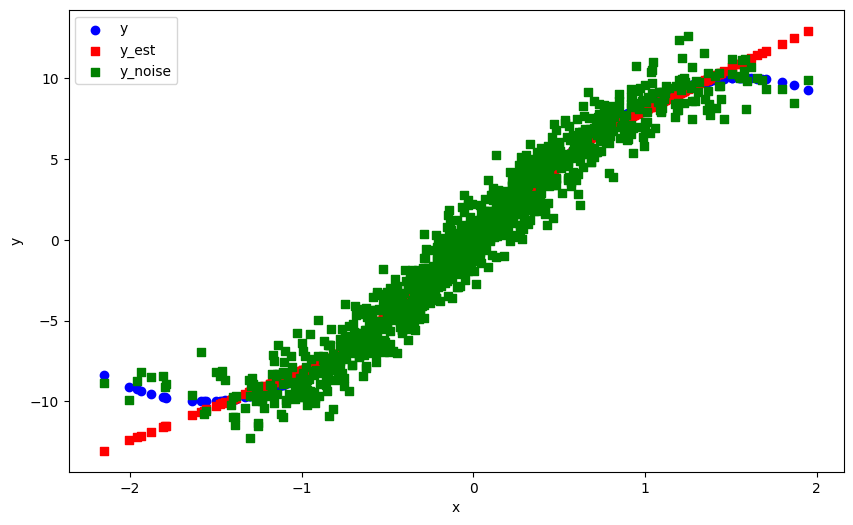

The programm is closed


In [8]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

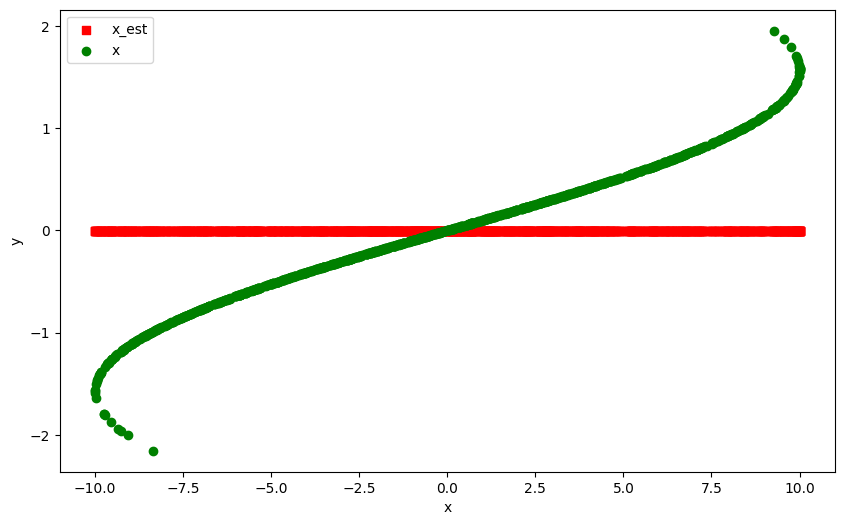

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### DAGMA init

In [10]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [11]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 162/29000 [00:00<01:11, 406.06it/s]

Sigma:  tensor([[ 0.9605, -0.0168],
        [-0.0168,  1.0405]], grad_fn=<MmBackward0>)
obj:  tensor(49.5261, grad_fn=<AddBackward0>)
mle loss:  tensor(48.7511, grad_fn=<AddBackward0>)
h_val:  tensor(0.1149, grad_fn=<AddBackward0>)


  1%|          | 242/29000 [00:00<01:14, 384.65it/s]

Sigma:  tensor([[ 0.9217, -0.0154],
        [-0.0154,  1.0785]], grad_fn=<MmBackward0>)
obj:  tensor(29.4079, grad_fn=<AddBackward0>)
mle loss:  tensor(28.5314, grad_fn=<AddBackward0>)
h_val:  tensor(0.2290, grad_fn=<AddBackward0>)


  1%|▏         | 372/29000 [00:00<01:10, 407.02it/s]

Sigma:  tensor([[ 0.8854, -0.0069],
        [-0.0069,  1.1105]], grad_fn=<MmBackward0>)
obj:  tensor(17.0623, grad_fn=<AddBackward0>)
mle loss:  tensor(16.0598, grad_fn=<AddBackward0>)
h_val:  tensor(0.3720, grad_fn=<AddBackward0>)


  2%|▏         | 453/29000 [00:01<01:13, 389.88it/s]

Sigma:  tensor([[ 0.8528, -0.0047],
        [-0.0047,  1.1348]], grad_fn=<MmBackward0>)
obj:  tensor(10.7036, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4144, grad_fn=<AddBackward0>)
h_val:  tensor(0.6796, grad_fn=<AddBackward0>)


  2%|▏         | 578/29000 [00:01<01:11, 397.30it/s]

Sigma:  tensor([[ 0.8221, -0.0049],
        [-0.0049,  1.1521]], grad_fn=<MmBackward0>)
obj:  tensor(8.1452, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4498, grad_fn=<AddBackward0>)
h_val:  tensor(1.0968, grad_fn=<AddBackward0>)


  2%|▏         | 657/29000 [00:01<01:15, 376.72it/s]

Sigma:  tensor([[ 0.7921, -0.0029],
        [-0.0029,  1.1643]], grad_fn=<MmBackward0>)
obj:  tensor(7.4574, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3755, grad_fn=<AddBackward0>)
h_val:  tensor(1.4934, grad_fn=<AddBackward0>)


  3%|▎         | 775/29000 [00:02<01:13, 382.32it/s]

Sigma:  tensor([[ 0.7624, -0.0013],
        [-0.0013,  1.1739]], grad_fn=<MmBackward0>)
obj:  tensor(7.2855, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0183, grad_fn=<AddBackward0>)
h_val:  tensor(1.6845, grad_fn=<AddBackward0>)


  3%|▎         | 852/29000 [00:02<01:16, 369.63it/s]

Sigma:  tensor([[ 0.7327, -0.0017],
        [-0.0017,  1.1824]], grad_fn=<MmBackward0>)
obj:  tensor(7.0809, grad_fn=<AddBackward0>)
mle loss:  tensor(4.8717, grad_fn=<AddBackward0>)
h_val:  tensor(1.6274, grad_fn=<AddBackward0>)


  3%|▎         | 974/29000 [00:02<01:11, 390.17it/s]

Sigma:  tensor([[ 0.7031, -0.0022],
        [-0.0022,  1.1909]], grad_fn=<MmBackward0>)
obj:  tensor(6.8799, grad_fn=<AddBackward0>)
mle loss:  tensor(4.8009, grad_fn=<AddBackward0>)
h_val:  tensor(1.4960, grad_fn=<AddBackward0>)


  4%|▎         | 1055/29000 [00:02<01:12, 384.14it/s]

Sigma:  tensor([[ 0.6743, -0.0022],
        [-0.0022,  1.1997]], grad_fn=<MmBackward0>)
obj:  tensor(6.7016, grad_fn=<AddBackward0>)
mle loss:  tensor(4.7348, grad_fn=<AddBackward0>)
h_val:  tensor(1.3847, grad_fn=<AddBackward0>)


  4%|▍         | 1168/29000 [00:03<01:46, 262.26it/s]

Sigma:  tensor([[ 0.6468, -0.0023],
        [-0.0023,  1.2091]], grad_fn=<MmBackward0>)
obj:  tensor(6.5315, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6241, grad_fn=<AddBackward0>)
h_val:  tensor(1.3269, grad_fn=<AddBackward0>)


  4%|▍         | 1244/29000 [00:03<01:28, 312.85it/s]

Sigma:  tensor([[ 0.6205, -0.0024],
        [-0.0024,  1.2189]], grad_fn=<MmBackward0>)
obj:  tensor(6.3559, grad_fn=<AddBackward0>)
mle loss:  tensor(4.4718, grad_fn=<AddBackward0>)
h_val:  tensor(1.3056, grad_fn=<AddBackward0>)


  5%|▍         | 1372/29000 [00:03<01:15, 367.89it/s]

Sigma:  tensor([[ 0.5955, -0.0023],
        [-0.0023,  1.2293]], grad_fn=<MmBackward0>)
obj:  tensor(6.1723, grad_fn=<AddBackward0>)
mle loss:  tensor(4.3057, grad_fn=<AddBackward0>)
h_val:  tensor(1.2913, grad_fn=<AddBackward0>)


  5%|▌         | 1452/29000 [00:04<01:13, 372.67it/s]

Sigma:  tensor([[ 0.5716, -0.0023],
        [-0.0023,  1.2401]], grad_fn=<MmBackward0>)
obj:  tensor(5.9914, grad_fn=<AddBackward0>)
mle loss:  tensor(4.1448, grad_fn=<AddBackward0>)
h_val:  tensor(1.2740, grad_fn=<AddBackward0>)


  5%|▌         | 1572/29000 [00:04<01:12, 379.24it/s]

Sigma:  tensor([[ 0.5487, -0.0023],
        [-0.0023,  1.2512]], grad_fn=<MmBackward0>)
obj:  tensor(5.8177, grad_fn=<AddBackward0>)
mle loss:  tensor(3.9925, grad_fn=<AddBackward0>)
h_val:  tensor(1.2545, grad_fn=<AddBackward0>)


  6%|▌         | 1652/29000 [00:04<01:11, 381.26it/s]

Sigma:  tensor([[ 0.5268, -0.0023],
        [-0.0023,  1.2627]], grad_fn=<MmBackward0>)
obj:  tensor(5.6410, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8454, grad_fn=<AddBackward0>)
h_val:  tensor(1.2274, grad_fn=<AddBackward0>)


  6%|▌         | 1779/29000 [00:04<01:07, 400.51it/s]

Sigma:  tensor([[ 0.5059, -0.0024],
        [-0.0024,  1.2745]], grad_fn=<MmBackward0>)
obj:  tensor(5.4669, grad_fn=<AddBackward0>)
mle loss:  tensor(3.6982, grad_fn=<AddBackward0>)
h_val:  tensor(1.2026, grad_fn=<AddBackward0>)


  6%|▋         | 1862/29000 [00:05<01:08, 397.37it/s]

Sigma:  tensor([[ 0.4858, -0.0024],
        [-0.0024,  1.2866]], grad_fn=<MmBackward0>)
obj:  tensor(5.2959, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5503, grad_fn=<AddBackward0>)
h_val:  tensor(1.1810, grad_fn=<AddBackward0>)


  7%|▋         | 1941/29000 [00:05<01:10, 385.44it/s]

Sigma:  tensor([[ 0.4666, -0.0024],
        [-0.0024,  1.2990]], grad_fn=<MmBackward0>)
obj:  tensor(5.1231, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4012, grad_fn=<AddBackward0>)
h_val:  tensor(1.1596, grad_fn=<AddBackward0>)


  7%|▋         | 2070/29000 [00:05<01:05, 409.33it/s]

Sigma:  tensor([[ 0.4482, -0.0024],
        [-0.0024,  1.3117]], grad_fn=<MmBackward0>)
obj:  tensor(4.9472, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2519, grad_fn=<AddBackward0>)
h_val:  tensor(1.1363, grad_fn=<AddBackward0>)


  7%|▋         | 2153/29000 [00:05<01:08, 392.34it/s]

Sigma:  tensor([[ 0.4305, -0.0025],
        [-0.0025,  1.3246]], grad_fn=<MmBackward0>)
obj:  tensor(4.7821, grad_fn=<AddBackward0>)
mle loss:  tensor(3.1041, grad_fn=<AddBackward0>)
h_val:  tensor(1.1200, grad_fn=<AddBackward0>)


  8%|▊         | 2277/29000 [00:06<01:08, 390.47it/s]

Sigma:  tensor([[ 0.4136, -0.0025],
        [-0.0025,  1.3377]], grad_fn=<MmBackward0>)
obj:  tensor(4.6126, grad_fn=<AddBackward0>)
mle loss:  tensor(2.9587, grad_fn=<AddBackward0>)
h_val:  tensor(1.0986, grad_fn=<AddBackward0>)


  8%|▊         | 2355/29000 [00:06<01:12, 367.11it/s]

Sigma:  tensor([[ 0.3973, -0.0025],
        [-0.0025,  1.3509]], grad_fn=<MmBackward0>)
obj:  tensor(4.4409, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8133, grad_fn=<AddBackward0>)
h_val:  tensor(1.0763, grad_fn=<AddBackward0>)


  9%|▊         | 2479/29000 [00:06<01:06, 396.99it/s]

Sigma:  tensor([[ 0.3817, -0.0025],
        [-0.0025,  1.3642]], grad_fn=<MmBackward0>)
obj:  tensor(4.2733, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6677, grad_fn=<AddBackward0>)
h_val:  tensor(1.0576, grad_fn=<AddBackward0>)


  9%|▉         | 2559/29000 [00:06<01:08, 383.97it/s]

Sigma:  tensor([[ 0.3667, -0.0026],
        [-0.0026,  1.3777]], grad_fn=<MmBackward0>)
obj:  tensor(4.1146, grad_fn=<AddBackward0>)
mle loss:  tensor(2.5244, grad_fn=<AddBackward0>)
h_val:  tensor(1.0441, grad_fn=<AddBackward0>)


  9%|▉         | 2637/29000 [00:07<01:10, 376.19it/s]

Sigma:  tensor([[ 0.3523, -0.0026],
        [-0.0026,  1.3912]], grad_fn=<MmBackward0>)
obj:  tensor(3.9641, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3840, grad_fn=<AddBackward0>)
h_val:  tensor(1.0345, grad_fn=<AddBackward0>)


 10%|▉         | 2763/29000 [00:07<01:07, 389.16it/s]

Sigma:  tensor([[ 0.3385, -0.0026],
        [-0.0026,  1.4046]], grad_fn=<MmBackward0>)
obj:  tensor(3.8178, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2464, grad_fn=<AddBackward0>)
h_val:  tensor(1.0255, grad_fn=<AddBackward0>)


 10%|▉         | 2844/29000 [00:07<01:06, 393.18it/s]

Sigma:  tensor([[ 0.3251, -0.0026],
        [-0.0026,  1.4181]], grad_fn=<MmBackward0>)
obj:  tensor(3.6683, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1128, grad_fn=<AddBackward0>)
h_val:  tensor(1.0103, grad_fn=<AddBackward0>)


 10%|█         | 2973/29000 [00:08<01:05, 399.13it/s]

Sigma:  tensor([[ 0.3123, -0.0027],
        [-0.0027,  1.4315]], grad_fn=<MmBackward0>)
obj:  tensor(3.5097, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9782, grad_fn=<AddBackward0>)
h_val:  tensor(0.9895, grad_fn=<AddBackward0>)


 11%|█         | 3054/29000 [00:08<01:07, 386.26it/s]

Sigma:  tensor([[ 0.3000, -0.0027],
        [-0.0027,  1.4448]], grad_fn=<MmBackward0>)
obj:  tensor(3.3618, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8466, grad_fn=<AddBackward0>)
h_val:  tensor(0.9749, grad_fn=<AddBackward0>)


 11%|█         | 3174/29000 [00:08<01:06, 389.95it/s]

Sigma:  tensor([[ 0.2882, -0.0027],
        [-0.0027,  1.4579]], grad_fn=<MmBackward0>)
obj:  tensor(3.2082, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7154, grad_fn=<AddBackward0>)
h_val:  tensor(0.9573, grad_fn=<AddBackward0>)


 11%|█         | 3255/29000 [00:08<01:05, 394.65it/s]

Sigma:  tensor([[ 0.2768, -0.0027],
        [-0.0027,  1.4708]], grad_fn=<MmBackward0>)
obj:  tensor(3.0619, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5859, grad_fn=<AddBackward0>)
h_val:  tensor(0.9438, grad_fn=<AddBackward0>)


 12%|█▏        | 3381/29000 [00:09<01:02, 407.22it/s]

Sigma:  tensor([[ 0.2659, -0.0028],
        [-0.0028,  1.4834]], grad_fn=<MmBackward0>)
obj:  tensor(2.9168, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4613, grad_fn=<AddBackward0>)
h_val:  tensor(0.9273, grad_fn=<AddBackward0>)


 12%|█▏        | 3463/29000 [00:09<01:04, 397.57it/s]

Sigma:  tensor([[ 0.2553, -0.0028],
        [-0.0028,  1.4957]], grad_fn=<MmBackward0>)
obj:  tensor(2.7802, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3393, grad_fn=<AddBackward0>)
h_val:  tensor(0.9143, grad_fn=<AddBackward0>)


 12%|█▏        | 3542/29000 [00:09<01:07, 374.74it/s]

Sigma:  tensor([[ 0.2452, -0.0028],
        [-0.0028,  1.5076]], grad_fn=<MmBackward0>)
obj:  tensor(2.6433, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2204, grad_fn=<AddBackward0>)
h_val:  tensor(0.8993, grad_fn=<AddBackward0>)


 13%|█▎        | 3670/29000 [00:09<01:03, 401.71it/s]

Sigma:  tensor([[ 0.2355, -0.0028],
        [-0.0028,  1.5192]], grad_fn=<MmBackward0>)
obj:  tensor(2.5063, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1028, grad_fn=<AddBackward0>)
h_val:  tensor(0.8838, grad_fn=<AddBackward0>)


 13%|█▎        | 3752/29000 [00:09<01:03, 398.95it/s]

Sigma:  tensor([[ 0.2261, -0.0029],
        [-0.0029,  1.5303]], grad_fn=<MmBackward0>)
obj:  tensor(2.3723, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9885, grad_fn=<AddBackward0>)
h_val:  tensor(0.8676, grad_fn=<AddBackward0>)


 13%|█▎        | 3880/29000 [00:10<01:01, 408.21it/s]

Sigma:  tensor([[ 0.2170, -0.0029],
        [-0.0029,  1.5409]], grad_fn=<MmBackward0>)
obj:  tensor(2.2415, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8772, grad_fn=<AddBackward0>)
h_val:  tensor(0.8518, grad_fn=<AddBackward0>)


 14%|█▎        | 3962/29000 [00:10<01:02, 400.47it/s]

Sigma:  tensor([[ 0.2084, -0.0029],
        [-0.0029,  1.5509]], grad_fn=<MmBackward0>)
obj:  tensor(2.1175, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7660, grad_fn=<AddBackward0>)
h_val:  tensor(0.8430, grad_fn=<AddBackward0>)


 14%|█▍        | 4044/29000 [00:10<01:02, 400.25it/s]

Sigma:  tensor([[ 0.2000, -0.0029],
        [-0.0029,  1.5603]], grad_fn=<MmBackward0>)
obj:  tensor(1.9970, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6596, grad_fn=<AddBackward0>)
h_val:  tensor(0.8326, grad_fn=<AddBackward0>)


 14%|█▍        | 4172/29000 [00:11<01:00, 413.19it/s]

Sigma:  tensor([[ 0.1920, -0.0029],
        [-0.0029,  1.5691]], grad_fn=<MmBackward0>)
obj:  tensor(1.8786, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5568, grad_fn=<AddBackward0>)
h_val:  tensor(0.8208, grad_fn=<AddBackward0>)


 15%|█▍        | 4256/29000 [00:11<01:00, 408.98it/s]

Sigma:  tensor([[ 0.1842, -0.0029],
        [-0.0029,  1.5772]], grad_fn=<MmBackward0>)
obj:  tensor(1.7557, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4516, grad_fn=<AddBackward0>)
h_val:  tensor(0.8087, grad_fn=<AddBackward0>)


 15%|█▌        | 4383/29000 [00:11<01:00, 409.46it/s]

Sigma:  tensor([[ 0.1768, -0.0030],
        [-0.0030,  1.5844]], grad_fn=<MmBackward0>)
obj:  tensor(1.6383, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3507, grad_fn=<AddBackward0>)
h_val:  tensor(0.7970, grad_fn=<AddBackward0>)


 15%|█▌        | 4466/29000 [00:11<01:01, 401.76it/s]

Sigma:  tensor([[ 0.1696, -0.0030],
        [-0.0030,  1.5909]], grad_fn=<MmBackward0>)
obj:  tensor(1.5241, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2535, grad_fn=<AddBackward0>)
h_val:  tensor(0.7842, grad_fn=<AddBackward0>)


 16%|█▌        | 4547/29000 [00:11<01:02, 388.47it/s]

Sigma:  tensor([[ 0.1627, -0.0030],
        [-0.0030,  1.5964]], grad_fn=<MmBackward0>)
obj:  tensor(1.4092, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1574, grad_fn=<AddBackward0>)
h_val:  tensor(0.7704, grad_fn=<AddBackward0>)


 16%|█▌        | 4666/29000 [00:12<01:03, 384.39it/s]

Sigma:  tensor([[ 0.1561, -0.0031],
        [-0.0031,  1.6010]], grad_fn=<MmBackward0>)
obj:  tensor(1.2888, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0562, grad_fn=<AddBackward0>)
h_val:  tensor(0.7582, grad_fn=<AddBackward0>)


 16%|█▋        | 4744/29000 [00:12<01:05, 368.98it/s]

Sigma:  tensor([[ 0.1498, -0.0031],
        [-0.0031,  1.6046]], grad_fn=<MmBackward0>)
obj:  tensor(1.1754, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0385, grad_fn=<AddBackward0>)
h_val:  tensor(0.7452, grad_fn=<AddBackward0>)


 17%|█▋        | 4870/29000 [00:12<01:00, 401.19it/s]

Sigma:  tensor([[ 0.1436, -0.0031],
        [-0.0031,  1.6070]], grad_fn=<MmBackward0>)
obj:  tensor(1.0620, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1345, grad_fn=<AddBackward0>)
h_val:  tensor(0.7339, grad_fn=<AddBackward0>)


 17%|█▋        | 4953/29000 [00:13<00:59, 406.73it/s]

Sigma:  tensor([[ 0.1377, -0.0032],
        [-0.0032,  1.6083]], grad_fn=<MmBackward0>)
obj:  tensor(0.9491, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2290, grad_fn=<AddBackward0>)
h_val:  tensor(0.7223, grad_fn=<AddBackward0>)


 18%|█▊        | 5079/29000 [00:13<00:59, 402.44it/s]

Sigma:  tensor([[ 0.1320, -0.0033],
        [-0.0033,  1.6083]], grad_fn=<MmBackward0>)
obj:  tensor(0.8358, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3236, grad_fn=<AddBackward0>)
h_val:  tensor(0.7107, grad_fn=<AddBackward0>)


 18%|█▊        | 5161/29000 [00:13<01:00, 391.39it/s]

Sigma:  tensor([[ 0.1266, -0.0034],
        [-0.0034,  1.6069]], grad_fn=<MmBackward0>)
obj:  tensor(0.7248, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4151, grad_fn=<AddBackward0>)
h_val:  tensor(0.6979, grad_fn=<AddBackward0>)


 18%|█▊        | 5242/29000 [00:13<01:01, 386.57it/s]

Sigma:  tensor([[ 0.1213, -0.0034],
        [-0.0034,  1.6042]], grad_fn=<MmBackward0>)
obj:  tensor(0.6154, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5077, grad_fn=<AddBackward0>)
h_val:  tensor(0.6879, grad_fn=<AddBackward0>)


 19%|█▊        | 5376/29000 [00:14<00:55, 422.06it/s]

Sigma:  tensor([[ 0.1163, -0.0035],
        [-0.0035,  1.6000]], grad_fn=<MmBackward0>)
obj:  tensor(0.5048, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5996, grad_fn=<AddBackward0>)
h_val:  tensor(0.6767, grad_fn=<AddBackward0>)


 19%|█▉        | 5461/29000 [00:14<00:58, 405.30it/s]

Sigma:  tensor([[ 0.1114, -0.0036],
        [-0.0036,  1.5943]], grad_fn=<MmBackward0>)
obj:  tensor(0.3983, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6881, grad_fn=<AddBackward0>)
h_val:  tensor(0.6652, grad_fn=<AddBackward0>)


 19%|█▉        | 5542/29000 [00:14<01:01, 382.80it/s]

Sigma:  tensor([[ 0.1068, -0.0037],
        [-0.0037,  1.5870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2911, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7793, grad_fn=<AddBackward0>)
h_val:  tensor(0.6558, grad_fn=<AddBackward0>)


 20%|█▉        | 5674/29000 [00:14<00:56, 411.91it/s]

Sigma:  tensor([[ 0.1023, -0.0038],
        [-0.0038,  1.5780]], grad_fn=<MmBackward0>)
obj:  tensor(0.1867, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8711, grad_fn=<AddBackward0>)
h_val:  tensor(0.6497, grad_fn=<AddBackward0>)


 20%|█▉        | 5757/29000 [00:15<00:57, 404.41it/s]

Sigma:  tensor([[ 0.0980, -0.0039],
        [-0.0039,  1.5673]], grad_fn=<MmBackward0>)
obj:  tensor(0.0807, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9615, grad_fn=<AddBackward0>)
h_val:  tensor(0.6410, grad_fn=<AddBackward0>)


 20%|██        | 5885/29000 [00:15<00:56, 412.75it/s]

Sigma:  tensor([[ 0.0939, -0.0040],
        [-0.0040,  1.5548]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0258, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0512, grad_fn=<AddBackward0>)
h_val:  tensor(0.6315, grad_fn=<AddBackward0>)


 21%|██        | 5969/29000 [00:15<00:56, 408.96it/s]

Sigma:  tensor([[ 0.0899, -0.0041],
        [-0.0041,  1.5405]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1323, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1421, grad_fn=<AddBackward0>)
h_val:  tensor(0.6234, grad_fn=<AddBackward0>)


 21%|██        | 6051/29000 [00:15<00:57, 401.40it/s]

Sigma:  tensor([[ 0.0861, -0.0043],
        [-0.0043,  1.5243]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2385, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2341, grad_fn=<AddBackward0>)
h_val:  tensor(0.6168, grad_fn=<AddBackward0>)


 21%|██▏       | 6183/29000 [00:16<00:55, 414.66it/s]

Sigma:  tensor([[ 0.0825, -0.0045],
        [-0.0045,  1.5062]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3442, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3263, grad_fn=<AddBackward0>)
h_val:  tensor(0.6106, grad_fn=<AddBackward0>)


 22%|██▏       | 6267/29000 [00:16<00:55, 409.70it/s]

Sigma:  tensor([[ 0.0790, -0.0046],
        [-0.0046,  1.4863]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4480, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4191, grad_fn=<AddBackward0>)
h_val:  tensor(0.6066, grad_fn=<AddBackward0>)


 22%|██▏       | 6349/29000 [00:16<00:57, 391.04it/s]

Sigma:  tensor([[ 0.0757, -0.0048],
        [-0.0048,  1.4644]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5500, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5114, grad_fn=<AddBackward0>)
h_val:  tensor(0.6032, grad_fn=<AddBackward0>)


 22%|██▏       | 6475/29000 [00:16<00:57, 392.84it/s]

Sigma:  tensor([[ 0.0724, -0.0050],
        [-0.0050,  1.4407]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6540, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6037, grad_fn=<AddBackward0>)
h_val:  tensor(0.5984, grad_fn=<AddBackward0>)


 23%|██▎       | 6555/29000 [00:17<00:57, 387.26it/s]

Sigma:  tensor([[ 0.0694, -0.0052],
        [-0.0052,  1.4152]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7553, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6948, grad_fn=<AddBackward0>)
h_val:  tensor(0.5941, grad_fn=<AddBackward0>)


 23%|██▎       | 6680/29000 [00:17<00:55, 404.06it/s]

Sigma:  tensor([[ 0.0664, -0.0054],
        [-0.0054,  1.3879]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8614, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 23%|██▎       | 6759/29000 [00:17<01:00, 369.13it/s]

Sigma:  tensor([[ 0.0636, -0.0057],
        [-0.0057,  1.3589]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9653, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8808, grad_fn=<AddBackward0>)
h_val:  tensor(0.5836, grad_fn=<AddBackward0>)


 24%|██▎       | 6874/29000 [00:17<01:01, 358.33it/s]

Sigma:  tensor([[ 0.0609, -0.0060],
        [-0.0060,  1.3284]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0666, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9732, grad_fn=<AddBackward0>)
h_val:  tensor(0.5802, grad_fn=<AddBackward0>)


 24%|██▍       | 6952/29000 [00:18<01:00, 364.36it/s]

Sigma:  tensor([[ 0.0584, -0.0062],
        [-0.0062,  1.2964]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1680, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0658, grad_fn=<AddBackward0>)
h_val:  tensor(0.5769, grad_fn=<AddBackward0>)


 25%|██▍       | 7156/29000 [00:18<00:54, 404.08it/s]

Sigma:  tensor([[ 0.0552, -0.0024],
        [-0.0024,  1.2293]], grad_fn=<MmBackward0>)
obj:  tensor(0.2154, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3147, grad_fn=<AddBackward0>)
h_val:  tensor(0.2167, grad_fn=<AddBackward0>)


 25%|██▍       | 7239/29000 [00:18<00:54, 399.54it/s]

Sigma:  tensor([[5.6322e-02, 3.5189e-04],
        [3.5189e-04, 1.1899e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1521, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2739, grad_fn=<AddBackward0>)
h_val:  tensor(0.2500, grad_fn=<AddBackward0>)


 25%|██▌       | 7370/29000 [00:19<00:53, 401.46it/s]

Sigma:  tensor([[5.7209e-02, 3.7800e-04],
        [3.7800e-04, 1.1488e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1344, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9997, grad_fn=<AddBackward0>)
h_val:  tensor(0.2053, grad_fn=<AddBackward0>)


 26%|██▌       | 7451/29000 [00:19<00:58, 366.53it/s]

Sigma:  tensor([[ 5.8561e-02, -6.3883e-04],
        [-6.3883e-04,  1.1071e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1258, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7444, grad_fn=<AddBackward0>)
h_val:  tensor(0.1715, grad_fn=<AddBackward0>)


 26%|██▌       | 7569/29000 [00:19<00:56, 382.67it/s]

Sigma:  tensor([[ 6.0486e-02, -7.4103e-04],
        [-7.4103e-04,  1.0656e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1192, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0011, grad_fn=<AddBackward0>)
h_val:  tensor(0.1908, grad_fn=<AddBackward0>)


 26%|██▋       | 7647/29000 [00:19<00:59, 360.78it/s]

Sigma:  tensor([[ 6.2506e-02, -1.5331e-04],
        [-1.5331e-04,  1.0246e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1118, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8350, grad_fn=<AddBackward0>)
h_val:  tensor(0.1670, grad_fn=<AddBackward0>)


 27%|██▋       | 7766/29000 [00:20<00:56, 374.74it/s]

Sigma:  tensor([[6.4818e-02, 8.0336e-06],
        [8.0336e-06, 9.8446e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9870, grad_fn=<AddBackward0>)
h_val:  tensor(0.1761, grad_fn=<AddBackward0>)


 27%|██▋       | 7843/29000 [00:20<00:58, 364.22it/s]

Sigma:  tensor([[ 6.7153e-02, -8.2459e-05],
        [-8.2459e-05,  9.4552e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0997, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9561, grad_fn=<AddBackward0>)
h_val:  tensor(0.1671, grad_fn=<AddBackward0>)


 27%|██▋       | 7959/29000 [00:20<00:56, 374.35it/s]

Sigma:  tensor([[6.9602e-02, 8.7852e-05],
        [8.7852e-05, 9.0793e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0954, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9977, grad_fn=<AddBackward0>)
h_val:  tensor(0.1669, grad_fn=<AddBackward0>)


 28%|██▊       | 8038/29000 [00:21<00:56, 373.73it/s]

Sigma:  tensor([[7.2143e-02, 1.5533e-04],
        [1.5533e-04, 8.7176e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0904, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9718, grad_fn=<AddBackward0>)
h_val:  tensor(0.1593, grad_fn=<AddBackward0>)


 28%|██▊       | 8122/29000 [00:21<00:54, 380.41it/s]

Sigma:  tensor([[7.4835e-02, 1.4775e-04],
        [1.4775e-04, 8.3708e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0840, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9972, grad_fn=<AddBackward0>)
h_val:  tensor(0.1556, grad_fn=<AddBackward0>)


 28%|██▊       | 8245/29000 [00:21<00:58, 353.13it/s]

Sigma:  tensor([[7.7620e-02, 2.4137e-04],
        [2.4137e-04, 8.0388e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0780, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0080, grad_fn=<AddBackward0>)
h_val:  tensor(0.1507, grad_fn=<AddBackward0>)


 29%|██▉       | 8373/29000 [00:21<00:53, 386.66it/s]

Sigma:  tensor([[8.0497e-02, 2.9290e-04],
        [2.9290e-04, 7.7203e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0712, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0452, grad_fn=<AddBackward0>)
h_val:  tensor(0.1477, grad_fn=<AddBackward0>)


 29%|██▉       | 8452/29000 [00:22<00:55, 371.26it/s]

Sigma:  tensor([[8.3451e-02, 3.2166e-04],
        [3.2166e-04, 7.4123e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0643, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0628, grad_fn=<AddBackward0>)
h_val:  tensor(0.1426, grad_fn=<AddBackward0>)


 30%|██▉       | 8571/29000 [00:22<00:53, 382.17it/s]

Sigma:  tensor([[8.6491e-02, 4.0128e-04],
        [4.0128e-04, 7.1150e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0575, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0890, grad_fn=<AddBackward0>)
h_val:  tensor(0.1384, grad_fn=<AddBackward0>)


 30%|██▉       | 8651/29000 [00:22<00:52, 385.88it/s]

Sigma:  tensor([[8.9625e-02, 3.1672e-04],
        [3.1672e-04, 6.8290e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0499, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1028, grad_fn=<AddBackward0>)
h_val:  tensor(0.1321, grad_fn=<AddBackward0>)


 30%|███       | 8733/29000 [00:23<01:26, 234.80it/s]

Sigma:  tensor([[9.2883e-02, 2.7001e-04],
        [2.7001e-04, 6.5517e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0393, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1664, grad_fn=<AddBackward0>)
h_val:  tensor(0.1277, grad_fn=<AddBackward0>)


 31%|███       | 8848/29000 [00:23<01:06, 301.39it/s]

Sigma:  tensor([[9.6245e-02, 1.2478e-04],
        [1.2478e-04, 6.2783e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2212, grad_fn=<AddBackward0>)
h_val:  tensor(0.1245, grad_fn=<AddBackward0>)


 31%|███       | 8966/29000 [00:23<00:59, 339.06it/s]

Sigma:  tensor([[9.9672e-02, 3.0878e-04],
        [3.0878e-04, 6.0111e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0224, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2677, grad_fn=<AddBackward0>)
h_val:  tensor(0.1212, grad_fn=<AddBackward0>)


 31%|███       | 9039/29000 [00:23<00:57, 347.71it/s]

Sigma:  tensor([[1.0314e-01, 3.4960e-04],
        [3.4960e-04, 5.7534e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2843, grad_fn=<AddBackward0>)
h_val:  tensor(0.1156, grad_fn=<AddBackward0>)


 32%|███▏      | 9153/29000 [00:24<00:55, 356.52it/s]

Sigma:  tensor([[1.0670e-01, 3.1206e-04],
        [3.1206e-04, 5.5076e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3149, grad_fn=<AddBackward0>)
h_val:  tensor(0.1111, grad_fn=<AddBackward0>)


 32%|███▏      | 9268/29000 [00:24<00:53, 369.54it/s]

Sigma:  tensor([[1.1035e-01, 3.1887e-04],
        [3.1887e-04, 5.2736e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0008, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3310, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 32%|███▏      | 9346/29000 [00:24<00:52, 376.71it/s]

Sigma:  tensor([[1.1410e-01, 3.2175e-04],
        [3.2175e-04, 5.0507e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3665, grad_fn=<AddBackward0>)
h_val:  tensor(0.1021, grad_fn=<AddBackward0>)


 33%|███▎      | 9462/29000 [00:25<00:52, 375.09it/s]

Sigma:  tensor([[1.1792e-01, 3.0701e-04],
        [3.0701e-04, 4.8383e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3950, grad_fn=<AddBackward0>)
h_val:  tensor(0.0980, grad_fn=<AddBackward0>)


 33%|███▎      | 9535/29000 [00:25<00:57, 338.22it/s]

Sigma:  tensor([[1.2180e-01, 3.3444e-04],
        [3.3444e-04, 4.6354e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4272, grad_fn=<AddBackward0>)
h_val:  tensor(0.0942, grad_fn=<AddBackward0>)


 33%|███▎      | 9664/29000 [00:25<00:49, 392.67it/s]

Sigma:  tensor([[1.2575e-01, 3.4056e-04],
        [3.4056e-04, 4.4413e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0278, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4654, grad_fn=<AddBackward0>)
h_val:  tensor(0.0910, grad_fn=<AddBackward0>)


 34%|███▎      | 9744/29000 [00:25<00:49, 392.71it/s]

Sigma:  tensor([[1.2976e-01, 3.1027e-04],
        [3.1027e-04, 4.2550e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5076, grad_fn=<AddBackward0>)
h_val:  tensor(0.0882, grad_fn=<AddBackward0>)


 34%|███▍      | 9864/29000 [00:26<00:49, 390.50it/s]

Sigma:  tensor([[1.3381e-01, 2.8223e-04],
        [2.8223e-04, 4.0760e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0413, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5382, grad_fn=<AddBackward0>)
h_val:  tensor(0.0849, grad_fn=<AddBackward0>)


 34%|███▍      | 9944/29000 [00:26<00:49, 384.06it/s]

Sigma:  tensor([[1.3793e-01, 2.9148e-04],
        [2.9148e-04, 3.9044e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0477, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5823, grad_fn=<AddBackward0>)
h_val:  tensor(0.0832, grad_fn=<AddBackward0>)


 35%|███▍      | 10073/29000 [00:26<00:47, 396.36it/s]

Sigma:  tensor([[1.4201e-01, 3.2548e-04],
        [3.2548e-04, 3.7404e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0532, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6146, grad_fn=<AddBackward0>)
h_val:  tensor(0.0812, grad_fn=<AddBackward0>)


 35%|███▌      | 10153/29000 [00:26<00:49, 382.95it/s]

Sigma:  tensor([[0.1460, 0.0004],
        [0.0004, 0.3584]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0584, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6494, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 35%|███▌      | 10275/29000 [00:27<00:47, 393.67it/s]

Sigma:  tensor([[0.1500, 0.0004],
        [0.0004, 0.3436]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0631, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0779, grad_fn=<AddBackward0>)


 36%|███▌      | 10354/29000 [00:27<00:48, 385.44it/s]

Sigma:  tensor([[0.1539, 0.0004],
        [0.0004, 0.3295]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0681, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7044, grad_fn=<AddBackward0>)
h_val:  tensor(0.0759, grad_fn=<AddBackward0>)


 36%|███▌      | 10469/29000 [00:27<00:50, 366.02it/s]

Sigma:  tensor([[0.1578, 0.0003],
        [0.0003, 0.3161]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7276, grad_fn=<AddBackward0>)
h_val:  tensor(0.0735, grad_fn=<AddBackward0>)


 36%|███▋      | 10540/29000 [00:28<00:57, 322.41it/s]

Sigma:  tensor([[0.1617, 0.0004],
        [0.0004, 0.3032]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0776, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7582, grad_fn=<AddBackward0>)
h_val:  tensor(0.0719, grad_fn=<AddBackward0>)


 37%|███▋      | 10648/29000 [00:28<00:52, 347.28it/s]

Sigma:  tensor([[0.1657, 0.0004],
        [0.0004, 0.2910]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0822, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7803, grad_fn=<AddBackward0>)
h_val:  tensor(0.0694, grad_fn=<AddBackward0>)


 37%|███▋      | 10770/29000 [00:28<00:48, 374.48it/s]

Sigma:  tensor([[0.1697, 0.0003],
        [0.0003, 0.2793]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0868, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8025, grad_fn=<AddBackward0>)
h_val:  tensor(0.0670, grad_fn=<AddBackward0>)


 37%|███▋      | 10848/29000 [00:28<00:47, 380.16it/s]

Sigma:  tensor([[0.1738, 0.0003],
        [0.0003, 0.2681]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0914, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8295, grad_fn=<AddBackward0>)
h_val:  tensor(0.0651, grad_fn=<AddBackward0>)


 38%|███▊      | 10970/29000 [00:29<00:46, 385.60it/s]

Sigma:  tensor([[1.7788e-01, 2.5155e-04],
        [2.5155e-04, 2.5742e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0958, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8558, grad_fn=<AddBackward0>)
h_val:  tensor(0.0633, grad_fn=<AddBackward0>)


 38%|███▊      | 11049/29000 [00:29<00:46, 385.76it/s]

Sigma:  tensor([[0.1820, 0.0003],
        [0.0003, 0.2472]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1002, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8831, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)


 39%|███▊      | 11169/29000 [00:29<00:46, 384.10it/s]

Sigma:  tensor([[0.1862, 0.0002],
        [0.0002, 0.2373]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1046, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0600, grad_fn=<AddBackward0>)


 39%|███▉      | 11247/29000 [00:29<00:46, 380.13it/s]

Sigma:  tensor([[0.1904, 0.0002],
        [0.0002, 0.2279]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1089, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9378, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)


 39%|███▉      | 11361/29000 [00:30<00:48, 360.30it/s]

Sigma:  tensor([[0.1946, 0.0002],
        [0.0002, 0.2188]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1132, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9645, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


 39%|███▉      | 11436/29000 [00:30<00:49, 354.91it/s]

Sigma:  tensor([[0.1989, 0.0002],
        [0.0002, 0.2101]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1175, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0550, grad_fn=<AddBackward0>)


 40%|███▉      | 11560/29000 [00:30<00:44, 389.49it/s]

Sigma:  tensor([[0.2031, 0.0002],
        [0.0002, 0.2018]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1218, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0198, grad_fn=<AddBackward0>)
h_val:  tensor(0.0534, grad_fn=<AddBackward0>)


 40%|████      | 11641/29000 [00:30<00:44, 387.31it/s]

Sigma:  tensor([[2.0736e-01, 2.0084e-04],
        [2.0084e-04, 1.9381e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1261, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0481, grad_fn=<AddBackward0>)
h_val:  tensor(0.0520, grad_fn=<AddBackward0>)


 41%|████      | 11770/29000 [00:31<00:42, 408.88it/s]

Sigma:  tensor([[2.1156e-01, 1.9552e-04],
        [1.9552e-04, 1.8614e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1304, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0772, grad_fn=<AddBackward0>)
h_val:  tensor(0.0506, grad_fn=<AddBackward0>)


 41%|████      | 11852/29000 [00:31<00:43, 397.64it/s]

Sigma:  tensor([[2.1569e-01, 1.9876e-04],
        [1.9876e-04, 1.7878e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1346, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1067, grad_fn=<AddBackward0>)
h_val:  tensor(0.0493, grad_fn=<AddBackward0>)


 41%|████▏     | 11977/29000 [00:31<00:42, 396.11it/s]

Sigma:  tensor([[2.1974e-01, 1.9230e-04],
        [1.9230e-04, 1.7171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1388, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1371, grad_fn=<AddBackward0>)
h_val:  tensor(0.0481, grad_fn=<AddBackward0>)


 42%|████▏     | 12057/29000 [00:31<00:43, 390.32it/s]

Sigma:  tensor([[2.2369e-01, 1.7694e-04],
        [1.7694e-04, 1.6493e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1429, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0470, grad_fn=<AddBackward0>)


 42%|████▏     | 12182/29000 [00:32<00:41, 402.53it/s]

Sigma:  tensor([[2.2754e-01, 1.7206e-04],
        [1.7206e-04, 1.5842e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1470, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1973, grad_fn=<AddBackward0>)
h_val:  tensor(0.0459, grad_fn=<AddBackward0>)


 42%|████▏     | 12263/29000 [00:32<00:43, 383.88it/s]

Sigma:  tensor([[2.3127e-01, 1.6713e-04],
        [1.6713e-04, 1.5217e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1511, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2284, grad_fn=<AddBackward0>)
h_val:  tensor(0.0449, grad_fn=<AddBackward0>)


 43%|████▎     | 12338/29000 [00:32<00:47, 351.78it/s]

Sigma:  tensor([[2.3485e-01, 1.6426e-04],
        [1.6426e-04, 1.4617e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1552, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2602, grad_fn=<AddBackward0>)
h_val:  tensor(0.0439, grad_fn=<AddBackward0>)


 43%|████▎     | 12463/29000 [00:33<00:42, 386.26it/s]

Sigma:  tensor([[2.3827e-01, 1.6545e-04],
        [1.6545e-04, 1.4041e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1593, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0430, grad_fn=<AddBackward0>)


 43%|████▎     | 12540/29000 [00:33<00:44, 367.55it/s]

Sigma:  tensor([[2.4150e-01, 1.6097e-04],
        [1.6097e-04, 1.3488e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1634, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3256, grad_fn=<AddBackward0>)
h_val:  tensor(0.0422, grad_fn=<AddBackward0>)


 44%|████▎     | 12666/29000 [00:33<00:42, 388.03it/s]

Sigma:  tensor([[2.4455e-01, 1.6115e-04],
        [1.6115e-04, 1.2957e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1675, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3601, grad_fn=<AddBackward0>)
h_val:  tensor(0.0416, grad_fn=<AddBackward0>)


 44%|████▍     | 12745/29000 [00:33<00:41, 387.05it/s]

Sigma:  tensor([[2.4739e-01, 1.6428e-04],
        [1.6428e-04, 1.2447e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1716, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3935, grad_fn=<AddBackward0>)
h_val:  tensor(0.0408, grad_fn=<AddBackward0>)


 44%|████▍     | 12875/29000 [00:34<00:39, 406.49it/s]

Sigma:  tensor([[2.5002e-01, 1.5959e-04],
        [1.5959e-04, 1.1957e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1756, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4274, grad_fn=<AddBackward0>)
h_val:  tensor(0.0402, grad_fn=<AddBackward0>)


 45%|████▍     | 12956/29000 [00:34<00:41, 382.63it/s]

Sigma:  tensor([[2.5243e-01, 1.5060e-04],
        [1.5060e-04, 1.1487e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1797, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4627, grad_fn=<AddBackward0>)
h_val:  tensor(0.0396, grad_fn=<AddBackward0>)


 45%|████▌     | 13079/29000 [00:34<00:40, 391.56it/s]

Sigma:  tensor([[2.5462e-01, 1.6704e-04],
        [1.6704e-04, 1.1036e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4979, grad_fn=<AddBackward0>)
h_val:  tensor(0.0391, grad_fn=<AddBackward0>)


 45%|████▌     | 13159/29000 [00:34<00:40, 388.63it/s]

Sigma:  tensor([[2.5660e-01, 1.4286e-04],
        [1.4286e-04, 1.0602e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1878, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5350, grad_fn=<AddBackward0>)
h_val:  tensor(0.0387, grad_fn=<AddBackward0>)


 46%|████▌     | 13283/29000 [00:35<00:39, 400.62it/s]

Sigma:  tensor([[2.5835e-01, 1.6861e-04],
        [1.6861e-04, 1.0186e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1918, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5699, grad_fn=<AddBackward0>)
h_val:  tensor(0.0382, grad_fn=<AddBackward0>)


 46%|████▌     | 13364/29000 [00:35<00:40, 390.44it/s]

Sigma:  tensor([[2.5989e-01, 1.5585e-04],
        [1.5585e-04, 9.7857e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1958, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6078, grad_fn=<AddBackward0>)
h_val:  tensor(0.0380, grad_fn=<AddBackward0>)


 46%|████▋     | 13443/29000 [00:35<00:41, 375.88it/s]

Sigma:  tensor([[2.6125e-01, 1.5495e-04],
        [1.5495e-04, 9.4016e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1998, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6429, grad_fn=<AddBackward0>)
h_val:  tensor(0.0375, grad_fn=<AddBackward0>)


 47%|████▋     | 13567/29000 [00:35<00:39, 389.35it/s]

Sigma:  tensor([[2.6241e-01, 1.5153e-04],
        [1.5153e-04, 9.0327e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2038, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0374, grad_fn=<AddBackward0>)


 47%|████▋     | 13645/29000 [00:36<00:42, 361.89it/s]

Sigma:  tensor([[2.6338e-01, 1.6218e-04],
        [1.6218e-04, 8.6783e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2078, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0371, grad_fn=<AddBackward0>)


 47%|████▋     | 13766/29000 [00:36<00:39, 382.49it/s]

Sigma:  tensor([[2.6419e-01, 1.5281e-04],
        [1.5281e-04, 8.3380e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2118, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7575, grad_fn=<AddBackward0>)
h_val:  tensor(0.0369, grad_fn=<AddBackward0>)


 48%|████▊     | 13844/29000 [00:36<00:40, 370.83it/s]

Sigma:  tensor([[2.6486e-01, 1.5946e-04],
        [1.5946e-04, 8.0111e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2159, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7971, grad_fn=<AddBackward0>)
h_val:  tensor(0.0368, grad_fn=<AddBackward0>)


 48%|████▊     | 13966/29000 [00:37<00:39, 383.04it/s]

Sigma:  tensor([[2.6539e-01, 1.4868e-04],
        [1.4868e-04, 7.6970e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2199, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0366, grad_fn=<AddBackward0>)


 49%|████▉     | 14165/29000 [00:37<00:39, 375.20it/s]

Sigma:  tensor([[ 2.6838e-01, -2.2441e-04],
        [-2.2441e-04,  7.3304e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0081, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4127, grad_fn=<AddBackward0>)
h_val:  tensor(0.0133, grad_fn=<AddBackward0>)


 49%|████▉     | 14241/29000 [00:37<00:41, 359.05it/s]

Sigma:  tensor([[0.2794, 0.0003],
        [0.0003, 0.0728]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2589, grad_fn=<AddBackward0>)
h_val:  tensor(0.0062, grad_fn=<AddBackward0>)


 50%|████▉     | 14361/29000 [00:38<00:38, 379.25it/s]

Sigma:  tensor([[0.2915, 0.0005],
        [0.0005, 0.0723]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3671, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 50%|████▉     | 14439/29000 [00:38<00:38, 377.78it/s]

Sigma:  tensor([[3.0344e-01, 2.1387e-04],
        [2.1387e-04, 7.1772e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 50%|█████     | 14563/29000 [00:38<00:36, 394.24it/s]

Sigma:  tensor([[3.1647e-01, 1.5519e-05],
        [1.5519e-05, 7.1126e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0191, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 50%|█████     | 14643/29000 [00:38<00:37, 382.16it/s]

Sigma:  tensor([[ 3.2957e-01, -1.1606e-05],
        [-1.1606e-05,  7.0407e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0193, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2932, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 51%|█████     | 14764/29000 [00:39<00:37, 376.67it/s]

Sigma:  tensor([[3.4219e-01, 2.1251e-05],
        [2.1251e-05, 6.9618e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2978, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 51%|█████     | 14839/29000 [00:39<00:39, 360.93it/s]

Sigma:  tensor([[3.5434e-01, 2.8955e-05],
        [2.8955e-05, 6.8766e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3428, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 52%|█████▏    | 14966/29000 [00:39<00:36, 386.07it/s]

Sigma:  tensor([[3.6561e-01, 3.0302e-05],
        [3.0302e-05, 6.7854e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3557, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 52%|█████▏    | 15045/29000 [00:39<00:36, 384.14it/s]

Sigma:  tensor([[3.7617e-01, 7.7107e-07],
        [7.7107e-07, 6.6886e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 52%|█████▏    | 15173/29000 [00:40<00:34, 401.57it/s]

Sigma:  tensor([[3.8601e-01, 6.1983e-07],
        [6.1983e-07, 6.5867e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3939, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 53%|█████▎    | 15254/29000 [00:40<00:36, 378.72it/s]

Sigma:  tensor([[3.9526e-01, 9.0668e-06],
        [9.0668e-06, 6.4799e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4131, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 53%|█████▎    | 15377/29000 [00:40<00:33, 400.71it/s]

Sigma:  tensor([[4.0391e-01, 2.4234e-06],
        [2.4234e-06, 6.3687e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 53%|█████▎    | 15458/29000 [00:40<00:34, 390.16it/s]

Sigma:  tensor([[4.1196e-01, 7.7142e-06],
        [7.7142e-06, 6.2532e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▎    | 15582/29000 [00:41<00:33, 401.57it/s]

Sigma:  tensor([[4.1937e-01, 3.5466e-06],
        [3.5466e-06, 6.1339e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0216, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4723, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▍    | 15663/29000 [00:41<00:33, 394.28it/s]

Sigma:  tensor([[4.2612e-01, 4.4388e-06],
        [4.4388e-06, 6.0111e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0218, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4937, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▍    | 15742/29000 [00:41<00:35, 373.32it/s]

Sigma:  tensor([[4.3220e-01, 6.2790e-06],
        [6.2790e-06, 5.8851e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0221, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5155, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 55%|█████▍    | 15865/29000 [00:42<00:47, 274.38it/s]

Sigma:  tensor([[4.3764e-01, 4.6090e-06],
        [4.6090e-06, 5.7563e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5377, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 55%|█████▍    | 15942/29000 [00:42<00:41, 318.20it/s]

Sigma:  tensor([[4.4244e-01, 4.8896e-06],
        [4.8896e-06, 5.6252e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0225, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5610, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 55%|█████▌    | 16069/29000 [00:42<00:34, 372.57it/s]

Sigma:  tensor([[4.4663e-01, 7.0299e-06],
        [7.0299e-06, 5.4920e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0228, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5856, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▌    | 16148/29000 [00:42<00:33, 378.80it/s]

Sigma:  tensor([[4.5022e-01, 5.7250e-06],
        [5.7250e-06, 5.3572e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0231, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6105, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▌    | 16274/29000 [00:43<00:32, 396.22it/s]

Sigma:  tensor([[4.5326e-01, 6.6388e-06],
        [6.6388e-06, 5.2211e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6364, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▋    | 16354/29000 [00:43<00:33, 380.29it/s]

Sigma:  tensor([[4.5579e-01, 5.9156e-06],
        [5.9156e-06, 5.0842e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16477/29000 [00:43<00:31, 393.14it/s]

Sigma:  tensor([[4.5786e-01, 5.7770e-06],
        [5.7770e-06, 4.9468e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0239, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16557/29000 [00:43<00:31, 389.21it/s]

Sigma:  tensor([[4.5951e-01, 5.3865e-06],
        [5.3865e-06, 4.8093e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7182, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16681/29000 [00:44<00:30, 397.97it/s]

Sigma:  tensor([[4.6081e-01, 6.1628e-06],
        [6.1628e-06, 4.6721e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7469, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16761/29000 [00:44<00:32, 372.80it/s]

Sigma:  tensor([[4.6180e-01, 5.1928e-06],
        [5.1928e-06, 4.5355e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0247, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7761, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16881/29000 [00:44<00:31, 389.69it/s]

Sigma:  tensor([[4.6253e-01, 6.1751e-06],
        [6.1751e-06, 4.3998e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0251, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16960/29000 [00:45<00:31, 383.25it/s]

Sigma:  tensor([[4.6305e-01, 6.7905e-06],
        [6.7905e-06, 4.2654e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0254, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8373, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17083/29000 [00:45<00:29, 398.52it/s]

Sigma:  tensor([[4.6341e-01, 5.0464e-06],
        [5.0464e-06, 4.1324e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0257, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8691, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17163/29000 [00:45<00:31, 376.80it/s]

Sigma:  tensor([[4.6364e-01, 8.4647e-06],
        [8.4647e-06, 4.0010e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0262, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9185, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17240/29000 [00:45<00:31, 368.52it/s]

Sigma:  tensor([[4.6379e-01, 3.2370e-06],
        [3.2370e-06, 3.8702e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0265, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9611, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 60%|█████▉    | 17357/29000 [00:46<00:32, 360.15it/s]

Sigma:  tensor([[4.6387e-01, 3.1035e-06],
        [3.1035e-06, 3.7406e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9958, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 60%|██████    | 17479/29000 [00:46<00:29, 384.04it/s]

Sigma:  tensor([[4.6391e-01, 6.9152e-06],
        [6.9152e-06, 3.6131e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0273, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:46<00:29, 382.07it/s]

Sigma:  tensor([[4.6393e-01, 3.4002e-06],
        [3.4002e-06, 3.4882e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0277, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17680/29000 [00:46<00:28, 391.89it/s]

Sigma:  tensor([[4.6393e-01, 5.1397e-06],
        [5.1397e-06, 3.3663e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0280, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17759/29000 [00:47<00:29, 377.22it/s]

Sigma:  tensor([[4.6393e-01, 4.7318e-06],
        [4.7318e-06, 3.2473e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0284, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1388, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17880/29000 [00:47<00:28, 392.09it/s]

Sigma:  tensor([[4.6393e-01, 3.7865e-06],
        [3.7865e-06, 3.1315e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0287, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1746, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17959/29000 [00:47<00:29, 370.28it/s]

Sigma:  tensor([[4.6392e-01, 4.0296e-06],
        [4.0296e-06, 3.0190e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2110, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 18073/29000 [00:48<00:30, 363.49it/s]

Sigma:  tensor([[4.6392e-01, 3.5144e-06],
        [3.5144e-06, 2.9096e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0295, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2473, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18147/29000 [00:48<00:30, 359.83it/s]

Sigma:  tensor([[4.6392e-01, 4.7124e-06],
        [4.7124e-06, 2.8035e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0298, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18266/29000 [00:48<00:28, 377.34it/s]

Sigma:  tensor([[4.6392e-01, 3.7248e-06],
        [3.7248e-06, 2.7006e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0302, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18342/29000 [00:48<00:29, 366.39it/s]

Sigma:  tensor([[4.6393e-01, 3.9860e-06],
        [3.9860e-06, 2.6010e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▎   | 18471/29000 [00:49<00:26, 400.43it/s]

Sigma:  tensor([[4.6393e-01, 4.1321e-06],
        [4.1321e-06, 2.5046e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0309, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3946, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18552/29000 [00:49<00:27, 384.18it/s]

Sigma:  tensor([[4.6393e-01, 3.9851e-06],
        [3.9851e-06, 2.4113e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0313, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4318, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18669/29000 [00:49<00:27, 374.15it/s]

Sigma:  tensor([[4.6393e-01, 4.0435e-06],
        [4.0435e-06, 2.3212e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0317, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4689, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▍   | 18745/29000 [00:49<00:27, 371.37it/s]

Sigma:  tensor([[4.6393e-01, 3.9153e-06],
        [3.9153e-06, 2.2341e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0321, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5061, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18863/29000 [00:50<00:26, 377.12it/s]

Sigma:  tensor([[4.6393e-01, 3.9831e-06],
        [3.9831e-06, 2.1500e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0324, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18940/29000 [00:50<00:27, 369.48it/s]

Sigma:  tensor([[4.6393e-01, 4.2090e-06],
        [4.2090e-06, 2.0689e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0328, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19062/29000 [00:50<00:25, 388.64it/s]

Sigma:  tensor([[4.6394e-01, 4.3070e-06],
        [4.3070e-06, 1.9906e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0332, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6179, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19138/29000 [00:50<00:27, 363.87it/s]

Sigma:  tensor([[4.6394e-01, 3.9012e-06],
        [3.9012e-06, 1.9151e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0335, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6553, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▋   | 19266/29000 [00:51<00:24, 394.95it/s]

Sigma:  tensor([[4.6394e-01, 3.8594e-06],
        [3.8594e-06, 1.8424e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0339, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6927, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19345/29000 [00:51<00:25, 375.71it/s]

Sigma:  tensor([[4.6395e-01, 3.5890e-06],
        [3.5890e-06, 1.7723e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0343, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7301, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19473/29000 [00:51<00:24, 381.71it/s]

Sigma:  tensor([[4.6395e-01, 4.5396e-06],
        [4.5396e-06, 1.7048e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0347, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19550/29000 [00:51<00:25, 365.00it/s]

Sigma:  tensor([[4.6395e-01, 4.0713e-06],
        [4.0713e-06, 1.6397e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8047, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 68%|██████▊   | 19670/29000 [00:52<00:24, 378.43it/s]

Sigma:  tensor([[4.6395e-01, 3.6652e-06],
        [3.6652e-06, 1.5771e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0354, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8422, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 68%|██████▊   | 19749/29000 [00:52<00:24, 380.18it/s]

Sigma:  tensor([[4.6395e-01, 3.8998e-06],
        [3.8998e-06, 1.5168e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0358, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8795, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▊   | 19870/29000 [00:52<00:23, 382.15it/s]

Sigma:  tensor([[4.6395e-01, 3.8226e-06],
        [3.8226e-06, 1.4587e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 19947/29000 [00:53<00:24, 377.13it/s]

Sigma:  tensor([[4.6395e-01, 3.8981e-06],
        [3.8981e-06, 1.4029e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0365, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9543, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 20067/29000 [00:53<00:23, 383.12it/s]

Sigma:  tensor([[4.6395e-01, 4.0836e-06],
        [4.0836e-06, 1.3491e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0369, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 20144/29000 [00:53<00:23, 372.93it/s]

Sigma:  tensor([[4.6395e-01, 2.7318e-06],
        [2.7318e-06, 1.2974e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0373, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|██████▉   | 20269/29000 [00:53<00:21, 396.97it/s]

Sigma:  tensor([[4.6395e-01, 3.2888e-06],
        [3.2888e-06, 1.2476e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0669, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|███████   | 20349/29000 [00:54<00:22, 389.44it/s]

Sigma:  tensor([[4.6395e-01, 3.7116e-06],
        [3.7116e-06, 1.1997e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0380, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20469/29000 [00:54<00:22, 383.62it/s]

Sigma:  tensor([[4.6396e-01, 4.6327e-06],
        [4.6327e-06, 1.1536e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0384, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1417, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20546/29000 [00:54<00:23, 364.72it/s]

Sigma:  tensor([[ 4.6396e-01, -4.1489e-07],
        [-4.1489e-07,  1.1093e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0388, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1796, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████▏  | 20666/29000 [00:54<00:22, 369.58it/s]

Sigma:  tensor([[4.6396e-01, 7.8379e-06],
        [7.8379e-06, 1.0667e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0391, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2174, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20741/29000 [00:55<00:23, 353.44it/s]

Sigma:  tensor([[ 4.6395e-01, -2.7206e-06],
        [-2.7206e-06,  1.0257e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0395, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20866/29000 [00:55<00:21, 376.31it/s]

Sigma:  tensor([[4.6395e-01, 2.3869e-06],
        [2.3869e-06, 9.8623e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0399, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20942/29000 [00:55<00:22, 361.12it/s]

Sigma:  tensor([[4.6395e-01, 1.0059e-05],
        [1.0059e-05, 9.4830e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0403, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21153/29000 [00:56<00:20, 378.57it/s]

Sigma:  tensor([[ 4.5662e-01, -1.7337e-04],
        [-1.7337e-04,  9.0591e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21270/29000 [00:56<00:21, 357.74it/s]

Sigma:  tensor([[ 4.5881e-01, -9.6110e-05],
        [-9.6110e-05,  9.0410e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3058, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▎  | 21347/29000 [00:56<00:20, 368.53it/s]

Sigma:  tensor([[ 4.6691e-01, -2.9369e-05],
        [-2.9369e-05,  9.0296e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3490, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▍  | 21474/29000 [00:57<00:19, 380.36it/s]

Sigma:  tensor([[4.7360e-01, 3.0987e-05],
        [3.0987e-05, 9.0201e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3214, grad_fn=<AddBackward0>)
h_val:  tensor(6.7196e-05, grad_fn=<AddBackward0>)


 74%|███████▍  | 21552/29000 [00:57<00:19, 377.78it/s]

Sigma:  tensor([[4.8119e-01, 2.6261e-06],
        [2.6261e-06, 9.0107e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3363, grad_fn=<AddBackward0>)
h_val:  tensor(5.5839e-05, grad_fn=<AddBackward0>)


 75%|███████▍  | 21677/29000 [00:57<00:18, 394.82it/s]

Sigma:  tensor([[4.8411e-01, 4.4098e-06],
        [4.4098e-06, 9.0007e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3298, grad_fn=<AddBackward0>)
h_val:  tensor(3.0409e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21756/29000 [00:57<00:18, 382.33it/s]

Sigma:  tensor([[ 4.8407e-01, -5.1579e-06],
        [-5.1579e-06,  8.9898e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3387, grad_fn=<AddBackward0>)
h_val:  tensor(3.0743e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21795/29000 [00:57<00:19, 364.39it/s]

Sigma:  tensor([[ 4.8156e-01, -2.0895e-06],
        [-2.0895e-06,  8.9780e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3355, grad_fn=<AddBackward0>)
h_val:  tensor(2.2229e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 21949/29000 [00:58<00:21, 332.50it/s]

Sigma:  tensor([[ 4.7981e-01, -2.4025e-06],
        [-2.4025e-06,  8.9650e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3384, grad_fn=<AddBackward0>)
h_val:  tensor(2.0486e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 22077/29000 [00:58<00:18, 380.86it/s]

Sigma:  tensor([[ 4.7946e-01, -1.6242e-06],
        [-1.6242e-06,  8.9510e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3374, grad_fn=<AddBackward0>)
h_val:  tensor(1.5783e-05, grad_fn=<AddBackward0>)


 76%|███████▋  | 22156/29000 [00:59<00:18, 379.21it/s]

Sigma:  tensor([[4.8022e-01, 6.1734e-07],
        [6.1734e-07, 8.9359e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3388, grad_fn=<AddBackward0>)
h_val:  tensor(1.3881e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22278/29000 [00:59<00:17, 390.17it/s]

Sigma:  tensor([[4.8082e-01, 3.9443e-07],
        [3.9443e-07, 8.9197e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3405, grad_fn=<AddBackward0>)
h_val:  tensor(1.2634e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22357/29000 [00:59<00:17, 382.92it/s]

Sigma:  tensor([[ 4.8079e-01, -3.9780e-07],
        [-3.9780e-07,  8.9022e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3416, grad_fn=<AddBackward0>)
h_val:  tensor(1.0942e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22479/29000 [00:59<00:16, 395.32it/s]

Sigma:  tensor([[4.8051e-01, 3.3135e-07],
        [3.3135e-07, 8.8836e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3432, grad_fn=<AddBackward0>)
h_val:  tensor(9.8691e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22519/29000 [01:00<00:19, 339.16it/s]

Sigma:  tensor([[4.8041e-01, 2.7097e-07],
        [2.7097e-07, 8.8638e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3450, grad_fn=<AddBackward0>)
h_val:  tensor(8.9417e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22672/29000 [01:00<00:21, 291.63it/s]

Sigma:  tensor([[4.8050e-01, 1.7518e-07],
        [1.7518e-07, 8.8428e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3469, grad_fn=<AddBackward0>)
h_val:  tensor(8.1521e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22741/29000 [01:00<00:20, 304.95it/s]

Sigma:  tensor([[4.8056e-01, 1.7982e-07],
        [1.7982e-07, 8.8204e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3490, grad_fn=<AddBackward0>)
h_val:  tensor(7.5868e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22854/29000 [01:01<00:18, 336.60it/s]

Sigma:  tensor([[4.8054e-01, 1.8769e-07],
        [1.8769e-07, 8.7967e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3514, grad_fn=<AddBackward0>)
h_val:  tensor(7.1399e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22966/29000 [01:01<00:17, 353.27it/s]

Sigma:  tensor([[4.8051e-01, 2.1114e-07],
        [2.1114e-07, 8.7716e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3539, grad_fn=<AddBackward0>)
h_val:  tensor(6.7672e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 23038/29000 [01:01<00:17, 347.91it/s]

Sigma:  tensor([[4.8052e-01, 2.2080e-07],
        [2.2080e-07, 8.7452e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3566, grad_fn=<AddBackward0>)
h_val:  tensor(6.4645e-06, grad_fn=<AddBackward0>)


 80%|███████▉  | 23158/29000 [01:02<00:16, 352.95it/s]

Sigma:  tensor([[4.8053e-01, 2.2667e-07],
        [2.2667e-07, 8.7172e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3595, grad_fn=<AddBackward0>)
h_val:  tensor(6.2161e-06, grad_fn=<AddBackward0>)


 80%|████████  | 23271/29000 [01:02<00:15, 362.26it/s]

Sigma:  tensor([[4.8053e-01, 2.3440e-07],
        [2.3440e-07, 8.6877e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3626, grad_fn=<AddBackward0>)
h_val:  tensor(6.0089e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23346/29000 [01:02<00:15, 356.80it/s]

Sigma:  tensor([[4.8052e-01, 2.3977e-07],
        [2.3977e-07, 8.6567e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3659, grad_fn=<AddBackward0>)
h_val:  tensor(5.8356e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23458/29000 [01:02<00:15, 357.55it/s]

Sigma:  tensor([[4.8052e-01, 2.4231e-07],
        [2.4231e-07, 8.6240e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3694, grad_fn=<AddBackward0>)
h_val:  tensor(5.6875e-06, grad_fn=<AddBackward0>)


 81%|████████▏ | 23570/29000 [01:03<00:15, 353.24it/s]

Sigma:  tensor([[4.8052e-01, 2.4617e-07],
        [2.4617e-07, 8.5896e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3731, grad_fn=<AddBackward0>)
h_val:  tensor(5.5569e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23643/29000 [01:03<00:15, 349.97it/s]

Sigma:  tensor([[4.8052e-01, 2.4884e-07],
        [2.4884e-07, 8.5535e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3770, grad_fn=<AddBackward0>)
h_val:  tensor(5.4407e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23756/29000 [01:03<00:14, 354.36it/s]

Sigma:  tensor([[4.8052e-01, 2.5199e-07],
        [2.5199e-07, 8.5156e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3812, grad_fn=<AddBackward0>)
h_val:  tensor(5.3358e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23865/29000 [01:04<00:14, 343.19it/s]

Sigma:  tensor([[4.8052e-01, 2.5360e-07],
        [2.5360e-07, 8.4758e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3855, grad_fn=<AddBackward0>)
h_val:  tensor(5.2392e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 23934/29000 [01:04<00:15, 331.77it/s]

Sigma:  tensor([[4.8052e-01, 2.5563e-07],
        [2.5563e-07, 8.4341e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3901, grad_fn=<AddBackward0>)
h_val:  tensor(5.1490e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24047/29000 [01:04<00:13, 355.57it/s]

Sigma:  tensor([[4.8052e-01, 2.5695e-07],
        [2.5695e-07, 8.3904e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3949, grad_fn=<AddBackward0>)
h_val:  tensor(5.0638e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24161/29000 [01:05<00:13, 351.71it/s]

Sigma:  tensor([[4.8052e-01, 2.5818e-07],
        [2.5818e-07, 8.3447e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4000, grad_fn=<AddBackward0>)
h_val:  tensor(4.9823e-06, grad_fn=<AddBackward0>)


 84%|████████▎ | 24272/29000 [01:05<00:13, 352.29it/s]

Sigma:  tensor([[4.8052e-01, 2.5926e-07],
        [2.5926e-07, 8.2968e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4053, grad_fn=<AddBackward0>)
h_val:  tensor(4.9039e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24343/29000 [01:05<00:13, 334.51it/s]

Sigma:  tensor([[4.8052e-01, 2.6899e-07],
        [2.6899e-07, 8.2468e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4109, grad_fn=<AddBackward0>)
h_val:  tensor(4.8494e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24452/29000 [01:05<00:13, 339.10it/s]

Sigma:  tensor([[4.8052e-01, 2.9201e-07],
        [2.9201e-07, 8.1945e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4167, grad_fn=<AddBackward0>)
h_val:  tensor(4.7613e-06, grad_fn=<AddBackward0>)


 85%|████████▍ | 24561/29000 [01:06<00:13, 340.65it/s]

Sigma:  tensor([[4.8052e-01, 2.6389e-07],
        [2.6389e-07, 8.1398e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4229, grad_fn=<AddBackward0>)
h_val:  tensor(4.6785e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24672/29000 [01:06<00:12, 357.48it/s]

Sigma:  tensor([[4.8052e-01, 2.8438e-07],
        [2.8438e-07, 8.0829e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4293, grad_fn=<AddBackward0>)
h_val:  tensor(4.6077e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24746/29000 [01:06<00:11, 363.83it/s]

Sigma:  tensor([[4.8052e-01, 2.7788e-07],
        [2.7788e-07, 8.0234e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4361, grad_fn=<AddBackward0>)
h_val:  tensor(4.5426e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24867/29000 [01:07<00:11, 367.58it/s]

Sigma:  tensor([[4.8052e-01, 2.7234e-07],
        [2.7234e-07, 7.9615e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4432, grad_fn=<AddBackward0>)
h_val:  tensor(4.4784e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24941/29000 [01:07<00:11, 349.55it/s]

Sigma:  tensor([[4.8052e-01, 2.7451e-07],
        [2.7451e-07, 7.8970e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4506, grad_fn=<AddBackward0>)
h_val:  tensor(4.4158e-06, grad_fn=<AddBackward0>)


 86%|████████▋ | 25055/29000 [01:07<00:11, 357.89it/s]

Sigma:  tensor([[4.8052e-01, 2.9871e-07],
        [2.9871e-07, 7.8299e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4584, grad_fn=<AddBackward0>)
h_val:  tensor(4.3527e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25163/29000 [01:07<00:11, 341.04it/s]

Sigma:  tensor([[4.8052e-01, 3.4040e-07],
        [3.4040e-07, 7.7601e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4666, grad_fn=<AddBackward0>)
h_val:  tensor(4.3239e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25278/29000 [01:08<00:10, 367.17it/s]

Sigma:  tensor([[4.8052e-01, 2.8656e-07],
        [2.8656e-07, 7.6877e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4751, grad_fn=<AddBackward0>)
h_val:  tensor(4.2599e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25352/29000 [01:08<00:10, 351.21it/s]

Sigma:  tensor([[4.8052e-01, 2.1886e-07],
        [2.1886e-07, 7.6124e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4840, grad_fn=<AddBackward0>)
h_val:  tensor(4.1586e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25460/29000 [01:08<00:10, 342.01it/s]

Sigma:  tensor([[4.8052e-01, 2.3879e-07],
        [2.3879e-07, 7.5344e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4933, grad_fn=<AddBackward0>)
h_val:  tensor(4.1357e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25573/29000 [01:09<00:09, 359.31it/s]

Sigma:  tensor([[4.8052e-01, 2.8429e-07],
        [2.8429e-07, 7.4536e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5031, grad_fn=<AddBackward0>)
h_val:  tensor(4.0759e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25647/29000 [01:09<00:09, 359.21it/s]

Sigma:  tensor([[4.8052e-01, 3.0543e-07],
        [3.0543e-07, 7.3699e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5132, grad_fn=<AddBackward0>)
h_val:  tensor(4.0194e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25755/29000 [01:09<00:09, 351.49it/s]

Sigma:  tensor([[4.8052e-01, 2.7551e-07],
        [2.7551e-07, 7.2834e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5239, grad_fn=<AddBackward0>)
h_val:  tensor(3.9716e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25868/29000 [01:09<00:08, 363.79it/s]

Sigma:  tensor([[4.8052e-01, 2.7050e-07],
        [2.7050e-07, 7.1940e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5349, grad_fn=<AddBackward0>)
h_val:  tensor(3.9288e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25944/29000 [01:10<00:08, 366.20it/s]

Sigma:  tensor([[4.8052e-01, 3.3755e-07],
        [3.3755e-07, 7.1018e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5464, grad_fn=<AddBackward0>)
h_val:  tensor(3.7160e-06, grad_fn=<AddBackward0>)


 90%|████████▉ | 26056/29000 [01:10<00:08, 365.35it/s]

Sigma:  tensor([[4.8052e-01, 1.0843e-07],
        [1.0843e-07, 7.0067e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5584, grad_fn=<AddBackward0>)
h_val:  tensor(3.8007e-06, grad_fn=<AddBackward0>)


 90%|█████████ | 26172/29000 [01:10<00:07, 372.84it/s]

Sigma:  tensor([[4.8052e-01, 3.1297e-07],
        [3.1297e-07, 6.9089e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5708, grad_fn=<AddBackward0>)
h_val:  tensor(3.7122e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26248/29000 [01:10<00:07, 362.63it/s]

Sigma:  tensor([[4.8052e-01, 1.5570e-07],
        [1.5570e-07, 6.8083e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5837, grad_fn=<AddBackward0>)
h_val:  tensor(3.6637e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26363/29000 [01:11<00:07, 368.66it/s]

Sigma:  tensor([[4.8052e-01, 2.6353e-07],
        [2.6353e-07, 6.7051e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5971, grad_fn=<AddBackward0>)
h_val:  tensor(3.6298e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26437/29000 [01:11<00:07, 364.45it/s]

Sigma:  tensor([[ 4.8052e-01, -1.2985e-07],
        [-1.2985e-07,  6.5992e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6110, grad_fn=<AddBackward0>)
h_val:  tensor(3.6159e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26555/29000 [01:11<00:06, 378.28it/s]

Sigma:  tensor([[ 4.8052e-01, -4.4788e-08],
        [-4.4788e-08,  6.4908e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6254, grad_fn=<AddBackward0>)
h_val:  tensor(3.4744e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26671/29000 [01:12<00:06, 379.37it/s]

Sigma:  tensor([[ 4.8052e-01, -3.7741e-07],
        [-3.7741e-07,  6.3800e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6404, grad_fn=<AddBackward0>)
h_val:  tensor(3.5949e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26747/29000 [01:12<00:06, 372.53it/s]

Sigma:  tensor([[4.8052e-01, 3.1999e-07],
        [3.1999e-07, 6.2670e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6559, grad_fn=<AddBackward0>)
h_val:  tensor(3.4800e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26862/29000 [01:12<00:05, 377.05it/s]

Sigma:  tensor([[4.8052e-01, 3.0593e-07],
        [3.0593e-07, 6.1517e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6721, grad_fn=<AddBackward0>)
h_val:  tensor(3.4817e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26938/29000 [01:12<00:05, 354.82it/s]

Sigma:  tensor([[4.8052e-01, 2.3814e-07],
        [2.3814e-07, 6.0345e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6887, grad_fn=<AddBackward0>)
h_val:  tensor(3.4322e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 27050/29000 [01:13<00:05, 364.77it/s]

Sigma:  tensor([[4.8052e-01, 5.8156e-08],
        [5.8156e-08, 5.9154e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7058, grad_fn=<AddBackward0>)
h_val:  tensor(3.5154e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27161/29000 [01:13<00:05, 360.28it/s]

Sigma:  tensor([[4.8052e-01, 9.7227e-08],
        [9.7227e-08, 5.7947e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7235, grad_fn=<AddBackward0>)
h_val:  tensor(3.5102e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27276/29000 [01:13<00:04, 375.29it/s]

Sigma:  tensor([[4.8052e-01, 1.8730e-07],
        [1.8730e-07, 5.6725e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7416, grad_fn=<AddBackward0>)
h_val:  tensor(3.6449e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27351/29000 [01:13<00:04, 367.82it/s]

Sigma:  tensor([[4.8052e-01, 1.3791e-07],
        [1.3791e-07, 5.5491e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7603, grad_fn=<AddBackward0>)
h_val:  tensor(3.5382e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27464/29000 [01:14<00:04, 363.75it/s]

Sigma:  tensor([[4.8052e-01, 3.6988e-07],
        [3.6988e-07, 5.4246e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7795, grad_fn=<AddBackward0>)
h_val:  tensor(3.5924e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27539/29000 [01:14<00:04, 359.81it/s]

Sigma:  tensor([[4.8052e-01, 2.0234e-07],
        [2.0234e-07, 5.2994e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7992, grad_fn=<AddBackward0>)
h_val:  tensor(3.6113e-06, grad_fn=<AddBackward0>)


 95%|█████████▌| 27653/29000 [01:14<00:03, 365.17it/s]

Sigma:  tensor([[4.8052e-01, 1.8771e-07],
        [1.8771e-07, 5.1735e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8193, grad_fn=<AddBackward0>)
h_val:  tensor(3.6515e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27768/29000 [01:15<00:03, 373.39it/s]

Sigma:  tensor([[4.8052e-01, 2.3282e-07],
        [2.3282e-07, 5.0473e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8399, grad_fn=<AddBackward0>)
h_val:  tensor(3.7309e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27845/29000 [01:15<00:03, 366.24it/s]

Sigma:  tensor([[4.8052e-01, 1.1083e-07],
        [1.1083e-07, 4.9211e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8608, grad_fn=<AddBackward0>)
h_val:  tensor(3.7698e-06, grad_fn=<AddBackward0>)


 96%|█████████▋| 27958/29000 [01:15<00:02, 364.41it/s]

Sigma:  tensor([[ 4.8052e-01, -4.7246e-08],
        [-4.7246e-08,  4.7950e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8822, grad_fn=<AddBackward0>)
h_val:  tensor(3.8402e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28074/29000 [01:15<00:02, 372.66it/s]

Sigma:  tensor([[4.8052e-01, 2.3685e-07],
        [2.3685e-07, 4.6693e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9039, grad_fn=<AddBackward0>)
h_val:  tensor(3.9096e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28150/29000 [01:16<00:02, 368.08it/s]

Sigma:  tensor([[ 4.8053e-01, -7.0146e-08],
        [-7.0146e-08,  4.5442e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9259, grad_fn=<AddBackward0>)
h_val:  tensor(3.9908e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28262/29000 [01:16<00:02, 364.02it/s]

Sigma:  tensor([[4.8053e-01, 1.7794e-07],
        [1.7794e-07, 4.4200e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9483, grad_fn=<AddBackward0>)
h_val:  tensor(4.0677e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28388/29000 [01:16<00:01, 400.31it/s]

Sigma:  tensor([[4.8052e-01, 4.1593e-07],
        [4.1593e-07, 4.2968e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9711, grad_fn=<AddBackward0>)
h_val:  tensor(4.1357e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28479/29000 [01:16<00:01, 424.39it/s]

Sigma:  tensor([[ 4.8052e-01, -2.8868e-07],
        [-2.8868e-07,  4.1750e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9943, grad_fn=<AddBackward0>)
h_val:  tensor(4.2752e-06, grad_fn=<AddBackward0>)


 99%|█████████▊| 28568/29000 [01:17<00:00, 432.28it/s]

Sigma:  tensor([[4.8052e-01, 5.7982e-08],
        [5.7982e-08, 4.0546e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0178, grad_fn=<AddBackward0>)
h_val:  tensor(4.3167e-06, grad_fn=<AddBackward0>)


 99%|█████████▉| 28653/29000 [01:17<00:00, 396.55it/s]

Sigma:  tensor([[ 4.8052e-01, -1.2998e-06],
        [-1.2998e-06,  3.9358e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0416, grad_fn=<AddBackward0>)
h_val:  tensor(4.5750e-06, grad_fn=<AddBackward0>)


 99%|█████████▉| 28786/29000 [01:17<00:00, 425.05it/s]

Sigma:  tensor([[4.8052e-01, 4.9983e-07],
        [4.9983e-07, 3.8189e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0653, grad_fn=<AddBackward0>)
h_val:  tensor(4.7039e-06, grad_fn=<AddBackward0>)


100%|█████████▉| 28873/29000 [01:17<00:00, 427.16it/s]

Sigma:  tensor([[ 4.8052e-01, -2.8468e-07],
        [-2.8468e-07,  3.7039e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0890, grad_fn=<AddBackward0>)
h_val:  tensor(4.7892e-06, grad_fn=<AddBackward0>)


100%|█████████▉| 28963/29000 [01:18<00:00, 436.15it/s]

Sigma:  tensor([[ 4.8052e-01, -4.0295e-07],
        [-4.0295e-07,  3.5910e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1132, grad_fn=<AddBackward0>)
h_val:  tensor(5.0364e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:18<00:00, 370.92it/s]


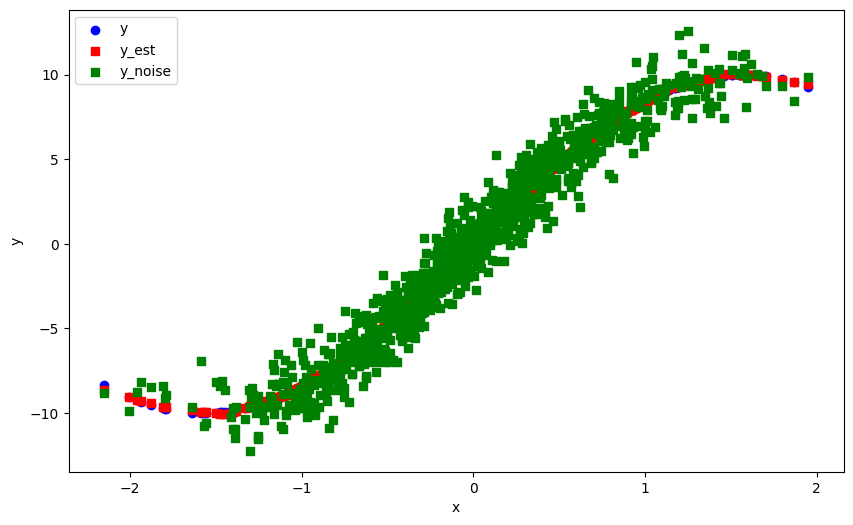

The programm is closed


In [12]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

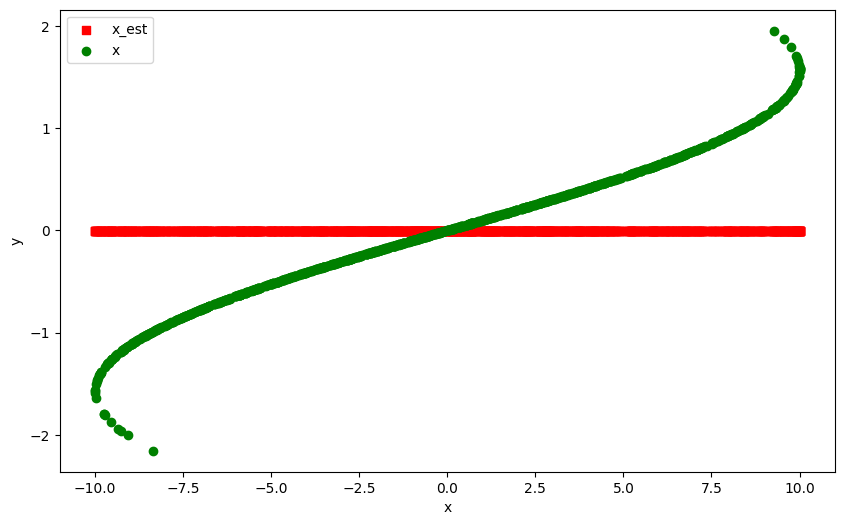

The programm is closed


In [13]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## no causal

In [14]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

### update all parameters together

In [15]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 148/29000 [00:00<01:27, 330.95it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0406]], grad_fn=<MmBackward0>)
obj:  tensor(2.2124, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2077, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


  1%|          | 260/29000 [00:00<01:20, 358.04it/s]

Sigma:  tensor([[0.9208, 0.0374],
        [0.0374, 1.0787]], grad_fn=<MmBackward0>)
obj:  tensor(1.9938, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9792, grad_fn=<AddBackward0>)
h_val:  tensor(0.0070, grad_fn=<AddBackward0>)


  1%|          | 333/29000 [00:01<01:22, 349.47it/s]

Sigma:  tensor([[0.8801, 0.0529],
        [0.0529, 1.1058]], grad_fn=<MmBackward0>)
obj:  tensor(1.7742, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7415, grad_fn=<AddBackward0>)
h_val:  tensor(0.0200, grad_fn=<AddBackward0>)


  2%|▏         | 435/29000 [00:01<01:33, 305.60it/s]

Sigma:  tensor([[0.8385, 0.0648],
        [0.0648, 1.1110]], grad_fn=<MmBackward0>)
obj:  tensor(1.5585, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4951, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)


  2%|▏         | 546/29000 [00:01<01:22, 343.18it/s]

Sigma:  tensor([[0.7966, 0.0721],
        [0.0721, 1.0903]], grad_fn=<MmBackward0>)
obj:  tensor(1.3535, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2419, grad_fn=<AddBackward0>)
h_val:  tensor(0.0864, grad_fn=<AddBackward0>)


  2%|▏         | 664/29000 [00:01<01:14, 377.88it/s]

Sigma:  tensor([[0.7553, 0.0741],
        [0.0741, 1.0508]], grad_fn=<MmBackward0>)
obj:  tensor(1.1655, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9848, grad_fn=<AddBackward0>)
h_val:  tensor(0.1493, grad_fn=<AddBackward0>)


  3%|▎         | 748/29000 [00:02<01:12, 389.95it/s]

Sigma:  tensor([[0.7150, 0.0709],
        [0.0709, 1.0020]], grad_fn=<MmBackward0>)
obj:  tensor(0.9981, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7265, grad_fn=<AddBackward0>)
h_val:  tensor(0.2351, grad_fn=<AddBackward0>)


  3%|▎         | 868/29000 [00:02<01:18, 360.55it/s]

Sigma:  tensor([[0.6763, 0.0642],
        [0.0642, 0.9503]], grad_fn=<MmBackward0>)
obj:  tensor(0.8596, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4785, grad_fn=<AddBackward0>)
h_val:  tensor(0.3409, grad_fn=<AddBackward0>)


  3%|▎         | 946/29000 [00:02<01:14, 374.39it/s]

Sigma:  tensor([[0.6395, 0.0563],
        [0.0563, 0.8991]], grad_fn=<MmBackward0>)
obj:  tensor(0.7586, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2655, grad_fn=<AddBackward0>)
h_val:  tensor(0.4509, grad_fn=<AddBackward0>)


  4%|▎         | 1068/29000 [00:03<01:14, 373.83it/s]

Sigma:  tensor([[0.6052, 0.0494],
        [0.0494, 0.8505]], grad_fn=<MmBackward0>)
obj:  tensor(0.6833, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1124, grad_fn=<AddBackward0>)
h_val:  tensor(0.5282, grad_fn=<AddBackward0>)


  4%|▍         | 1150/29000 [00:03<01:11, 388.69it/s]

Sigma:  tensor([[0.5736, 0.0446],
        [0.0446, 0.8056]], grad_fn=<MmBackward0>)
obj:  tensor(0.6084, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0164, grad_fn=<AddBackward0>)
h_val:  tensor(0.5496, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:10, 392.28it/s]

Sigma:  tensor([[0.5450, 0.0413],
        [0.0413, 0.7650]], grad_fn=<MmBackward0>)
obj:  tensor(0.5299, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0569, grad_fn=<AddBackward0>)
h_val:  tensor(0.5439, grad_fn=<AddBackward0>)


  5%|▍         | 1351/29000 [00:03<01:13, 373.93it/s]

Sigma:  tensor([[0.5189, 0.0378],
        [0.0378, 0.7283]], grad_fn=<MmBackward0>)
obj:  tensor(0.4535, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1423, grad_fn=<AddBackward0>)
h_val:  tensor(0.5518, grad_fn=<AddBackward0>)


  5%|▌         | 1467/29000 [00:04<01:12, 379.84it/s]

Sigma:  tensor([[0.4950, 0.0329],
        [0.0329, 0.6944]], grad_fn=<MmBackward0>)
obj:  tensor(0.3811, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2467, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)


  5%|▌         | 1544/29000 [00:04<01:16, 357.44it/s]

Sigma:  tensor([[0.4727, 0.0261],
        [0.0261, 0.6625]], grad_fn=<MmBackward0>)
obj:  tensor(0.3113, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3556, grad_fn=<AddBackward0>)
h_val:  tensor(0.6200, grad_fn=<AddBackward0>)


  6%|▌         | 1655/29000 [00:04<01:20, 339.80it/s]

Sigma:  tensor([[0.4517, 0.0179],
        [0.0179, 0.6323]], grad_fn=<MmBackward0>)
obj:  tensor(0.2420, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4561, grad_fn=<AddBackward0>)
h_val:  tensor(0.6502, grad_fn=<AddBackward0>)


  6%|▌         | 1771/29000 [00:04<01:16, 357.87it/s]

Sigma:  tensor([[0.4319, 0.0084],
        [0.0084, 0.6038]], grad_fn=<MmBackward0>)
obj:  tensor(0.1730, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5517, grad_fn=<AddBackward0>)
h_val:  tensor(0.6755, grad_fn=<AddBackward0>)


  6%|▋         | 1846/29000 [00:05<01:16, 355.64it/s]

Sigma:  tensor([[ 0.4132, -0.0026],
        [-0.0026,  0.5771]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6477, grad_fn=<AddBackward0>)
h_val:  tensor(0.7027, grad_fn=<AddBackward0>)


  7%|▋         | 1960/29000 [00:05<01:16, 351.66it/s]

Sigma:  tensor([[ 0.3955, -0.0148],
        [-0.0148,  0.5524]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7428, grad_fn=<AddBackward0>)
h_val:  tensor(0.7312, grad_fn=<AddBackward0>)


  7%|▋         | 2076/29000 [00:05<01:11, 374.18it/s]

Sigma:  tensor([[ 0.3787, -0.0280],
        [-0.0280,  0.5299]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0293, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8336, grad_fn=<AddBackward0>)
h_val:  tensor(0.7514, grad_fn=<AddBackward0>)


  7%|▋         | 2153/29000 [00:06<01:11, 374.77it/s]

Sigma:  tensor([[ 0.3627, -0.0418],
        [-0.0418,  0.5097]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0987, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9241, grad_fn=<AddBackward0>)
h_val:  tensor(0.7713, grad_fn=<AddBackward0>)


  8%|▊         | 2273/29000 [00:06<01:08, 388.99it/s]

Sigma:  tensor([[ 0.3475, -0.0559],
        [-0.0559,  0.4920]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1690, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0141, grad_fn=<AddBackward0>)
h_val:  tensor(0.7899, grad_fn=<AddBackward0>)


  8%|▊         | 2351/29000 [00:06<01:11, 371.53it/s]

Sigma:  tensor([[ 0.3331, -0.0701],
        [-0.0701,  0.4769]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2414, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1046, grad_fn=<AddBackward0>)
h_val:  tensor(0.8069, grad_fn=<AddBackward0>)


  9%|▊         | 2473/29000 [00:06<01:09, 383.54it/s]

Sigma:  tensor([[ 0.3193, -0.0841],
        [-0.0841,  0.4641]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3165, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1955, grad_fn=<AddBackward0>)
h_val:  tensor(0.8217, grad_fn=<AddBackward0>)


  9%|▉         | 2551/29000 [00:07<01:13, 360.21it/s]

Sigma:  tensor([[ 0.3062, -0.0976],
        [-0.0976,  0.4538]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3913, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2871, grad_fn=<AddBackward0>)
h_val:  tensor(0.8374, grad_fn=<AddBackward0>)


  9%|▉         | 2670/29000 [00:07<01:08, 385.57it/s]

Sigma:  tensor([[ 0.2937, -0.1106],
        [-0.1106,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4675, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3768, grad_fn=<AddBackward0>)
h_val:  tensor(0.8499, grad_fn=<AddBackward0>)


  9%|▉         | 2748/29000 [00:07<01:10, 373.56it/s]

Sigma:  tensor([[ 0.2817, -0.1230],
        [-0.1230,  0.4401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5453, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4689, grad_fn=<AddBackward0>)
h_val:  tensor(0.8633, grad_fn=<AddBackward0>)


 10%|▉         | 2852/29000 [00:08<01:38, 266.57it/s]

Sigma:  tensor([[ 0.2702, -0.1347],
        [-0.1347,  0.4364]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6234, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5595, grad_fn=<AddBackward0>)
h_val:  tensor(0.8750, grad_fn=<AddBackward0>)


 10%|█         | 2969/29000 [00:08<01:15, 342.69it/s]

Sigma:  tensor([[ 0.2593, -0.1458],
        [-0.1458,  0.4347]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7025, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6511, grad_fn=<AddBackward0>)
h_val:  tensor(0.8866, grad_fn=<AddBackward0>)


 11%|█         | 3047/29000 [00:08<01:11, 364.31it/s]

Sigma:  tensor([[ 0.2488, -0.1561],
        [-0.1561,  0.4350]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7830, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7411, grad_fn=<AddBackward0>)
h_val:  tensor(0.8953, grad_fn=<AddBackward0>)


 11%|█         | 3170/29000 [00:08<01:06, 387.17it/s]

Sigma:  tensor([[ 0.2388, -0.1658],
        [-0.1658,  0.4370]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8644, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8344, grad_fn=<AddBackward0>)
h_val:  tensor(0.9066, grad_fn=<AddBackward0>)


 11%|█         | 3251/29000 [00:09<01:06, 387.21it/s]

Sigma:  tensor([[ 0.2292, -0.1747],
        [-0.1747,  0.4406]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9459, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9254, grad_fn=<AddBackward0>)
h_val:  tensor(0.9154, grad_fn=<AddBackward0>)


 12%|█▏        | 3377/29000 [00:09<01:04, 396.79it/s]

Sigma:  tensor([[ 0.2199, -0.1830],
        [-0.1830,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0283, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0163, grad_fn=<AddBackward0>)
h_val:  tensor(0.9233, grad_fn=<AddBackward0>)


 12%|█▏        | 3456/29000 [00:09<01:10, 363.52it/s]

Sigma:  tensor([[ 0.2111, -0.1906],
        [-0.1906,  0.4525]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1103, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1080, grad_fn=<AddBackward0>)
h_val:  tensor(0.9324, grad_fn=<AddBackward0>)


 12%|█▏        | 3576/29000 [00:10<01:06, 384.51it/s]

Sigma:  tensor([[ 0.2027, -0.1976],
        [-0.1976,  0.4605]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1931, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2004, grad_fn=<AddBackward0>)
h_val:  tensor(0.9414, grad_fn=<AddBackward0>)


 13%|█▎        | 3654/29000 [00:10<01:08, 371.98it/s]

Sigma:  tensor([[ 0.1945, -0.2041],
        [-0.2041,  0.4697]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2762, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2917, grad_fn=<AddBackward0>)
h_val:  tensor(0.9492, grad_fn=<AddBackward0>)


 13%|█▎        | 3776/29000 [00:10<01:03, 395.76it/s]

Sigma:  tensor([[ 0.1868, -0.2099],
        [-0.2099,  0.4802]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3592, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3838, grad_fn=<AddBackward0>)
h_val:  tensor(0.9578, grad_fn=<AddBackward0>)


 13%|█▎        | 3855/29000 [00:10<01:05, 386.61it/s]

Sigma:  tensor([[ 0.1793, -0.2152],
        [-0.2152,  0.4916]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4408, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4749, grad_fn=<AddBackward0>)
h_val:  tensor(0.9668, grad_fn=<AddBackward0>)


 14%|█▎        | 3975/29000 [00:11<01:06, 376.09it/s]

Sigma:  tensor([[ 0.1721, -0.2200],
        [-0.2200,  0.5042]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5229, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5658, grad_fn=<AddBackward0>)
h_val:  tensor(0.9751, grad_fn=<AddBackward0>)


 14%|█▍        | 4053/29000 [00:11<01:05, 380.58it/s]

Sigma:  tensor([[ 0.1652, -0.2244],
        [-0.2244,  0.5176]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6034, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6557, grad_fn=<AddBackward0>)
h_val:  tensor(0.9841, grad_fn=<AddBackward0>)


 14%|█▍        | 4173/29000 [00:11<01:05, 380.20it/s]

Sigma:  tensor([[ 0.1587, -0.2283],
        [-0.2283,  0.5320]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6843, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7459, grad_fn=<AddBackward0>)
h_val:  tensor(0.9930, grad_fn=<AddBackward0>)


 15%|█▍        | 4252/29000 [00:11<01:04, 382.52it/s]

Sigma:  tensor([[ 0.1523, -0.2317],
        [-0.2317,  0.5471]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7654, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8355, grad_fn=<AddBackward0>)
h_val:  tensor(1.0011, grad_fn=<AddBackward0>)


 15%|█▌        | 4375/29000 [00:12<01:03, 390.62it/s]

Sigma:  tensor([[ 0.1463, -0.2348],
        [-0.2348,  0.5629]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8451, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9239, grad_fn=<AddBackward0>)
h_val:  tensor(1.0095, grad_fn=<AddBackward0>)


 15%|█▌        | 4454/29000 [00:12<01:03, 387.75it/s]

Sigma:  tensor([[ 0.1405, -0.2375],
        [-0.2375,  0.5794]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9248, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0130, grad_fn=<AddBackward0>)
h_val:  tensor(1.0186, grad_fn=<AddBackward0>)


 16%|█▌        | 4534/29000 [00:12<01:07, 364.90it/s]

Sigma:  tensor([[ 0.1349, -0.2398],
        [-0.2398,  0.5966]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1018, grad_fn=<AddBackward0>)
h_val:  tensor(1.0294, grad_fn=<AddBackward0>)


 16%|█▌        | 4661/29000 [00:12<01:02, 389.52it/s]

Sigma:  tensor([[ 0.1296, -0.2419],
        [-0.2419,  0.6143]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0816, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1893, grad_fn=<AddBackward0>)
h_val:  tensor(1.0376, grad_fn=<AddBackward0>)


 16%|█▋        | 4740/29000 [00:13<01:03, 383.44it/s]

Sigma:  tensor([[ 0.1244, -0.2436],
        [-0.2436,  0.6325]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1591, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2771, grad_fn=<AddBackward0>)
h_val:  tensor(1.0475, grad_fn=<AddBackward0>)


 17%|█▋        | 4857/29000 [00:13<01:04, 375.66it/s]

Sigma:  tensor([[ 0.1195, -0.2450],
        [-0.2450,  0.6513]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3645, grad_fn=<AddBackward0>)
h_val:  tensor(1.0576, grad_fn=<AddBackward0>)


 17%|█▋        | 4934/29000 [00:13<01:07, 357.57it/s]

Sigma:  tensor([[ 0.1148, -0.2462],
        [-0.2462,  0.6705]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4514, grad_fn=<AddBackward0>)
h_val:  tensor(1.0683, grad_fn=<AddBackward0>)


 17%|█▋        | 5060/29000 [00:13<01:01, 386.55it/s]

Sigma:  tensor([[ 0.1103, -0.2471],
        [-0.2471,  0.6902]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3887, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5382, grad_fn=<AddBackward0>)
h_val:  tensor(1.0782, grad_fn=<AddBackward0>)


 18%|█▊        | 5182/29000 [00:14<00:59, 399.85it/s]

Sigma:  tensor([[ 0.1060, -0.2478],
        [-0.2478,  0.7103]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4641, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6245, grad_fn=<AddBackward0>)
h_val:  tensor(1.0887, grad_fn=<AddBackward0>)


 18%|█▊        | 5265/29000 [00:14<00:59, 401.29it/s]

Sigma:  tensor([[ 0.1018, -0.2482],
        [-0.2482,  0.7308]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5386, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7106, grad_fn=<AddBackward0>)
h_val:  tensor(1.1001, grad_fn=<AddBackward0>)


 18%|█▊        | 5346/29000 [00:14<01:00, 391.84it/s]

Sigma:  tensor([[ 0.0978, -0.2485],
        [-0.2485,  0.7517]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6135, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7963, grad_fn=<AddBackward0>)
h_val:  tensor(1.1107, grad_fn=<AddBackward0>)


 19%|█▉        | 5475/29000 [00:14<00:57, 406.79it/s]

Sigma:  tensor([[ 0.0940, -0.2486],
        [-0.2486,  0.7729]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6877, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8818, grad_fn=<AddBackward0>)
h_val:  tensor(1.1217, grad_fn=<AddBackward0>)


 19%|█▉        | 5557/29000 [00:15<00:59, 391.44it/s]

Sigma:  tensor([[ 0.0903, -0.2485],
        [-0.2485,  0.7945]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7612, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9670, grad_fn=<AddBackward0>)
h_val:  tensor(1.1332, grad_fn=<AddBackward0>)


 20%|█▉        | 5683/29000 [00:15<00:57, 408.02it/s]

Sigma:  tensor([[ 0.0868, -0.2483],
        [-0.2483,  0.8164]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8343, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0521, grad_fn=<AddBackward0>)
h_val:  tensor(1.1450, grad_fn=<AddBackward0>)


 20%|█▉        | 5765/29000 [00:15<00:57, 403.01it/s]

Sigma:  tensor([[ 0.0834, -0.2479],
        [-0.2479,  0.8387]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9071, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1368, grad_fn=<AddBackward0>)
h_val:  tensor(1.1566, grad_fn=<AddBackward0>)


 20%|██        | 5847/29000 [00:15<00:58, 399.04it/s]

Sigma:  tensor([[ 0.0801, -0.2474],
        [-0.2474,  0.8612]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9791, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2213, grad_fn=<AddBackward0>)
h_val:  tensor(1.1689, grad_fn=<AddBackward0>)


 21%|██        | 5977/29000 [00:16<00:55, 413.54it/s]

Sigma:  tensor([[ 0.0770, -0.2467],
        [-0.2467,  0.8840]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0509, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3057, grad_fn=<AddBackward0>)
h_val:  tensor(1.1812, grad_fn=<AddBackward0>)


 21%|██        | 6060/29000 [00:16<00:56, 406.26it/s]

Sigma:  tensor([[ 0.0740, -0.2460],
        [-0.2460,  0.9072]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1228, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3895, grad_fn=<AddBackward0>)
h_val:  tensor(1.1930, grad_fn=<AddBackward0>)


 21%|██        | 6141/29000 [00:16<00:57, 399.02it/s]

Sigma:  tensor([[ 0.0711, -0.2451],
        [-0.2451,  0.9306]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1940, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4733, grad_fn=<AddBackward0>)
h_val:  tensor(1.2053, grad_fn=<AddBackward0>)


 22%|██▏       | 6274/29000 [00:16<00:54, 413.75it/s]

Sigma:  tensor([[ 0.0683, -0.2441],
        [-0.2441,  0.9543]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2647, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5570, grad_fn=<AddBackward0>)
h_val:  tensor(1.2181, grad_fn=<AddBackward0>)


 22%|██▏       | 6357/29000 [00:17<00:55, 406.01it/s]

Sigma:  tensor([[ 0.0657, -0.2430],
        [-0.2430,  0.9783]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3352, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6405, grad_fn=<AddBackward0>)
h_val:  tensor(1.2308, grad_fn=<AddBackward0>)


 22%|██▏       | 6482/29000 [00:17<00:54, 412.19it/s]

Sigma:  tensor([[ 0.0631, -0.2419],
        [-0.2419,  1.0025]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4057, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7237, grad_fn=<AddBackward0>)
h_val:  tensor(1.2433, grad_fn=<AddBackward0>)


 23%|██▎       | 6564/29000 [00:17<00:56, 394.23it/s]

Sigma:  tensor([[ 0.0607, -0.2406],
        [-0.2406,  1.0271]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4756, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8067, grad_fn=<AddBackward0>)
h_val:  tensor(1.2562, grad_fn=<AddBackward0>)


 23%|██▎       | 6643/29000 [00:17<00:58, 381.20it/s]

Sigma:  tensor([[ 0.0583, -0.2393],
        [-0.2393,  1.0519]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5444, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8897, grad_fn=<AddBackward0>)
h_val:  tensor(1.2702, grad_fn=<AddBackward0>)


 23%|██▎       | 6770/29000 [00:18<00:55, 397.01it/s]

Sigma:  tensor([[ 0.0560, -0.2379],
        [-0.2379,  1.0769]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6139, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9724, grad_fn=<AddBackward0>)
h_val:  tensor(1.2832, grad_fn=<AddBackward0>)


 24%|██▎       | 6851/29000 [00:18<00:57, 387.87it/s]

Sigma:  tensor([[ 0.0539, -0.2365],
        [-0.2365,  1.1022]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6831, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0551, grad_fn=<AddBackward0>)
h_val:  tensor(1.2964, grad_fn=<AddBackward0>)


 24%|██▍       | 6970/29000 [00:18<01:00, 364.12it/s]

Sigma:  tensor([[ 0.0518, -0.2349],
        [-0.2349,  1.1278]], grad_fn=<MmBackward0>)
obj:  tensor(-3.7514, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1377, grad_fn=<AddBackward0>)
h_val:  tensor(1.3105, grad_fn=<AddBackward0>)


 25%|██▍       | 7169/29000 [00:19<00:55, 390.06it/s]

Sigma:  tensor([[ 0.0499, -0.2305],
        [-0.2305,  1.1223]], grad_fn=<MmBackward0>)
obj:  tensor(0.6058, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6982, grad_fn=<AddBackward0>)
h_val:  tensor(0.9683, grad_fn=<AddBackward0>)


 25%|██▌       | 7252/29000 [00:19<00:55, 394.61it/s]

Sigma:  tensor([[ 0.0518, -0.2302],
        [-0.2302,  1.0806]], grad_fn=<MmBackward0>)
obj:  tensor(0.5132, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3224, grad_fn=<AddBackward0>)
h_val:  tensor(0.9379, grad_fn=<AddBackward0>)


 25%|██▌       | 7341/29000 [00:19<00:52, 415.01it/s]

Sigma:  tensor([[ 0.0532, -0.2294],
        [-0.2294,  1.0445]], grad_fn=<MmBackward0>)
obj:  tensor(0.4653, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9343, grad_fn=<AddBackward0>)
h_val:  tensor(0.8510, grad_fn=<AddBackward0>)


 26%|██▌       | 7469/29000 [00:20<00:53, 401.30it/s]

Sigma:  tensor([[ 0.0548, -0.2285],
        [-0.2285,  1.0069]], grad_fn=<MmBackward0>)
obj:  tensor(0.4343, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8816, grad_fn=<AddBackward0>)
h_val:  tensor(0.8143, grad_fn=<AddBackward0>)


 26%|██▌       | 7548/29000 [00:20<01:00, 357.07it/s]

Sigma:  tensor([[ 0.0562, -0.2273],
        [-0.2273,  0.9706]], grad_fn=<MmBackward0>)
obj:  tensor(0.4134, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8051, grad_fn=<AddBackward0>)
h_val:  tensor(0.7855, grad_fn=<AddBackward0>)


 26%|██▋       | 7661/29000 [00:20<01:23, 255.90it/s]

Sigma:  tensor([[ 0.0576, -0.2257],
        [-0.2257,  0.9352]], grad_fn=<MmBackward0>)
obj:  tensor(0.3992, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7259, grad_fn=<AddBackward0>)
h_val:  tensor(0.7633, grad_fn=<AddBackward0>)


 27%|██▋       | 7777/29000 [00:21<01:03, 331.74it/s]

Sigma:  tensor([[ 0.0588, -0.2239],
        [-0.2239,  0.9005]], grad_fn=<MmBackward0>)
obj:  tensor(0.3863, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6841, grad_fn=<AddBackward0>)
h_val:  tensor(0.7462, grad_fn=<AddBackward0>)


 27%|██▋       | 7855/29000 [00:21<00:58, 359.43it/s]

Sigma:  tensor([[ 0.0601, -0.2221],
        [-0.2221,  0.8668]], grad_fn=<MmBackward0>)
obj:  tensor(0.3737, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6734, grad_fn=<AddBackward0>)
h_val:  tensor(0.7325, grad_fn=<AddBackward0>)


 28%|██▊       | 7978/29000 [00:21<00:54, 388.64it/s]

Sigma:  tensor([[ 0.0615, -0.2203],
        [-0.2203,  0.8342]], grad_fn=<MmBackward0>)
obj:  tensor(0.3617, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6857, grad_fn=<AddBackward0>)
h_val:  tensor(0.7218, grad_fn=<AddBackward0>)


 28%|██▊       | 8057/29000 [00:21<00:54, 383.31it/s]

Sigma:  tensor([[ 0.0629, -0.2187],
        [-0.2187,  0.8025]], grad_fn=<MmBackward0>)
obj:  tensor(0.3499, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7043, grad_fn=<AddBackward0>)
h_val:  tensor(0.7120, grad_fn=<AddBackward0>)


 28%|██▊       | 8173/29000 [00:22<00:55, 376.74it/s]

Sigma:  tensor([[ 0.0645, -0.2172],
        [-0.2172,  0.7719]], grad_fn=<MmBackward0>)
obj:  tensor(0.3387, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7037, grad_fn=<AddBackward0>)
h_val:  tensor(0.7008, grad_fn=<AddBackward0>)


 28%|██▊       | 8250/29000 [00:22<00:57, 363.71it/s]

Sigma:  tensor([[ 0.0662, -0.2158],
        [-0.2158,  0.7423]], grad_fn=<MmBackward0>)
obj:  tensor(0.3278, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7044, grad_fn=<AddBackward0>)
h_val:  tensor(0.6900, grad_fn=<AddBackward0>)


 29%|██▉       | 8370/29000 [00:22<00:53, 385.02it/s]

Sigma:  tensor([[ 0.0680, -0.2144],
        [-0.2144,  0.7138]], grad_fn=<MmBackward0>)
obj:  tensor(0.3172, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7013, grad_fn=<AddBackward0>)
h_val:  tensor(0.6791, grad_fn=<AddBackward0>)


 29%|██▉       | 8447/29000 [00:22<00:55, 368.62it/s]

Sigma:  tensor([[ 0.0699, -0.2132],
        [-0.2132,  0.6864]], grad_fn=<MmBackward0>)
obj:  tensor(0.3068, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6968, grad_fn=<AddBackward0>)
h_val:  tensor(0.6684, grad_fn=<AddBackward0>)


 30%|██▉       | 8574/29000 [00:23<00:51, 393.67it/s]

Sigma:  tensor([[ 0.0719, -0.2121],
        [-0.2121,  0.6602]], grad_fn=<MmBackward0>)
obj:  tensor(0.2968, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6962, grad_fn=<AddBackward0>)
h_val:  tensor(0.6584, grad_fn=<AddBackward0>)


 30%|██▉       | 8655/29000 [00:23<00:51, 394.23it/s]

Sigma:  tensor([[ 0.0740, -0.2110],
        [-0.2110,  0.6351]], grad_fn=<MmBackward0>)
obj:  tensor(0.2871, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6988, grad_fn=<AddBackward0>)
h_val:  tensor(0.6490, grad_fn=<AddBackward0>)


 30%|███       | 8781/29000 [00:23<00:49, 404.81it/s]

Sigma:  tensor([[ 0.0762, -0.2100],
        [-0.2100,  0.6110]], grad_fn=<MmBackward0>)
obj:  tensor(0.2779, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7021, grad_fn=<AddBackward0>)
h_val:  tensor(0.6402, grad_fn=<AddBackward0>)


 31%|███       | 8863/29000 [00:23<00:50, 399.77it/s]

Sigma:  tensor([[ 0.0785, -0.2091],
        [-0.2091,  0.5881]], grad_fn=<MmBackward0>)
obj:  tensor(0.2690, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7051, grad_fn=<AddBackward0>)
h_val:  tensor(0.6316, grad_fn=<AddBackward0>)


 31%|███       | 8944/29000 [00:24<00:51, 392.63it/s]

Sigma:  tensor([[ 0.0809, -0.2083],
        [-0.2083,  0.5663]], grad_fn=<MmBackward0>)
obj:  tensor(0.2605, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7083, grad_fn=<AddBackward0>)
h_val:  tensor(0.6235, grad_fn=<AddBackward0>)


 31%|███▏      | 9074/29000 [00:24<00:48, 409.99it/s]

Sigma:  tensor([[ 0.0833, -0.2076],
        [-0.2076,  0.5457]], grad_fn=<MmBackward0>)
obj:  tensor(0.2524, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7120, grad_fn=<AddBackward0>)
h_val:  tensor(0.6159, grad_fn=<AddBackward0>)


 32%|███▏      | 9157/29000 [00:24<00:49, 401.89it/s]

Sigma:  tensor([[ 0.0858, -0.2069],
        [-0.2069,  0.5261]], grad_fn=<MmBackward0>)
obj:  tensor(0.2447, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7166, grad_fn=<AddBackward0>)
h_val:  tensor(0.6087, grad_fn=<AddBackward0>)


 32%|███▏      | 9281/29000 [00:24<00:48, 405.64it/s]

Sigma:  tensor([[ 0.0885, -0.2064],
        [-0.2064,  0.5078]], grad_fn=<MmBackward0>)
obj:  tensor(0.2375, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7225, grad_fn=<AddBackward0>)
h_val:  tensor(0.6021, grad_fn=<AddBackward0>)


 32%|███▏      | 9363/29000 [00:25<00:50, 388.84it/s]

Sigma:  tensor([[ 0.0911, -0.2059],
        [-0.2059,  0.4905]], grad_fn=<MmBackward0>)
obj:  tensor(0.2303, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7290, grad_fn=<AddBackward0>)
h_val:  tensor(0.5956, grad_fn=<AddBackward0>)


 33%|███▎      | 9442/29000 [00:25<00:50, 388.46it/s]

Sigma:  tensor([[ 0.0939, -0.2056],
        [-0.2056,  0.4745]], grad_fn=<MmBackward0>)
obj:  tensor(0.2239, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7372, grad_fn=<AddBackward0>)
h_val:  tensor(0.5901, grad_fn=<AddBackward0>)


 33%|███▎      | 9572/29000 [00:25<00:47, 410.98it/s]

Sigma:  tensor([[ 0.0966, -0.2053],
        [-0.2053,  0.4596]], grad_fn=<MmBackward0>)
obj:  tensor(0.2179, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7447, grad_fn=<AddBackward0>)
h_val:  tensor(0.5849, grad_fn=<AddBackward0>)


 33%|███▎      | 9656/29000 [00:25<00:47, 406.49it/s]

Sigma:  tensor([[ 0.0995, -0.2052],
        [-0.2052,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(0.2121, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7581, grad_fn=<AddBackward0>)
h_val:  tensor(0.5805, grad_fn=<AddBackward0>)


 34%|███▎      | 9782/29000 [00:26<00:46, 411.83it/s]

Sigma:  tensor([[ 0.1023, -0.2053],
        [-0.2053,  0.4333]], grad_fn=<MmBackward0>)
obj:  tensor(0.2065, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7726, grad_fn=<AddBackward0>)
h_val:  tensor(0.5764, grad_fn=<AddBackward0>)


 34%|███▍      | 9865/29000 [00:26<00:47, 402.30it/s]

Sigma:  tensor([[ 0.1052, -0.2054],
        [-0.2054,  0.4218]], grad_fn=<MmBackward0>)
obj:  tensor(0.2013, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5727, grad_fn=<AddBackward0>)


 34%|███▍      | 9947/29000 [00:26<00:47, 398.98it/s]

Sigma:  tensor([[ 0.1081, -0.2058],
        [-0.2058,  0.4114]], grad_fn=<MmBackward0>)
obj:  tensor(0.1964, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8058, grad_fn=<AddBackward0>)
h_val:  tensor(0.5696, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:46, 408.65it/s]

Sigma:  tensor([[ 0.1110, -0.2062],
        [-0.2062,  0.4022]], grad_fn=<MmBackward0>)
obj:  tensor(0.1917, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8256, grad_fn=<AddBackward0>)
h_val:  tensor(0.5669, grad_fn=<AddBackward0>)


 35%|███▌      | 10157/29000 [00:27<00:47, 400.59it/s]

Sigma:  tensor([[ 0.1139, -0.2069],
        [-0.2069,  0.3940]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8482, grad_fn=<AddBackward0>)
h_val:  tensor(0.5648, grad_fn=<AddBackward0>)


 35%|███▌      | 10284/29000 [00:27<00:45, 413.95it/s]

Sigma:  tensor([[ 0.1168, -0.2076],
        [-0.2076,  0.3868]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8726, grad_fn=<AddBackward0>)
h_val:  tensor(0.5631, grad_fn=<AddBackward0>)


 36%|███▌      | 10367/29000 [00:27<00:46, 396.76it/s]

Sigma:  tensor([[ 0.1196, -0.2086],
        [-0.2086,  0.3806]], grad_fn=<MmBackward0>)
obj:  tensor(0.1787, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9002, grad_fn=<AddBackward0>)
h_val:  tensor(0.5615, grad_fn=<AddBackward0>)


 36%|███▌      | 10447/29000 [00:27<00:47, 394.25it/s]

Sigma:  tensor([[ 0.1224, -0.2096],
        [-0.2096,  0.3752]], grad_fn=<MmBackward0>)
obj:  tensor(0.1750, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9305, grad_fn=<AddBackward0>)
h_val:  tensor(0.5608, grad_fn=<AddBackward0>)


 36%|███▋      | 10574/29000 [00:28<00:45, 405.05it/s]

Sigma:  tensor([[ 0.1252, -0.2108],
        [-0.2108,  0.3707]], grad_fn=<MmBackward0>)
obj:  tensor(0.1712, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9627, grad_fn=<AddBackward0>)
h_val:  tensor(0.5603, grad_fn=<AddBackward0>)


 37%|███▋      | 10655/29000 [00:28<00:46, 397.50it/s]

Sigma:  tensor([[ 0.1278, -0.2121],
        [-0.2121,  0.3670]], grad_fn=<MmBackward0>)
obj:  tensor(0.1675, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.5601, grad_fn=<AddBackward0>)


 37%|███▋      | 10781/29000 [00:28<00:44, 412.30it/s]

Sigma:  tensor([[ 0.1304, -0.2135],
        [-0.2135,  0.3639]], grad_fn=<MmBackward0>)
obj:  tensor(0.1635, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0329, grad_fn=<AddBackward0>)
h_val:  tensor(0.5596, grad_fn=<AddBackward0>)


 37%|███▋      | 10864/29000 [00:28<00:45, 402.85it/s]

Sigma:  tensor([[ 0.1328, -0.2149],
        [-0.2149,  0.3613]], grad_fn=<MmBackward0>)
obj:  tensor(0.1600, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0715, grad_fn=<AddBackward0>)
h_val:  tensor(0.5600, grad_fn=<AddBackward0>)


 38%|███▊      | 10946/29000 [00:29<00:45, 397.93it/s]

Sigma:  tensor([[ 0.1352, -0.2163],
        [-0.2163,  0.3592]], grad_fn=<MmBackward0>)
obj:  tensor(0.1567, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1108, grad_fn=<AddBackward0>)
h_val:  tensor(0.5606, grad_fn=<AddBackward0>)


 38%|███▊      | 11075/29000 [00:29<00:43, 410.29it/s]

Sigma:  tensor([[ 0.1374, -0.2177],
        [-0.2177,  0.3576]], grad_fn=<MmBackward0>)
obj:  tensor(0.1530, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1519, grad_fn=<AddBackward0>)
h_val:  tensor(0.5610, grad_fn=<AddBackward0>)


 38%|███▊      | 11158/29000 [00:29<00:45, 392.79it/s]

Sigma:  tensor([[ 0.1394, -0.2190],
        [-0.2190,  0.3563]], grad_fn=<MmBackward0>)
obj:  tensor(0.1495, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1939, grad_fn=<AddBackward0>)
h_val:  tensor(0.5617, grad_fn=<AddBackward0>)


 39%|███▉      | 11282/29000 [00:29<00:44, 402.57it/s]

Sigma:  tensor([[ 0.1413, -0.2203],
        [-0.2203,  0.3553]], grad_fn=<MmBackward0>)
obj:  tensor(0.1461, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2367, grad_fn=<AddBackward0>)
h_val:  tensor(0.5627, grad_fn=<AddBackward0>)


 39%|███▉      | 11364/29000 [00:30<00:44, 400.09it/s]

Sigma:  tensor([[ 0.1430, -0.2216],
        [-0.2216,  0.3546]], grad_fn=<MmBackward0>)
obj:  tensor(0.1426, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2814, grad_fn=<AddBackward0>)
h_val:  tensor(0.5636, grad_fn=<AddBackward0>)


 39%|███▉      | 11446/29000 [00:30<00:44, 395.76it/s]

Sigma:  tensor([[ 0.1445, -0.2227],
        [-0.2227,  0.3540]], grad_fn=<MmBackward0>)
obj:  tensor(0.1390, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3258, grad_fn=<AddBackward0>)
h_val:  tensor(0.5644, grad_fn=<AddBackward0>)


 40%|███▉      | 11577/29000 [00:30<00:42, 410.36it/s]

Sigma:  tensor([[ 0.1458, -0.2237],
        [-0.2237,  0.3536]], grad_fn=<MmBackward0>)
obj:  tensor(0.1357, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3715, grad_fn=<AddBackward0>)
h_val:  tensor(0.5657, grad_fn=<AddBackward0>)


 40%|████      | 11660/29000 [00:30<00:42, 405.52it/s]

Sigma:  tensor([[ 0.1469, -0.2246],
        [-0.2246,  0.3533]], grad_fn=<MmBackward0>)
obj:  tensor(0.1323, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4173, grad_fn=<AddBackward0>)
h_val:  tensor(0.5669, grad_fn=<AddBackward0>)


 40%|████      | 11742/29000 [00:31<00:43, 400.42it/s]

Sigma:  tensor([[ 0.1479, -0.2254],
        [-0.2254,  0.3530]], grad_fn=<MmBackward0>)
obj:  tensor(0.1287, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4639, grad_fn=<AddBackward0>)
h_val:  tensor(0.5679, grad_fn=<AddBackward0>)


 41%|████      | 11874/29000 [00:31<00:41, 417.08it/s]

Sigma:  tensor([[ 0.1486, -0.2260],
        [-0.2260,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1252, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5109, grad_fn=<AddBackward0>)
h_val:  tensor(0.5691, grad_fn=<AddBackward0>)


 41%|████      | 11957/29000 [00:31<00:41, 406.58it/s]

Sigma:  tensor([[ 0.1492, -0.2266],
        [-0.2266,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1217, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5578, grad_fn=<AddBackward0>)
h_val:  tensor(0.5704, grad_fn=<AddBackward0>)


 42%|████▏     | 12039/29000 [00:31<00:43, 386.23it/s]

Sigma:  tensor([[ 0.1496, -0.2270],
        [-0.2270,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1181, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6053, grad_fn=<AddBackward0>)
h_val:  tensor(0.5715, grad_fn=<AddBackward0>)


 42%|████▏     | 12167/29000 [00:32<00:41, 401.15it/s]

Sigma:  tensor([[ 0.1498, -0.2273],
        [-0.2273,  0.3530]], grad_fn=<MmBackward0>)
obj:  tensor(0.1145, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6530, grad_fn=<AddBackward0>)
h_val:  tensor(0.5726, grad_fn=<AddBackward0>)


 42%|████▏     | 12248/29000 [00:32<00:42, 392.75it/s]

Sigma:  tensor([[ 0.1500, -0.2276],
        [-0.2276,  0.3531]], grad_fn=<MmBackward0>)
obj:  tensor(0.1109, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7008, grad_fn=<AddBackward0>)
h_val:  tensor(0.5738, grad_fn=<AddBackward0>)


 43%|████▎     | 12370/29000 [00:32<00:42, 389.73it/s]

Sigma:  tensor([[ 0.1499, -0.2277],
        [-0.2277,  0.3533]], grad_fn=<MmBackward0>)
obj:  tensor(0.1073, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7489, grad_fn=<AddBackward0>)
h_val:  tensor(0.5751, grad_fn=<AddBackward0>)


 43%|████▎     | 12450/29000 [00:32<00:42, 390.03it/s]

Sigma:  tensor([[ 0.1498, -0.2278],
        [-0.2278,  0.3536]], grad_fn=<MmBackward0>)
obj:  tensor(0.1034, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7974, grad_fn=<AddBackward0>)
h_val:  tensor(0.5759, grad_fn=<AddBackward0>)


 43%|████▎     | 12579/29000 [00:33<00:39, 411.53it/s]

Sigma:  tensor([[ 0.1496, -0.2278],
        [-0.2278,  0.3538]], grad_fn=<MmBackward0>)
obj:  tensor(0.0999, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8456, grad_fn=<AddBackward0>)
h_val:  tensor(0.5773, grad_fn=<AddBackward0>)


 44%|████▎     | 12662/29000 [00:33<00:40, 402.67it/s]

Sigma:  tensor([[ 0.1493, -0.2278],
        [-0.2278,  0.3541]], grad_fn=<MmBackward0>)
obj:  tensor(0.0958, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8937, grad_fn=<AddBackward0>)
h_val:  tensor(0.5780, grad_fn=<AddBackward0>)


 44%|████▍     | 12743/29000 [00:33<00:41, 396.35it/s]

Sigma:  tensor([[ 0.1490, -0.2277],
        [-0.2277,  0.3544]], grad_fn=<MmBackward0>)
obj:  tensor(0.0923, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9418, grad_fn=<AddBackward0>)
h_val:  tensor(0.5793, grad_fn=<AddBackward0>)


 44%|████▍     | 12876/29000 [00:33<00:39, 406.06it/s]

Sigma:  tensor([[ 0.1486, -0.2276],
        [-0.2276,  0.3548]], grad_fn=<MmBackward0>)
obj:  tensor(0.0888, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9897, grad_fn=<AddBackward0>)
h_val:  tensor(0.5806, grad_fn=<AddBackward0>)


 45%|████▍     | 12958/29000 [00:34<00:40, 399.33it/s]

Sigma:  tensor([[ 0.1482, -0.2275],
        [-0.2275,  0.3551]], grad_fn=<MmBackward0>)
obj:  tensor(0.0848, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0375, grad_fn=<AddBackward0>)
h_val:  tensor(0.5814, grad_fn=<AddBackward0>)


 45%|████▍     | 13040/29000 [00:34<00:40, 396.29it/s]

Sigma:  tensor([[ 0.1478, -0.2274],
        [-0.2274,  0.3554]], grad_fn=<MmBackward0>)
obj:  tensor(0.0810, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0851, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)


 45%|████▌     | 13170/29000 [00:34<00:38, 408.56it/s]

Sigma:  tensor([[ 0.1473, -0.2272],
        [-0.2272,  0.3558]], grad_fn=<MmBackward0>)
obj:  tensor(0.0773, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1326, grad_fn=<AddBackward0>)
h_val:  tensor(0.5833, grad_fn=<AddBackward0>)


 46%|████▌     | 13252/29000 [00:34<00:39, 403.11it/s]

Sigma:  tensor([[ 0.1469, -0.2271],
        [-0.2271,  0.3561]], grad_fn=<MmBackward0>)
obj:  tensor(0.0735, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1797, grad_fn=<AddBackward0>)
h_val:  tensor(0.5843, grad_fn=<AddBackward0>)


 46%|████▌     | 13380/29000 [00:35<00:37, 411.62it/s]

Sigma:  tensor([[ 0.1465, -0.2269],
        [-0.2269,  0.3564]], grad_fn=<MmBackward0>)
obj:  tensor(0.0698, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2269, grad_fn=<AddBackward0>)
h_val:  tensor(0.5853, grad_fn=<AddBackward0>)


 46%|████▋     | 13464/29000 [00:35<00:38, 406.88it/s]

Sigma:  tensor([[ 0.1461, -0.2268],
        [-0.2268,  0.3567]], grad_fn=<MmBackward0>)
obj:  tensor(0.0658, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2732, grad_fn=<AddBackward0>)
h_val:  tensor(0.5859, grad_fn=<AddBackward0>)


 47%|████▋     | 13546/29000 [00:35<00:39, 386.50it/s]

Sigma:  tensor([[ 0.1457, -0.2266],
        [-0.2266,  0.3570]], grad_fn=<MmBackward0>)
obj:  tensor(0.0621, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3198, grad_fn=<AddBackward0>)
h_val:  tensor(0.5868, grad_fn=<AddBackward0>)


 47%|████▋     | 13674/29000 [00:35<00:37, 410.60it/s]

Sigma:  tensor([[ 0.1454, -0.2265],
        [-0.2265,  0.3573]], grad_fn=<MmBackward0>)
obj:  tensor(0.0582, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3662, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 47%|████▋     | 13757/29000 [00:36<00:37, 405.91it/s]

Sigma:  tensor([[ 0.1450, -0.2264],
        [-0.2264,  0.3576]], grad_fn=<MmBackward0>)
obj:  tensor(0.0544, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4122, grad_fn=<AddBackward0>)
h_val:  tensor(0.5884, grad_fn=<AddBackward0>)


 48%|████▊     | 13885/29000 [00:36<00:36, 415.67it/s]

Sigma:  tensor([[ 0.1447, -0.2263],
        [-0.2263,  0.3578]], grad_fn=<MmBackward0>)
obj:  tensor(0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4581, grad_fn=<AddBackward0>)
h_val:  tensor(0.5891, grad_fn=<AddBackward0>)


 48%|████▊     | 13968/29000 [00:36<00:37, 404.75it/s]

Sigma:  tensor([[ 0.1444, -0.2262],
        [-0.2262,  0.3581]], grad_fn=<MmBackward0>)
obj:  tensor(0.0467, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5034, grad_fn=<AddBackward0>)
h_val:  tensor(0.5898, grad_fn=<AddBackward0>)


 49%|████▉     | 14181/29000 [00:37<00:35, 420.97it/s]

Sigma:  tensor([[ 0.1424, -0.2218],
        [-0.2218,  0.3492]], grad_fn=<MmBackward0>)
obj:  tensor(0.4955, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2604, grad_fn=<AddBackward0>)
h_val:  tensor(0.4722, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:37<00:36, 407.68it/s]

Sigma:  tensor([[ 0.1418, -0.2147],
        [-0.2147,  0.3287]], grad_fn=<MmBackward0>)
obj:  tensor(0.4755, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6464, grad_fn=<AddBackward0>)
h_val:  tensor(0.4813, grad_fn=<AddBackward0>)


 49%|████▉     | 14340/29000 [00:37<00:55, 263.40it/s]

Sigma:  tensor([[ 0.1405, -0.2070],
        [-0.2070,  0.3088]], grad_fn=<MmBackward0>)
obj:  tensor(0.4646, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5379, grad_fn=<AddBackward0>)
h_val:  tensor(0.4793, grad_fn=<AddBackward0>)


 50%|████▉     | 14466/29000 [00:38<00:41, 354.32it/s]

Sigma:  tensor([[ 0.1390, -0.1991],
        [-0.1991,  0.2890]], grad_fn=<MmBackward0>)
obj:  tensor(0.4556, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2549, grad_fn=<AddBackward0>)
h_val:  tensor(0.4424, grad_fn=<AddBackward0>)


 50%|█████     | 14546/29000 [00:38<00:38, 373.15it/s]

Sigma:  tensor([[ 0.1382, -0.1916],
        [-0.1916,  0.2697]], grad_fn=<MmBackward0>)
obj:  tensor(0.4486, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1676, grad_fn=<AddBackward0>)
h_val:  tensor(0.4496, grad_fn=<AddBackward0>)


 51%|█████     | 14676/29000 [00:38<00:35, 400.74it/s]

Sigma:  tensor([[ 0.1365, -0.1842],
        [-0.1842,  0.2526]], grad_fn=<MmBackward0>)
obj:  tensor(0.4427, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3770, grad_fn=<AddBackward0>)
h_val:  tensor(0.4282, grad_fn=<AddBackward0>)


 51%|█████     | 14757/29000 [00:38<00:36, 391.94it/s]

Sigma:  tensor([[ 0.1356, -0.1773],
        [-0.1773,  0.2361]], grad_fn=<MmBackward0>)
obj:  tensor(0.4374, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0665, grad_fn=<AddBackward0>)
h_val:  tensor(0.4261, grad_fn=<AddBackward0>)


 51%|█████▏    | 14881/29000 [00:39<00:34, 404.35it/s]

Sigma:  tensor([[ 0.1344, -0.1709],
        [-0.1709,  0.2217]], grad_fn=<MmBackward0>)
obj:  tensor(0.4325, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7809, grad_fn=<AddBackward0>)
h_val:  tensor(0.4141, grad_fn=<AddBackward0>)


 52%|█████▏    | 14963/29000 [00:39<00:35, 400.90it/s]

Sigma:  tensor([[ 0.1335, -0.1651],
        [-0.1651,  0.2087]], grad_fn=<MmBackward0>)
obj:  tensor(0.4280, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9210, grad_fn=<AddBackward0>)
h_val:  tensor(0.4081, grad_fn=<AddBackward0>)


 52%|█████▏    | 15044/29000 [00:39<00:36, 387.36it/s]

Sigma:  tensor([[ 0.1328, -0.1599],
        [-0.1599,  0.1971]], grad_fn=<MmBackward0>)
obj:  tensor(0.4235, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3931, grad_fn=<AddBackward0>)
h_val:  tensor(0.3989, grad_fn=<AddBackward0>)


 52%|█████▏    | 15174/29000 [00:39<00:34, 405.98it/s]

Sigma:  tensor([[ 0.1325, -0.1553],
        [-0.1553,  0.1869]], grad_fn=<MmBackward0>)
obj:  tensor(0.4190, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6883, grad_fn=<AddBackward0>)
h_val:  tensor(0.3914, grad_fn=<AddBackward0>)


 53%|█████▎    | 15255/29000 [00:40<00:34, 396.32it/s]

Sigma:  tensor([[ 0.1326, -0.1513],
        [-0.1513,  0.1777]], grad_fn=<MmBackward0>)
obj:  tensor(0.4144, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0966, grad_fn=<AddBackward0>)
h_val:  tensor(0.3828, grad_fn=<AddBackward0>)


 53%|█████▎    | 15381/29000 [00:40<00:33, 410.43it/s]

Sigma:  tensor([[ 0.1333, -0.1479],
        [-0.1479,  0.1694]], grad_fn=<MmBackward0>)
obj:  tensor(0.4094, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4673, grad_fn=<AddBackward0>)
h_val:  tensor(0.3741, grad_fn=<AddBackward0>)


 53%|█████▎    | 15465/29000 [00:40<00:33, 408.11it/s]

Sigma:  tensor([[ 0.1347, -0.1451],
        [-0.1451,  0.1619]], grad_fn=<MmBackward0>)
obj:  tensor(0.4045, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8607, grad_fn=<AddBackward0>)
h_val:  tensor(0.3653, grad_fn=<AddBackward0>)


 54%|█████▎    | 15548/29000 [00:40<00:33, 406.24it/s]

Sigma:  tensor([[ 0.1367, -0.1428],
        [-0.1428,  0.1551]], grad_fn=<MmBackward0>)
obj:  tensor(0.3993, grad_fn=<AddBackward0>)
mle loss:  tensor(4.2458, grad_fn=<AddBackward0>)
h_val:  tensor(0.3563, grad_fn=<AddBackward0>)


 54%|█████▍    | 15679/29000 [00:41<00:32, 414.66it/s]

Sigma:  tensor([[ 0.1393, -0.1411],
        [-0.1411,  0.1489]], grad_fn=<MmBackward0>)
obj:  tensor(0.3937, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6554, grad_fn=<AddBackward0>)
h_val:  tensor(0.3465, grad_fn=<AddBackward0>)


 54%|█████▍    | 15762/29000 [00:41<00:33, 396.29it/s]

Sigma:  tensor([[ 0.1426, -0.1397],
        [-0.1397,  0.1432]], grad_fn=<MmBackward0>)
obj:  tensor(0.3876, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0912, grad_fn=<AddBackward0>)
h_val:  tensor(0.3360, grad_fn=<AddBackward0>)


 55%|█████▍    | 15842/29000 [00:41<00:33, 396.14it/s]

Sigma:  tensor([[ 0.1466, -0.1387],
        [-0.1387,  0.1380]], grad_fn=<MmBackward0>)
obj:  tensor(0.3810, grad_fn=<AddBackward0>)
mle loss:  tensor(5.5399, grad_fn=<AddBackward0>)
h_val:  tensor(0.3249, grad_fn=<AddBackward0>)


 55%|█████▌    | 15973/29000 [00:41<00:31, 410.42it/s]

Sigma:  tensor([[ 0.1512, -0.1380],
        [-0.1380,  0.1330]], grad_fn=<MmBackward0>)
obj:  tensor(0.3737, grad_fn=<AddBackward0>)
mle loss:  tensor(6.0266, grad_fn=<AddBackward0>)
h_val:  tensor(0.3129, grad_fn=<AddBackward0>)


 55%|█████▌    | 16056/29000 [00:42<00:32, 398.52it/s]

Sigma:  tensor([[ 0.1565, -0.1376],
        [-0.1376,  0.1283]], grad_fn=<MmBackward0>)
obj:  tensor(0.3658, grad_fn=<AddBackward0>)
mle loss:  tensor(6.5513, grad_fn=<AddBackward0>)
h_val:  tensor(0.2997, grad_fn=<AddBackward0>)


 56%|█████▌    | 16181/29000 [00:42<00:31, 406.83it/s]

Sigma:  tensor([[ 0.1624, -0.1373],
        [-0.1373,  0.1238]], grad_fn=<MmBackward0>)
obj:  tensor(0.3572, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1161, grad_fn=<AddBackward0>)
h_val:  tensor(0.2854, grad_fn=<AddBackward0>)


 56%|█████▌    | 16263/29000 [00:42<00:31, 398.42it/s]

Sigma:  tensor([[ 0.1690, -0.1371],
        [-0.1371,  0.1194]], grad_fn=<MmBackward0>)
obj:  tensor(0.3477, grad_fn=<AddBackward0>)
mle loss:  tensor(7.7344, grad_fn=<AddBackward0>)
h_val:  tensor(0.2698, grad_fn=<AddBackward0>)


 56%|█████▋    | 16343/29000 [00:42<00:32, 386.47it/s]

Sigma:  tensor([[ 0.1763, -0.1370],
        [-0.1370,  0.1149]], grad_fn=<MmBackward0>)
obj:  tensor(0.3375, grad_fn=<AddBackward0>)
mle loss:  tensor(8.3998, grad_fn=<AddBackward0>)
h_val:  tensor(0.2529, grad_fn=<AddBackward0>)


 57%|█████▋    | 16473/29000 [00:43<00:30, 406.43it/s]

Sigma:  tensor([[ 0.1841, -0.1367],
        [-0.1367,  0.1105]], grad_fn=<MmBackward0>)
obj:  tensor(0.3265, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1016, grad_fn=<AddBackward0>)
h_val:  tensor(0.2349, grad_fn=<AddBackward0>)


 57%|█████▋    | 16555/29000 [00:43<00:31, 400.36it/s]

Sigma:  tensor([[ 0.1925, -0.1365],
        [-0.1365,  0.1061]], grad_fn=<MmBackward0>)
obj:  tensor(0.3153, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8107, grad_fn=<AddBackward0>)
h_val:  tensor(0.2166, grad_fn=<AddBackward0>)


 58%|█████▊    | 16684/29000 [00:43<00:29, 415.81it/s]

Sigma:  tensor([[ 0.2013, -0.1361],
        [-0.1361,  0.1019]], grad_fn=<MmBackward0>)
obj:  tensor(0.3043, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4897, grad_fn=<AddBackward0>)
h_val:  tensor(0.1988, grad_fn=<AddBackward0>)


 58%|█████▊    | 16767/29000 [00:43<00:30, 402.98it/s]

Sigma:  tensor([[ 0.2102, -0.1358],
        [-0.1358,  0.0981]], grad_fn=<MmBackward0>)
obj:  tensor(0.2940, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0925, grad_fn=<AddBackward0>)
h_val:  tensor(0.1824, grad_fn=<AddBackward0>)


 58%|█████▊    | 16848/29000 [00:44<00:30, 398.05it/s]

Sigma:  tensor([[ 0.2192, -0.1356],
        [-0.1356,  0.0947]], grad_fn=<MmBackward0>)
obj:  tensor(0.2847, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6169, grad_fn=<AddBackward0>)
h_val:  tensor(0.1679, grad_fn=<AddBackward0>)


 59%|█████▊    | 16977/29000 [00:44<00:29, 401.39it/s]

Sigma:  tensor([[ 0.2279, -0.1355],
        [-0.1355,  0.0920]], grad_fn=<MmBackward0>)
obj:  tensor(0.2766, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0171, grad_fn=<AddBackward0>)
h_val:  tensor(0.1559, grad_fn=<AddBackward0>)


 59%|█████▉    | 17058/29000 [00:44<00:30, 388.29it/s]

Sigma:  tensor([[ 0.2360, -0.1356],
        [-0.1356,  0.0898]], grad_fn=<MmBackward0>)
obj:  tensor(0.2698, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3205, grad_fn=<AddBackward0>)
h_val:  tensor(0.1460, grad_fn=<AddBackward0>)


 59%|█████▉    | 17184/29000 [00:44<00:29, 406.79it/s]

Sigma:  tensor([[ 0.2433, -0.1357],
        [-0.1357,  0.0882]], grad_fn=<MmBackward0>)
obj:  tensor(0.2640, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5370, grad_fn=<AddBackward0>)
h_val:  tensor(0.1380, grad_fn=<AddBackward0>)


 60%|█████▉    | 17265/29000 [00:45<00:29, 394.35it/s]

Sigma:  tensor([[ 0.2494, -0.1358],
        [-0.1358,  0.0870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2589, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6867, grad_fn=<AddBackward0>)
h_val:  tensor(0.1314, grad_fn=<AddBackward0>)


 60%|█████▉    | 17346/29000 [00:45<00:29, 394.81it/s]

Sigma:  tensor([[ 0.2543, -0.1359],
        [-0.1359,  0.0861]], grad_fn=<MmBackward0>)
obj:  tensor(0.2544, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7772, grad_fn=<AddBackward0>)
h_val:  tensor(0.1260, grad_fn=<AddBackward0>)


 60%|██████    | 17476/29000 [00:45<00:28, 407.44it/s]

Sigma:  tensor([[ 0.2580, -0.1359],
        [-0.1359,  0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(0.2503, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8108, grad_fn=<AddBackward0>)
h_val:  tensor(0.1216, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:45<00:29, 393.60it/s]

Sigma:  tensor([[ 0.2604, -0.1360],
        [-0.1360,  0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(0.2465, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8012, grad_fn=<AddBackward0>)
h_val:  tensor(0.1178, grad_fn=<AddBackward0>)


 61%|██████    | 17682/29000 [00:46<00:28, 401.10it/s]

Sigma:  tensor([[ 0.2619, -0.1360],
        [-0.1360,  0.0860]], grad_fn=<MmBackward0>)
obj:  tensor(0.2428, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7670, grad_fn=<AddBackward0>)
h_val:  tensor(0.1145, grad_fn=<AddBackward0>)


 61%|██████▏   | 17763/29000 [00:46<00:28, 397.03it/s]

Sigma:  tensor([[ 0.2624, -0.1361],
        [-0.1361,  0.0865]], grad_fn=<MmBackward0>)
obj:  tensor(0.2393, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7099, grad_fn=<AddBackward0>)
h_val:  tensor(0.1116, grad_fn=<AddBackward0>)


 62%|██████▏   | 17843/29000 [00:46<00:28, 394.60it/s]

Sigma:  tensor([[ 0.2624, -0.1361],
        [-0.1361,  0.0872]], grad_fn=<MmBackward0>)
obj:  tensor(0.2358, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6369, grad_fn=<AddBackward0>)
h_val:  tensor(0.1088, grad_fn=<AddBackward0>)


 62%|██████▏   | 17971/29000 [00:46<00:28, 386.12it/s]

Sigma:  tensor([[ 0.2621, -0.1361],
        [-0.1361,  0.0880]], grad_fn=<MmBackward0>)
obj:  tensor(0.2323, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5530, grad_fn=<AddBackward0>)
h_val:  tensor(0.1061, grad_fn=<AddBackward0>)


 62%|██████▏   | 18053/29000 [00:47<00:27, 395.72it/s]

Sigma:  tensor([[ 0.2616, -0.1362],
        [-0.1362,  0.0889]], grad_fn=<MmBackward0>)
obj:  tensor(0.2288, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4576, grad_fn=<AddBackward0>)
h_val:  tensor(0.1036, grad_fn=<AddBackward0>)


 63%|██████▎   | 18182/29000 [00:47<00:26, 412.34it/s]

Sigma:  tensor([[ 0.2610, -0.1363],
        [-0.1363,  0.0899]], grad_fn=<MmBackward0>)
obj:  tensor(0.2255, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3542, grad_fn=<AddBackward0>)
h_val:  tensor(0.1013, grad_fn=<AddBackward0>)


 63%|██████▎   | 18265/29000 [00:47<00:27, 390.25it/s]

Sigma:  tensor([[ 0.2604, -0.1364],
        [-0.1364,  0.0909]], grad_fn=<MmBackward0>)
obj:  tensor(0.2221, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0989, grad_fn=<AddBackward0>)


 63%|██████▎   | 18345/29000 [00:47<00:27, 389.14it/s]

Sigma:  tensor([[ 0.2598, -0.1364],
        [-0.1364,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.2188, grad_fn=<AddBackward0>)
mle loss:  tensor(12.1601, grad_fn=<AddBackward0>)
h_val:  tensor(0.0966, grad_fn=<AddBackward0>)


 64%|██████▎   | 18475/29000 [00:48<00:25, 407.03it/s]

Sigma:  tensor([[ 0.2592, -0.1365],
        [-0.1365,  0.0929]], grad_fn=<MmBackward0>)
obj:  tensor(0.2155, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0529, grad_fn=<AddBackward0>)
h_val:  tensor(0.0944, grad_fn=<AddBackward0>)


 64%|██████▍   | 18556/29000 [00:48<00:26, 396.32it/s]

Sigma:  tensor([[ 0.2587, -0.1366],
        [-0.1366,  0.0940]], grad_fn=<MmBackward0>)
obj:  tensor(0.2122, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9435, grad_fn=<AddBackward0>)
h_val:  tensor(0.0922, grad_fn=<AddBackward0>)


 64%|██████▍   | 18681/29000 [00:48<00:25, 404.14it/s]

Sigma:  tensor([[ 0.2581, -0.1367],
        [-0.1367,  0.0951]], grad_fn=<MmBackward0>)
obj:  tensor(0.2090, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0900, grad_fn=<AddBackward0>)


 65%|██████▍   | 18763/29000 [00:48<00:25, 401.03it/s]

Sigma:  tensor([[ 0.2576, -0.1368],
        [-0.1368,  0.0962]], grad_fn=<MmBackward0>)
obj:  tensor(0.2057, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0879, grad_fn=<AddBackward0>)


 65%|██████▍   | 18844/29000 [00:49<00:26, 384.96it/s]

Sigma:  tensor([[ 0.2570, -0.1368],
        [-0.1368,  0.0973]], grad_fn=<MmBackward0>)
obj:  tensor(0.2025, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6084, grad_fn=<AddBackward0>)
h_val:  tensor(0.0858, grad_fn=<AddBackward0>)


 65%|██████▌   | 18969/29000 [00:49<00:25, 400.79it/s]

Sigma:  tensor([[ 0.2565, -0.1369],
        [-0.1369,  0.0985]], grad_fn=<MmBackward0>)
obj:  tensor(0.1993, grad_fn=<AddBackward0>)
mle loss:  tensor(11.4948, grad_fn=<AddBackward0>)
h_val:  tensor(0.0838, grad_fn=<AddBackward0>)


 66%|██████▌   | 19051/29000 [00:49<00:24, 400.16it/s]

Sigma:  tensor([[ 0.2561, -0.1369],
        [-0.1369,  0.0996]], grad_fn=<MmBackward0>)
obj:  tensor(0.1962, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3805, grad_fn=<AddBackward0>)
h_val:  tensor(0.0818, grad_fn=<AddBackward0>)


 66%|██████▌   | 19176/29000 [00:49<00:24, 401.08it/s]

Sigma:  tensor([[ 0.2558, -0.1369],
        [-0.1369,  0.1008]], grad_fn=<MmBackward0>)
obj:  tensor(0.1930, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2652, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 66%|██████▋   | 19258/29000 [00:50<00:24, 397.29it/s]

Sigma:  tensor([[ 0.2554, -0.1369],
        [-0.1369,  0.1020]], grad_fn=<MmBackward0>)
obj:  tensor(0.1899, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1493, grad_fn=<AddBackward0>)
h_val:  tensor(0.0779, grad_fn=<AddBackward0>)


 67%|██████▋   | 19340/29000 [00:50<00:24, 389.83it/s]

Sigma:  tensor([[ 0.2552, -0.1369],
        [-0.1369,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(0.1868, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0760, grad_fn=<AddBackward0>)


 67%|██████▋   | 19472/29000 [00:50<00:23, 412.36it/s]

Sigma:  tensor([[ 0.2550, -0.1369],
        [-0.1369,  0.1043]], grad_fn=<MmBackward0>)
obj:  tensor(0.1838, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9156, grad_fn=<AddBackward0>)
h_val:  tensor(0.0741, grad_fn=<AddBackward0>)


 67%|██████▋   | 19555/29000 [00:50<00:23, 403.30it/s]

Sigma:  tensor([[ 0.2548, -0.1369],
        [-0.1369,  0.1056]], grad_fn=<MmBackward0>)
obj:  tensor(0.1807, grad_fn=<AddBackward0>)
mle loss:  tensor(10.7978, grad_fn=<AddBackward0>)
h_val:  tensor(0.0722, grad_fn=<AddBackward0>)


 68%|██████▊   | 19680/29000 [00:51<00:23, 394.58it/s]

Sigma:  tensor([[ 0.2548, -0.1369],
        [-0.1369,  0.1068]], grad_fn=<MmBackward0>)
obj:  tensor(0.1777, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6794, grad_fn=<AddBackward0>)
h_val:  tensor(0.0704, grad_fn=<AddBackward0>)


 68%|██████▊   | 19759/29000 [00:51<00:25, 367.72it/s]

Sigma:  tensor([[ 0.2547, -0.1368],
        [-0.1368,  0.1080]], grad_fn=<MmBackward0>)
obj:  tensor(0.1747, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5606, grad_fn=<AddBackward0>)
h_val:  tensor(0.0686, grad_fn=<AddBackward0>)


 69%|██████▊   | 19881/29000 [00:51<00:23, 396.04it/s]

Sigma:  tensor([[ 0.2548, -0.1367],
        [-0.1367,  0.1092]], grad_fn=<MmBackward0>)
obj:  tensor(0.1717, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4419, grad_fn=<AddBackward0>)
h_val:  tensor(0.0668, grad_fn=<AddBackward0>)


 69%|██████▉   | 19961/29000 [00:51<00:23, 390.69it/s]

Sigma:  tensor([[ 0.2549, -0.1366],
        [-0.1366,  0.1105]], grad_fn=<MmBackward0>)
obj:  tensor(0.1688, grad_fn=<AddBackward0>)
mle loss:  tensor(10.3221, grad_fn=<AddBackward0>)
h_val:  tensor(0.0650, grad_fn=<AddBackward0>)


 69%|██████▉   | 20040/29000 [00:52<00:23, 386.55it/s]

Sigma:  tensor([[ 0.2551, -0.1365],
        [-0.1365,  0.1118]], grad_fn=<MmBackward0>)
obj:  tensor(0.1659, grad_fn=<AddBackward0>)
mle loss:  tensor(10.2021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0633, grad_fn=<AddBackward0>)


 70%|██████▉   | 20171/29000 [00:52<00:21, 411.32it/s]

Sigma:  tensor([[ 0.2554, -0.1364],
        [-0.1364,  0.1130]], grad_fn=<MmBackward0>)
obj:  tensor(0.1630, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)


 70%|██████▉   | 20254/29000 [00:52<00:21, 402.56it/s]

Sigma:  tensor([[ 0.2558, -0.1362],
        [-0.1362,  0.1143]], grad_fn=<MmBackward0>)
obj:  tensor(0.1601, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9622, grad_fn=<AddBackward0>)
h_val:  tensor(0.0599, grad_fn=<AddBackward0>)


 70%|███████   | 20336/29000 [00:52<00:22, 383.99it/s]

Sigma:  tensor([[ 0.2562, -0.1360],
        [-0.1360,  0.1156]], grad_fn=<MmBackward0>)
obj:  tensor(0.1572, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)


 71%|███████   | 20466/29000 [00:53<00:21, 401.55it/s]

Sigma:  tensor([[ 0.2568, -0.1358],
        [-0.1358,  0.1169]], grad_fn=<MmBackward0>)
obj:  tensor(0.1543, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7205, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


 71%|███████   | 20547/29000 [00:53<00:21, 391.67it/s]

Sigma:  tensor([[ 0.2575, -0.1356],
        [-0.1356,  0.1182]], grad_fn=<MmBackward0>)
obj:  tensor(0.1515, grad_fn=<AddBackward0>)
mle loss:  tensor(9.5991, grad_fn=<AddBackward0>)
h_val:  tensor(0.0550, grad_fn=<AddBackward0>)


 71%|███████▏  | 20674/29000 [00:53<00:20, 403.53it/s]

Sigma:  tensor([[ 0.2583, -0.1353],
        [-0.1353,  0.1195]], grad_fn=<MmBackward0>)
obj:  tensor(0.1487, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4776, grad_fn=<AddBackward0>)
h_val:  tensor(0.0534, grad_fn=<AddBackward0>)


 72%|███████▏  | 20756/29000 [00:54<00:20, 396.22it/s]

Sigma:  tensor([[ 0.2592, -0.1351],
        [-0.1351,  0.1209]], grad_fn=<MmBackward0>)
obj:  tensor(0.1459, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0519, grad_fn=<AddBackward0>)


 72%|███████▏  | 20882/29000 [00:54<00:19, 405.98it/s]

Sigma:  tensor([[ 0.2603, -0.1347],
        [-0.1347,  0.1222]], grad_fn=<MmBackward0>)
obj:  tensor(0.1431, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2343, grad_fn=<AddBackward0>)
h_val:  tensor(0.0503, grad_fn=<AddBackward0>)


 72%|███████▏  | 20963/29000 [00:54<00:20, 388.14it/s]

Sigma:  tensor([[ 0.2615, -0.1344],
        [-0.1344,  0.1235]], grad_fn=<MmBackward0>)
obj:  tensor(0.1404, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1126, grad_fn=<AddBackward0>)
h_val:  tensor(0.0488, grad_fn=<AddBackward0>)


 73%|███████▎  | 21171/29000 [00:55<00:23, 339.50it/s]

Sigma:  tensor([[ 0.2639, -0.1352],
        [-0.1352,  0.1262]], grad_fn=<MmBackward0>)
obj:  tensor(0.0629, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2724, grad_fn=<AddBackward0>)
h_val:  tensor(0.0546, grad_fn=<AddBackward0>)


 73%|███████▎  | 21249/29000 [00:55<00:21, 357.06it/s]

Sigma:  tensor([[ 0.2631, -0.1342],
        [-0.1342,  0.1255]], grad_fn=<MmBackward0>)
obj:  tensor(0.0563, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9243, grad_fn=<AddBackward0>)
h_val:  tensor(0.0473, grad_fn=<AddBackward0>)


 74%|███████▎  | 21375/29000 [00:55<00:19, 391.94it/s]

Sigma:  tensor([[ 0.2617, -0.1324],
        [-0.1324,  0.1241]], grad_fn=<MmBackward0>)
obj:  tensor(0.0478, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9980, grad_fn=<AddBackward0>)
h_val:  tensor(0.0377, grad_fn=<AddBackward0>)


 74%|███████▍  | 21456/29000 [00:55<00:19, 388.10it/s]

Sigma:  tensor([[ 0.2600, -0.1303],
        [-0.1303,  0.1225]], grad_fn=<MmBackward0>)
obj:  tensor(0.0407, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


 74%|███████▍  | 21580/29000 [00:56<00:18, 397.47it/s]

Sigma:  tensor([[ 0.2581, -0.1279],
        [-0.1279,  0.1207]], grad_fn=<MmBackward0>)
obj:  tensor(0.0357, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4642, grad_fn=<AddBackward0>)
h_val:  tensor(0.0232, grad_fn=<AddBackward0>)


 75%|███████▍  | 21660/29000 [00:56<00:19, 385.39it/s]

Sigma:  tensor([[ 0.2561, -0.1254],
        [-0.1254,  0.1188]], grad_fn=<MmBackward0>)
obj:  tensor(0.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(13.5554, grad_fn=<AddBackward0>)
h_val:  tensor(0.0190, grad_fn=<AddBackward0>)


 75%|███████▌  | 21785/29000 [00:56<00:17, 406.66it/s]

Sigma:  tensor([[ 0.2541, -0.1229],
        [-0.1229,  0.1168]], grad_fn=<MmBackward0>)
obj:  tensor(0.0305, grad_fn=<AddBackward0>)
mle loss:  tensor(14.4581, grad_fn=<AddBackward0>)
h_val:  tensor(0.0160, grad_fn=<AddBackward0>)


 75%|███████▌  | 21867/29000 [00:57<00:17, 404.93it/s]

Sigma:  tensor([[ 0.2522, -0.1203],
        [-0.1203,  0.1149]], grad_fn=<MmBackward0>)
obj:  tensor(0.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0139, grad_fn=<AddBackward0>)


 76%|███████▌  | 21948/29000 [00:57<00:17, 394.34it/s]

Sigma:  tensor([[ 0.2502, -0.1177],
        [-0.1177,  0.1131]], grad_fn=<MmBackward0>)
obj:  tensor(0.0282, grad_fn=<AddBackward0>)
mle loss:  tensor(15.7053, grad_fn=<AddBackward0>)
h_val:  tensor(0.0124, grad_fn=<AddBackward0>)


 76%|███████▌  | 22077/29000 [00:57<00:16, 409.87it/s]

Sigma:  tensor([[ 0.2483, -0.1151],
        [-0.1151,  0.1113]], grad_fn=<MmBackward0>)
obj:  tensor(0.0274, grad_fn=<AddBackward0>)
mle loss:  tensor(16.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.0113, grad_fn=<AddBackward0>)


 76%|███████▋  | 22160/29000 [00:57<00:17, 386.67it/s]

Sigma:  tensor([[ 0.2464, -0.1125],
        [-0.1125,  0.1095]], grad_fn=<MmBackward0>)
obj:  tensor(0.0268, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4037, grad_fn=<AddBackward0>)
h_val:  tensor(0.0103, grad_fn=<AddBackward0>)


 77%|███████▋  | 22283/29000 [00:58<00:16, 399.19it/s]

Sigma:  tensor([[ 0.2445, -0.1100],
        [-0.1100,  0.1078]], grad_fn=<MmBackward0>)
obj:  tensor(0.0262, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6237, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)


 77%|███████▋  | 22365/29000 [00:58<00:16, 395.84it/s]

Sigma:  tensor([[ 0.2428, -0.1075],
        [-0.1075,  0.1062]], grad_fn=<MmBackward0>)
obj:  tensor(0.0257, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7873, grad_fn=<AddBackward0>)
h_val:  tensor(0.0089, grad_fn=<AddBackward0>)


 77%|███████▋  | 22445/29000 [00:58<00:16, 388.28it/s]

Sigma:  tensor([[ 0.2410, -0.1050],
        [-0.1050,  0.1046]], grad_fn=<MmBackward0>)
obj:  tensor(0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(16.9103, grad_fn=<AddBackward0>)
h_val:  tensor(0.0083, grad_fn=<AddBackward0>)


 78%|███████▊  | 22574/29000 [00:58<00:15, 401.69it/s]

Sigma:  tensor([[ 0.2394, -0.1026],
        [-0.1026,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(0.0248, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0077, grad_fn=<AddBackward0>)


 78%|███████▊  | 22655/29000 [00:59<00:16, 380.70it/s]

Sigma:  tensor([[ 0.2378, -0.1001],
        [-0.1001,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0779, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 79%|███████▊  | 22779/29000 [00:59<00:15, 400.49it/s]

Sigma:  tensor([[ 0.2363, -0.0978],
        [-0.0978,  0.1003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0240, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1363, grad_fn=<AddBackward0>)
h_val:  tensor(0.0068, grad_fn=<AddBackward0>)


 79%|███████▉  | 22860/29000 [00:59<00:15, 396.18it/s]

Sigma:  tensor([[ 0.2348, -0.0954],
        [-0.0954,  0.0990]], grad_fn=<MmBackward0>)
obj:  tensor(0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)


 79%|███████▉  | 22940/29000 [00:59<00:15, 389.96it/s]

Sigma:  tensor([[ 0.2335, -0.0931],
        [-0.0931,  0.0978]], grad_fn=<MmBackward0>)
obj:  tensor(0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2158, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 80%|███████▉  | 23074/29000 [01:00<00:14, 415.42it/s]

Sigma:  tensor([[ 0.2321, -0.0909],
        [-0.0909,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0229, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2366, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)


 80%|███████▉  | 23157/29000 [01:00<00:14, 399.81it/s]

Sigma:  tensor([[ 0.2309, -0.0887],
        [-0.0887,  0.0955]], grad_fn=<MmBackward0>)
obj:  tensor(0.0226, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2437, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 80%|████████  | 23282/29000 [01:00<00:14, 400.25it/s]

Sigma:  tensor([[ 0.2298, -0.0865],
        [-0.0865,  0.0945]], grad_fn=<MmBackward0>)
obj:  tensor(0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2367, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [01:00<00:14, 397.01it/s]

Sigma:  tensor([[ 0.2287, -0.0843],
        [-0.0843,  0.0936]], grad_fn=<MmBackward0>)
obj:  tensor(0.0220, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2160, grad_fn=<AddBackward0>)
h_val:  tensor(0.0048, grad_fn=<AddBackward0>)


 81%|████████  | 23444/29000 [01:01<00:14, 391.77it/s]

Sigma:  tensor([[ 0.2276, -0.0822],
        [-0.0822,  0.0927]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1821, grad_fn=<AddBackward0>)
h_val:  tensor(0.0045, grad_fn=<AddBackward0>)


 81%|████████▏ | 23574/29000 [01:01<00:13, 402.67it/s]

Sigma:  tensor([[ 0.2267, -0.0801],
        [-0.0801,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1360, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)


 82%|████████▏ | 23656/29000 [01:01<00:13, 397.24it/s]

Sigma:  tensor([[ 0.2258, -0.0780],
        [-0.0780,  0.0912]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 82%|████████▏ | 23738/29000 [01:01<00:13, 381.88it/s]

Sigma:  tensor([[ 0.2250, -0.0760],
        [-0.0760,  0.0905]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0100, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)


 82%|████████▏ | 23870/29000 [01:02<00:12, 404.07it/s]

Sigma:  tensor([[ 0.2243, -0.0740],
        [-0.0740,  0.0900]], grad_fn=<MmBackward0>)
obj:  tensor(0.0206, grad_fn=<AddBackward0>)
mle loss:  tensor(16.9315, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)


 83%|████████▎ | 23951/29000 [01:02<00:12, 396.25it/s]

Sigma:  tensor([[ 0.2236, -0.0720],
        [-0.0720,  0.0895]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(16.8434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:02<00:12, 404.47it/s]

Sigma:  tensor([[ 0.2231, -0.0701],
        [-0.0701,  0.0891]], grad_fn=<MmBackward0>)
obj:  tensor(0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7460, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)


 83%|████████▎ | 24158/29000 [01:02<00:12, 388.61it/s]

Sigma:  tensor([[ 0.2226, -0.0682],
        [-0.0682,  0.0888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6398, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 84%|████████▎ | 24282/29000 [01:03<00:11, 405.16it/s]

Sigma:  tensor([[ 0.2222, -0.0663],
        [-0.0663,  0.0886]], grad_fn=<MmBackward0>)
obj:  tensor(0.0195, grad_fn=<AddBackward0>)
mle loss:  tensor(16.5252, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


 84%|████████▍ | 24362/29000 [01:03<00:12, 385.06it/s]

Sigma:  tensor([[ 0.2219, -0.0645],
        [-0.0645,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 84%|████████▍ | 24441/29000 [01:03<00:11, 386.63it/s]

Sigma:  tensor([[ 0.2217, -0.0628],
        [-0.0628,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(16.2718, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 85%|████████▍ | 24574/29000 [01:03<00:10, 417.02it/s]

Sigma:  tensor([[ 0.2216, -0.0610],
        [-0.0610,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(16.1334, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 85%|████████▌ | 24657/29000 [01:04<00:10, 402.28it/s]

Sigma:  tensor([[ 0.2216, -0.0594],
        [-0.0594,  0.0886]], grad_fn=<MmBackward0>)
obj:  tensor(0.0184, grad_fn=<AddBackward0>)
mle loss:  tensor(15.9875, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 85%|████████▌ | 24784/29000 [01:04<00:10, 412.81it/s]

Sigma:  tensor([[ 0.2217, -0.0577],
        [-0.0577,  0.0888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0181, grad_fn=<AddBackward0>)
mle loss:  tensor(15.8342, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 86%|████████▌ | 24867/29000 [01:04<00:10, 398.43it/s]

Sigma:  tensor([[ 0.2219, -0.0561],
        [-0.0561,  0.0891]], grad_fn=<MmBackward0>)
obj:  tensor(0.0178, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6736, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 86%|████████▌ | 24945/29000 [01:04<00:10, 374.36it/s]

Sigma:  tensor([[ 0.2223, -0.0546],
        [-0.0546,  0.0896]], grad_fn=<MmBackward0>)
obj:  tensor(0.0175, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5057, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 86%|████████▋ | 25073/29000 [01:05<00:09, 400.55it/s]

Sigma:  tensor([[ 0.2228, -0.0531],
        [-0.0531,  0.0901]], grad_fn=<MmBackward0>)
obj:  tensor(0.0172, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3306, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 87%|████████▋ | 25154/29000 [01:05<00:09, 393.64it/s]

Sigma:  tensor([[ 0.2234, -0.0516],
        [-0.0516,  0.0907]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1484, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 87%|████████▋ | 25280/29000 [01:05<00:09, 403.51it/s]

Sigma:  tensor([[ 0.2241, -0.0502],
        [-0.0502,  0.0914]], grad_fn=<MmBackward0>)
obj:  tensor(0.0167, grad_fn=<AddBackward0>)
mle loss:  tensor(14.9592, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 87%|████████▋ | 25361/29000 [01:05<00:09, 393.83it/s]

Sigma:  tensor([[ 0.2250, -0.0488],
        [-0.0488,  0.0923]], grad_fn=<MmBackward0>)
obj:  tensor(0.0164, grad_fn=<AddBackward0>)
mle loss:  tensor(14.7631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 88%|████████▊ | 25444/29000 [01:06<00:08, 403.63it/s]

Sigma:  tensor([[ 0.2261, -0.0475],
        [-0.0475,  0.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.0161, grad_fn=<AddBackward0>)
mle loss:  tensor(14.5603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 88%|████████▊ | 25580/29000 [01:06<00:07, 433.99it/s]

Sigma:  tensor([[ 0.2273, -0.0462],
        [-0.0462,  0.0942]], grad_fn=<MmBackward0>)
obj:  tensor(0.0158, grad_fn=<AddBackward0>)
mle loss:  tensor(14.3509, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 89%|████████▊ | 25671/29000 [01:06<00:07, 440.98it/s]

Sigma:  tensor([[ 0.2286, -0.0449],
        [-0.0449,  0.0953]], grad_fn=<MmBackward0>)
obj:  tensor(0.0155, grad_fn=<AddBackward0>)
mle loss:  tensor(14.1352, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 89%|████████▉ | 25763/29000 [01:06<00:07, 446.76it/s]

Sigma:  tensor([[ 0.2302, -0.0437],
        [-0.0437,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(13.9136, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 89%|████████▉ | 25854/29000 [01:07<00:07, 449.14it/s]

Sigma:  tensor([[ 0.2319, -0.0425],
        [-0.0425,  0.0979]], grad_fn=<MmBackward0>)
obj:  tensor(0.0149, grad_fn=<AddBackward0>)
mle loss:  tensor(13.6862, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 89%|████████▉ | 25944/29000 [01:07<00:06, 443.85it/s]

Sigma:  tensor([[ 0.2338, -0.0413],
        [-0.0413,  0.0993]], grad_fn=<MmBackward0>)
obj:  tensor(0.0146, grad_fn=<AddBackward0>)
mle loss:  tensor(13.4536, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 90%|████████▉ | 26081/29000 [01:07<00:06, 448.25it/s]

Sigma:  tensor([[ 0.2358, -0.0401],
        [-0.0401,  0.1009]], grad_fn=<MmBackward0>)
obj:  tensor(0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(13.2158, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 90%|█████████ | 26172/29000 [01:07<00:06, 446.93it/s]

Sigma:  tensor([[ 0.2381, -0.0389],
        [-0.0389,  0.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.0140, grad_fn=<AddBackward0>)
mle loss:  tensor(12.9414, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 91%|█████████ | 26262/29000 [01:07<00:06, 444.36it/s]

Sigma:  tensor([[ 0.2406, -0.0378],
        [-0.0378,  0.1042]], grad_fn=<MmBackward0>)
obj:  tensor(0.0137, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 91%|█████████ | 26352/29000 [01:08<00:06, 441.29it/s]

Sigma:  tensor([[ 0.2433, -0.0367],
        [-0.0367,  0.1061]], grad_fn=<MmBackward0>)
obj:  tensor(0.0133, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4838, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 91%|█████████▏| 26488/29000 [01:08<00:05, 443.83it/s]

Sigma:  tensor([[ 0.2461, -0.0355],
        [-0.0355,  0.1080]], grad_fn=<MmBackward0>)
obj:  tensor(0.0130, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2038, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 92%|█████████▏| 26578/29000 [01:08<00:05, 446.47it/s]

Sigma:  tensor([[ 0.2492, -0.0344],
        [-0.0344,  0.1101]], grad_fn=<MmBackward0>)
obj:  tensor(0.0127, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 92%|█████████▏| 26668/29000 [01:08<00:05, 442.99it/s]

Sigma:  tensor([[ 0.2525, -0.0333],
        [-0.0333,  0.1122]], grad_fn=<MmBackward0>)
obj:  tensor(0.0124, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6899, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 92%|█████████▏| 26758/29000 [01:09<00:05, 443.12it/s]

Sigma:  tensor([[ 0.2560, -0.0321],
        [-0.0321,  0.1145]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3926, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 93%|█████████▎| 26848/29000 [01:09<00:04, 439.92it/s]

Sigma:  tensor([[ 0.2597, -0.0310],
        [-0.0310,  0.1169]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1425, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 93%|█████████▎| 26985/29000 [01:09<00:04, 447.56it/s]

Sigma:  tensor([[ 0.2637, -0.0298],
        [-0.0298,  0.1194]], grad_fn=<MmBackward0>)
obj:  tensor(0.0115, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9213, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 93%|█████████▎| 27030/29000 [01:09<00:04, 411.39it/s]

Sigma:  tensor([[ 0.2679, -0.0286],
        [-0.0286,  0.1220]], grad_fn=<MmBackward0>)
obj:  tensor(0.0112, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 94%|█████████▎| 27159/29000 [01:10<00:04, 406.72it/s]

Sigma:  tensor([[ 0.2723, -0.0274],
        [-0.0274,  0.1247]], grad_fn=<MmBackward0>)
obj:  tensor(0.0109, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4251, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 94%|█████████▍| 27249/29000 [01:10<00:04, 425.50it/s]

Sigma:  tensor([[ 0.2769, -0.0262],
        [-0.0262,  0.1276]], grad_fn=<MmBackward0>)
obj:  tensor(0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(10.1649, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 94%|█████████▍| 27382/29000 [01:10<00:03, 435.43it/s]

Sigma:  tensor([[ 0.2818, -0.0249],
        [-0.0249,  0.1305]], grad_fn=<MmBackward0>)
obj:  tensor(0.0103, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 95%|█████████▍| 27470/29000 [01:10<00:03, 435.57it/s]

Sigma:  tensor([[ 0.2868, -0.0237],
        [-0.0237,  0.1336]], grad_fn=<MmBackward0>)
obj:  tensor(0.0100, grad_fn=<AddBackward0>)
mle loss:  tensor(9.6648, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 95%|█████████▌| 27560/29000 [01:10<00:03, 441.52it/s]

Sigma:  tensor([[ 0.2921, -0.0224],
        [-0.0224,  0.1368]], grad_fn=<MmBackward0>)
obj:  tensor(0.0098, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4392, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 95%|█████████▌| 27650/29000 [01:11<00:03, 442.32it/s]

Sigma:  tensor([[ 0.2977, -0.0211],
        [-0.0211,  0.1402]], grad_fn=<MmBackward0>)
obj:  tensor(0.0095, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27788/29000 [01:11<00:02, 450.37it/s]

Sigma:  tensor([[ 0.3034, -0.0198],
        [-0.0198,  0.1437]], grad_fn=<MmBackward0>)
obj:  tensor(0.0092, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9512, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27880/29000 [01:11<00:02, 444.23it/s]

Sigma:  tensor([[ 0.3094, -0.0186],
        [-0.0186,  0.1473]], grad_fn=<MmBackward0>)
obj:  tensor(0.0090, grad_fn=<AddBackward0>)
mle loss:  tensor(8.7121, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 96%|█████████▋| 27968/29000 [01:11<00:02, 416.83it/s]

Sigma:  tensor([[ 0.3156, -0.0173],
        [-0.0173,  0.1510]], grad_fn=<MmBackward0>)
obj:  tensor(0.0087, grad_fn=<AddBackward0>)
mle loss:  tensor(8.4778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28056/29000 [01:12<00:02, 426.25it/s]

Sigma:  tensor([[ 0.3219, -0.0161],
        [-0.0161,  0.1549]], grad_fn=<MmBackward0>)
obj:  tensor(0.0085, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28147/29000 [01:12<00:01, 437.46it/s]

Sigma:  tensor([[ 0.3285, -0.0149],
        [-0.0149,  0.1589]], grad_fn=<MmBackward0>)
obj:  tensor(0.0082, grad_fn=<AddBackward0>)
mle loss:  tensor(8.0285, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28285/29000 [01:12<00:01, 449.16it/s]

Sigma:  tensor([[ 0.3353, -0.0137],
        [-0.0137,  0.1630]], grad_fn=<MmBackward0>)
obj:  tensor(0.0080, grad_fn=<AddBackward0>)
mle loss:  tensor(7.8112, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28375/29000 [01:12<00:01, 443.72it/s]

Sigma:  tensor([[ 0.3423, -0.0125],
        [-0.0125,  0.1673]], grad_fn=<MmBackward0>)
obj:  tensor(0.0078, grad_fn=<AddBackward0>)
mle loss:  tensor(7.5986, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28466/29000 [01:12<00:01, 448.17it/s]

Sigma:  tensor([[ 0.3494, -0.0114],
        [-0.0114,  0.1717]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3908, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28557/29000 [01:13<00:00, 450.71it/s]

Sigma:  tensor([[ 0.3567, -0.0102],
        [-0.0102,  0.1763]], grad_fn=<MmBackward0>)
obj:  tensor(0.0074, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1886, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 99%|█████████▉| 28650/29000 [01:13<00:00, 452.89it/s]

Sigma:  tensor([[ 0.3642, -0.0091],
        [-0.0091,  0.1809]], grad_fn=<MmBackward0>)
obj:  tensor(0.0072, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28789/29000 [01:13<00:00, 452.57it/s]

Sigma:  tensor([[ 0.3719, -0.0081],
        [-0.0081,  0.1858]], grad_fn=<MmBackward0>)
obj:  tensor(0.0070, grad_fn=<AddBackward0>)
mle loss:  tensor(6.8006, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28835/29000 [01:13<00:00, 450.47it/s]

Sigma:  tensor([[ 0.3797, -0.0071],
        [-0.0071,  0.1907]], grad_fn=<MmBackward0>)
obj:  tensor(0.0068, grad_fn=<AddBackward0>)
mle loss:  tensor(6.6149, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|█████████▉| 28972/29000 [01:14<00:00, 340.23it/s]

Sigma:  tensor([[ 0.3876, -0.0061],
        [-0.0061,  0.1958]], grad_fn=<MmBackward0>)
obj:  tensor(0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:14<00:00, 389.82it/s]


In [19]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[0.0042, 0.0168],
        [0.4016, 0.0071]], grad_fn=<SqrtBackward0>)


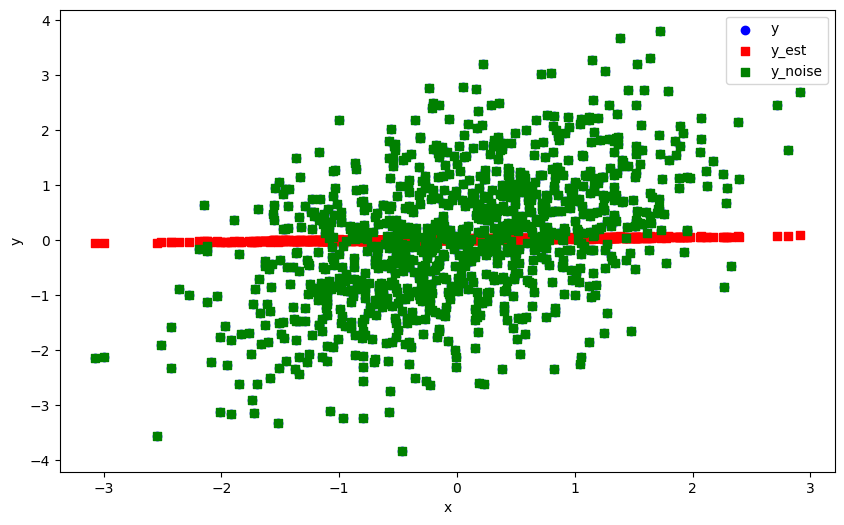

The programm is closed


In [20]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

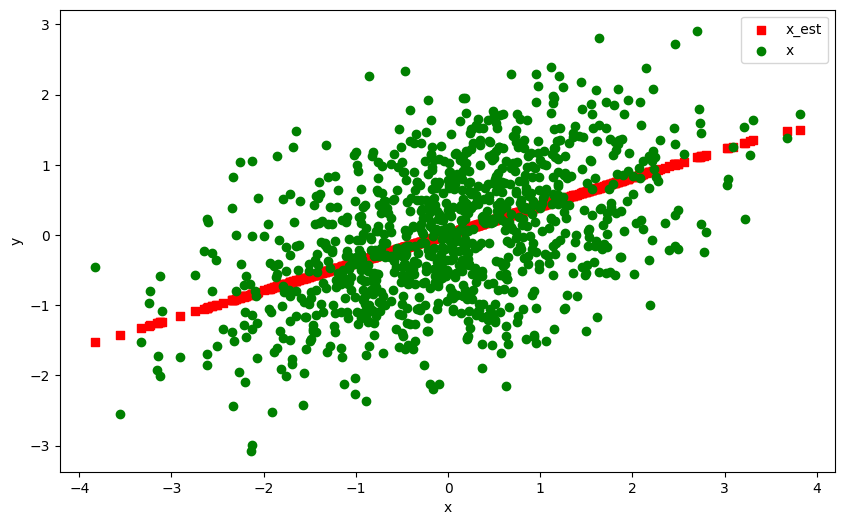

The programm is closed


In [21]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### freeze MLP parameters

In [7]:
# eq_model = nonlinear.DagmaMLP(
#     dims=[d, 10, 1], bias=True, dtype=torch.double)
# model = nonlinear.DagmaNonlinear(
#     eq_model, dtype=torch.double, use_mse_loss=True)

# W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
#                         T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# # Use DAGMA weights as initial weights for DAGMA-DCE
# fc1_weight = eq_model.fc1.weight
# fc1_bias = eq_model.fc1.bias
# fc2_weight = eq_model.fc2[0].weight
# fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
# eq_model.fc1.weight = fc1_weight
# eq_model.fc1.bias = fc1_bias
# eq_model.fc2[0].weight = fc2_weight
# eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 164/29000 [00:00<01:08, 421.90it/s]

Sigma:  tensor([[0.9609, 0.0195],
        [0.0195, 1.0409]], grad_fn=<MmBackward0>)
obj:  tensor(2.4352, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4338, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


  1%|          | 252/29000 [00:00<01:07, 427.09it/s]

Sigma:  tensor([[0.9239, 0.0380],
        [0.0380, 1.0825]], grad_fn=<MmBackward0>)
obj:  tensor(2.3343, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3312, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


  1%|▏         | 385/29000 [00:00<01:06, 430.92it/s]

Sigma:  tensor([[0.8899, 0.0552],
        [0.0552, 1.1226]], grad_fn=<MmBackward0>)
obj:  tensor(2.2458, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2407, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


  1%|▏         | 429/29000 [00:01<01:06, 426.56it/s]

Sigma:  tensor([[0.8594, 0.0711],
        [0.0711, 1.1592]], grad_fn=<MmBackward0>)
obj:  tensor(2.1687, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1614, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


  2%|▏         | 561/29000 [00:01<01:22, 344.89it/s]

Sigma:  tensor([[0.8326, 0.0858],
        [0.0858, 1.1904]], grad_fn=<MmBackward0>)
obj:  tensor(2.1012, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0913, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


  2%|▏         | 646/29000 [00:01<01:14, 382.50it/s]

Sigma:  tensor([[0.8093, 0.0992],
        [0.0992, 1.2150]], grad_fn=<MmBackward0>)
obj:  tensor(2.0413, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0288, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


  3%|▎         | 783/29000 [00:02<01:07, 420.90it/s]

Sigma:  tensor([[0.7887, 0.1116],
        [0.1116, 1.2319]], grad_fn=<MmBackward0>)
obj:  tensor(1.9873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9720, grad_fn=<AddBackward0>)
h_val:  tensor(0.0073, grad_fn=<AddBackward0>)


  3%|▎         | 870/29000 [00:02<01:08, 412.16it/s]

Sigma:  tensor([[0.7700, 0.1229],
        [0.1229, 1.2410]], grad_fn=<MmBackward0>)
obj:  tensor(1.9378, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9194, grad_fn=<AddBackward0>)
h_val:  tensor(0.0093, grad_fn=<AddBackward0>)


  3%|▎         | 961/29000 [00:02<01:04, 431.47it/s]

Sigma:  tensor([[0.7526, 0.1332],
        [0.1332, 1.2425]], grad_fn=<MmBackward0>)
obj:  tensor(1.8916, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8701, grad_fn=<AddBackward0>)
h_val:  tensor(0.0115, grad_fn=<AddBackward0>)


  4%|▎         | 1050/29000 [00:02<01:04, 430.36it/s]

Sigma:  tensor([[0.7363, 0.1426],
        [0.1426, 1.2372]], grad_fn=<MmBackward0>)
obj:  tensor(1.8480, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8232, grad_fn=<AddBackward0>)
h_val:  tensor(0.0139, grad_fn=<AddBackward0>)


  4%|▍         | 1183/29000 [00:02<01:04, 430.97it/s]

Sigma:  tensor([[0.7211, 0.1511],
        [0.1511, 1.2261]], grad_fn=<MmBackward0>)
obj:  tensor(1.8065, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0165, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:04, 426.99it/s]

Sigma:  tensor([[0.7069, 0.1589],
        [0.1589, 1.2106]], grad_fn=<MmBackward0>)
obj:  tensor(1.7668, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0193, grad_fn=<AddBackward0>)


  5%|▍         | 1359/29000 [00:03<01:03, 436.92it/s]

Sigma:  tensor([[0.6938, 0.1658],
        [0.1658, 1.1919]], grad_fn=<MmBackward0>)
obj:  tensor(1.7286, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0222, grad_fn=<AddBackward0>)


  5%|▍         | 1449/29000 [00:03<01:02, 438.90it/s]

Sigma:  tensor([[0.6815, 0.1719],
        [0.1719, 1.1711]], grad_fn=<MmBackward0>)
obj:  tensor(1.6920, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6524, grad_fn=<AddBackward0>)
h_val:  tensor(0.0253, grad_fn=<AddBackward0>)


  5%|▌         | 1581/29000 [00:03<01:03, 428.48it/s]

Sigma:  tensor([[0.6701, 0.1772],
        [0.1772, 1.1491]], grad_fn=<MmBackward0>)
obj:  tensor(1.6567, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6132, grad_fn=<AddBackward0>)
h_val:  tensor(0.0286, grad_fn=<AddBackward0>)


  6%|▌         | 1667/29000 [00:04<01:04, 424.62it/s]

Sigma:  tensor([[0.6594, 0.1818],
        [0.1818, 1.1266]], grad_fn=<MmBackward0>)
obj:  tensor(1.6228, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5752, grad_fn=<AddBackward0>)
h_val:  tensor(0.0320, grad_fn=<AddBackward0>)


  6%|▌         | 1755/29000 [00:04<01:03, 431.38it/s]

Sigma:  tensor([[0.6493, 0.1855],
        [0.1855, 1.1040]], grad_fn=<MmBackward0>)
obj:  tensor(1.5902, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5383, grad_fn=<AddBackward0>)
h_val:  tensor(0.0356, grad_fn=<AddBackward0>)


  6%|▋         | 1846/29000 [00:04<01:01, 440.73it/s]

Sigma:  tensor([[0.6397, 0.1883],
        [0.1883, 1.0817]], grad_fn=<MmBackward0>)
obj:  tensor(1.5586, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5025, grad_fn=<AddBackward0>)
h_val:  tensor(0.0393, grad_fn=<AddBackward0>)


  7%|▋         | 1982/29000 [00:04<01:01, 442.52it/s]

Sigma:  tensor([[0.6306, 0.1903],
        [0.1903, 1.0599]], grad_fn=<MmBackward0>)
obj:  tensor(1.5281, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4675, grad_fn=<AddBackward0>)
h_val:  tensor(0.0432, grad_fn=<AddBackward0>)


  7%|▋         | 2072/29000 [00:04<01:00, 442.25it/s]

Sigma:  tensor([[0.6218, 0.1915],
        [0.1915, 1.0386]], grad_fn=<MmBackward0>)
obj:  tensor(1.4985, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0472, grad_fn=<AddBackward0>)


  7%|▋         | 2164/29000 [00:05<01:00, 445.52it/s]

Sigma:  tensor([[0.6132, 0.1920],
        [0.1920, 1.0179]], grad_fn=<MmBackward0>)
obj:  tensor(1.4697, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0513, grad_fn=<AddBackward0>)


  8%|▊         | 2255/29000 [00:05<01:01, 434.10it/s]

Sigma:  tensor([[0.6049, 0.1917],
        [0.1917, 0.9977]], grad_fn=<MmBackward0>)
obj:  tensor(1.4415, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0556, grad_fn=<AddBackward0>)


  8%|▊         | 2386/29000 [00:05<01:02, 426.98it/s]

Sigma:  tensor([[0.5967, 0.1907],
        [0.1907, 0.9780]], grad_fn=<MmBackward0>)
obj:  tensor(1.4140, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0600, grad_fn=<AddBackward0>)


  8%|▊         | 2429/29000 [00:05<01:03, 415.31it/s]

Sigma:  tensor([[0.5886, 0.1892],
        [0.1892, 0.9588]], grad_fn=<MmBackward0>)
obj:  tensor(1.3870, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0646, grad_fn=<AddBackward0>)


  9%|▉         | 2556/29000 [00:06<01:06, 395.38it/s]

Sigma:  tensor([[0.5806, 0.1873],
        [0.1873, 0.9401]], grad_fn=<MmBackward0>)
obj:  tensor(1.3605, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2711, grad_fn=<AddBackward0>)
h_val:  tensor(0.0692, grad_fn=<AddBackward0>)


  9%|▉         | 2644/29000 [00:06<01:04, 411.35it/s]

Sigma:  tensor([[0.5728, 0.1850],
        [0.1850, 0.9218]], grad_fn=<MmBackward0>)
obj:  tensor(1.3344, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2399, grad_fn=<AddBackward0>)
h_val:  tensor(0.0741, grad_fn=<AddBackward0>)


 10%|▉         | 2781/29000 [00:06<00:59, 439.56it/s]

Sigma:  tensor([[0.5651, 0.1826],
        [0.1826, 0.9039]], grad_fn=<MmBackward0>)
obj:  tensor(1.3088, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2090, grad_fn=<AddBackward0>)
h_val:  tensor(0.0790, grad_fn=<AddBackward0>)


 10%|▉         | 2877/29000 [00:06<01:02, 417.45it/s]

Sigma:  tensor([[0.5575, 0.1800],
        [0.1800, 0.8866]], grad_fn=<MmBackward0>)
obj:  tensor(1.2837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0841, grad_fn=<AddBackward0>)


 10%|█         | 2960/29000 [00:07<01:07, 387.60it/s]

Sigma:  tensor([[0.5501, 0.1776],
        [0.1776, 0.8697]], grad_fn=<MmBackward0>)
obj:  tensor(1.2590, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1482, grad_fn=<AddBackward0>)
h_val:  tensor(0.0893, grad_fn=<AddBackward0>)


 10%|█         | 3044/29000 [00:07<01:04, 400.95it/s]

Sigma:  tensor([[0.5428, 0.1753],
        [0.1753, 0.8534]], grad_fn=<MmBackward0>)
obj:  tensor(1.2347, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1183, grad_fn=<AddBackward0>)
h_val:  tensor(0.0947, grad_fn=<AddBackward0>)


 11%|█         | 3183/29000 [00:07<01:00, 426.79it/s]

Sigma:  tensor([[0.5358, 0.1733],
        [0.1733, 0.8377]], grad_fn=<MmBackward0>)
obj:  tensor(1.2108, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0887, grad_fn=<AddBackward0>)
h_val:  tensor(0.1002, grad_fn=<AddBackward0>)


 11%|█▏        | 3271/29000 [00:07<01:00, 427.83it/s]

Sigma:  tensor([[0.5289, 0.1717],
        [0.1717, 0.8226]], grad_fn=<MmBackward0>)
obj:  tensor(1.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0593, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 12%|█▏        | 3357/29000 [00:08<01:00, 421.42it/s]

Sigma:  tensor([[0.5223, 0.1705],
        [0.1705, 0.8082]], grad_fn=<MmBackward0>)
obj:  tensor(1.1642, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0303, grad_fn=<AddBackward0>)
h_val:  tensor(0.1115, grad_fn=<AddBackward0>)


 12%|█▏        | 3490/29000 [00:08<00:58, 435.68it/s]

Sigma:  tensor([[0.5159, 0.1697],
        [0.1697, 0.7944]], grad_fn=<MmBackward0>)
obj:  tensor(1.1415, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0015, grad_fn=<AddBackward0>)
h_val:  tensor(0.1174, grad_fn=<AddBackward0>)


 12%|█▏        | 3581/29000 [00:08<00:57, 445.65it/s]

Sigma:  tensor([[0.5097, 0.1695],
        [0.1695, 0.7814]], grad_fn=<MmBackward0>)
obj:  tensor(1.1192, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9729, grad_fn=<AddBackward0>)
h_val:  tensor(0.1234, grad_fn=<AddBackward0>)


 13%|█▎        | 3673/29000 [00:08<00:56, 451.74it/s]

Sigma:  tensor([[0.5037, 0.1698],
        [0.1698, 0.7689]], grad_fn=<MmBackward0>)
obj:  tensor(1.0971, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9446, grad_fn=<AddBackward0>)
h_val:  tensor(0.1296, grad_fn=<AddBackward0>)


 13%|█▎        | 3765/29000 [00:09<00:55, 451.22it/s]

Sigma:  tensor([[0.4979, 0.1707],
        [0.1707, 0.7572]], grad_fn=<MmBackward0>)
obj:  tensor(1.0754, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9163, grad_fn=<AddBackward0>)
h_val:  tensor(0.1359, grad_fn=<AddBackward0>)


 13%|█▎        | 3860/29000 [00:09<00:54, 459.58it/s]

Sigma:  tensor([[0.4924, 0.1722],
        [0.1722, 0.7460]], grad_fn=<MmBackward0>)
obj:  tensor(1.0539, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8883, grad_fn=<AddBackward0>)
h_val:  tensor(0.1424, grad_fn=<AddBackward0>)


 14%|█▎        | 3953/29000 [00:09<00:54, 459.10it/s]

Sigma:  tensor([[0.4871, 0.1744],
        [0.1744, 0.7356]], grad_fn=<MmBackward0>)
obj:  tensor(1.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8602, grad_fn=<AddBackward0>)
h_val:  tensor(0.1490, grad_fn=<AddBackward0>)


 14%|█▍        | 4049/29000 [00:09<00:54, 459.03it/s]

Sigma:  tensor([[0.4820, 0.1772],
        [0.1772, 0.7257]], grad_fn=<MmBackward0>)
obj:  tensor(1.0114, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8322, grad_fn=<AddBackward0>)
h_val:  tensor(0.1557, grad_fn=<AddBackward0>)


 14%|█▍        | 4192/29000 [00:09<00:53, 462.60it/s]

Sigma:  tensor([[0.4771, 0.1807],
        [0.1807, 0.7165]], grad_fn=<MmBackward0>)
obj:  tensor(0.9903, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8042, grad_fn=<AddBackward0>)
h_val:  tensor(0.1627, grad_fn=<AddBackward0>)


 15%|█▍        | 4285/29000 [00:10<00:54, 456.22it/s]

Sigma:  tensor([[0.4726, 0.1849],
        [0.1849, 0.7079]], grad_fn=<MmBackward0>)
obj:  tensor(0.9692, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7760, grad_fn=<AddBackward0>)
h_val:  tensor(0.1698, grad_fn=<AddBackward0>)


 15%|█▌        | 4377/29000 [00:10<00:54, 448.46it/s]

Sigma:  tensor([[0.4682, 0.1899],
        [0.1899, 0.6999]], grad_fn=<MmBackward0>)
obj:  tensor(0.9481, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7476, grad_fn=<AddBackward0>)
h_val:  tensor(0.1771, grad_fn=<AddBackward0>)


 15%|█▌        | 4467/29000 [00:10<00:55, 440.98it/s]

Sigma:  tensor([[0.4642, 0.1956],
        [0.1956, 0.6925]], grad_fn=<MmBackward0>)
obj:  tensor(0.9269, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7189, grad_fn=<AddBackward0>)
h_val:  tensor(0.1846, grad_fn=<AddBackward0>)


 16%|█▌        | 4561/29000 [00:10<00:54, 452.27it/s]

Sigma:  tensor([[0.4605, 0.2021],
        [0.2021, 0.6858]], grad_fn=<MmBackward0>)
obj:  tensor(0.9054, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6899, grad_fn=<AddBackward0>)
h_val:  tensor(0.1923, grad_fn=<AddBackward0>)


 16%|█▌        | 4655/29000 [00:10<00:52, 459.38it/s]

Sigma:  tensor([[0.4571, 0.2093],
        [0.2093, 0.6796]], grad_fn=<MmBackward0>)
obj:  tensor(0.8837, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6604, grad_fn=<AddBackward0>)
h_val:  tensor(0.2001, grad_fn=<AddBackward0>)


 16%|█▋        | 4749/29000 [00:11<00:53, 456.72it/s]

Sigma:  tensor([[0.4541, 0.2173],
        [0.2173, 0.6741]], grad_fn=<MmBackward0>)
obj:  tensor(0.8615, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6304, grad_fn=<AddBackward0>)
h_val:  tensor(0.2082, grad_fn=<AddBackward0>)


 17%|█▋        | 4891/29000 [00:11<00:51, 465.77it/s]

Sigma:  tensor([[0.4514, 0.2260],
        [0.2260, 0.6692]], grad_fn=<MmBackward0>)
obj:  tensor(0.8390, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5998, grad_fn=<AddBackward0>)
h_val:  tensor(0.2164, grad_fn=<AddBackward0>)


 17%|█▋        | 4985/29000 [00:11<00:52, 460.68it/s]

Sigma:  tensor([[0.4492, 0.2353],
        [0.2353, 0.6650]], grad_fn=<MmBackward0>)
obj:  tensor(0.8163, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5686, grad_fn=<AddBackward0>)
h_val:  tensor(0.2248, grad_fn=<AddBackward0>)


 18%|█▊        | 5080/29000 [00:11<00:51, 462.93it/s]

Sigma:  tensor([[0.4476, 0.2452],
        [0.2452, 0.6612]], grad_fn=<MmBackward0>)
obj:  tensor(0.7938, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5371, grad_fn=<AddBackward0>)
h_val:  tensor(0.2333, grad_fn=<AddBackward0>)


 18%|█▊        | 5173/29000 [00:12<00:53, 441.67it/s]

Sigma:  tensor([[0.4465, 0.2553],
        [0.2553, 0.6578]], grad_fn=<MmBackward0>)
obj:  tensor(0.7709, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5052, grad_fn=<AddBackward0>)
h_val:  tensor(0.2420, grad_fn=<AddBackward0>)


 18%|█▊        | 5264/29000 [00:12<00:54, 437.74it/s]

Sigma:  tensor([[0.4455, 0.2653],
        [0.2653, 0.6546]], grad_fn=<MmBackward0>)
obj:  tensor(0.7478, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4726, grad_fn=<AddBackward0>)
h_val:  tensor(0.2508, grad_fn=<AddBackward0>)


 18%|█▊        | 5354/29000 [00:12<00:54, 436.40it/s]

Sigma:  tensor([[0.4445, 0.2754],
        [0.2754, 0.6519]], grad_fn=<MmBackward0>)
obj:  tensor(0.7247, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4397, grad_fn=<AddBackward0>)
h_val:  tensor(0.2597, grad_fn=<AddBackward0>)


 19%|█▉        | 5492/29000 [00:12<00:51, 452.11it/s]

Sigma:  tensor([[0.4437, 0.2854],
        [0.2854, 0.6498]], grad_fn=<MmBackward0>)
obj:  tensor(0.7012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4061, grad_fn=<AddBackward0>)
h_val:  tensor(0.2687, grad_fn=<AddBackward0>)


 19%|█▉        | 5584/29000 [00:13<00:52, 449.04it/s]

Sigma:  tensor([[0.4431, 0.2956],
        [0.2956, 0.6484]], grad_fn=<MmBackward0>)
obj:  tensor(0.6771, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3718, grad_fn=<AddBackward0>)
h_val:  tensor(0.2779, grad_fn=<AddBackward0>)


 20%|█▉        | 5673/29000 [00:13<00:55, 419.97it/s]

Sigma:  tensor([[0.4429, 0.3061],
        [0.3061, 0.6475]], grad_fn=<MmBackward0>)
obj:  tensor(0.6525, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3368, grad_fn=<AddBackward0>)
h_val:  tensor(0.2872, grad_fn=<AddBackward0>)


 20%|█▉        | 5757/29000 [00:13<00:57, 404.01it/s]

Sigma:  tensor([[0.4431, 0.3167],
        [0.3167, 0.6471]], grad_fn=<MmBackward0>)
obj:  tensor(0.6273, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3011, grad_fn=<AddBackward0>)
h_val:  tensor(0.2967, grad_fn=<AddBackward0>)


 20%|██        | 5877/29000 [00:13<00:59, 387.56it/s]

Sigma:  tensor([[0.4437, 0.3275],
        [0.3275, 0.6471]], grad_fn=<MmBackward0>)
obj:  tensor(0.6016, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2648, grad_fn=<AddBackward0>)
h_val:  tensor(0.3064, grad_fn=<AddBackward0>)


 21%|██        | 5949/29000 [00:14<01:30, 255.06it/s]

Sigma:  tensor([[0.4447, 0.3383],
        [0.3383, 0.6474]], grad_fn=<MmBackward0>)
obj:  tensor(0.5754, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2279, grad_fn=<AddBackward0>)
h_val:  tensor(0.3161, grad_fn=<AddBackward0>)


 21%|██        | 6086/29000 [00:14<01:01, 370.20it/s]

Sigma:  tensor([[0.4459, 0.3491],
        [0.3491, 0.6481]], grad_fn=<MmBackward0>)
obj:  tensor(0.5489, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1905, grad_fn=<AddBackward0>)
h_val:  tensor(0.3260, grad_fn=<AddBackward0>)


 21%|██▏       | 6177/29000 [00:14<00:55, 407.96it/s]

Sigma:  tensor([[0.4473, 0.3597],
        [0.3597, 0.6490]], grad_fn=<MmBackward0>)
obj:  tensor(0.5220, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1526, grad_fn=<AddBackward0>)
h_val:  tensor(0.3359, grad_fn=<AddBackward0>)


 22%|██▏       | 6266/29000 [00:14<00:53, 423.93it/s]

Sigma:  tensor([[0.4488, 0.3700],
        [0.3700, 0.6501]], grad_fn=<MmBackward0>)
obj:  tensor(0.4948, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1144, grad_fn=<AddBackward0>)
h_val:  tensor(0.3460, grad_fn=<AddBackward0>)


 22%|██▏       | 6357/29000 [00:15<00:51, 437.52it/s]

Sigma:  tensor([[0.4505, 0.3800],
        [0.3800, 0.6513]], grad_fn=<MmBackward0>)
obj:  tensor(0.4675, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0759, grad_fn=<AddBackward0>)
h_val:  tensor(0.3562, grad_fn=<AddBackward0>)


 22%|██▏       | 6448/29000 [00:15<00:50, 442.91it/s]

Sigma:  tensor([[0.4522, 0.3897],
        [0.3897, 0.6526]], grad_fn=<MmBackward0>)
obj:  tensor(0.4400, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0372, grad_fn=<AddBackward0>)
h_val:  tensor(0.3665, grad_fn=<AddBackward0>)


 23%|██▎       | 6589/29000 [00:15<00:49, 457.20it/s]

Sigma:  tensor([[0.4539, 0.3990],
        [0.3990, 0.6540]], grad_fn=<MmBackward0>)
obj:  tensor(0.4125, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0015, grad_fn=<AddBackward0>)
h_val:  tensor(0.3768, grad_fn=<AddBackward0>)


 23%|██▎       | 6681/29000 [00:15<00:49, 454.23it/s]

Sigma:  tensor([[0.4557, 0.4078],
        [0.4078, 0.6554]], grad_fn=<MmBackward0>)
obj:  tensor(0.3850, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0403, grad_fn=<AddBackward0>)
h_val:  tensor(0.3873, grad_fn=<AddBackward0>)


 23%|██▎       | 6772/29000 [00:16<00:51, 428.85it/s]

Sigma:  tensor([[0.4573, 0.4163],
        [0.4163, 0.6568]], grad_fn=<MmBackward0>)
obj:  tensor(0.3577, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0790, grad_fn=<AddBackward0>)
h_val:  tensor(0.3978, grad_fn=<AddBackward0>)


 24%|██▎       | 6862/29000 [00:16<00:51, 431.83it/s]

Sigma:  tensor([[0.4589, 0.4242],
        [0.4242, 0.6582]], grad_fn=<MmBackward0>)
obj:  tensor(0.3306, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1175, grad_fn=<AddBackward0>)
h_val:  tensor(0.4083, grad_fn=<AddBackward0>)


 24%|██▍       | 6955/29000 [00:16<00:49, 445.56it/s]

Sigma:  tensor([[0.4604, 0.4318],
        [0.4318, 0.6595]], grad_fn=<MmBackward0>)
obj:  tensor(0.3037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1557, grad_fn=<AddBackward0>)
h_val:  tensor(0.4189, grad_fn=<AddBackward0>)


 25%|██▍       | 7132/29000 [00:16<01:00, 361.12it/s]

Sigma:  tensor([[0.4457, 0.4199],
        [0.4199, 0.6339]], grad_fn=<MmBackward0>)
obj:  tensor(0.4049, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1694, grad_fn=<AddBackward0>)
h_val:  tensor(0.4177, grad_fn=<AddBackward0>)


 25%|██▌       | 7260/29000 [00:17<00:53, 405.70it/s]

Sigma:  tensor([[0.4302, 0.4005],
        [0.4005, 0.6085]], grad_fn=<MmBackward0>)
obj:  tensor(0.3947, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1303, grad_fn=<AddBackward0>)
h_val:  tensor(0.4037, grad_fn=<AddBackward0>)


 25%|██▌       | 7345/29000 [00:17<00:53, 407.20it/s]

Sigma:  tensor([[0.4191, 0.3848],
        [0.3848, 0.5926]], grad_fn=<MmBackward0>)
obj:  tensor(0.3853, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0873, grad_fn=<AddBackward0>)
h_val:  tensor(0.3900, grad_fn=<AddBackward0>)


 26%|██▌       | 7484/29000 [00:17<00:49, 432.11it/s]

Sigma:  tensor([[0.4140, 0.3748],
        [0.3748, 0.5861]], grad_fn=<MmBackward0>)
obj:  tensor(0.3765, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0447, grad_fn=<AddBackward0>)
h_val:  tensor(0.3771, grad_fn=<AddBackward0>)


 26%|██▌       | 7575/29000 [00:17<00:48, 441.77it/s]

Sigma:  tensor([[0.4145, 0.3708],
        [0.3708, 0.5875]], grad_fn=<MmBackward0>)
obj:  tensor(0.3682, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0045, grad_fn=<AddBackward0>)
h_val:  tensor(0.3647, grad_fn=<AddBackward0>)


 26%|██▋       | 7665/29000 [00:18<00:49, 433.05it/s]

Sigma:  tensor([[0.4182, 0.3717],
        [0.3717, 0.5953]], grad_fn=<MmBackward0>)
obj:  tensor(0.3601, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0330, grad_fn=<AddBackward0>)
h_val:  tensor(0.3529, grad_fn=<AddBackward0>)


 27%|██▋       | 7751/29000 [00:18<00:52, 406.75it/s]

Sigma:  tensor([[0.4234, 0.3750],
        [0.3750, 0.6063]], grad_fn=<MmBackward0>)
obj:  tensor(0.3522, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0688, grad_fn=<AddBackward0>)
h_val:  tensor(0.3415, grad_fn=<AddBackward0>)


 27%|██▋       | 7889/29000 [00:18<00:47, 442.24it/s]

Sigma:  tensor([[0.4289, 0.3788],
        [0.3788, 0.6180]], grad_fn=<MmBackward0>)
obj:  tensor(0.3445, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1045, grad_fn=<AddBackward0>)
h_val:  tensor(0.3304, grad_fn=<AddBackward0>)


 28%|██▊       | 7980/29000 [00:18<00:47, 445.83it/s]

Sigma:  tensor([[0.4341, 0.3816],
        [0.3816, 0.6291]], grad_fn=<MmBackward0>)
obj:  tensor(0.3371, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1405, grad_fn=<AddBackward0>)
h_val:  tensor(0.3194, grad_fn=<AddBackward0>)


 28%|██▊       | 8072/29000 [00:19<00:46, 446.54it/s]

Sigma:  tensor([[0.4386, 0.3834],
        [0.3834, 0.6394]], grad_fn=<MmBackward0>)
obj:  tensor(0.3298, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1773, grad_fn=<AddBackward0>)
h_val:  tensor(0.3085, grad_fn=<AddBackward0>)


 28%|██▊       | 8163/29000 [00:19<00:47, 438.96it/s]

Sigma:  tensor([[0.4426, 0.3844],
        [0.3844, 0.6495]], grad_fn=<MmBackward0>)
obj:  tensor(0.3227, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2145, grad_fn=<AddBackward0>)
h_val:  tensor(0.2978, grad_fn=<AddBackward0>)


 28%|██▊       | 8253/29000 [00:19<00:47, 439.93it/s]

Sigma:  tensor([[0.4467, 0.3852],
        [0.3852, 0.6599]], grad_fn=<MmBackward0>)
obj:  tensor(0.3159, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2521, grad_fn=<AddBackward0>)
h_val:  tensor(0.2872, grad_fn=<AddBackward0>)


 29%|██▉       | 8344/29000 [00:19<00:46, 440.47it/s]

Sigma:  tensor([[0.4509, 0.3860],
        [0.3860, 0.6707]], grad_fn=<MmBackward0>)
obj:  tensor(0.3092, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2899, grad_fn=<AddBackward0>)
h_val:  tensor(0.2768, grad_fn=<AddBackward0>)


 29%|██▉       | 8481/29000 [00:20<00:45, 446.96it/s]

Sigma:  tensor([[0.4553, 0.3869],
        [0.3869, 0.6822]], grad_fn=<MmBackward0>)
obj:  tensor(0.3027, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3278, grad_fn=<AddBackward0>)
h_val:  tensor(0.2666, grad_fn=<AddBackward0>)


 30%|██▉       | 8571/29000 [00:20<00:46, 442.23it/s]

Sigma:  tensor([[0.4597, 0.3878],
        [0.3878, 0.6942]], grad_fn=<MmBackward0>)
obj:  tensor(0.2964, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3659, grad_fn=<AddBackward0>)
h_val:  tensor(0.2566, grad_fn=<AddBackward0>)


 30%|██▉       | 8661/29000 [00:20<00:46, 439.63it/s]

Sigma:  tensor([[0.4642, 0.3885],
        [0.3885, 0.7065]], grad_fn=<MmBackward0>)
obj:  tensor(0.2903, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4040, grad_fn=<AddBackward0>)
h_val:  tensor(0.2467, grad_fn=<AddBackward0>)


 30%|███       | 8751/29000 [00:20<00:45, 440.63it/s]

Sigma:  tensor([[0.4688, 0.3890],
        [0.3890, 0.7190]], grad_fn=<MmBackward0>)
obj:  tensor(0.2844, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4421, grad_fn=<AddBackward0>)
h_val:  tensor(0.2371, grad_fn=<AddBackward0>)


 31%|███       | 8846/29000 [00:20<00:44, 448.18it/s]

Sigma:  tensor([[0.4734, 0.3894],
        [0.3894, 0.7318]], grad_fn=<MmBackward0>)
obj:  tensor(0.2787, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4800, grad_fn=<AddBackward0>)
h_val:  tensor(0.2277, grad_fn=<AddBackward0>)


 31%|███       | 8987/29000 [00:21<00:44, 453.71it/s]

Sigma:  tensor([[0.4780, 0.3895],
        [0.3895, 0.7447]], grad_fn=<MmBackward0>)
obj:  tensor(0.2732, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5179, grad_fn=<AddBackward0>)
h_val:  tensor(0.2185, grad_fn=<AddBackward0>)


 31%|███▏      | 9079/29000 [00:21<00:44, 451.11it/s]

Sigma:  tensor([[0.4827, 0.3896],
        [0.3896, 0.7578]], grad_fn=<MmBackward0>)
obj:  tensor(0.2678, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5555, grad_fn=<AddBackward0>)
h_val:  tensor(0.2094, grad_fn=<AddBackward0>)


 32%|███▏      | 9172/29000 [00:21<00:43, 454.08it/s]

Sigma:  tensor([[0.4875, 0.3895],
        [0.3895, 0.7711]], grad_fn=<MmBackward0>)
obj:  tensor(0.2627, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5928, grad_fn=<AddBackward0>)
h_val:  tensor(0.2007, grad_fn=<AddBackward0>)


 32%|███▏      | 9264/29000 [00:21<00:43, 450.08it/s]

Sigma:  tensor([[0.4922, 0.3892],
        [0.3892, 0.7843]], grad_fn=<MmBackward0>)
obj:  tensor(0.2578, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6299, grad_fn=<AddBackward0>)
h_val:  tensor(0.1921, grad_fn=<AddBackward0>)


 32%|███▏      | 9355/29000 [00:22<00:44, 437.15it/s]

Sigma:  tensor([[0.4971, 0.3888],
        [0.3888, 0.7975]], grad_fn=<MmBackward0>)
obj:  tensor(0.2530, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6665, grad_fn=<AddBackward0>)
h_val:  tensor(0.1838, grad_fn=<AddBackward0>)


 33%|███▎      | 9445/29000 [00:22<00:44, 441.00it/s]

Sigma:  tensor([[0.5020, 0.3882],
        [0.3882, 0.8107]], grad_fn=<MmBackward0>)
obj:  tensor(0.2484, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7027, grad_fn=<AddBackward0>)
h_val:  tensor(0.1757, grad_fn=<AddBackward0>)


 33%|███▎      | 9583/29000 [00:22<00:43, 449.79it/s]

Sigma:  tensor([[0.5069, 0.3874],
        [0.3874, 0.8237]], grad_fn=<MmBackward0>)
obj:  tensor(0.2441, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7383, grad_fn=<AddBackward0>)
h_val:  tensor(0.1678, grad_fn=<AddBackward0>)


 33%|███▎      | 9674/29000 [00:22<00:43, 447.04it/s]

Sigma:  tensor([[0.5119, 0.3865],
        [0.3865, 0.8365]], grad_fn=<MmBackward0>)
obj:  tensor(0.2399, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7734, grad_fn=<AddBackward0>)
h_val:  tensor(0.1602, grad_fn=<AddBackward0>)


 34%|███▎      | 9765/29000 [00:22<00:43, 445.09it/s]

Sigma:  tensor([[0.5169, 0.3854],
        [0.3854, 0.8491]], grad_fn=<MmBackward0>)
obj:  tensor(0.2359, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8079, grad_fn=<AddBackward0>)
h_val:  tensor(0.1528, grad_fn=<AddBackward0>)


 34%|███▍      | 9857/29000 [00:23<00:42, 446.39it/s]

Sigma:  tensor([[0.5219, 0.3842],
        [0.3842, 0.8615]], grad_fn=<MmBackward0>)
obj:  tensor(0.2321, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.1457, grad_fn=<AddBackward0>)


 34%|███▍      | 9949/29000 [00:23<00:42, 447.65it/s]

Sigma:  tensor([[0.5269, 0.3829],
        [0.3829, 0.8735]], grad_fn=<MmBackward0>)
obj:  tensor(0.2285, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8747, grad_fn=<AddBackward0>)
h_val:  tensor(0.1389, grad_fn=<AddBackward0>)


 35%|███▍      | 10091/29000 [00:23<00:41, 458.64it/s]

Sigma:  tensor([[0.5320, 0.3814],
        [0.3814, 0.8852]], grad_fn=<MmBackward0>)
obj:  tensor(0.2251, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9070, grad_fn=<AddBackward0>)
h_val:  tensor(0.1323, grad_fn=<AddBackward0>)


 35%|███▌      | 10183/29000 [00:23<00:41, 452.58it/s]

Sigma:  tensor([[0.5371, 0.3799],
        [0.3799, 0.8965]], grad_fn=<MmBackward0>)
obj:  tensor(0.2218, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9384, grad_fn=<AddBackward0>)
h_val:  tensor(0.1260, grad_fn=<AddBackward0>)


 35%|███▌      | 10274/29000 [00:24<00:41, 448.22it/s]

Sigma:  tensor([[0.5422, 0.3783],
        [0.3783, 0.9074]], grad_fn=<MmBackward0>)
obj:  tensor(0.2188, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9691, grad_fn=<AddBackward0>)
h_val:  tensor(0.1200, grad_fn=<AddBackward0>)


 36%|███▌      | 10366/29000 [00:24<00:41, 449.24it/s]

Sigma:  tensor([[0.5473, 0.3767],
        [0.3767, 0.9179]], grad_fn=<MmBackward0>)
obj:  tensor(0.2159, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9988, grad_fn=<AddBackward0>)
h_val:  tensor(0.1142, grad_fn=<AddBackward0>)


 36%|███▌      | 10457/29000 [00:24<00:42, 441.48it/s]

Sigma:  tensor([[0.5525, 0.3750],
        [0.3750, 0.9280]], grad_fn=<MmBackward0>)
obj:  tensor(0.2132, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0277, grad_fn=<AddBackward0>)
h_val:  tensor(0.1087, grad_fn=<AddBackward0>)


 36%|███▋      | 10548/29000 [00:24<00:41, 445.19it/s]

Sigma:  tensor([[0.5576, 0.3732],
        [0.3732, 0.9377]], grad_fn=<MmBackward0>)
obj:  tensor(0.2107, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0557, grad_fn=<AddBackward0>)
h_val:  tensor(0.1035, grad_fn=<AddBackward0>)


 37%|███▋      | 10690/29000 [00:24<00:39, 459.98it/s]

Sigma:  tensor([[0.5628, 0.3716],
        [0.3716, 0.9469]], grad_fn=<MmBackward0>)
obj:  tensor(0.2084, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0985, grad_fn=<AddBackward0>)


 37%|███▋      | 10784/29000 [00:25<00:40, 454.52it/s]

Sigma:  tensor([[0.5689, 0.3711],
        [0.3711, 0.9554]], grad_fn=<MmBackward0>)
obj:  tensor(0.2062, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1078, grad_fn=<AddBackward0>)
h_val:  tensor(0.0938, grad_fn=<AddBackward0>)


 38%|███▊      | 10878/29000 [00:25<00:39, 458.17it/s]

Sigma:  tensor([[0.5759, 0.3724],
        [0.3724, 0.9634]], grad_fn=<MmBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0894, grad_fn=<AddBackward0>)


 38%|███▊      | 10971/29000 [00:25<00:39, 453.76it/s]

Sigma:  tensor([[0.5832, 0.3745],
        [0.3745, 0.9718]], grad_fn=<MmBackward0>)
obj:  tensor(0.2023, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0852, grad_fn=<AddBackward0>)


 38%|███▊      | 11017/29000 [00:25<00:40, 447.61it/s]

Sigma:  tensor([[0.5903, 0.3764],
        [0.3764, 0.9801]], grad_fn=<MmBackward0>)
obj:  tensor(0.2006, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1787, grad_fn=<AddBackward0>)
h_val:  tensor(0.0812, grad_fn=<AddBackward0>)


 38%|███▊      | 11155/29000 [00:26<00:49, 363.43it/s]

Sigma:  tensor([[0.5971, 0.3782],
        [0.3782, 0.9881]], grad_fn=<MmBackward0>)
obj:  tensor(0.1989, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2008, grad_fn=<AddBackward0>)
h_val:  tensor(0.0774, grad_fn=<AddBackward0>)


 39%|███▉      | 11247/29000 [00:26<00:44, 399.55it/s]

Sigma:  tensor([[0.6040, 0.3802],
        [0.3802, 0.9958]], grad_fn=<MmBackward0>)
obj:  tensor(0.1974, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2221, grad_fn=<AddBackward0>)
h_val:  tensor(0.0738, grad_fn=<AddBackward0>)


 39%|███▉      | 11381/29000 [00:26<00:41, 424.64it/s]

Sigma:  tensor([[0.6108, 0.3825],
        [0.3825, 1.0034]], grad_fn=<MmBackward0>)
obj:  tensor(0.1960, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2426, grad_fn=<AddBackward0>)
h_val:  tensor(0.0704, grad_fn=<AddBackward0>)


 40%|███▉      | 11470/29000 [00:26<00:40, 430.71it/s]

Sigma:  tensor([[0.6176, 0.3849],
        [0.3849, 1.0109]], grad_fn=<MmBackward0>)
obj:  tensor(0.1947, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2623, grad_fn=<AddBackward0>)
h_val:  tensor(0.0671, grad_fn=<AddBackward0>)


 40%|███▉      | 11559/29000 [00:27<00:40, 433.00it/s]

Sigma:  tensor([[0.6243, 0.3874],
        [0.3874, 1.0181]], grad_fn=<MmBackward0>)
obj:  tensor(0.1935, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2813, grad_fn=<AddBackward0>)
h_val:  tensor(0.0641, grad_fn=<AddBackward0>)


 40%|████      | 11651/29000 [00:27<00:39, 440.88it/s]

Sigma:  tensor([[0.6310, 0.3900],
        [0.3900, 1.0250]], grad_fn=<MmBackward0>)
obj:  tensor(0.1924, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2996, grad_fn=<AddBackward0>)
h_val:  tensor(0.0611, grad_fn=<AddBackward0>)


 41%|████      | 11792/29000 [00:27<00:37, 456.82it/s]

Sigma:  tensor([[0.6377, 0.3927],
        [0.3927, 1.0317]], grad_fn=<MmBackward0>)
obj:  tensor(0.1913, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3172, grad_fn=<AddBackward0>)
h_val:  tensor(0.0584, grad_fn=<AddBackward0>)


 41%|████      | 11884/29000 [00:27<00:37, 450.68it/s]

Sigma:  tensor([[0.6443, 0.3956],
        [0.3956, 1.0382]], grad_fn=<MmBackward0>)
obj:  tensor(0.1904, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3341, grad_fn=<AddBackward0>)
h_val:  tensor(0.0558, grad_fn=<AddBackward0>)


 41%|████▏     | 11976/29000 [00:28<00:37, 448.12it/s]

Sigma:  tensor([[0.6508, 0.3986],
        [0.3986, 1.0445]], grad_fn=<MmBackward0>)
obj:  tensor(0.1895, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3503, grad_fn=<AddBackward0>)
h_val:  tensor(0.0533, grad_fn=<AddBackward0>)


 42%|████▏     | 12066/29000 [00:28<00:38, 444.44it/s]

Sigma:  tensor([[0.6573, 0.4016],
        [0.4016, 1.0506]], grad_fn=<MmBackward0>)
obj:  tensor(0.1887, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3659, grad_fn=<AddBackward0>)
h_val:  tensor(0.0510, grad_fn=<AddBackward0>)


 42%|████▏     | 12157/29000 [00:28<00:37, 446.05it/s]

Sigma:  tensor([[0.6637, 0.4048],
        [0.4048, 1.0565]], grad_fn=<MmBackward0>)
obj:  tensor(0.1880, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0488, grad_fn=<AddBackward0>)


 42%|████▏     | 12247/29000 [00:28<00:37, 443.10it/s]

Sigma:  tensor([[0.6699, 0.4079],
        [0.4079, 1.0623]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3955, grad_fn=<AddBackward0>)
h_val:  tensor(0.0467, grad_fn=<AddBackward0>)


 43%|████▎     | 12389/29000 [00:28<00:36, 450.59it/s]

Sigma:  tensor([[0.6761, 0.4111],
        [0.4111, 1.0679]], grad_fn=<MmBackward0>)
obj:  tensor(0.1867, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4094, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)


 43%|████▎     | 12481/29000 [00:29<00:36, 447.54it/s]

Sigma:  tensor([[0.6816, 0.4138],
        [0.4138, 1.0736]], grad_fn=<MmBackward0>)
obj:  tensor(0.1861, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4229, grad_fn=<AddBackward0>)
h_val:  tensor(0.0428, grad_fn=<AddBackward0>)


 43%|████▎     | 12571/29000 [00:29<00:37, 441.87it/s]

Sigma:  tensor([[0.6867, 0.4157],
        [0.4157, 1.0790]], grad_fn=<MmBackward0>)
obj:  tensor(0.1856, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4358, grad_fn=<AddBackward0>)
h_val:  tensor(0.0410, grad_fn=<AddBackward0>)


 44%|████▎     | 12663/29000 [00:29<00:36, 445.94it/s]

Sigma:  tensor([[0.6917, 0.4178],
        [0.4178, 1.0838]], grad_fn=<MmBackward0>)
obj:  tensor(0.1852, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4483, grad_fn=<AddBackward0>)
h_val:  tensor(0.0394, grad_fn=<AddBackward0>)


 44%|████▍     | 12753/29000 [00:29<00:36, 442.37it/s]

Sigma:  tensor([[0.6966, 0.4198],
        [0.4198, 1.0887]], grad_fn=<MmBackward0>)
obj:  tensor(0.1848, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0378, grad_fn=<AddBackward0>)


 44%|████▍     | 12842/29000 [00:30<00:38, 419.49it/s]

Sigma:  tensor([[0.7012, 0.4215],
        [0.4215, 1.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.1844, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4717, grad_fn=<AddBackward0>)
h_val:  tensor(0.0363, grad_fn=<AddBackward0>)


 45%|████▍     | 12978/29000 [00:30<00:36, 437.60it/s]

Sigma:  tensor([[0.7056, 0.4231],
        [0.4231, 1.0976]], grad_fn=<MmBackward0>)
obj:  tensor(0.1841, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4827, grad_fn=<AddBackward0>)
h_val:  tensor(0.0350, grad_fn=<AddBackward0>)


 45%|████▌     | 13066/29000 [00:30<00:37, 419.49it/s]

Sigma:  tensor([[0.7097, 0.4252],
        [0.4252, 1.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.1839, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4932, grad_fn=<AddBackward0>)
h_val:  tensor(0.0337, grad_fn=<AddBackward0>)


 45%|████▌     | 13150/29000 [00:30<00:40, 386.95it/s]

Sigma:  tensor([[0.7139, 0.4274],
        [0.4274, 1.1073]], grad_fn=<MmBackward0>)
obj:  tensor(0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0325, grad_fn=<AddBackward0>)


 46%|████▌     | 13269/29000 [00:31<00:40, 386.59it/s]

Sigma:  tensor([[0.7177, 0.4292],
        [0.4292, 1.1117]], grad_fn=<MmBackward0>)
obj:  tensor(0.1835, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5125, grad_fn=<AddBackward0>)
h_val:  tensor(0.0314, grad_fn=<AddBackward0>)


 46%|████▌     | 13347/29000 [00:31<00:40, 385.29it/s]

Sigma:  tensor([[0.7213, 0.4311],
        [0.4311, 1.1161]], grad_fn=<MmBackward0>)
obj:  tensor(0.1833, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5214, grad_fn=<AddBackward0>)
h_val:  tensor(0.0303, grad_fn=<AddBackward0>)


 46%|████▋     | 13469/29000 [00:31<00:39, 394.19it/s]

Sigma:  tensor([[0.7246, 0.4328],
        [0.4328, 1.1202]], grad_fn=<MmBackward0>)
obj:  tensor(0.1832, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5297, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


 47%|████▋     | 13548/29000 [00:31<00:40, 378.54it/s]

Sigma:  tensor([[0.7277, 0.4344],
        [0.4344, 1.1241]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)


 47%|████▋     | 13662/29000 [00:32<00:41, 373.90it/s]

Sigma:  tensor([[0.7306, 0.4360],
        [0.4360, 1.1278]], grad_fn=<MmBackward0>)
obj:  tensor(0.1830, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0277, grad_fn=<AddBackward0>)


 48%|████▊     | 13779/29000 [00:32<00:39, 383.98it/s]

Sigma:  tensor([[0.7332, 0.4375],
        [0.4375, 1.1313]], grad_fn=<MmBackward0>)
obj:  tensor(0.1830, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5513, grad_fn=<AddBackward0>)
h_val:  tensor(0.0270, grad_fn=<AddBackward0>)


 48%|████▊     | 13857/29000 [00:32<00:39, 380.65it/s]

Sigma:  tensor([[0.7356, 0.4388],
        [0.4388, 1.1345]], grad_fn=<MmBackward0>)
obj:  tensor(0.1829, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5574, grad_fn=<AddBackward0>)
h_val:  tensor(0.0264, grad_fn=<AddBackward0>)


 48%|████▊     | 13976/29000 [00:32<00:39, 382.30it/s]

Sigma:  tensor([[0.7378, 0.4401],
        [0.4401, 1.1375]], grad_fn=<MmBackward0>)
obj:  tensor(0.1829, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5629, grad_fn=<AddBackward0>)
h_val:  tensor(0.0258, grad_fn=<AddBackward0>)


 49%|████▉     | 14183/29000 [00:33<00:36, 411.43it/s]

Sigma:  tensor([[0.7427, 0.4434],
        [0.4434, 1.1515]], grad_fn=<MmBackward0>)
obj:  tensor(0.0399, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0240, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:33<00:37, 396.51it/s]

Sigma:  tensor([[0.7463, 0.4411],
        [0.4411, 1.1646]], grad_fn=<MmBackward0>)
obj:  tensor(0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6073, grad_fn=<AddBackward0>)
h_val:  tensor(0.0215, grad_fn=<AddBackward0>)


 49%|████▉     | 14345/29000 [00:33<00:38, 383.15it/s]

Sigma:  tensor([[0.7518, 0.4405],
        [0.4405, 1.1783]], grad_fn=<MmBackward0>)
obj:  tensor(0.0353, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6363, grad_fn=<AddBackward0>)
h_val:  tensor(0.0188, grad_fn=<AddBackward0>)


 50%|████▉     | 14467/29000 [00:34<00:37, 391.17it/s]

Sigma:  tensor([[0.7620, 0.4469],
        [0.4469, 1.1966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0330, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6656, grad_fn=<AddBackward0>)
h_val:  tensor(0.0163, grad_fn=<AddBackward0>)


 50%|█████     | 14546/29000 [00:34<00:37, 380.68it/s]

Sigma:  tensor([[0.7748, 0.4577],
        [0.4577, 1.2178]], grad_fn=<MmBackward0>)
obj:  tensor(0.0310, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6945, grad_fn=<AddBackward0>)
h_val:  tensor(0.0140, grad_fn=<AddBackward0>)


 51%|█████     | 14666/29000 [00:34<00:36, 387.52it/s]

Sigma:  tensor([[0.7879, 0.4682],
        [0.4682, 1.2375]], grad_fn=<MmBackward0>)
obj:  tensor(0.0292, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7224, grad_fn=<AddBackward0>)
h_val:  tensor(0.0120, grad_fn=<AddBackward0>)


 51%|█████     | 14743/29000 [00:34<00:38, 372.16it/s]

Sigma:  tensor([[0.8003, 0.4777],
        [0.4777, 1.2556]], grad_fn=<MmBackward0>)
obj:  tensor(0.0277, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7491, grad_fn=<AddBackward0>)
h_val:  tensor(0.0101, grad_fn=<AddBackward0>)


 51%|█████▏    | 14866/29000 [00:35<00:36, 385.78it/s]

Sigma:  tensor([[0.8120, 0.4865],
        [0.4865, 1.2729]], grad_fn=<MmBackward0>)
obj:  tensor(0.0263, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7744, grad_fn=<AddBackward0>)
h_val:  tensor(0.0085, grad_fn=<AddBackward0>)


 52%|█████▏    | 14945/29000 [00:35<00:36, 388.83it/s]

Sigma:  tensor([[0.8226, 0.4938],
        [0.4938, 1.2888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 52%|█████▏    | 15071/29000 [00:35<00:34, 401.48it/s]

Sigma:  tensor([[0.8323, 0.4999],
        [0.4999, 1.3032]], grad_fn=<MmBackward0>)
obj:  tensor(0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8206, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 52%|█████▏    | 15151/29000 [00:35<00:36, 384.14it/s]

Sigma:  tensor([[0.8412, 0.5055],
        [0.5055, 1.3168]], grad_fn=<MmBackward0>)
obj:  tensor(0.0234, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 53%|█████▎    | 15269/29000 [00:36<00:35, 384.55it/s]

Sigma:  tensor([[0.8496, 0.5104],
        [0.5104, 1.3292]], grad_fn=<MmBackward0>)
obj:  tensor(0.0227, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8605, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)


 53%|█████▎    | 15346/29000 [00:36<00:36, 373.76it/s]

Sigma:  tensor([[0.8575, 0.5150],
        [0.5150, 1.3406]], grad_fn=<MmBackward0>)
obj:  tensor(0.0222, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 53%|█████▎    | 15464/29000 [00:36<00:36, 372.60it/s]

Sigma:  tensor([[0.8649, 0.5193],
        [0.5193, 1.3510]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8944, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 54%|█████▎    | 15539/29000 [00:37<00:38, 347.51it/s]

Sigma:  tensor([[0.8717, 0.5232],
        [0.5232, 1.3603]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9092, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 54%|█████▍    | 15646/29000 [00:37<00:38, 344.58it/s]

Sigma:  tensor([[0.8781, 0.5267],
        [0.5267, 1.3687]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9226, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 54%|█████▍    | 15753/29000 [00:37<00:38, 341.69it/s]

Sigma:  tensor([[0.8840, 0.5299],
        [0.5299, 1.3762]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 55%|█████▍    | 15861/29000 [00:37<00:37, 346.35it/s]

Sigma:  tensor([[0.8893, 0.5327],
        [0.5327, 1.3827]], grad_fn=<MmBackward0>)
obj:  tensor(0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9454, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 55%|█████▌    | 15970/29000 [00:38<00:36, 353.13it/s]

Sigma:  tensor([[0.8942, 0.5352],
        [0.5352, 1.3883]], grad_fn=<MmBackward0>)
obj:  tensor(0.0206, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9549, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 55%|█████▌    | 16042/29000 [00:38<00:36, 352.71it/s]

Sigma:  tensor([[0.8986, 0.5374],
        [0.5374, 1.3931]], grad_fn=<MmBackward0>)
obj:  tensor(0.0205, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9633, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 56%|█████▌    | 16159/29000 [00:38<00:35, 365.34it/s]

Sigma:  tensor([[0.9026, 0.5393],
        [0.5393, 1.3971]], grad_fn=<MmBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9706, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 56%|█████▌    | 16286/29000 [00:39<00:31, 405.01it/s]

Sigma:  tensor([[0.9061, 0.5410],
        [0.5410, 1.4003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 56%|█████▋    | 16369/29000 [00:39<00:31, 405.36it/s]

Sigma:  tensor([[0.9092, 0.5424],
        [0.5424, 1.4030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 57%|█████▋    | 16410/29000 [00:39<00:30, 406.38it/s]

Sigma:  tensor([[0.9119, 0.5435],
        [0.5435, 1.4050]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9867, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 57%|█████▋    | 16565/29000 [00:40<00:38, 324.51it/s]

Sigma:  tensor([[0.9143, 0.5444],
        [0.5444, 1.4065]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16640/29000 [00:40<00:36, 342.14it/s]

Sigma:  tensor([[0.9162, 0.5452],
        [0.5452, 1.4076]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9933, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16763/29000 [00:40<00:31, 386.61it/s]

Sigma:  tensor([[0.9178, 0.5457],
        [0.5457, 1.4084]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16847/29000 [00:40<00:30, 392.96it/s]

Sigma:  tensor([[0.9191, 0.5462],
        [0.5462, 1.4088]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▊    | 16984/29000 [00:41<00:28, 428.61it/s]

Sigma:  tensor([[0.9202, 0.5465],
        [0.5465, 1.4091]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9988, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17072/29000 [00:41<00:27, 428.15it/s]

Sigma:  tensor([[0.9210, 0.5467],
        [0.5467, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17158/29000 [00:41<00:28, 422.21it/s]

Sigma:  tensor([[0.9216, 0.5469],
        [0.5469, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0006, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17245/29000 [00:41<00:27, 423.22it/s]

Sigma:  tensor([[0.9221, 0.5470],
        [0.5470, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0011, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 60%|█████▉    | 17384/29000 [00:41<00:26, 442.51it/s]

Sigma:  tensor([[0.9224, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0014, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 60%|██████    | 17473/29000 [00:42<00:26, 433.02it/s]

Sigma:  tensor([[0.9226, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0016, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:42<00:30, 372.85it/s]

Sigma:  tensor([[0.9227, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0018, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:42<00:30, 365.88it/s]

Sigma:  tensor([[0.9228, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17745/29000 [00:43<00:31, 359.03it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 62%|██████▏   | 17856/29000 [00:43<00:33, 336.74it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0020, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 62%|██████▏   | 17956/29000 [00:43<00:34, 321.10it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0020, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 72%|███████▏  | 21022/29000 [00:43<00:00, 8756.42it/s]

Sigma:  tensor([[0.9230, 0.5473],
        [0.5473, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9231, 0.5501],
        [0.5501, 1.4107]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9990, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9239, 0.5506],
        [0.5506, 1.4109]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0017, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9252, 0.5506],
        [0.5506, 1.4158]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0060, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9269, 0.5507],
        [0.5507, 1.4162]], grad_fn=<MmBackward0>)
obj:  tensor

 76%|███████▌  | 21935/29000 [00:46<00:06, 1149.79it/s]

Sigma:  tensor([[0.9356, 0.5538],
        [0.5538, 1.4300]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0324, grad_fn=<AddBackward0>)
h_val:  tensor(1.2101e-05, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9369, 0.5548],
        [0.5548, 1.4318]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0347, grad_fn=<AddBackward0>)
h_val:  tensor(7.2459e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9380, 0.5557],
        [0.5557, 1.4332]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0363, grad_fn=<AddBackward0>)
h_val:  tensor(4.5397e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9388, 0.5564],
        [0.5564, 1.4343]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0374, grad_fn=<AddBackward0>)
h_val:  tensor(3.0957e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9393, 0.5570],
        [0.5570, 1.4350]], grad_fn=<MmBackward

 78%|███████▊  | 22585/29000 [00:47<00:08, 799.88it/s] 

Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4357]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0388, grad_fn=<AddBackward0>)
h_val:  tensor(1.8854e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4357]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0389, grad_fn=<AddBackward0>)
h_val:  tensor(1.9107e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4358]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0389, grad_fn=<AddBackward0>)
h_val:  tensor(1.9437e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5577],
        [0.5577, 1.4360]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0390, grad_fn=<AddBackward0>)
h_val:  tensor(1.9681e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [00:49<00:00, 591.83it/s] 

Sigma:  tensor([[0.9400, 0.5577],
        [0.5577, 1.4361]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0391, grad_fn=<AddBackward0>)
h_val:  tensor(1.9798e-06, grad_fn=<AddBackward0>)


In [8]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[9.9168e-04, 2.0070e-05],
        [1.4649e-04, 9.9479e-04]], grad_fn=<SqrtBackward0>)


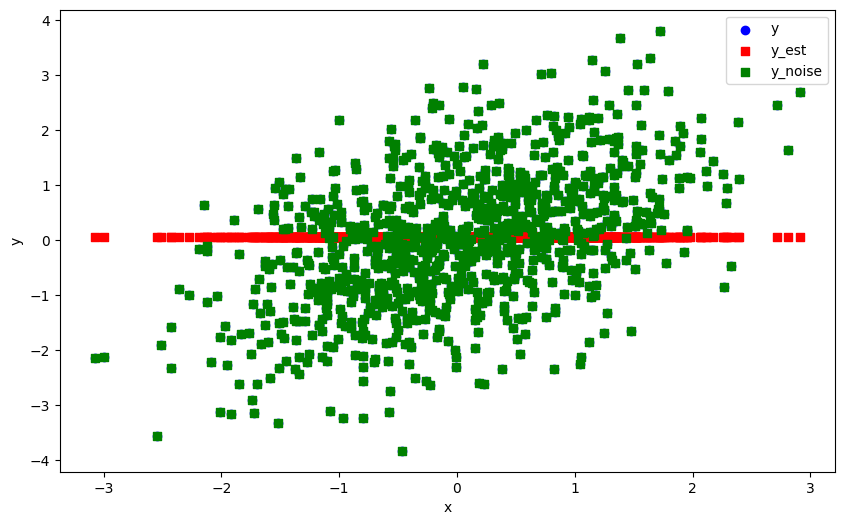

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

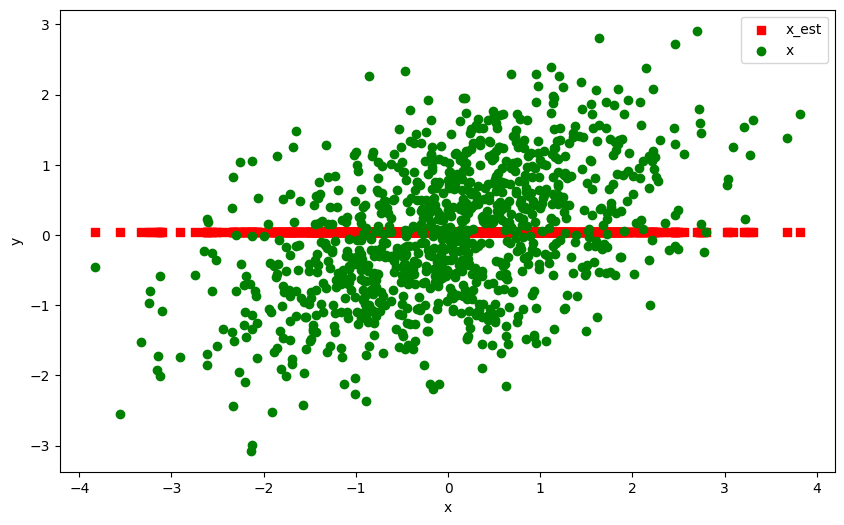

The programm is closed


In [10]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## Test Hessian estimation

In [47]:
class PolyFunc(torch.nn.Module):
    def forward(self, x):
        if x.dim() == 1:            # handle single vector
            x = x.unsqueeze(0)      # [1, d]
        # out = torch.stack([(x[:, 0]**2)*x[:, 1], x[:, 1]**3], dim=1)  # [n, d]
        out = torch.stack([x[:, 0], 10*torch.sin(x[:, 0])], dim=1)
        return out if out.size(0) > 1 else out.squeeze(0)

In [48]:
def exact_hessian_per_output(model, x: torch.Tensor):
    """
    model.forward: [n, d] -> [n, d]
    Returns H of shape [n, d, d, d], where H[i, k] = Hessian_x f_k(x_i)  (size [d, d])
    """
    x_req = x.detach().requires_grad_(True)
    n, d = x_req.shape

    # f_single: [d] -> [d]
    def f_single(x1):
        return model.forward(x1.unsqueeze(0)).squeeze(0)  # [d]

    # Scalarization: s(x; u) = <u, f(x)>, Hess_x s with u = e_k gives Hessian of f_k
    def s(x1, u1):  # x1:[d], u1:[d]
        return (f_single(x1) * u1).sum()

    # Hessian w.r.t. x only (treat u as constant)
    hess_x = torch.func.hessian(s, argnums=0)  # (x1, u1) -> [d, d]

    I = torch.eye(d, device=x.device)  # unit vectors e_k stacked as rows, shape [d, d]

    # For one sample xi: map u over e_k to get all outputs' Hessians -> [d(outputs), d, d]
    def hess_all_outputs_for_sample(xi):
        return torch.func.vmap(lambda u: hess_x(xi, u), in_dims=0)(I)  # [d, d, d]

    # Map over batch -> [n, d, d, d]
    H = torch.func.vmap(hess_all_outputs_for_sample, in_dims=0)(x_req)
    return H

In [49]:
def exact_hessian_diag_per_output(model, x: torch.Tensor):
    H = exact_hessian_per_output(model, x)  # [n, d, d, d]
    return torch.diagonal(H, dim1=-2, dim2=-1).abs().mean(dim = 0)  # [n, d, d]

In [50]:
model = PolyFunc()
x = torch.tensor([[2.0, 3.0], [4.0, 1.0]], requires_grad=True)  # two sample

H_full = exact_hessian_per_output(model, x)    # [1, 2, 2, 2]
H_diag = exact_hessian_diag_per_output(model, x)  # [1, 2, 2]

print("Full Hessians:\n", H_full)
print("Diagonal Hessians:\n", H_diag)

Full Hessians:
 tensor([[[[-0.0000, -0.0000],
          [ 0.0000,  0.0000]],

         [[-9.0930, -0.0000],
          [ 0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 7.5680,  0.0000],
          [ 0.0000,  0.0000]]]], grad_fn=<ViewBackward0>)
Diagonal Hessians:
 tensor([[0.0000, 0.0000],
        [8.3305, 0.0000]], grad_fn=<MeanBackward1>)


In [30]:
def get_Hessian(model, x: torch.Tensor) -> torch.Tensor:
        """Get the adjacency matrix defined by the DCE and the batched Jacobian

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor, torch.Tensor: the weighted graph and batched Jacobian
        """
        x_dummy = x.detach().requires_grad_()
        n, d = x.shape

        observed_deriv = torch.func.vmap(torch.func.jacrev(model.forward))(x_dummy).view(
            -1, d, d
        )#[n, d, d], observed_deriv[i, j, k]=for ith sample, derivative of f_j wrt x_k

        z = (torch.randint_like(observed_deriv, 0, 2).float() * 2 - 1) # [n, d, d]

        def g_single(xi, zi):
            J = torch.func.jacrev(model.forward)(xi)   # [d,d]
            return (J * zi).sum(dim=1) #[d]
        
        Hz  = torch.func.vmap(lambda xi, zi: torch.func.jacrev(lambda x_: g_single(x_, zi))(xi)
        )(x_dummy, z).view(-1, d, d) #[n, d, d]
        H_hat = (z*Hz).mean(dim=0) # [d, d] estimated Hessian of f_k wrt x_i, x_i

        return observed_deriv, H_hat

In [70]:
_, H_diag_hat = get_Hessian(model, x)
print("H_diag_hat: ", H_diag_hat)

H_diag_hat:  tensor([[-2., -6.],
        [ 0., 12.]], grad_fn=<MeanBackward1>)


In [51]:
def exact_hessian_diag_avg(model, x: torch.Tensor, batch_size: int = 256) -> torch.Tensor:
    """
    Exact per-output Hessian diagonals, averaged over a large batch.
    model.forward: [B, d] -> [B, d]
    x: [n, d]
    returns: [d, d] where out[k, i] = average over samples of ∂^2 f_k / ∂x_i^2
    """
    device = x.device
    n, d = x.shape
    out = torch.zeros(d, d, device=device)
    total = 0

    # per-sample wrapper so higher-order AD sees [d] -> [d]
    def f_single(x1):  # x1: [d] -> [d]
        return model.forward(x1.unsqueeze(0)).squeeze(0)

    # scalarization: s(x; u) = <u, f(x)>, Hess_x s with u = e_k gives Hessian of f_k
    def s(x1, u1):
        return (f_single(x1) * u1).sum()

    # Hessian wrt x only (treat u as constant)
    hess_x = torch.func.hessian(s, argnums=0)  # (x1, u1) -> [d, d]
    I = torch.eye(d, device=device)            # unit vectors e_k as rows

    # For one sample: stack all outputs' Hessians -> [d(outputs), d, d]
    def hess_all_outputs_for_sample(xi):
        return torch.func.vmap(lambda u: hess_x(xi, u), in_dims=0)(I)  # [d, d, d]

    with torch.no_grad():  # we only need numbers, not a backward graph
        for start in range(0, n, batch_size):
            xb = x[start:start+batch_size].detach().to(device).requires_grad_(True)
            # Map over the minibatch: [B, d, d, d]
            H = torch.func.vmap(hess_all_outputs_for_sample, in_dims=0)(xb)
            # Take diagonal over last two dims -> [B, d, d]
            Hdiag = torch.diagonal(H, dim1=-2, dim2=-1).contiguous() # extracts the diagonal of each Hessian
            out += Hdiag.abs().sum(dim=0)  # accumulate sum over this minibatch
            total += Hdiag.size(0)

    return out / total  # [d, d]

In [52]:
print(exact_hessian_diag_avg(model, x))

tensor([[0.0000, 0.0000],
        [8.3305, 0.0000]])


In [53]:
model = PolyFunc()
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples)
x = torch.tensor(epsilon, dtype=torch.float64)
print(exact_hessian_diag_avg(model, x))

tensor([[0.0000, 0.0000],
        [5.7114, 0.0000]])


## With non-linearity regularizer

### No Causal

In [2]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [3]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 0/29000 [00:00<?, ?it/s]

  0%|          | 118/29000 [00:01<04:05, 117.56it/s]

Sigma:  tensor([[1.0044, 0.0200],
        [0.0200, 1.0409]], grad_fn=<MmBackward0>)
obj:  tensor(2.3416, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3383, grad_fn=<AddBackward0>)
h_val:  tensor(7.5226e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0002, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0063, 0.0063],
        [0.0060, 0.0060]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1388e-06, 2.1297e-06],
        [1.7865e-06, 1.7928e-06]])


  1%|          | 221/29000 [00:02<03:54, 122.53it/s]

Sigma:  tensor([[0.9663, 0.0389],
        [0.0389, 1.0822]], grad_fn=<MmBackward0>)
obj:  tensor(2.2385, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2311, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0123, 0.0122],
        [0.0139, 0.0140]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6363e-05, 1.6161e-05],
        [1.7176e-05, 1.7337e-05]])


  1%|          | 324/29000 [00:03<03:53, 122.56it/s]

Sigma:  tensor([[0.9255, 0.0564],
        [0.0564, 1.1212]], grad_fn=<MmBackward0>)
obj:  tensor(2.1585, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1461, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0183, 0.0181],
        [0.0244, 0.0246]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.3696e-05, 5.2421e-05],
        [6.8859e-05, 7.0180e-05]])


  1%|▏         | 415/29000 [00:03<03:56, 121.11it/s]

Sigma:  tensor([[0.8881, 0.0725],
        [0.0725, 1.1544]], grad_fn=<MmBackward0>)
obj:  tensor(2.0848, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0251, 0.0246],
        [0.0375, 0.0381]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0001, 0.0001],
        [0.0002, 0.0002]])


  2%|▏         | 516/29000 [00:04<03:57, 120.14it/s]

Sigma:  tensor([[0.8564, 0.0872],
        [0.0872, 1.1776]], grad_fn=<MmBackward0>)
obj:  tensor(2.0075, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0331, 0.0322],
        [0.0531, 0.0545]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0002],
        [0.0004, 0.0004]])


  2%|▏         | 619/29000 [00:05<03:52, 121.96it/s]

Sigma:  tensor([[0.8290, 0.1004],
        [0.1004, 1.1871]], grad_fn=<MmBackward0>)
obj:  tensor(1.9262, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8896, grad_fn=<AddBackward0>)
h_val:  tensor(0.0074, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0021, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0427, 0.0411],
        [0.0712, 0.0738]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0005, 0.0004],
        [0.0008, 0.0009]])


  2%|▏         | 723/29000 [00:06<03:56, 119.47it/s]

Sigma:  tensor([[0.8034, 0.1120],
        [0.1120, 1.1808]], grad_fn=<MmBackward0>)
obj:  tensor(1.8390, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7907, grad_fn=<AddBackward0>)
h_val:  tensor(0.0124, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0544, 0.0518],
        [0.0911, 0.0959]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0008, 0.0007],
        [0.0014, 0.0016]])


  3%|▎         | 825/29000 [00:07<03:51, 121.60it/s]

Sigma:  tensor([[0.7771, 0.1217],
        [0.1217, 1.1596]], grad_fn=<MmBackward0>)
obj:  tensor(1.7432, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6814, grad_fn=<AddBackward0>)
h_val:  tensor(0.0196, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0685, 0.0643],
        [0.1126, 0.1205]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0012],
        [0.0022, 0.0025]])


  3%|▎         | 913/29000 [00:08<04:00, 116.67it/s]

Sigma:  tensor([[0.7484, 0.1289],
        [0.1289, 1.1266]], grad_fn=<MmBackward0>)
obj:  tensor(1.6377, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5610, grad_fn=<AddBackward0>)
h_val:  tensor(0.0299, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0853, 0.0790],
        [0.1349, 0.1475]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0021, 0.0018],
        [0.0033, 0.0039]])


  3%|▎         | 1013/29000 [00:08<03:55, 118.59it/s]

Sigma:  tensor([[0.7167, 0.1334],
        [0.1334, 1.0861]], grad_fn=<MmBackward0>)
obj:  tensor(1.5221, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4294, grad_fn=<AddBackward0>)
h_val:  tensor(0.0438, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1051, 0.0957],
        [0.1574, 0.1767]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0032, 0.0027],
        [0.0045, 0.0057]])


  4%|▍         | 1114/29000 [00:09<03:54, 119.16it/s]

Sigma:  tensor([[0.6828, 0.1346],
        [0.1346, 1.0412]], grad_fn=<MmBackward0>)
obj:  tensor(1.3964, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0622, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1279, 0.1141],
        [0.1791, 0.2080]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0048, 0.0038],
        [0.0059, 0.0080]])


  4%|▍         | 1212/29000 [00:10<04:31, 102.38it/s]

Sigma:  tensor([[0.6474, 0.1323],
        [0.1323, 0.9941]], grad_fn=<MmBackward0>)
obj:  tensor(1.2626, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0860, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1537, 0.1338],
        [0.1987, 0.2412]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0069, 0.0052],
        [0.0073, 0.0108]])


  5%|▍         | 1319/29000 [00:11<04:15, 108.21it/s]

Sigma:  tensor([[0.6116, 0.1262],
        [0.1262, 0.9459]], grad_fn=<MmBackward0>)
obj:  tensor(1.1261, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9724, grad_fn=<AddBackward0>)
h_val:  tensor(0.1159, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1824, 0.1538],
        [0.2151, 0.2758]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0095, 0.0068],
        [0.0086, 0.0140]])


  5%|▍         | 1418/29000 [00:12<03:48, 120.81it/s]

Sigma:  tensor([[0.5760, 0.1164],
        [0.1164, 0.8975]], grad_fn=<MmBackward0>)
obj:  tensor(0.9898, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8007, grad_fn=<AddBackward0>)
h_val:  tensor(0.1527, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2137, 0.1729],
        [0.2268, 0.3115]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0129, 0.0085],
        [0.0094, 0.0177]])


  5%|▌         | 1522/29000 [00:13<03:41, 123.84it/s]

Sigma:  tensor([[0.5411, 0.1035],
        [0.1035, 0.8492]], grad_fn=<MmBackward0>)
obj:  tensor(0.8532, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6202, grad_fn=<AddBackward0>)
h_val:  tensor(0.1968, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.8469e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2472, 0.1896],
        [0.2332, 0.3476]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0168, 0.0099],
        [0.0098, 0.0217]])


  6%|▌         | 1613/29000 [00:14<03:43, 122.31it/s]

Sigma:  tensor([[0.5076, 0.0885],
        [0.0885, 0.8018]], grad_fn=<MmBackward0>)
obj:  tensor(0.7194, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4316, grad_fn=<AddBackward0>)
h_val:  tensor(0.2484, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(8.1603e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2826, 0.2020],
        [0.2343, 0.3838]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0213, 0.0109],
        [0.0097, 0.0260]])


  6%|▌         | 1717/29000 [00:15<03:38, 124.77it/s]

Sigma:  tensor([[0.4757, 0.0725],
        [0.0725, 0.7559]], grad_fn=<MmBackward0>)
obj:  tensor(0.5873, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2364, grad_fn=<AddBackward0>)
h_val:  tensor(0.3077, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0002, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3195, 0.2083],
        [0.2312, 0.4193]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0263, 0.0112],
        [0.0092, 0.0304]])


  6%|▋         | 1821/29000 [00:16<03:38, 124.38it/s]

Sigma:  tensor([[0.4456, 0.0565],
        [0.0565, 0.7120]], grad_fn=<MmBackward0>)
obj:  tensor(0.4580, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0369, grad_fn=<AddBackward0>)
h_val:  tensor(0.3741, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3576, 0.2085],
        [0.2253, 0.4531]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0316, 0.0107],
        [0.0085, 0.0347]])


  7%|▋         | 1925/29000 [00:16<03:38, 123.66it/s]

Sigma:  tensor([[0.4173, 0.0412],
        [0.0412, 0.6706]], grad_fn=<MmBackward0>)
obj:  tensor(0.3338, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1633, grad_fn=<AddBackward0>)
h_val:  tensor(0.4464, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3963, 0.2036],
        [0.2188, 0.4843]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0372, 0.0098],
        [0.0079, 0.0390]])


  7%|▋         | 2016/29000 [00:17<03:37, 124.12it/s]

Sigma:  tensor([[0.3909, 0.0270],
        [0.0270, 0.6321]], grad_fn=<MmBackward0>)
obj:  tensor(0.2181, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3599, grad_fn=<AddBackward0>)
h_val:  tensor(0.5224, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4349, 0.1953],
        [0.2137, 0.5117]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0429, 0.0087],
        [0.0074, 0.0428]])


  7%|▋         | 2120/29000 [00:18<03:38, 122.81it/s]

Sigma:  tensor([[0.3663, 0.0142],
        [0.0142, 0.5965]], grad_fn=<MmBackward0>)
obj:  tensor(0.1100, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5487, grad_fn=<AddBackward0>)
h_val:  tensor(0.5990, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4724, 0.1851],
        [0.2118, 0.5344]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0488, 0.0075],
        [0.0072, 0.0462]])


  8%|▊         | 2224/29000 [00:19<03:34, 124.69it/s]

Sigma:  tensor([[0.3436, 0.0026],
        [0.0026, 0.5640]], grad_fn=<MmBackward0>)
obj:  tensor(0.0096, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7258, grad_fn=<AddBackward0>)
h_val:  tensor(0.6728, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5078, 0.1746],
        [0.2140, 0.5519]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0545, 0.0065],
        [0.0073, 0.0490]])


  8%|▊         | 2315/29000 [00:20<03:35, 123.90it/s]

Sigma:  tensor([[ 0.3225, -0.0079],
        [-0.0079,  0.5345]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0836, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8883, grad_fn=<AddBackward0>)
h_val:  tensor(0.7405, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5395, 0.1656],
        [0.2203, 0.5646]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0599, 0.0057],
        [0.0077, 0.0512]])


  8%|▊         | 2419/29000 [00:20<03:31, 125.55it/s]

Sigma:  tensor([[ 0.3032, -0.0178],
        [-0.0178,  0.5079]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1706, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0350, grad_fn=<AddBackward0>)
h_val:  tensor(0.7995, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5663, 0.1593],
        [0.2292, 0.5735]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0647, 0.0052],
        [0.0083, 0.0528]])


  9%|▊         | 2524/29000 [00:21<03:26, 128.35it/s]

Sigma:  tensor([[ 0.2854, -0.0272],
        [-0.0272,  0.4841]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2532, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1661, grad_fn=<AddBackward0>)
h_val:  tensor(0.8483, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0010, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5871, 0.1567],
        [0.2394, 0.5800]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0686, 0.0050],
        [0.0091, 0.0541]])


  9%|▉         | 2617/29000 [00:22<03:29, 126.05it/s]

Sigma:  tensor([[ 0.2692, -0.0365],
        [-0.0365,  0.4630]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3330, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2837, grad_fn=<AddBackward0>)
h_val:  tensor(0.8868, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6020, 0.1574],
        [0.2495, 0.5855]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0715, 0.0050],
        [0.0099, 0.0552]])


  9%|▉         | 2721/29000 [00:23<03:39, 119.94it/s]

Sigma:  tensor([[ 0.2544, -0.0458],
        [-0.0458,  0.4444]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4098, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3908, grad_fn=<AddBackward0>)
h_val:  tensor(0.9165, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6120, 0.1605],
        [0.2591, 0.5905]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0736, 0.0052],
        [0.0107, 0.0561]])


 10%|▉         | 2818/29000 [00:24<03:45, 116.04it/s]

Sigma:  tensor([[ 0.2410, -0.0551],
        [-0.0551,  0.4284]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4858, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4915, grad_fn=<AddBackward0>)
h_val:  tensor(0.9405, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6189, 0.1651],
        [0.2675, 0.5953]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0752, 0.0055],
        [0.0114, 0.0569]])


 10%|█         | 2918/29000 [00:25<03:39, 118.61it/s]

Sigma:  tensor([[ 0.2287, -0.0644],
        [-0.0644,  0.4147]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5617, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5891, grad_fn=<AddBackward0>)
h_val:  tensor(0.9617, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6247, 0.1703],
        [0.2760, 0.5995]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0765, 0.0058],
        [0.0121, 0.0575]])


 10%|█         | 3016/29000 [00:25<03:45, 115.34it/s]

Sigma:  tensor([[ 0.2175, -0.0737],
        [-0.0737,  0.4034]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6378, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6855, grad_fn=<AddBackward0>)
h_val:  tensor(0.9816, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6305, 0.1753],
        [0.2857, 0.6029]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0777, 0.0061],
        [0.0129, 0.0580]])


 11%|█         | 3117/29000 [00:26<03:33, 121.29it/s]

Sigma:  tensor([[ 0.2071, -0.0828],
        [-0.0828,  0.3942]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7142, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7810, grad_fn=<AddBackward0>)
h_val:  tensor(1.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6364, 0.1798],
        [0.2964, 0.6050]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0790, 0.0064],
        [0.0138, 0.0582]])


 11%|█         | 3216/29000 [00:27<03:38, 118.26it/s]

Sigma:  tensor([[ 0.1975, -0.0916],
        [-0.0916,  0.3873]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7912, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8753, grad_fn=<AddBackward0>)
h_val:  tensor(1.0170, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6424, 0.1838],
        [0.3075, 0.6061]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0801, 0.0066],
        [0.0148, 0.0581]])


 11%|█▏        | 3314/29000 [00:28<03:35, 119.03it/s]

Sigma:  tensor([[ 0.1885, -0.1002],
        [-0.1002,  0.3824]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8686, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9682, grad_fn=<AddBackward0>)
h_val:  tensor(1.0320, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6481, 0.1876],
        [0.3188, 0.6063]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0811, 0.0069],
        [0.0159, 0.0578]])


 12%|█▏        | 3418/29000 [00:29<03:38, 117.16it/s]

Sigma:  tensor([[ 0.1800, -0.1083],
        [-0.1083,  0.3795]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9466, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0598, grad_fn=<AddBackward0>)
h_val:  tensor(1.0453, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6535, 0.1910],
        [0.3305, 0.6058]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0819, 0.0071],
        [0.0170, 0.0574]])


 12%|█▏        | 3520/29000 [00:30<03:25, 123.86it/s]

Sigma:  tensor([[ 0.1721, -0.1161],
        [-0.1161,  0.3785]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0248, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1504, grad_fn=<AddBackward0>)
h_val:  tensor(1.0572, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6589, 0.1938],
        [0.3426, 0.6046]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0826, 0.0072],
        [0.0181, 0.0567]])


 12%|█▏        | 3622/29000 [00:31<03:39, 115.55it/s]

Sigma:  tensor([[ 0.1647, -0.1234],
        [-0.1234,  0.3792]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1033, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2403, grad_fn=<AddBackward0>)
h_val:  tensor(1.0681, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6642, 0.1960],
        [0.3550, 0.6027]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0831, 0.0073],
        [0.0193, 0.0558]])


 13%|█▎        | 3719/29000 [00:31<03:33, 118.61it/s]

Sigma:  tensor([[ 0.1576, -0.1303],
        [-0.1303,  0.3815]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1819, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3296, grad_fn=<AddBackward0>)
h_val:  tensor(1.0783, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6696, 0.1977],
        [0.3674, 0.6002]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0834, 0.0073],
        [0.0204, 0.0547]])


 13%|█▎        | 3817/29000 [00:32<03:32, 118.39it/s]

Sigma:  tensor([[ 0.1510, -0.1367],
        [-0.1367,  0.3853]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2604, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4182, grad_fn=<AddBackward0>)
h_val:  tensor(1.0877, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6751, 0.1988],
        [0.3799, 0.5971]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0836, 0.0073],
        [0.0216, 0.0535]])


 14%|█▎        | 3919/29000 [00:33<03:23, 123.01it/s]

Sigma:  tensor([[ 0.1447, -0.1427],
        [-0.1427,  0.3904]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3387, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5061, grad_fn=<AddBackward0>)
h_val:  tensor(1.0966, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6805, 0.1993],
        [0.3925, 0.5936]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0835, 0.0073],
        [0.0227, 0.0521]])


 14%|█▍        | 4023/29000 [00:34<03:20, 124.45it/s]

Sigma:  tensor([[ 0.1387, -0.1481],
        [-0.1481,  0.3968]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4168, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5933, grad_fn=<AddBackward0>)
h_val:  tensor(1.1050, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6859, 0.1994],
        [0.4052, 0.5897]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0831, 0.0071],
        [0.0239, 0.0506]])


 14%|█▍        | 4114/29000 [00:35<03:20, 124.03it/s]

Sigma:  tensor([[ 0.1330, -0.1532],
        [-0.1532,  0.4043]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4945, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6799, grad_fn=<AddBackward0>)
h_val:  tensor(1.1130, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6913, 0.1991],
        [0.4179, 0.5854]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0825, 0.0070],
        [0.0249, 0.0489]])


 15%|█▍        | 4219/29000 [00:36<03:15, 127.04it/s]

Sigma:  tensor([[ 0.1276, -0.1577],
        [-0.1577,  0.4129]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5719, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7658, grad_fn=<AddBackward0>)
h_val:  tensor(1.1207, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6967, 0.1983],
        [0.4306, 0.5808]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0817, 0.0067],
        [0.0259, 0.0472]])


 15%|█▍        | 4323/29000 [00:36<03:17, 125.03it/s]

Sigma:  tensor([[ 0.1225, -0.1619],
        [-0.1619,  0.4223]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6490, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8512, grad_fn=<AddBackward0>)
h_val:  tensor(1.1282, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7021, 0.1973],
        [0.4434, 0.5759]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0806, 0.0065],
        [0.0269, 0.0453]])


 15%|█▌        | 4414/29000 [00:37<03:18, 123.72it/s]

Sigma:  tensor([[ 0.1176, -0.1657],
        [-0.1657,  0.4326]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7256, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9361, grad_fn=<AddBackward0>)
h_val:  tensor(1.1355, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7074, 0.1959],
        [0.4561, 0.5708]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0793, 0.0062],
        [0.0278, 0.0434]])


 16%|█▌        | 4518/29000 [00:38<03:16, 124.78it/s]

Sigma:  tensor([[ 0.1130, -0.1691],
        [-0.1691,  0.4436]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8020, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0206, grad_fn=<AddBackward0>)
h_val:  tensor(1.1427, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7127, 0.1943],
        [0.4689, 0.5654]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0778, 0.0059],
        [0.0286, 0.0415]])


 16%|█▌        | 4622/29000 [00:39<03:15, 124.53it/s]

Sigma:  tensor([[ 0.1085, -0.1722],
        [-0.1722,  0.4554]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8780, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1046, grad_fn=<AddBackward0>)
h_val:  tensor(1.1498, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7179, 0.1925],
        [0.4815, 0.5599]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0761, 0.0056],
        [0.0293, 0.0395]])


 16%|█▋        | 4714/29000 [00:40<03:13, 125.22it/s]

Sigma:  tensor([[ 0.1043, -0.1749],
        [-0.1749,  0.4677]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9537, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1882, grad_fn=<AddBackward0>)
h_val:  tensor(1.1569, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7231, 0.1905],
        [0.4942, 0.5541]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0742, 0.0053],
        [0.0299, 0.0376]])


 17%|█▋        | 4817/29000 [00:41<05:38, 71.51it/s] 

Sigma:  tensor([[ 0.1002, -0.1773],
        [-0.1773,  0.4807]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2716, grad_fn=<AddBackward0>)
h_val:  tensor(1.1640, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7282, 0.1884],
        [0.5068, 0.5483]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0721, 0.0050],
        [0.0305, 0.0357]])


 17%|█▋        | 4923/29000 [00:42<03:39, 109.55it/s]

Sigma:  tensor([[ 0.0963, -0.1795],
        [-0.1795,  0.4941]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1042, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3547, grad_fn=<AddBackward0>)
h_val:  tensor(1.1712, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0010, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7332, 0.1862],
        [0.5193, 0.5423]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0700, 0.0046],
        [0.0310, 0.0338]])


 17%|█▋        | 5025/29000 [00:43<03:12, 124.38it/s]

Sigma:  tensor([[ 0.0926, -0.1814],
        [-0.1814,  0.5081]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1790, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4376, grad_fn=<AddBackward0>)
h_val:  tensor(1.1785, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0010, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7381, 0.1838],
        [0.5317, 0.5361]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0678, 0.0043],
        [0.0314, 0.0319]])


 18%|█▊        | 5116/29000 [00:43<03:10, 125.07it/s]

Sigma:  tensor([[ 0.0891, -0.1830],
        [-0.1830,  0.5225]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2535, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5203, grad_fn=<AddBackward0>)
h_val:  tensor(1.1860, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7430, 0.1814],
        [0.5441, 0.5300]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0655, 0.0040],
        [0.0318, 0.0302]])


 18%|█▊        | 5220/29000 [00:44<03:09, 125.46it/s]

Sigma:  tensor([[ 0.0857, -0.1845],
        [-0.1845,  0.5374]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3276, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6028, grad_fn=<AddBackward0>)
h_val:  tensor(1.1938, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7479, 0.1789],
        [0.5563, 0.5237]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0633, 0.0037],
        [0.0321, 0.0285]])


 18%|█▊        | 5324/29000 [00:45<03:07, 126.22it/s]

Sigma:  tensor([[ 0.0824, -0.1857],
        [-0.1857,  0.5526]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4013, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6851, grad_fn=<AddBackward0>)
h_val:  tensor(1.2017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7526, 0.1763],
        [0.5683, 0.5174]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0611, 0.0035],
        [0.0324, 0.0269]])


 19%|█▊        | 5415/29000 [00:46<03:09, 124.21it/s]

Sigma:  tensor([[ 0.0793, -0.1867],
        [-0.1867,  0.5683]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4746, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7672, grad_fn=<AddBackward0>)
h_val:  tensor(1.2100, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7573, 0.1736],
        [0.5802, 0.5112]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0589, 0.0032],
        [0.0327, 0.0253]])


 19%|█▉        | 5519/29000 [00:47<03:06, 126.07it/s]

Sigma:  tensor([[ 0.0763, -0.1875],
        [-0.1875,  0.5843]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5474, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8490, grad_fn=<AddBackward0>)
h_val:  tensor(1.2186, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7620, 0.1709],
        [0.5920, 0.5049]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0568, 0.0030],
        [0.0329, 0.0239]])


 19%|█▉        | 5623/29000 [00:47<03:05, 126.05it/s]

Sigma:  tensor([[ 0.0734, -0.1881],
        [-0.1881,  0.6005]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6198, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9306, grad_fn=<AddBackward0>)
h_val:  tensor(1.2275, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7665, 0.1682],
        [0.6035, 0.4986]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0548, 0.0028],
        [0.0331, 0.0226]])


 20%|█▉        | 5714/29000 [00:48<03:05, 125.86it/s]

Sigma:  tensor([[ 0.0706, -0.1886],
        [-0.1886,  0.6171]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6917, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0121, grad_fn=<AddBackward0>)
h_val:  tensor(1.2367, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7711, 0.1654],
        [0.6149, 0.4924]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0528, 0.0026],
        [0.0332, 0.0213]])


 20%|██        | 5818/29000 [00:49<03:04, 125.34it/s]

Sigma:  tensor([[ 0.0680, -0.1889],
        [-0.1889,  0.6338]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7631, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0932, grad_fn=<AddBackward0>)
h_val:  tensor(1.2462, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7755, 0.1626],
        [0.6261, 0.4862]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0509, 0.0025],
        [0.0333, 0.0201]])


 20%|██        | 5922/29000 [00:50<03:04, 124.77it/s]

Sigma:  tensor([[ 0.0654, -0.1891],
        [-0.1891,  0.6508]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8339, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1741, grad_fn=<AddBackward0>)
h_val:  tensor(1.2560, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7798, 0.1598],
        [0.6370, 0.4800]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0491, 0.0023],
        [0.0335, 0.0190]])


 21%|██        | 6013/29000 [00:51<03:07, 122.85it/s]

Sigma:  tensor([[ 0.0629, -0.1891],
        [-0.1891,  0.6680]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2548, grad_fn=<AddBackward0>)
h_val:  tensor(1.2661, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7841, 0.1570],
        [0.6478, 0.4740]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0474, 0.0022],
        [0.0336, 0.0180]])


 21%|██        | 6117/29000 [00:51<03:04, 123.92it/s]

Sigma:  tensor([[ 0.0606, -0.1890],
        [-0.1890,  0.6852]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9741, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3353, grad_fn=<AddBackward0>)
h_val:  tensor(1.2765, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7883, 0.1542],
        [0.6583, 0.4680]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0457, 0.0021],
        [0.0336, 0.0170]])


 21%|██▏       | 6221/29000 [00:52<03:02, 124.86it/s]

Sigma:  tensor([[ 0.0583, -0.1887],
        [-0.1887,  0.7026]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0435, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4154, grad_fn=<AddBackward0>)
h_val:  tensor(1.2873, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7925, 0.1514],
        [0.6686, 0.4622]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0441, 0.0020],
        [0.0337, 0.0161]])


 22%|██▏       | 6324/29000 [00:53<03:01, 125.02it/s]

Sigma:  tensor([[ 0.0561, -0.1883],
        [-0.1883,  0.7200]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1123, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4954, grad_fn=<AddBackward0>)
h_val:  tensor(1.2983, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7966, 0.1487],
        [0.6787, 0.4564]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0426, 0.0019],
        [0.0338, 0.0153]])


 22%|██▏       | 6416/29000 [00:54<03:00, 125.45it/s]

Sigma:  tensor([[ 0.0540, -0.1878],
        [-0.1878,  0.7374]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1807, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5751, grad_fn=<AddBackward0>)
h_val:  tensor(1.3095, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.8005, 0.1459],
        [0.6886, 0.4507]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0411, 0.0018],
        [0.0339, 0.0145]])


 22%|██▏       | 6520/29000 [00:55<02:58, 125.70it/s]

Sigma:  tensor([[ 0.0520, -0.1872],
        [-0.1872,  0.7548]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2486, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6547, grad_fn=<AddBackward0>)
h_val:  tensor(1.3210, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.8045, 0.1432],
        [0.6983, 0.4451]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0396, 0.0017],
        [0.0339, 0.0138]])


 23%|██▎       | 6624/29000 [00:56<02:58, 125.68it/s]

Sigma:  tensor([[ 0.0501, -0.1864],
        [-0.1864,  0.7722]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3162, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7341, grad_fn=<AddBackward0>)
h_val:  tensor(1.3328, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.8083, 0.1405],
        [0.7077, 0.4395]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0382, 0.0016],
        [0.0340, 0.0132]])


 23%|██▎       | 6715/29000 [00:56<02:58, 125.03it/s]

Sigma:  tensor([[ 0.0482, -0.1856],
        [-0.1856,  0.7895]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3835, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8134, grad_fn=<AddBackward0>)
h_val:  tensor(1.3447, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.8121, 0.1379],
        [0.7169, 0.4341]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0368, 0.0016],
        [0.0340, 0.0125]])


 24%|██▎       | 6820/29000 [00:57<02:55, 126.31it/s]

Sigma:  tensor([[ 0.0464, -0.1847],
        [-0.1847,  0.8069]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4506, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8927, grad_fn=<AddBackward0>)
h_val:  tensor(1.3569, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.8158, 0.1353],
        [0.7259, 0.4287]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0355, 0.0015],
        [0.0340, 0.0119]])


 24%|██▍       | 6924/29000 [00:58<02:54, 126.20it/s]

Sigma:  tensor([[ 0.0447, -0.1837],
        [-0.1837,  0.8241]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5175, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9720, grad_fn=<AddBackward0>)
h_val:  tensor(1.3693, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.8195, 0.1328],
        [0.7346, 0.4235]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0342, 0.0015],
        [0.0340, 0.0114]])


 25%|██▍       | 7120/29000 [01:00<02:53, 126.19it/s]

Sigma:  tensor([[ 0.0426, -0.1791],
        [-0.1791,  0.8172]], grad_fn=<MmBackward0>)
obj:  tensor(0.6941, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1834, grad_fn=<AddBackward0>)
h_val:  tensor(1.1035, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7694, 0.1526],
        [0.7572, 0.3695]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0284, 0.0019],
        [0.0353, 0.0085]])


 25%|██▍       | 7224/29000 [01:00<02:53, 125.20it/s]

Sigma:  tensor([[ 0.0442, -0.1779],
        [-0.1779,  0.7803]], grad_fn=<MmBackward0>)
obj:  tensor(0.6042, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5761, grad_fn=<AddBackward0>)
h_val:  tensor(0.9521, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7319, 0.1784],
        [0.8130, 0.3216]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0256, 0.0023],
        [0.0405, 0.0064]])


 25%|██▌       | 7315/29000 [01:01<02:52, 125.67it/s]

Sigma:  tensor([[ 0.0461, -0.1771],
        [-0.1771,  0.7426]], grad_fn=<MmBackward0>)
obj:  tensor(0.5313, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7269, grad_fn=<AddBackward0>)
h_val:  tensor(0.8939, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7170, 0.1887],
        [0.8815, 0.2794]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0246, 0.0025],
        [0.0471, 0.0048]])


 26%|██▌       | 7419/29000 [01:02<02:52, 125.22it/s]

Sigma:  tensor([[ 0.0480, -0.1763],
        [-0.1763,  0.7084]], grad_fn=<MmBackward0>)
obj:  tensor(0.4785, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8036, grad_fn=<AddBackward0>)
h_val:  tensor(0.8485, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.7026, 0.1978],
        [0.9467, 0.2430]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0235, 0.0027],
        [0.0543, 0.0036]])


 26%|██▌       | 7523/29000 [01:03<02:49, 126.52it/s]

Sigma:  tensor([[ 0.0497, -0.1754],
        [-0.1754,  0.6790]], grad_fn=<MmBackward0>)
obj:  tensor(0.4373, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6561, grad_fn=<AddBackward0>)
h_val:  tensor(0.7925, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6797, 0.2108],
        [1.0032, 0.2151]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0220, 0.0029],
        [0.0607, 0.0028]])


 26%|██▋       | 7614/29000 [01:04<02:51, 124.88it/s]

Sigma:  tensor([[ 0.0513, -0.1747],
        [-0.1747,  0.6521]], grad_fn=<MmBackward0>)
obj:  tensor(0.4064, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4773, grad_fn=<AddBackward0>)
h_val:  tensor(0.7436, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6560, 0.2214],
        [1.0538, 0.1964]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0203, 0.0032],
        [0.0668, 0.0024]])


 27%|██▋       | 7718/29000 [01:04<02:51, 124.25it/s]

Sigma:  tensor([[ 0.0530, -0.1740],
        [-0.1740,  0.6264]], grad_fn=<MmBackward0>)
obj:  tensor(0.3835, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3834, grad_fn=<AddBackward0>)
h_val:  tensor(0.7113, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6363, 0.2289],
        [1.0997, 0.1873]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0190, 0.0033],
        [0.0730, 0.0022]])


 27%|██▋       | 7822/29000 [01:05<02:50, 124.36it/s]

Sigma:  tensor([[ 0.0547, -0.1734],
        [-0.1734,  0.6032]], grad_fn=<MmBackward0>)
obj:  tensor(0.3662, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3012, grad_fn=<AddBackward0>)
h_val:  tensor(0.6857, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6183, 0.2338],
        [1.1369, 0.1873]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0178, 0.0034],
        [0.0783, 0.0022]])


 27%|██▋       | 7925/29000 [01:06<02:51, 123.22it/s]

Sigma:  tensor([[ 0.0563, -0.1730],
        [-0.1730,  0.5829]], grad_fn=<MmBackward0>)
obj:  tensor(0.3525, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2128, grad_fn=<AddBackward0>)
h_val:  tensor(0.6631, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.6010, 0.2378],
        [1.1630, 0.1940]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0167, 0.0035],
        [0.0822, 0.0023]])


 28%|██▊       | 8016/29000 [01:07<02:48, 124.24it/s]

Sigma:  tensor([[ 0.0579, -0.1727],
        [-0.1727,  0.5643]], grad_fn=<MmBackward0>)
obj:  tensor(0.3414, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1495, grad_fn=<AddBackward0>)
h_val:  tensor(0.6456, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5861, 0.2410],
        [1.1798, 0.2039]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0157, 0.0036],
        [0.0848, 0.0026]])


 28%|██▊       | 8120/29000 [01:08<02:46, 125.39it/s]

Sigma:  tensor([[ 0.0596, -0.1726],
        [-0.1726,  0.5470]], grad_fn=<MmBackward0>)
obj:  tensor(0.3321, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1097, grad_fn=<AddBackward0>)
h_val:  tensor(0.6322, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5737, 0.2440],
        [1.1882, 0.2140]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0149, 0.0037],
        [0.0862, 0.0028]])


 28%|██▊       | 8224/29000 [01:08<02:44, 126.10it/s]

Sigma:  tensor([[ 0.0613, -0.1726],
        [-0.1726,  0.5311]], grad_fn=<MmBackward0>)
obj:  tensor(0.3238, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0807, grad_fn=<AddBackward0>)
h_val:  tensor(0.6210, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5630, 0.2478],
        [1.1885, 0.2226]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0143, 0.0038],
        [0.0861, 0.0031]])


 29%|██▊       | 8315/29000 [01:09<02:45, 124.93it/s]

Sigma:  tensor([[ 0.0631, -0.1728],
        [-0.1728,  0.5163]], grad_fn=<MmBackward0>)
obj:  tensor(0.3161, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0646, grad_fn=<AddBackward0>)
h_val:  tensor(0.6117, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5540, 0.2525],
        [1.1823, 0.2292]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0138, 0.0039],
        [0.0849, 0.0032]])


 29%|██▉       | 8419/29000 [01:10<02:47, 122.80it/s]

Sigma:  tensor([[ 0.0649, -0.1730],
        [-0.1730,  0.5024]], grad_fn=<MmBackward0>)
obj:  tensor(0.3088, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0618, grad_fn=<AddBackward0>)
h_val:  tensor(0.6042, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5466, 0.2578],
        [1.1713, 0.2345]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0135, 0.0040],
        [0.0830, 0.0034]])


 29%|██▉       | 8517/29000 [01:11<02:54, 117.38it/s]

Sigma:  tensor([[ 0.0669, -0.1734],
        [-0.1734,  0.4893]], grad_fn=<MmBackward0>)
obj:  tensor(0.3017, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0683, grad_fn=<AddBackward0>)
h_val:  tensor(0.5978, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5402, 0.2636],
        [1.1568, 0.2391]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0132, 0.0042],
        [0.0805, 0.0035]])


 30%|██▉       | 8614/29000 [01:12<02:51, 118.62it/s]

Sigma:  tensor([[ 0.0689, -0.1738],
        [-0.1738,  0.4769]], grad_fn=<MmBackward0>)
obj:  tensor(0.2948, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0823, grad_fn=<AddBackward0>)
h_val:  tensor(0.5923, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5345, 0.2695],
        [1.1402, 0.2438]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0129, 0.0043],
        [0.0777, 0.0036]])


 30%|███       | 8718/29000 [01:13<02:42, 124.67it/s]

Sigma:  tensor([[ 0.0710, -0.1744],
        [-0.1744,  0.4651]], grad_fn=<MmBackward0>)
obj:  tensor(0.2881, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1017, grad_fn=<AddBackward0>)
h_val:  tensor(0.5875, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5294, 0.2756],
        [1.1224, 0.2486]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0127, 0.0043],
        [0.0748, 0.0037]])


 30%|███       | 8822/29000 [01:13<02:41, 125.08it/s]

Sigma:  tensor([[ 0.0731, -0.1750],
        [-0.1750,  0.4539]], grad_fn=<MmBackward0>)
obj:  tensor(0.2815, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1237, grad_fn=<AddBackward0>)
h_val:  tensor(0.5832, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5245, 0.2817],
        [1.1043, 0.2535]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0125, 0.0044],
        [0.0719, 0.0038]])


 31%|███       | 8913/29000 [01:14<02:40, 124.97it/s]

Sigma:  tensor([[ 0.0754, -0.1757],
        [-0.1757,  0.4432]], grad_fn=<MmBackward0>)
obj:  tensor(0.2752, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1469, grad_fn=<AddBackward0>)
h_val:  tensor(0.5792, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5197, 0.2878],
        [1.0864, 0.2582]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0123, 0.0045],
        [0.0691, 0.0039]])


 31%|███       | 9017/29000 [01:15<02:39, 125.55it/s]

Sigma:  tensor([[ 0.0777, -0.1764],
        [-0.1764,  0.4331]], grad_fn=<MmBackward0>)
obj:  tensor(0.2690, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1705, grad_fn=<AddBackward0>)
h_val:  tensor(0.5755, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5150, 0.2941],
        [1.0689, 0.2628]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0121, 0.0046],
        [0.0664, 0.0041]])


 31%|███▏      | 9121/29000 [01:16<02:37, 125.89it/s]

Sigma:  tensor([[ 0.0801, -0.1773],
        [-0.1773,  0.4236]], grad_fn=<MmBackward0>)
obj:  tensor(0.2631, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1944, grad_fn=<AddBackward0>)
h_val:  tensor(0.5719, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5102, 0.3004],
        [1.0521, 0.2673]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0119, 0.0047],
        [0.0638, 0.0042]])


 32%|███▏      | 9225/29000 [01:17<02:36, 126.22it/s]

Sigma:  tensor([[ 0.0825, -0.1782],
        [-0.1782,  0.4148]], grad_fn=<MmBackward0>)
obj:  tensor(0.2573, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2188, grad_fn=<AddBackward0>)
h_val:  tensor(0.5687, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5055, 0.3067],
        [1.0361, 0.2718]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0117, 0.0049],
        [0.0614, 0.0043]])


 32%|███▏      | 9316/29000 [01:17<02:37, 125.11it/s]

Sigma:  tensor([[ 0.0851, -0.1793],
        [-0.1793,  0.4066]], grad_fn=<MmBackward0>)
obj:  tensor(0.2518, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2441, grad_fn=<AddBackward0>)
h_val:  tensor(0.5657, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.5009, 0.3129],
        [1.0208, 0.2762]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0115, 0.0050],
        [0.0591, 0.0044]])


 32%|███▏      | 9420/29000 [01:18<02:36, 124.93it/s]

Sigma:  tensor([[ 0.0876, -0.1804],
        [-0.1804,  0.3991]], grad_fn=<MmBackward0>)
obj:  tensor(0.2464, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2704, grad_fn=<AddBackward0>)
h_val:  tensor(0.5629, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4963, 0.3190],
        [1.0062, 0.2805]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0114, 0.0052],
        [0.0569, 0.0045]])


 33%|███▎      | 9524/29000 [01:19<02:34, 125.72it/s]

Sigma:  tensor([[ 0.0903, -0.1817],
        [-0.1817,  0.3922]], grad_fn=<MmBackward0>)
obj:  tensor(0.2412, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2978, grad_fn=<AddBackward0>)
h_val:  tensor(0.5605, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4918, 0.3251],
        [0.9925, 0.2846]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0112, 0.0053],
        [0.0549, 0.0046]])


 33%|███▎      | 9615/29000 [01:20<02:36, 123.89it/s]

Sigma:  tensor([[ 0.0930, -0.1831],
        [-0.1831,  0.3860]], grad_fn=<MmBackward0>)
obj:  tensor(0.2361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3265, grad_fn=<AddBackward0>)
h_val:  tensor(0.5584, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4875, 0.3311],
        [0.9794, 0.2886]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0110, 0.0055],
        [0.0529, 0.0046]])


 34%|███▎      | 9719/29000 [01:21<02:33, 125.34it/s]

Sigma:  tensor([[ 0.0957, -0.1846],
        [-0.1846,  0.3805]], grad_fn=<MmBackward0>)
obj:  tensor(0.2312, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3565, grad_fn=<AddBackward0>)
h_val:  tensor(0.5566, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4832, 0.3369],
        [0.9671, 0.2924]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0108, 0.0056],
        [0.0511, 0.0047]])


 34%|███▍      | 9824/29000 [01:22<02:43, 117.31it/s]

Sigma:  tensor([[ 0.0985, -0.1862],
        [-0.1862,  0.3756]], grad_fn=<MmBackward0>)
obj:  tensor(0.2265, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3880, grad_fn=<AddBackward0>)
h_val:  tensor(0.5550, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4792, 0.3427],
        [0.9555, 0.2960]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0107, 0.0058],
        [0.0493, 0.0048]])


 34%|███▍      | 9915/29000 [01:23<02:33, 124.00it/s]

Sigma:  tensor([[ 0.1013, -0.1879],
        [-0.1879,  0.3712]], grad_fn=<MmBackward0>)
obj:  tensor(0.2219, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4208, grad_fn=<AddBackward0>)
h_val:  tensor(0.5538, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4753, 0.3482],
        [0.9446, 0.2995]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0105, 0.0059],
        [0.0477, 0.0048]])


 35%|███▍      | 10019/29000 [01:23<02:32, 124.53it/s]

Sigma:  tensor([[ 0.1042, -0.1898],
        [-0.1898,  0.3674]], grad_fn=<MmBackward0>)
obj:  tensor(0.2174, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4549, grad_fn=<AddBackward0>)
h_val:  tensor(0.5528, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4715, 0.3537],
        [0.9344, 0.3028]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0103, 0.0061],
        [0.0461, 0.0049]])


 35%|███▍      | 10123/29000 [01:24<02:30, 125.56it/s]

Sigma:  tensor([[ 0.1070, -0.1917],
        [-0.1917,  0.3640]], grad_fn=<MmBackward0>)
obj:  tensor(0.2131, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4902, grad_fn=<AddBackward0>)
h_val:  tensor(0.5520, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4679, 0.3590],
        [0.9248, 0.3059]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0102, 0.0063],
        [0.0446, 0.0049]])


 35%|███▌      | 10214/29000 [01:25<02:30, 124.98it/s]

Sigma:  tensor([[ 0.1099, -0.1937],
        [-0.1937,  0.3611]], grad_fn=<MmBackward0>)
obj:  tensor(0.2089, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5266, grad_fn=<AddBackward0>)
h_val:  tensor(0.5515, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4645, 0.3641],
        [0.9158, 0.3089]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0100, 0.0064],
        [0.0432, 0.0050]])


 36%|███▌      | 10318/29000 [01:26<02:34, 121.21it/s]

Sigma:  tensor([[ 0.1128, -0.1957],
        [-0.1957,  0.3586]], grad_fn=<MmBackward0>)
obj:  tensor(0.2048, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5639, grad_fn=<AddBackward0>)
h_val:  tensor(0.5511, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4612, 0.3691],
        [0.9073, 0.3118]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0099, 0.0066],
        [0.0419, 0.0050]])


 36%|███▌      | 10419/29000 [01:27<02:35, 119.16it/s]

Sigma:  tensor([[ 0.1157, -0.1977],
        [-0.1977,  0.3564]], grad_fn=<MmBackward0>)
obj:  tensor(0.2008, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6022, grad_fn=<AddBackward0>)
h_val:  tensor(0.5510, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4581, 0.3739],
        [0.8994, 0.3145]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0097, 0.0067],
        [0.0406, 0.0050]])


 36%|███▋      | 10522/29000 [01:28<02:27, 125.03it/s]

Sigma:  tensor([[ 0.1186, -0.1998],
        [-0.1998,  0.3544]], grad_fn=<MmBackward0>)
obj:  tensor(0.1970, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6411, grad_fn=<AddBackward0>)
h_val:  tensor(0.5510, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4552, 0.3786],
        [0.8919, 0.3171]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0096, 0.0069],
        [0.0393, 0.0050]])


 37%|███▋      | 10626/29000 [01:28<02:26, 125.79it/s]

Sigma:  tensor([[ 0.1214, -0.2019],
        [-0.2019,  0.3527]], grad_fn=<MmBackward0>)
obj:  tensor(0.1932, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6808, grad_fn=<AddBackward0>)
h_val:  tensor(0.5511, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4523, 0.3831],
        [0.8848, 0.3196]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0095, 0.0070],
        [0.0381, 0.0050]])


 37%|███▋      | 10717/29000 [01:29<02:27, 124.12it/s]

Sigma:  tensor([[ 0.1242, -0.2040],
        [-0.2040,  0.3511]], grad_fn=<MmBackward0>)
obj:  tensor(0.1894, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7210, grad_fn=<AddBackward0>)
h_val:  tensor(0.5514, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4496, 0.3875],
        [0.8781, 0.3220]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0093, 0.0071],
        [0.0369, 0.0050]])


 37%|███▋      | 10821/29000 [01:30<02:25, 125.11it/s]

Sigma:  tensor([[ 0.1270, -0.2060],
        [-0.2060,  0.3497]], grad_fn=<MmBackward0>)
obj:  tensor(0.1858, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7618, grad_fn=<AddBackward0>)
h_val:  tensor(0.5518, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4471, 0.3917],
        [0.8718, 0.3243]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0092, 0.0072],
        [0.0358, 0.0050]])


 38%|███▊      | 10925/29000 [01:31<02:25, 124.21it/s]

Sigma:  tensor([[ 0.1297, -0.2080],
        [-0.2080,  0.3485]], grad_fn=<MmBackward0>)
obj:  tensor(0.1822, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8031, grad_fn=<AddBackward0>)
h_val:  tensor(0.5523, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4447, 0.3957],
        [0.8658, 0.3265]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0091, 0.0073],
        [0.0347, 0.0050]])


 38%|███▊      | 11016/29000 [01:32<02:24, 124.80it/s]

Sigma:  tensor([[ 0.1324, -0.2100],
        [-0.2100,  0.3474]], grad_fn=<MmBackward0>)
obj:  tensor(0.1787, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8449, grad_fn=<AddBackward0>)
h_val:  tensor(0.5529, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4425, 0.3996],
        [0.8602, 0.3286]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0089, 0.0074],
        [0.0337, 0.0050]])


 38%|███▊      | 11120/29000 [01:32<02:21, 126.16it/s]

Sigma:  tensor([[ 0.1350, -0.2119],
        [-0.2119,  0.3463]], grad_fn=<MmBackward0>)
obj:  tensor(0.1752, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8871, grad_fn=<AddBackward0>)
h_val:  tensor(0.5536, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4404, 0.4033],
        [0.8549, 0.3307]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0088, 0.0075],
        [0.0327, 0.0049]])


 39%|███▊      | 11224/29000 [01:33<02:21, 125.51it/s]

Sigma:  tensor([[ 0.1375, -0.2137],
        [-0.2137,  0.3454]], grad_fn=<MmBackward0>)
obj:  tensor(0.1717, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9297, grad_fn=<AddBackward0>)
h_val:  tensor(0.5543, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4384, 0.4069],
        [0.8500, 0.3326]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0087, 0.0076],
        [0.0317, 0.0049]])


 39%|███▉      | 11315/29000 [01:34<02:20, 125.78it/s]

Sigma:  tensor([[ 0.1399, -0.2155],
        [-0.2155,  0.3446]], grad_fn=<MmBackward0>)
obj:  tensor(0.1683, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9728, grad_fn=<AddBackward0>)
h_val:  tensor(0.5552, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4366, 0.4102],
        [0.8455, 0.3344]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0085, 0.0077],
        [0.0307, 0.0049]])


 39%|███▉      | 11419/29000 [01:35<02:20, 124.93it/s]

Sigma:  tensor([[ 0.1422, -0.2172],
        [-0.2172,  0.3438]], grad_fn=<MmBackward0>)
obj:  tensor(0.1649, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0162, grad_fn=<AddBackward0>)
h_val:  tensor(0.5561, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0034, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4349, 0.4134],
        [0.8412, 0.3362]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0084, 0.0077],
        [0.0298, 0.0048]])


 40%|███▉      | 11523/29000 [01:36<02:19, 125.20it/s]

Sigma:  tensor([[ 0.1444, -0.2188],
        [-0.2188,  0.3431]], grad_fn=<MmBackward0>)
obj:  tensor(0.1616, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0601, grad_fn=<AddBackward0>)
h_val:  tensor(0.5570, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0035, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4334, 0.4163],
        [0.8374, 0.3378]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0083, 0.0077],
        [0.0289, 0.0048]])


 40%|████      | 11626/29000 [01:37<02:19, 124.33it/s]

Sigma:  tensor([[ 0.1464, -0.2203],
        [-0.2203,  0.3425]], grad_fn=<MmBackward0>)
obj:  tensor(0.1582, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1044, grad_fn=<AddBackward0>)
h_val:  tensor(0.5580, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0035, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4320, 0.4191],
        [0.8339, 0.3394]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0082, 0.0078],
        [0.0281, 0.0047]])


 40%|████      | 11717/29000 [01:37<02:18, 124.83it/s]

Sigma:  tensor([[ 0.1483, -0.2217],
        [-0.2217,  0.3420]], grad_fn=<MmBackward0>)
obj:  tensor(0.1549, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1491, grad_fn=<AddBackward0>)
h_val:  tensor(0.5591, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0036, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4307, 0.4216],
        [0.8308, 0.3408]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0080, 0.0078],
        [0.0273, 0.0047]])


 41%|████      | 11821/29000 [01:38<02:17, 125.11it/s]

Sigma:  tensor([[ 0.1501, -0.2230],
        [-0.2230,  0.3416]], grad_fn=<MmBackward0>)
obj:  tensor(0.1515, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1943, grad_fn=<AddBackward0>)
h_val:  tensor(0.5602, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0037, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4296, 0.4240],
        [0.8280, 0.3422]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0079, 0.0078],
        [0.0265, 0.0046]])


 41%|████      | 11925/29000 [01:39<02:14, 126.79it/s]

Sigma:  tensor([[ 0.1517, -0.2242],
        [-0.2242,  0.3412]], grad_fn=<MmBackward0>)
obj:  tensor(0.1481, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2399, grad_fn=<AddBackward0>)
h_val:  tensor(0.5613, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0038, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4287, 0.4260],
        [0.8256, 0.3434]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0078, 0.0077],
        [0.0258, 0.0046]])


 41%|████▏     | 12017/29000 [01:40<02:18, 122.42it/s]

Sigma:  tensor([[ 0.1531, -0.2253],
        [-0.2253,  0.3409]], grad_fn=<MmBackward0>)
obj:  tensor(0.1448, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2859, grad_fn=<AddBackward0>)
h_val:  tensor(0.5624, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4278, 0.4279],
        [0.8235, 0.3445]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0076, 0.0077],
        [0.0251, 0.0045]])


 42%|████▏     | 12118/29000 [01:41<02:24, 116.93it/s]

Sigma:  tensor([[ 0.1543, -0.2262],
        [-0.2262,  0.3407]], grad_fn=<MmBackward0>)
obj:  tensor(0.1414, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3323, grad_fn=<AddBackward0>)
h_val:  tensor(0.5635, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4272, 0.4296],
        [0.8218, 0.3456]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0075, 0.0076],
        [0.0244, 0.0044]])


 42%|████▏     | 12214/29000 [01:41<02:25, 115.31it/s]

Sigma:  tensor([[ 0.1554, -0.2271],
        [-0.2271,  0.3405]], grad_fn=<MmBackward0>)
obj:  tensor(0.1380, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3792, grad_fn=<AddBackward0>)
h_val:  tensor(0.5647, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0041, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4266, 0.4310],
        [0.8204, 0.3465]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0074, 0.0076],
        [0.0238, 0.0044]])


 42%|████▏     | 12314/29000 [01:42<02:15, 123.11it/s]

Sigma:  tensor([[ 0.1563, -0.2279],
        [-0.2279,  0.3404]], grad_fn=<MmBackward0>)
obj:  tensor(0.1345, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4264, grad_fn=<AddBackward0>)
h_val:  tensor(0.5659, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0042, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4262, 0.4322],
        [0.8194, 0.3473]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0073, 0.0075],
        [0.0232, 0.0043]])


 43%|████▎     | 12418/29000 [01:43<02:12, 125.36it/s]

Sigma:  tensor([[ 0.1571, -0.2285],
        [-0.2285,  0.3403]], grad_fn=<MmBackward0>)
obj:  tensor(0.1311, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4741, grad_fn=<AddBackward0>)
h_val:  tensor(0.5670, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0044, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4260, 0.4331],
        [0.8187, 0.3481]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0071, 0.0074],
        [0.0226, 0.0042]])


 43%|████▎     | 12522/29000 [01:44<02:12, 124.33it/s]

Sigma:  tensor([[ 0.1577, -0.2290],
        [-0.2290,  0.3403]], grad_fn=<MmBackward0>)
obj:  tensor(0.1276, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5222, grad_fn=<AddBackward0>)
h_val:  tensor(0.5682, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0045, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4258, 0.4339],
        [0.8183, 0.3487]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0070, 0.0073],
        [0.0220, 0.0042]])


 44%|████▎     | 12626/29000 [01:45<02:09, 126.27it/s]

Sigma:  tensor([[ 0.1581, -0.2295],
        [-0.2295,  0.3404]], grad_fn=<MmBackward0>)
obj:  tensor(0.1240, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5707, grad_fn=<AddBackward0>)
h_val:  tensor(0.5694, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0046, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4258, 0.4345],
        [0.8182, 0.3492]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0068, 0.0072],
        [0.0214, 0.0041]])


 44%|████▍     | 12717/29000 [01:46<02:12, 122.77it/s]

Sigma:  tensor([[ 0.1584, -0.2298],
        [-0.2298,  0.3405]], grad_fn=<MmBackward0>)
obj:  tensor(0.1204, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6197, grad_fn=<AddBackward0>)
h_val:  tensor(0.5705, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0048, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4259, 0.4349],
        [0.8184, 0.3497]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0067, 0.0070],
        [0.0209, 0.0040]])


 44%|████▍     | 12822/29000 [01:46<02:07, 127.38it/s]

Sigma:  tensor([[ 0.1586, -0.2301],
        [-0.2301,  0.3407]], grad_fn=<MmBackward0>)
obj:  tensor(0.1168, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6690, grad_fn=<AddBackward0>)
h_val:  tensor(0.5716, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0050, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4261, 0.4351],
        [0.8188, 0.3500]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0066, 0.0068],
        [0.0204, 0.0039]])


 45%|████▍     | 12913/29000 [01:47<02:08, 124.73it/s]

Sigma:  tensor([[ 0.1586, -0.2303],
        [-0.2303,  0.3409]], grad_fn=<MmBackward0>)
obj:  tensor(0.1131, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7187, grad_fn=<AddBackward0>)
h_val:  tensor(0.5728, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0051, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4264, 0.4351],
        [0.8195, 0.3503]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0064, 0.0067],
        [0.0199, 0.0039]])


 45%|████▍     | 13017/29000 [01:48<02:07, 125.32it/s]

Sigma:  tensor([[ 0.1585, -0.2304],
        [-0.2304,  0.3412]], grad_fn=<MmBackward0>)
obj:  tensor(0.1094, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7689, grad_fn=<AddBackward0>)
h_val:  tensor(0.5739, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0053, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4267, 0.4350],
        [0.8204, 0.3505]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0063, 0.0065],
        [0.0193, 0.0038]])


 45%|████▌     | 13121/29000 [01:49<02:05, 126.07it/s]

Sigma:  tensor([[ 0.1583, -0.2305],
        [-0.2305,  0.3415]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8195, grad_fn=<AddBackward0>)
h_val:  tensor(0.5750, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0055, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4272, 0.4348],
        [0.8215, 0.3506]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0061, 0.0063],
        [0.0188, 0.0037]])


 46%|████▌     | 13226/29000 [01:50<02:04, 126.84it/s]

Sigma:  tensor([[ 0.1580, -0.2305],
        [-0.2305,  0.3419]], grad_fn=<MmBackward0>)
obj:  tensor(0.1018, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8705, grad_fn=<AddBackward0>)
h_val:  tensor(0.5761, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0057, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4277, 0.4344],
        [0.8228, 0.3507]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0060, 0.0061],
        [0.0183, 0.0035]])


 46%|████▌     | 13317/29000 [01:50<02:05, 124.54it/s]

Sigma:  tensor([[ 0.1577, -0.2305],
        [-0.2305,  0.3423]], grad_fn=<MmBackward0>)
obj:  tensor(0.0980, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9219, grad_fn=<AddBackward0>)
h_val:  tensor(0.5771, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0059, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4282, 0.4339],
        [0.8242, 0.3507]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0058, 0.0058],
        [0.0178, 0.0034]])


 46%|████▋     | 13421/29000 [01:51<02:04, 124.87it/s]

Sigma:  tensor([[ 0.1572, -0.2304],
        [-0.2304,  0.3428]], grad_fn=<MmBackward0>)
obj:  tensor(0.0940, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9738, grad_fn=<AddBackward0>)
h_val:  tensor(0.5782, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0061, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4289, 0.4334],
        [0.8258, 0.3506]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0057, 0.0056],
        [0.0173, 0.0033]])


 47%|████▋     | 13525/29000 [01:52<02:02, 126.04it/s]

Sigma:  tensor([[ 0.1567, -0.2303],
        [-0.2303,  0.3433]], grad_fn=<MmBackward0>)
obj:  tensor(0.0900, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0262, grad_fn=<AddBackward0>)
h_val:  tensor(0.5792, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0063, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4295, 0.4327],
        [0.8275, 0.3505]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0055, 0.0053],
        [0.0168, 0.0032]])


 47%|████▋     | 13616/29000 [01:53<02:03, 124.55it/s]

Sigma:  tensor([[ 0.1562, -0.2302],
        [-0.2302,  0.3439]], grad_fn=<MmBackward0>)
obj:  tensor(0.0860, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0791, grad_fn=<AddBackward0>)
h_val:  tensor(0.5802, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0066, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4302, 0.4320],
        [0.8293, 0.3503]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0053, 0.0051],
        [0.0163, 0.0031]])


 47%|████▋     | 13720/29000 [01:54<02:02, 124.99it/s]

Sigma:  tensor([[ 0.1556, -0.2300],
        [-0.2300,  0.3445]], grad_fn=<MmBackward0>)
obj:  tensor(0.0819, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1324, grad_fn=<AddBackward0>)
h_val:  tensor(0.5812, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0068, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4310, 0.4311],
        [0.8313, 0.3501]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0052, 0.0048],
        [0.0158, 0.0029]])


 48%|████▊     | 13824/29000 [01:55<02:01, 125.29it/s]

Sigma:  tensor([[ 0.1550, -0.2298],
        [-0.2298,  0.3452]], grad_fn=<MmBackward0>)
obj:  tensor(0.0777, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1863, grad_fn=<AddBackward0>)
h_val:  tensor(0.5822, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0070, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4317, 0.4302],
        [0.8333, 0.3499]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0050, 0.0045],
        [0.0153, 0.0028]])


 48%|████▊     | 13914/29000 [01:55<02:00, 125.66it/s]

Sigma:  tensor([[ 0.1543, -0.2297],
        [-0.2297,  0.3460]], grad_fn=<MmBackward0>)
obj:  tensor(0.0735, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2407, grad_fn=<AddBackward0>)
h_val:  tensor(0.5831, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0073, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4326, 0.4293],
        [0.8355, 0.3496]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0048, 0.0042],
        [0.0148, 0.0027]])


 49%|████▊     | 14123/29000 [01:57<01:58, 126.02it/s]

Sigma:  tensor([[ 0.1515, -0.2251],
        [-0.2251,  0.3386]], grad_fn=<MmBackward0>)
obj:  tensor(0.4865, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2237, grad_fn=<AddBackward0>)
h_val:  tensor(0.5073, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0077, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.4149, 0.4108],
        [0.8128, 0.3264]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0040, 0.0034],
        [0.0128, 0.0022]])


 49%|████▉     | 14214/29000 [01:58<01:58, 124.89it/s]

Sigma:  tensor([[ 0.1482, -0.2167],
        [-0.2167,  0.3208]], grad_fn=<MmBackward0>)
obj:  tensor(0.4808, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0989, grad_fn=<AddBackward0>)
h_val:  tensor(0.4483, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3933, 0.4037],
        [0.7968, 0.3051]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0034, 0.0032],
        [0.0119, 0.0019]])


 49%|████▉     | 14318/29000 [01:59<01:56, 125.97it/s]

Sigma:  tensor([[ 0.1457, -0.2080],
        [-0.2080,  0.3010]], grad_fn=<MmBackward0>)
obj:  tensor(0.4645, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2483, grad_fn=<AddBackward0>)
h_val:  tensor(0.4606, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3837, 0.4225],
        [0.8122, 0.3076]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0033, 0.0036],
        [0.0126, 0.0019]])


 50%|████▉     | 14422/29000 [01:59<01:56, 125.04it/s]

Sigma:  tensor([[ 0.1419, -0.1992],
        [-0.1992,  0.2838]], grad_fn=<MmBackward0>)
obj:  tensor(0.4557, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8615, grad_fn=<AddBackward0>)
h_val:  tensor(0.4629, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0077, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3702, 0.4386],
        [0.8211, 0.3075]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0031, 0.0040],
        [0.0130, 0.0019]])


 50%|█████     | 14525/29000 [02:00<01:55, 125.64it/s]

Sigma:  tensor([[ 0.1383, -0.1906],
        [-0.1906,  0.2670]], grad_fn=<MmBackward0>)
obj:  tensor(0.4465, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8568, grad_fn=<AddBackward0>)
h_val:  tensor(0.4365, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0076, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3516, 0.4446],
        [0.8159, 0.2980]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0027, 0.0042],
        [0.0126, 0.0018]])


 50%|█████     | 14614/29000 [02:01<02:02, 117.70it/s]

Sigma:  tensor([[ 0.1358, -0.1823],
        [-0.1823,  0.2494]], grad_fn=<MmBackward0>)
obj:  tensor(0.4395, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4575, grad_fn=<AddBackward0>)
h_val:  tensor(0.4235, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0075, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3367, 0.4530],
        [0.8145, 0.2936]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0025, 0.0044],
        [0.0125, 0.0017]])


 51%|█████     | 14718/29000 [02:02<02:03, 115.47it/s]

Sigma:  tensor([[ 0.1333, -0.1748],
        [-0.1748,  0.2338]], grad_fn=<MmBackward0>)
obj:  tensor(0.4334, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2939, grad_fn=<AddBackward0>)
h_val:  tensor(0.4191, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0074, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3242, 0.4630],
        [0.8131, 0.2944]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0023, 0.0047],
        [0.0125, 0.0017]])


 51%|█████     | 14822/29000 [02:03<01:54, 123.46it/s]

Sigma:  tensor([[ 0.1308, -0.1678],
        [-0.1678,  0.2202]], grad_fn=<MmBackward0>)
obj:  tensor(0.4279, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9216, grad_fn=<AddBackward0>)
h_val:  tensor(0.4073, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0073, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3115, 0.4696],
        [0.8046, 0.2943]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0021, 0.0049],
        [0.0121, 0.0017]])


 51%|█████▏    | 14914/29000 [02:04<01:52, 125.05it/s]

Sigma:  tensor([[ 0.1291, -0.1615],
        [-0.1615,  0.2071]], grad_fn=<MmBackward0>)
obj:  tensor(0.4230, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4348, grad_fn=<AddBackward0>)
h_val:  tensor(0.3973, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0072, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3008, 0.4757],
        [0.7946, 0.2951]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0019, 0.0051],
        [0.0117, 0.0017]])


 52%|█████▏    | 15018/29000 [02:05<01:51, 125.78it/s]

Sigma:  tensor([[ 0.1278, -0.1559],
        [-0.1559,  0.1954]], grad_fn=<MmBackward0>)
obj:  tensor(0.4183, grad_fn=<AddBackward0>)
mle loss:  tensor(2.7112, grad_fn=<AddBackward0>)
h_val:  tensor(0.3899, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0071, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2918, 0.4823],
        [0.7834, 0.2972]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0018, 0.0054],
        [0.0113, 0.0017]])


 52%|█████▏    | 15122/29000 [02:05<01:49, 126.51it/s]

Sigma:  tensor([[ 0.1267, -0.1510],
        [-0.1510,  0.1854]], grad_fn=<MmBackward0>)
obj:  tensor(0.4138, grad_fn=<AddBackward0>)
mle loss:  tensor(3.1479, grad_fn=<AddBackward0>)
h_val:  tensor(0.3810, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0070, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2834, 0.4885],
        [0.7695, 0.2986]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0017, 0.0056],
        [0.0107, 0.0016]])


 52%|█████▎    | 15225/29000 [02:06<01:50, 124.74it/s]

Sigma:  tensor([[ 0.1262, -0.1468],
        [-0.1468,  0.1765]], grad_fn=<MmBackward0>)
obj:  tensor(0.4094, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5446, grad_fn=<AddBackward0>)
h_val:  tensor(0.3726, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0069, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2762, 0.4952],
        [0.7545, 0.2995]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0016, 0.0058],
        [0.0102, 0.0016]])


 53%|█████▎    | 15316/29000 [02:07<01:48, 125.59it/s]

Sigma:  tensor([[ 0.1261, -0.1433],
        [-0.1433,  0.1687]], grad_fn=<MmBackward0>)
obj:  tensor(0.4050, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8960, grad_fn=<AddBackward0>)
h_val:  tensor(0.3647, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0070, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2699, 0.5027],
        [0.7385, 0.2998]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0016, 0.0061],
        [0.0096, 0.0016]])


 53%|█████▎    | 15420/29000 [02:08<01:48, 125.30it/s]

Sigma:  tensor([[ 0.1265, -0.1404],
        [-0.1404,  0.1621]], grad_fn=<MmBackward0>)
obj:  tensor(0.4005, grad_fn=<AddBackward0>)
mle loss:  tensor(4.2722, grad_fn=<AddBackward0>)
h_val:  tensor(0.3564, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0073, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2640, 0.5109],
        [0.7212, 0.2994]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0015, 0.0064],
        [0.0090, 0.0015]])


 54%|█████▎    | 15524/29000 [02:09<01:47, 125.20it/s]

Sigma:  tensor([[ 0.1273, -0.1380],
        [-0.1380,  0.1563]], grad_fn=<MmBackward0>)
obj:  tensor(0.3959, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6258, grad_fn=<AddBackward0>)
h_val:  tensor(0.3483, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0076, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2588, 0.5200],
        [0.7030, 0.2983]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0015, 0.0068],
        [0.0084, 0.0015]])


 54%|█████▍    | 15615/29000 [02:09<01:46, 125.31it/s]

Sigma:  tensor([[ 0.1286, -0.1363],
        [-0.1363,  0.1512]], grad_fn=<MmBackward0>)
obj:  tensor(0.3911, grad_fn=<AddBackward0>)
mle loss:  tensor(4.9702, grad_fn=<AddBackward0>)
h_val:  tensor(0.3400, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2539, 0.5301],
        [0.6836, 0.2968]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0014, 0.0072],
        [0.0077, 0.0014]])


 54%|█████▍    | 15719/29000 [02:10<01:49, 121.72it/s]

Sigma:  tensor([[ 0.1304, -0.1349],
        [-0.1349,  0.1469]], grad_fn=<MmBackward0>)
obj:  tensor(0.3860, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3128, grad_fn=<AddBackward0>)
h_val:  tensor(0.3315, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0079, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2492, 0.5412],
        [0.6631, 0.2948]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0014, 0.0076],
        [0.0071, 0.0014]])


 55%|█████▍    | 15817/29000 [02:11<01:58, 111.49it/s]

Sigma:  tensor([[ 0.1327, -0.1341],
        [-0.1341,  0.1430]], grad_fn=<MmBackward0>)
obj:  tensor(0.3807, grad_fn=<AddBackward0>)
mle loss:  tensor(5.6469, grad_fn=<AddBackward0>)
h_val:  tensor(0.3228, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0079, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2448, 0.5536],
        [0.6413, 0.2925]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0014, 0.0082],
        [0.0064, 0.0013]])


 55%|█████▍    | 15916/29000 [02:12<01:46, 123.08it/s]

Sigma:  tensor([[ 0.1355, -0.1335],
        [-0.1335,  0.1395]], grad_fn=<MmBackward0>)
obj:  tensor(0.3751, grad_fn=<AddBackward0>)
mle loss:  tensor(5.9804, grad_fn=<AddBackward0>)
h_val:  tensor(0.3139, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0079, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2404, 0.5675],
        [0.6183, 0.2898]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0014, 0.0087],
        [0.0058, 0.0013]])


 55%|█████▌    | 16020/29000 [02:13<01:43, 125.52it/s]

Sigma:  tensor([[ 0.1387, -0.1333],
        [-0.1333,  0.1363]], grad_fn=<MmBackward0>)
obj:  tensor(0.3691, grad_fn=<AddBackward0>)
mle loss:  tensor(6.3145, grad_fn=<AddBackward0>)
h_val:  tensor(0.3046, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2361, 0.5829],
        [0.5940, 0.2869]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0014, 0.0094],
        [0.0052, 0.0012]])


 56%|█████▌    | 16124/29000 [02:14<01:42, 125.37it/s]

Sigma:  tensor([[ 0.1423, -0.1333],
        [-0.1333,  0.1334]], grad_fn=<MmBackward0>)
obj:  tensor(0.3627, grad_fn=<AddBackward0>)
mle loss:  tensor(6.6507, grad_fn=<AddBackward0>)
h_val:  tensor(0.2949, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0076, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2318, 0.6002],
        [0.5684, 0.2835]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0102],
        [0.0046, 0.0012]])


 56%|█████▌    | 16215/29000 [02:14<01:42, 124.95it/s]

Sigma:  tensor([[ 0.1464, -0.1334],
        [-0.1334,  0.1307]], grad_fn=<MmBackward0>)
obj:  tensor(0.3560, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9930, grad_fn=<AddBackward0>)
h_val:  tensor(0.2847, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0077, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2275, 0.6196],
        [0.5414, 0.2799]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0111],
        [0.0040, 0.0011]])


 56%|█████▋    | 16319/29000 [02:15<01:41, 124.34it/s]

Sigma:  tensor([[ 0.1509, -0.1338],
        [-0.1338,  0.1282]], grad_fn=<MmBackward0>)
obj:  tensor(0.3489, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3423, grad_fn=<AddBackward0>)
h_val:  tensor(0.2741, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2231, 0.6415],
        [0.5131, 0.2758]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0122],
        [0.0034, 0.0010]])


 57%|█████▋    | 16424/29000 [02:16<01:38, 127.44it/s]

Sigma:  tensor([[ 0.1557, -0.1343],
        [-0.1343,  0.1257]], grad_fn=<MmBackward0>)
obj:  tensor(0.3413, grad_fn=<AddBackward0>)
mle loss:  tensor(7.7002, grad_fn=<AddBackward0>)
h_val:  tensor(0.2629, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2187, 0.6660],
        [0.4835, 0.2713]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0135],
        [0.0029, 0.0010]])


 57%|█████▋    | 16516/29000 [02:17<01:38, 127.05it/s]

Sigma:  tensor([[ 0.1610, -0.1348],
        [-0.1348,  0.1234]], grad_fn=<MmBackward0>)
obj:  tensor(0.3332, grad_fn=<AddBackward0>)
mle loss:  tensor(8.0681, grad_fn=<AddBackward0>)
h_val:  tensor(0.2512, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0077, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2142, 0.6936],
        [0.4528, 0.2665]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0151],
        [0.0024, 0.0009]])


 57%|█████▋    | 16620/29000 [02:18<01:38, 126.27it/s]

Sigma:  tensor([[ 0.1665, -0.1354],
        [-0.1354,  0.1211]], grad_fn=<MmBackward0>)
obj:  tensor(0.3246, grad_fn=<AddBackward0>)
mle loss:  tensor(8.4458, grad_fn=<AddBackward0>)
h_val:  tensor(0.2389, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0076, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2096, 0.7243],
        [0.4211, 0.2611]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0169],
        [0.0020, 0.0008]])


 58%|█████▊    | 16724/29000 [02:19<01:37, 126.34it/s]

Sigma:  tensor([[ 0.1724, -0.1361],
        [-0.1361,  0.1189]], grad_fn=<MmBackward0>)
obj:  tensor(0.3156, grad_fn=<AddBackward0>)
mle loss:  tensor(8.8318, grad_fn=<AddBackward0>)
h_val:  tensor(0.2260, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0074, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2047, 0.7585],
        [0.3889, 0.2553]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0191],
        [0.0016, 0.0008]])


 58%|█████▊    | 16816/29000 [02:19<01:37, 125.32it/s]

Sigma:  tensor([[ 0.1786, -0.1367],
        [-0.1367,  0.1167]], grad_fn=<MmBackward0>)
obj:  tensor(0.3063, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2224, grad_fn=<AddBackward0>)
h_val:  tensor(0.2128, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0071, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1996, 0.7960],
        [0.3566, 0.2491]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0218],
        [0.0013, 0.0007]])


 58%|█████▊    | 16919/29000 [02:20<01:37, 123.55it/s]

Sigma:  tensor([[ 0.1849, -0.1373],
        [-0.1373,  0.1146]], grad_fn=<MmBackward0>)
obj:  tensor(0.2967, grad_fn=<AddBackward0>)
mle loss:  tensor(9.6115, grad_fn=<AddBackward0>)
h_val:  tensor(0.1993, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0069, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1940, 0.8367],
        [0.3247, 0.2424]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0248],
        [0.0010, 0.0007]])


 59%|█████▊    | 17023/29000 [02:21<01:35, 124.86it/s]

Sigma:  tensor([[ 0.1915, -0.1379],
        [-0.1379,  0.1125]], grad_fn=<MmBackward0>)
obj:  tensor(0.2870, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9904, grad_fn=<AddBackward0>)
h_val:  tensor(0.1859, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0065, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1879, 0.8801],
        [0.2940, 0.2355]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0283],
        [0.0009, 0.0006]])


 59%|█████▉    | 17114/29000 [02:22<01:33, 126.69it/s]

Sigma:  tensor([[ 0.1982, -0.1383],
        [-0.1383,  0.1104]], grad_fn=<MmBackward0>)
obj:  tensor(0.2775, grad_fn=<AddBackward0>)
mle loss:  tensor(10.3491, grad_fn=<AddBackward0>)
h_val:  tensor(0.1729, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0062, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1813, 0.9256],
        [0.2650, 0.2285]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0013, 0.0323],
        [0.0007, 0.0006]])


 59%|█████▉    | 17218/29000 [02:23<01:33, 126.55it/s]

Sigma:  tensor([[ 0.2049, -0.1386],
        [-0.1386,  0.1083]], grad_fn=<MmBackward0>)
obj:  tensor(0.2684, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6778, grad_fn=<AddBackward0>)
h_val:  tensor(0.1605, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0058, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1740, 0.9722],
        [0.2384, 0.2214]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0012, 0.0367],
        [0.0006, 0.0006]])


 60%|█████▉    | 17322/29000 [02:23<01:32, 125.57it/s]

Sigma:  tensor([[ 0.2115, -0.1388],
        [-0.1388,  0.1063]], grad_fn=<MmBackward0>)
obj:  tensor(0.2598, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9687, grad_fn=<AddBackward0>)
h_val:  tensor(0.1490, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0055, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1662, 1.0187],
        [0.2145, 0.2145]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0012, 0.0415],
        [0.0006, 0.0005]])


 60%|██████    | 17426/29000 [02:24<01:32, 124.89it/s]

Sigma:  tensor([[ 0.2179, -0.1388],
        [-0.1388,  0.1043]], grad_fn=<MmBackward0>)
obj:  tensor(0.2520, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2171, grad_fn=<AddBackward0>)
h_val:  tensor(0.1387, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0052, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1581, 1.0641],
        [0.1934, 0.2079]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0012, 0.0464],
        [0.0005, 0.0005]])


 60%|██████    | 17518/29000 [02:25<01:30, 126.21it/s]

Sigma:  tensor([[ 0.2240, -0.1387],
        [-0.1387,  0.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.2449, grad_fn=<AddBackward0>)
mle loss:  tensor(11.4213, grad_fn=<AddBackward0>)
h_val:  tensor(0.1296, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0049, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1499, 1.1073],
        [0.1752, 0.2017]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0011, 0.0514],
        [0.0005, 0.0005]])


 61%|██████    | 17623/29000 [02:26<01:30, 126.21it/s]

Sigma:  tensor([[ 0.2296, -0.1385],
        [-0.1385,  0.1009]], grad_fn=<MmBackward0>)
obj:  tensor(0.2386, grad_fn=<AddBackward0>)
mle loss:  tensor(11.5821, grad_fn=<AddBackward0>)
h_val:  tensor(0.1218, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0047, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1419, 1.1472],
        [0.1597, 0.1960]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0010, 0.0563],
        [0.0005, 0.0005]])


 61%|██████    | 17714/29000 [02:27<01:30, 125.34it/s]

Sigma:  tensor([[ 0.2348, -0.1383],
        [-0.1383,  0.0995]], grad_fn=<MmBackward0>)
obj:  tensor(0.2331, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7022, grad_fn=<AddBackward0>)
h_val:  tensor(0.1150, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0044, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1345, 1.1831],
        [0.1465, 0.1907]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0010, 0.0609],
        [0.0004, 0.0004]])


 61%|██████▏   | 17818/29000 [02:27<01:29, 125.07it/s]

Sigma:  tensor([[ 0.2393, -0.1380],
        [-0.1380,  0.0984]], grad_fn=<MmBackward0>)
obj:  tensor(0.2281, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7852, grad_fn=<AddBackward0>)
h_val:  tensor(0.1093, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0042, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1276, 1.2144],
        [0.1356, 0.1860]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0009, 0.0650],
        [0.0004, 0.0004]])


 62%|██████▏   | 17922/29000 [02:28<01:33, 118.75it/s]

Sigma:  tensor([[ 0.2433, -0.1377],
        [-0.1377,  0.0975]], grad_fn=<MmBackward0>)
obj:  tensor(0.2237, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8352, grad_fn=<AddBackward0>)
h_val:  tensor(0.1044, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0041, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1214, 1.2407],
        [0.1265, 0.1817]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0009, 0.0686],
        [0.0004, 0.0004]])


 62%|██████▏   | 18023/29000 [02:29<01:28, 124.12it/s]

Sigma:  tensor([[ 0.2466, -0.1374],
        [-0.1374,  0.0969]], grad_fn=<MmBackward0>)
obj:  tensor(0.2197, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8557, grad_fn=<AddBackward0>)
h_val:  tensor(0.1002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1159, 1.2621],
        [0.1191, 0.1778]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0008, 0.0715],
        [0.0003, 0.0004]])


 62%|██████▏   | 18114/29000 [02:30<01:28, 123.18it/s]

Sigma:  tensor([[ 0.2494, -0.1371],
        [-0.1371,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.2160, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8504, grad_fn=<AddBackward0>)
h_val:  tensor(0.0966, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0038, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1111, 1.2784],
        [0.1130, 0.1743]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0008, 0.0738],
        [0.0003, 0.0004]])


 63%|██████▎   | 18218/29000 [02:31<01:26, 124.84it/s]

Sigma:  tensor([[ 0.2516, -0.1369],
        [-0.1369,  0.0965]], grad_fn=<MmBackward0>)
obj:  tensor(0.2126, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8222, grad_fn=<AddBackward0>)
h_val:  tensor(0.0934, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0037, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1069, 1.2900],
        [0.1081, 0.1711]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0007, 0.0754],
        [0.0003, 0.0004]])


 63%|██████▎   | 18322/29000 [02:32<01:26, 124.09it/s]

Sigma:  tensor([[ 0.2533, -0.1368],
        [-0.1368,  0.0967]], grad_fn=<MmBackward0>)
obj:  tensor(0.2093, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7745, grad_fn=<AddBackward0>)
h_val:  tensor(0.0906, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0036, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1032, 1.2973],
        [0.1042, 0.1683]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0007, 0.0763],
        [0.0002, 0.0004]])


 63%|██████▎   | 18413/29000 [02:32<01:28, 119.52it/s]

Sigma:  tensor([[ 0.2546, -0.1366],
        [-0.1366,  0.0971]], grad_fn=<MmBackward0>)
obj:  tensor(0.2060, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7103, grad_fn=<AddBackward0>)
h_val:  tensor(0.0880, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0035, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1000, 1.3007],
        [0.1011, 0.1656]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0007, 0.0766],
        [0.0002, 0.0004]])


 64%|██████▍   | 18517/29000 [02:33<01:24, 124.25it/s]

Sigma:  tensor([[ 0.2554, -0.1365],
        [-0.1365,  0.0976]], grad_fn=<MmBackward0>)
obj:  tensor(0.2029, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0856, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0034, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0972, 1.3007],
        [0.0986, 0.1631]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0006, 0.0764],
        [0.0002, 0.0004]])


 64%|██████▍   | 18608/29000 [02:34<01:23, 124.05it/s]

Sigma:  tensor([[ 0.2560, -0.1365],
        [-0.1365,  0.0983]], grad_fn=<MmBackward0>)
obj:  tensor(0.1998, grad_fn=<AddBackward0>)
mle loss:  tensor(11.5432, grad_fn=<AddBackward0>)
h_val:  tensor(0.0834, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0034, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0948, 1.2978],
        [0.0966, 0.1608]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0006, 0.0758],
        [0.0002, 0.0004]])


 65%|██████▍   | 18723/29000 [02:35<01:24, 121.20it/s]

Sigma:  tensor([[ 0.2563, -0.1364],
        [-0.1364,  0.0992]], grad_fn=<MmBackward0>)
obj:  tensor(0.1967, grad_fn=<AddBackward0>)
mle loss:  tensor(11.4453, grad_fn=<AddBackward0>)
h_val:  tensor(0.0813, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0926, 1.2926],
        [0.0950, 0.1586]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0006, 0.0748],
        [0.0002, 0.0004]])


 65%|██████▍   | 18825/29000 [02:36<01:23, 121.41it/s]

Sigma:  tensor([[ 0.2564, -0.1364],
        [-0.1364,  0.1001]], grad_fn=<MmBackward0>)
obj:  tensor(0.1936, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3407, grad_fn=<AddBackward0>)
h_val:  tensor(0.0793, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0906, 1.2856],
        [0.0938, 0.1565]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0005, 0.0736],
        [0.0001, 0.0004]])


 65%|██████▌   | 18915/29000 [02:37<01:21, 123.85it/s]

Sigma:  tensor([[ 0.2564, -0.1364],
        [-0.1364,  0.1011]], grad_fn=<MmBackward0>)
obj:  tensor(0.1906, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0774, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0888, 1.2771],
        [0.0928, 0.1545]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0005, 0.0721],
        [0.0001, 0.0004]])


 66%|██████▌   | 19019/29000 [02:38<01:20, 123.65it/s]

Sigma:  tensor([[ 0.2563, -0.1364],
        [-0.1364,  0.1022]], grad_fn=<MmBackward0>)
obj:  tensor(0.1876, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1174, grad_fn=<AddBackward0>)
h_val:  tensor(0.0755, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0870, 1.2675],
        [0.0920, 0.1525]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.9713e-04, 7.0566e-02],
        [9.7939e-05, 4.5870e-04]])


 66%|██████▌   | 19123/29000 [02:38<01:19, 124.08it/s]

Sigma:  tensor([[ 0.2562, -0.1363],
        [-0.1363,  0.1034]], grad_fn=<MmBackward0>)
obj:  tensor(0.1845, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0013, grad_fn=<AddBackward0>)
h_val:  tensor(0.0737, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0854, 1.2572],
        [0.0913, 0.1506]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.7699e-04, 6.8905e-02],
        [8.0958e-05, 4.7007e-04]])


 66%|██████▋   | 19214/29000 [02:39<01:19, 123.28it/s]

Sigma:  tensor([[ 0.2560, -0.1363],
        [-0.1363,  0.1045]], grad_fn=<MmBackward0>)
obj:  tensor(0.1815, grad_fn=<AddBackward0>)
mle loss:  tensor(10.8832, grad_fn=<AddBackward0>)
h_val:  tensor(0.0719, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0838, 1.2463],
        [0.0907, 0.1487]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.5844e-04, 6.7194e-02],
        [6.5877e-05, 4.8225e-04]])


 67%|██████▋   | 19315/29000 [02:40<01:25, 112.95it/s]

Sigma:  tensor([[ 0.2559, -0.1363],
        [-0.1363,  0.1058]], grad_fn=<MmBackward0>)
obj:  tensor(0.1786, grad_fn=<AddBackward0>)
mle loss:  tensor(10.7639, grad_fn=<AddBackward0>)
h_val:  tensor(0.0701, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0822, 1.2351],
        [0.0901, 0.1469]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.4163e-04, 6.5465e-02],
        [5.3943e-05, 4.9513e-04]])


 67%|██████▋   | 19423/29000 [02:41<01:24, 113.68it/s]

Sigma:  tensor([[ 0.2558, -0.1362],
        [-0.1362,  0.1070]], grad_fn=<MmBackward0>)
obj:  tensor(0.1756, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6437, grad_fn=<AddBackward0>)
h_val:  tensor(0.0683, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0807, 1.2236],
        [0.0896, 0.1451]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.2617e-04, 6.3736e-02],
        [4.6404e-05, 5.0858e-04]])


 67%|██████▋   | 19521/29000 [02:42<01:19, 118.81it/s]

Sigma:  tensor([[ 0.2558, -0.1362],
        [-0.1362,  0.1082]], grad_fn=<MmBackward0>)
obj:  tensor(0.1727, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5229, grad_fn=<AddBackward0>)
h_val:  tensor(0.0666, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0791, 1.2120],
        [0.0891, 0.1432]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.1213e-04, 6.2020e-02],
        [4.3580e-05, 5.2252e-04]])


 68%|██████▊   | 19622/29000 [02:43<01:15, 124.41it/s]

Sigma:  tensor([[ 0.2559, -0.1361],
        [-0.1361,  0.1095]], grad_fn=<MmBackward0>)
obj:  tensor(0.1697, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4017, grad_fn=<AddBackward0>)
h_val:  tensor(0.0649, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0776, 1.2003],
        [0.0886, 0.1414]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.9956e-04, 6.0326e-02],
        [4.5864e-05, 5.3689e-04]])


 68%|██████▊   | 19726/29000 [02:44<01:13, 125.45it/s]

Sigma:  tensor([[ 0.2560, -0.1360],
        [-0.1360,  0.1108]], grad_fn=<MmBackward0>)
obj:  tensor(0.1668, grad_fn=<AddBackward0>)
mle loss:  tensor(10.2801, grad_fn=<AddBackward0>)
h_val:  tensor(0.0632, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0760, 1.1885],
        [0.0881, 0.1396]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.8846e-04, 5.8656e-02],
        [5.2839e-05, 5.5165e-04]])


 68%|██████▊   | 19817/29000 [02:44<01:13, 125.02it/s]

Sigma:  tensor([[ 0.2562, -0.1359],
        [-0.1359,  0.1120]], grad_fn=<MmBackward0>)
obj:  tensor(0.1639, grad_fn=<AddBackward0>)
mle loss:  tensor(10.1583, grad_fn=<AddBackward0>)
h_val:  tensor(0.0615, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0745, 1.1767],
        [0.0876, 0.1379]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.7859e-04, 5.7014e-02],
        [6.3188e-05, 5.6675e-04]])


 69%|██████▊   | 19921/29000 [02:45<01:12, 125.26it/s]

Sigma:  tensor([[ 0.2565, -0.1357],
        [-0.1357,  0.1133]], grad_fn=<MmBackward0>)
obj:  tensor(0.1610, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0362, grad_fn=<AddBackward0>)
h_val:  tensor(0.0599, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0729, 1.1648],
        [0.0871, 0.1361]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.6976e-04, 5.5399e-02],
        [7.6508e-05, 5.8209e-04]])


 69%|██████▉   | 20025/29000 [02:46<01:11, 125.50it/s]

Sigma:  tensor([[ 0.2570, -0.1356],
        [-0.1356,  0.1146]], grad_fn=<MmBackward0>)
obj:  tensor(0.1582, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9140, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0714, 1.1528],
        [0.0866, 0.1343]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.6200e-04, 5.3811e-02],
        [9.1217e-05, 5.9763e-04]])


 69%|██████▉   | 20116/29000 [02:47<01:10, 125.92it/s]

Sigma:  tensor([[ 0.2575, -0.1354],
        [-0.1354,  0.1159]], grad_fn=<MmBackward0>)
obj:  tensor(0.1553, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0567, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0698, 1.1408],
        [0.0862, 0.1326]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0004, 0.0522],
        [0.0001, 0.0006]])


 70%|██████▉   | 20220/29000 [02:48<01:10, 125.36it/s]

Sigma:  tensor([[ 0.2581, -0.1352],
        [-0.1352,  0.1173]], grad_fn=<MmBackward0>)
obj:  tensor(0.1525, grad_fn=<AddBackward0>)
mle loss:  tensor(9.6692, grad_fn=<AddBackward0>)
h_val:  tensor(0.0551, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0682, 1.1287],
        [0.0857, 0.1309]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0507],
        [0.0001, 0.0006]])


 70%|███████   | 20324/29000 [02:49<01:08, 126.28it/s]

Sigma:  tensor([[ 0.2588, -0.1350],
        [-0.1350,  0.1186]], grad_fn=<MmBackward0>)
obj:  tensor(0.1497, grad_fn=<AddBackward0>)
mle loss:  tensor(9.5466, grad_fn=<AddBackward0>)
h_val:  tensor(0.0535, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0667, 1.1165],
        [0.0852, 0.1292]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0492],
        [0.0001, 0.0006]])


 70%|███████   | 20414/29000 [02:49<01:08, 125.06it/s]

Sigma:  tensor([[ 0.2597, -0.1347],
        [-0.1347,  0.1199]], grad_fn=<MmBackward0>)
obj:  tensor(0.1469, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4239, grad_fn=<AddBackward0>)
h_val:  tensor(0.0519, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0651, 1.1042],
        [0.0848, 0.1275]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0477],
        [0.0002, 0.0007]])


 71%|███████   | 20518/29000 [02:50<01:07, 125.23it/s]

Sigma:  tensor([[ 0.2606, -0.1344],
        [-0.1344,  0.1213]], grad_fn=<MmBackward0>)
obj:  tensor(0.1442, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3013, grad_fn=<AddBackward0>)
h_val:  tensor(0.0504, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0635, 1.0918],
        [0.0843, 0.1258]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0462],
        [0.0002, 0.0007]])


 71%|███████   | 20622/29000 [02:51<01:06, 126.31it/s]

Sigma:  tensor([[ 0.2618, -0.1341],
        [-0.1341,  0.1226]], grad_fn=<MmBackward0>)
obj:  tensor(0.1414, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1787, grad_fn=<AddBackward0>)
h_val:  tensor(0.0489, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0620, 1.0793],
        [0.0839, 0.1241]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0448],
        [0.0002, 0.0007]])


 71%|███████▏  | 20726/29000 [02:52<01:05, 126.89it/s]

Sigma:  tensor([[ 0.2630, -0.1337],
        [-0.1337,  0.1240]], grad_fn=<MmBackward0>)
obj:  tensor(0.1387, grad_fn=<AddBackward0>)
mle loss:  tensor(9.0561, grad_fn=<AddBackward0>)
h_val:  tensor(0.0474, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0604, 1.0666],
        [0.0834, 0.1224]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0434],
        [0.0002, 0.0007]])


 72%|███████▏  | 20817/29000 [02:53<01:05, 124.94it/s]

Sigma:  tensor([[ 0.2645, -0.1333],
        [-0.1333,  0.1253]], grad_fn=<MmBackward0>)
obj:  tensor(0.1359, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9335, grad_fn=<AddBackward0>)
h_val:  tensor(0.0459, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0588, 1.0538],
        [0.0830, 0.1208]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0420],
        [0.0002, 0.0007]])


 72%|███████▏  | 20921/29000 [02:53<01:04, 125.82it/s]

Sigma:  tensor([[ 0.2661, -0.1328],
        [-0.1328,  0.1267]], grad_fn=<MmBackward0>)
obj:  tensor(0.1332, grad_fn=<AddBackward0>)
mle loss:  tensor(8.8111, grad_fn=<AddBackward0>)
h_val:  tensor(0.0444, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0572, 1.0409],
        [0.0826, 0.1191]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0406],
        [0.0002, 0.0007]])


 73%|███████▎  | 21116/29000 [02:55<01:02, 125.74it/s]

Sigma:  tensor([[ 0.2690, -0.1336],
        [-0.1336,  0.1294]], grad_fn=<MmBackward0>)
obj:  tensor(0.0552, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2745, grad_fn=<AddBackward0>)
h_val:  tensor(0.0469, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0608, 1.0344],
        [0.0880, 0.1235]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0401],
        [0.0003, 0.0008]])


 73%|███████▎  | 21220/29000 [02:56<01:01, 126.30it/s]

Sigma:  tensor([[ 0.2681, -0.1326],
        [-0.1326,  0.1288]], grad_fn=<MmBackward0>)
obj:  tensor(0.0521, grad_fn=<AddBackward0>)
mle loss:  tensor(8.5878, grad_fn=<AddBackward0>)
h_val:  tensor(0.0434, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0024, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0561, 1.0278],
        [0.0827, 0.1184]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0393],
        [0.0003, 0.0008]])


 74%|███████▎  | 21324/29000 [02:57<01:00, 126.56it/s]

Sigma:  tensor([[ 0.2667, -0.1308],
        [-0.1308,  0.1274]], grad_fn=<MmBackward0>)
obj:  tensor(0.0473, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1315, grad_fn=<AddBackward0>)
h_val:  tensor(0.0381, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0022, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0485, 1.0171],
        [0.0742, 0.1098]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0380],
        [0.0002, 0.0007]])


 74%|███████▍  | 21414/29000 [02:57<01:00, 125.23it/s]

Sigma:  tensor([[ 0.2649, -0.1286],
        [-0.1286,  0.1258]], grad_fn=<MmBackward0>)
obj:  tensor(0.0425, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0326, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0020, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0400, 1.0046],
        [0.0646, 0.0994]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0366],
        [0.0002, 0.0006]])


 74%|███████▍  | 21518/29000 [02:58<01:00, 124.24it/s]

Sigma:  tensor([[ 0.2630, -0.1262],
        [-0.1262,  0.1239]], grad_fn=<MmBackward0>)
obj:  tensor(0.0381, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5209, grad_fn=<AddBackward0>)
h_val:  tensor(0.0276, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0317, 0.9915],
        [0.0548, 0.0884]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0352],
        [0.0002, 0.0006]])


 75%|███████▍  | 21622/29000 [02:59<00:58, 125.86it/s]

Sigma:  tensor([[ 0.2609, -0.1235],
        [-0.1235,  0.1220]], grad_fn=<MmBackward0>)
obj:  tensor(0.0346, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2502, grad_fn=<AddBackward0>)
h_val:  tensor(0.0233, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0242, 0.9784],
        [0.0458, 0.0773]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0338],
        [0.0002, 0.0005]])


 75%|███████▍  | 21726/29000 [03:00<00:57, 125.56it/s]

Sigma:  tensor([[ 0.2587, -0.1208],
        [-0.1208,  0.1200]], grad_fn=<MmBackward0>)
obj:  tensor(0.0318, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9505, grad_fn=<AddBackward0>)
h_val:  tensor(0.0198, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0181, 0.9657],
        [0.0378, 0.0666]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0325],
        [0.0002, 0.0004]])


 75%|███████▌  | 21817/29000 [03:01<00:57, 124.04it/s]

Sigma:  tensor([[ 0.2566, -0.1179],
        [-0.1179,  0.1180]], grad_fn=<MmBackward0>)
obj:  tensor(0.0296, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5976, grad_fn=<AddBackward0>)
h_val:  tensor(0.0170, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0010, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0135, 0.9536],
        [0.0311, 0.0568]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0313],
        [0.0002, 0.0004]])


 76%|███████▌  | 21921/29000 [03:02<00:56, 125.30it/s]

Sigma:  tensor([[ 0.2544, -0.1151],
        [-0.1151,  0.1159]], grad_fn=<MmBackward0>)
obj:  tensor(0.0280, grad_fn=<AddBackward0>)
mle loss:  tensor(13.1767, grad_fn=<AddBackward0>)
h_val:  tensor(0.0148, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0102, 0.9420],
        [0.0256, 0.0480]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0302],
        [0.0002, 0.0003]])


 76%|███████▌  | 22025/29000 [03:02<00:55, 125.61it/s]

Sigma:  tensor([[ 0.2522, -0.1122],
        [-0.1122,  0.1140]], grad_fn=<MmBackward0>)
obj:  tensor(0.0268, grad_fn=<AddBackward0>)
mle loss:  tensor(13.6808, grad_fn=<AddBackward0>)
h_val:  tensor(0.0130, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0081, 0.9311],
        [0.0214, 0.0404]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0292],
        [0.0002, 0.0003]])


 76%|███████▋  | 22116/29000 [03:03<00:55, 124.85it/s]

Sigma:  tensor([[ 0.2501, -0.1093],
        [-0.1093,  0.1120]], grad_fn=<MmBackward0>)
obj:  tensor(0.0258, grad_fn=<AddBackward0>)
mle loss:  tensor(14.1086, grad_fn=<AddBackward0>)
h_val:  tensor(0.0116, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0069, 0.9206],
        [0.0183, 0.0340]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0283],
        [0.0002, 0.0002]])


 77%|███████▋  | 22220/29000 [03:04<00:55, 122.53it/s]

Sigma:  tensor([[ 0.2481, -0.1065],
        [-0.1065,  0.1102]], grad_fn=<MmBackward0>)
obj:  tensor(0.0250, grad_fn=<AddBackward0>)
mle loss:  tensor(14.4637, grad_fn=<AddBackward0>)
h_val:  tensor(0.0105, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0064, 0.9107],
        [0.0161, 0.0288]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0274],
        [0.0002, 0.0002]])


 77%|███████▋  | 22323/29000 [03:05<00:53, 124.83it/s]

Sigma:  tensor([[ 0.2461, -0.1037],
        [-0.1037,  0.1083]], grad_fn=<MmBackward0>)
obj:  tensor(0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(14.7522, grad_fn=<AddBackward0>)
h_val:  tensor(0.0096, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0062, 0.9012],
        [0.0147, 0.0248]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0266],
        [0.0002, 0.0002]])


 77%|███████▋  | 22415/29000 [03:06<00:52, 125.98it/s]

Sigma:  tensor([[ 0.2441, -0.1009],
        [-0.1009,  0.1066]], grad_fn=<MmBackward0>)
obj:  tensor(0.0238, grad_fn=<AddBackward0>)
mle loss:  tensor(14.9824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0088, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0062, 0.8922],
        [0.0139, 0.0218]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0258],
        [0.0002, 0.0002]])


 78%|███████▊  | 22519/29000 [03:06<00:51, 125.13it/s]

Sigma:  tensor([[ 0.2422, -0.0981],
        [-0.0981,  0.1050]], grad_fn=<MmBackward0>)
obj:  tensor(0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0081, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0063, 0.8837],
        [0.0135, 0.0198]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0251],
        [0.0002, 0.0001]])


 78%|███████▊  | 22623/29000 [03:07<00:51, 124.66it/s]

Sigma:  tensor([[ 0.2404, -0.0954],
        [-0.0954,  0.1034]], grad_fn=<MmBackward0>)
obj:  tensor(0.0228, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0075, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0063, 0.8755],
        [0.0134, 0.0184]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0245],
        [0.0002, 0.0001]])


 78%|███████▊  | 22714/29000 [03:08<00:50, 124.09it/s]

Sigma:  tensor([[ 0.2387, -0.0928],
        [-0.0928,  0.1019]], grad_fn=<MmBackward0>)
obj:  tensor(0.0224, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4105, grad_fn=<AddBackward0>)
h_val:  tensor(0.0070, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0063, 0.8677],
        [0.0135, 0.0176]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0239],
        [0.0002, 0.0001]])


 79%|███████▊  | 22818/29000 [03:09<00:49, 125.95it/s]

Sigma:  tensor([[ 0.2371, -0.0902],
        [-0.0902,  0.1005]], grad_fn=<MmBackward0>)
obj:  tensor(0.0220, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4924, grad_fn=<AddBackward0>)
h_val:  tensor(0.0065, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0062, 0.8604],
        [0.0136, 0.0172]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0233],
        [0.0002, 0.0001]])


 79%|███████▉  | 22922/29000 [03:10<00:51, 117.14it/s]

Sigma:  tensor([[ 0.2355, -0.0876],
        [-0.0876,  0.0992]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5543, grad_fn=<AddBackward0>)
h_val:  tensor(0.0061, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0061, 0.8533],
        [0.0138, 0.0171]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0228],
        [0.0002, 0.0001]])


 79%|███████▉  | 23023/29000 [03:11<00:50, 118.61it/s]

Sigma:  tensor([[ 0.2340, -0.0852],
        [-0.0852,  0.0980]], grad_fn=<MmBackward0>)
obj:  tensor(0.0213, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6007, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0060, 0.8466],
        [0.0140, 0.0171]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0222],
        [0.0002, 0.0001]])


 80%|███████▉  | 23119/29000 [03:12<00:51, 114.66it/s]

Sigma:  tensor([[ 0.2327, -0.0827],
        [-0.0827,  0.0969]], grad_fn=<MmBackward0>)
obj:  tensor(0.0210, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6344, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0059, 0.8402],
        [0.0142, 0.0172]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0218],
        [0.0002, 0.0001]])


 80%|████████  | 23219/29000 [03:12<00:47, 120.68it/s]

Sigma:  tensor([[ 0.2314, -0.0804],
        [-0.0804,  0.0959]], grad_fn=<MmBackward0>)
obj:  tensor(0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6574, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0057, 0.8341],
        [0.0143, 0.0172]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0213],
        [0.0002, 0.0001]])


 80%|████████  | 23322/29000 [03:13<00:45, 125.79it/s]

Sigma:  tensor([[ 0.2302, -0.0781],
        [-0.0781,  0.0950]], grad_fn=<MmBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6705, grad_fn=<AddBackward0>)
h_val:  tensor(0.0047, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0056, 0.8283],
        [0.0145, 0.0173]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0209],
        [0.0002, 0.0001]])


 81%|████████  | 23426/29000 [03:14<00:44, 125.74it/s]

Sigma:  tensor([[ 0.2291, -0.0758],
        [-0.0758,  0.0941]], grad_fn=<MmBackward0>)
obj:  tensor(0.0201, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6743, grad_fn=<AddBackward0>)
h_val:  tensor(0.0044, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0055, 0.8228],
        [0.0145, 0.0173]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0205],
        [0.0002, 0.0001]])


 81%|████████  | 23518/29000 [03:15<00:43, 126.22it/s]

Sigma:  tensor([[ 0.2281, -0.0736],
        [-0.0736,  0.0934]], grad_fn=<MmBackward0>)
obj:  tensor(0.0198, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6686, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0054, 0.8175],
        [0.0146, 0.0173]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0201],
        [0.0002, 0.0001]])


 81%|████████▏ | 23621/29000 [03:16<00:43, 123.17it/s]

Sigma:  tensor([[ 0.2271, -0.0715],
        [-0.0715,  0.0928]], grad_fn=<MmBackward0>)
obj:  tensor(0.0195, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6532, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0053, 0.8124],
        [0.0146, 0.0173]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0198],
        [0.0002, 0.0001]])


 82%|████████▏ | 23726/29000 [03:17<00:41, 126.02it/s]

Sigma:  tensor([[ 0.2263, -0.0695],
        [-0.0695,  0.0922]], grad_fn=<MmBackward0>)
obj:  tensor(0.0193, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6279, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0052, 0.8075],
        [0.0146, 0.0173]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0194],
        [0.0002, 0.0001]])


 82%|████████▏ | 23816/29000 [03:18<00:46, 112.65it/s]

Sigma:  tensor([[ 0.2256, -0.0675],
        [-0.0675,  0.0918]], grad_fn=<MmBackward0>)
obj:  tensor(0.0190, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0051, 0.8028],
        [0.0146, 0.0172]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0191],
        [0.0002, 0.0001]])


 82%|████████▏ | 23920/29000 [03:18<00:40, 125.33it/s]

Sigma:  tensor([[ 0.2250, -0.0656],
        [-0.0656,  0.0914]], grad_fn=<MmBackward0>)
obj:  tensor(0.0188, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5469, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0050, 0.7982],
        [0.0146, 0.0171]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0188],
        [0.0002, 0.0001]])


 83%|████████▎ | 24024/29000 [03:19<00:42, 118.31it/s]

Sigma:  tensor([[ 0.2245, -0.0637],
        [-0.0637,  0.0911]], grad_fn=<MmBackward0>)
obj:  tensor(0.0185, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4910, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0049, 0.7937],
        [0.0146, 0.0171]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0185],
        [0.0002, 0.0001]])


 83%|████████▎ | 24114/29000 [03:20<00:39, 123.34it/s]

Sigma:  tensor([[ 0.2241, -0.0619],
        [-0.0619,  0.0910]], grad_fn=<MmBackward0>)
obj:  tensor(0.0183, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4249, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0048, 0.7893],
        [0.0145, 0.0170]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0182],
        [0.0002, 0.0001]])


 84%|████████▎ | 24218/29000 [03:21<00:38, 124.92it/s]

Sigma:  tensor([[ 0.2238, -0.0601],
        [-0.0601,  0.0909]], grad_fn=<MmBackward0>)
obj:  tensor(0.0180, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3486, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0047, 0.7849],
        [0.0145, 0.0169]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0179],
        [0.0002, 0.0001]])


 84%|████████▍ | 24322/29000 [03:22<00:37, 125.69it/s]

Sigma:  tensor([[ 0.2237, -0.0585],
        [-0.0585,  0.0910]], grad_fn=<MmBackward0>)
obj:  tensor(0.0178, grad_fn=<AddBackward0>)
mle loss:  tensor(15.2623, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0046, 0.7806],
        [0.0144, 0.0167]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0176],
        [0.0002, 0.0001]])


 84%|████████▍ | 24426/29000 [03:23<00:36, 125.81it/s]

Sigma:  tensor([[ 0.2236, -0.0568],
        [-0.0568,  0.0911]], grad_fn=<MmBackward0>)
obj:  tensor(0.0176, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1659, grad_fn=<AddBackward0>)
h_val:  tensor(0.0024, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0045, 0.7763],
        [0.0143, 0.0166]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0174],
        [0.0002, 0.0001]])


 85%|████████▍ | 24516/29000 [03:23<00:36, 124.08it/s]

Sigma:  tensor([[ 0.2237, -0.0553],
        [-0.0553,  0.0913]], grad_fn=<MmBackward0>)
obj:  tensor(0.0173, grad_fn=<AddBackward0>)
mle loss:  tensor(15.0596, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0044, 0.7719],
        [0.0142, 0.0165]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0171],
        [0.0002, 0.0001]])


 85%|████████▍ | 24620/29000 [03:24<00:34, 125.74it/s]

Sigma:  tensor([[ 0.2239, -0.0538],
        [-0.0538,  0.0917]], grad_fn=<MmBackward0>)
obj:  tensor(0.0171, grad_fn=<AddBackward0>)
mle loss:  tensor(14.9435, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0043, 0.7675],
        [0.0142, 0.0163]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0168],
        [0.0002, 0.0001]])


 85%|████████▌ | 24724/29000 [03:25<00:34, 125.23it/s]

Sigma:  tensor([[ 0.2242, -0.0523],
        [-0.0523,  0.0921]], grad_fn=<MmBackward0>)
obj:  tensor(0.0168, grad_fn=<AddBackward0>)
mle loss:  tensor(14.8177, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0042, 0.7629],
        [0.0141, 0.0162]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0165],
        [0.0002, 0.0001]])


 86%|████████▌ | 24817/29000 [03:26<00:32, 127.14it/s]

Sigma:  tensor([[ 0.2247, -0.0509],
        [-0.0509,  0.0926]], grad_fn=<MmBackward0>)
obj:  tensor(0.0166, grad_fn=<AddBackward0>)
mle loss:  tensor(14.6825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0041, 0.7583],
        [0.0140, 0.0160]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0163],
        [0.0002, 0.0001]])


 86%|████████▌ | 24922/29000 [03:27<00:32, 125.49it/s]

Sigma:  tensor([[ 0.2253, -0.0495],
        [-0.0495,  0.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.0163, grad_fn=<AddBackward0>)
mle loss:  tensor(14.5379, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0040, 0.7535],
        [0.0139, 0.0158]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0160],
        [0.0002, 0.0001]])


 86%|████████▋ | 25013/29000 [03:27<00:32, 124.28it/s]

Sigma:  tensor([[ 0.2260, -0.0482],
        [-0.0482,  0.0940]], grad_fn=<MmBackward0>)
obj:  tensor(0.0161, grad_fn=<AddBackward0>)
mle loss:  tensor(14.3843, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0040, 0.7486],
        [0.0138, 0.0156]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0157],
        [0.0002, 0.0001]])


 87%|████████▋ | 25117/29000 [03:28<00:31, 125.01it/s]

Sigma:  tensor([[ 0.2269, -0.0470],
        [-0.0470,  0.0948]], grad_fn=<MmBackward0>)
obj:  tensor(0.0158, grad_fn=<AddBackward0>)
mle loss:  tensor(14.2220, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0039, 0.7434],
        [0.0137, 0.0154]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0154],
        [0.0002, 0.0001]])


 87%|████████▋ | 25221/29000 [03:29<00:30, 125.01it/s]

Sigma:  tensor([[ 0.2279, -0.0458],
        [-0.0458,  0.0957]], grad_fn=<MmBackward0>)
obj:  tensor(0.0156, grad_fn=<AddBackward0>)
mle loss:  tensor(14.0512, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0038, 0.7381],
        [0.0136, 0.0152]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0151],
        [0.0002, 0.0001]])


 87%|████████▋ | 25324/29000 [03:30<00:29, 125.21it/s]

Sigma:  tensor([[ 0.2291, -0.0446],
        [-0.0446,  0.0967]], grad_fn=<MmBackward0>)
obj:  tensor(0.0153, grad_fn=<AddBackward0>)
mle loss:  tensor(13.8723, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0037, 0.7326],
        [0.0135, 0.0150]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0148],
        [0.0002, 0.0001]])


 88%|████████▊ | 25417/29000 [03:31<00:27, 128.99it/s]

Sigma:  tensor([[ 0.2304, -0.0434],
        [-0.0434,  0.0978]], grad_fn=<MmBackward0>)
obj:  tensor(0.0150, grad_fn=<AddBackward0>)
mle loss:  tensor(13.6858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0036, 0.7268],
        [0.0134, 0.0148]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0144],
        [0.0002, 0.0001]])


 88%|████████▊ | 25526/29000 [03:31<00:26, 129.72it/s]

Sigma:  tensor([[ 0.2319, -0.0423],
        [-0.0423,  0.0990]], grad_fn=<MmBackward0>)
obj:  tensor(0.0148, grad_fn=<AddBackward0>)
mle loss:  tensor(13.4919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0036, 0.7209],
        [0.0133, 0.0146]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0141],
        [0.0002, 0.0001]])


 88%|████████▊ | 25621/29000 [03:32<00:26, 129.61it/s]

Sigma:  tensor([[ 0.2336, -0.0412],
        [-0.0412,  0.1003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0145, grad_fn=<AddBackward0>)
mle loss:  tensor(13.2913, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0035, 0.7146],
        [0.0132, 0.0144]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0138],
        [0.0002, 0.0001]])


 89%|████████▊ | 25713/29000 [03:33<00:25, 129.60it/s]

Sigma:  tensor([[ 0.2354, -0.0401],
        [-0.0401,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(0.0142, grad_fn=<AddBackward0>)
mle loss:  tensor(13.0844, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0034, 0.7082],
        [0.0132, 0.0141]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0134],
        [0.0002, 0.0001]])


 89%|████████▉ | 25819/29000 [03:34<00:25, 125.14it/s]

Sigma:  tensor([[ 0.2375, -0.0391],
        [-0.0391,  0.1032]], grad_fn=<MmBackward0>)
obj:  tensor(0.0139, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8716, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0034, 0.7015],
        [0.0131, 0.0139]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0131],
        [0.0002, 0.0001]])


 89%|████████▉ | 25925/29000 [03:35<00:23, 128.91it/s]

Sigma:  tensor([[ 0.2397, -0.0380],
        [-0.0380,  0.1048]], grad_fn=<MmBackward0>)
obj:  tensor(0.0137, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6535, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0033, 0.6945],
        [0.0130, 0.0137]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0127],
        [0.0002, 0.0001]])


 90%|████████▉ | 26020/29000 [03:35<00:22, 129.89it/s]

Sigma:  tensor([[ 0.2421, -0.0370],
        [-0.0370,  0.1065]], grad_fn=<MmBackward0>)
obj:  tensor(0.0134, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4306, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0032, 0.6874],
        [0.0130, 0.0134]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0123],
        [0.0002, 0.0001]])


 90%|█████████ | 26125/29000 [03:36<00:22, 128.59it/s]

Sigma:  tensor([[ 0.2446, -0.0360],
        [-0.0360,  0.1083]], grad_fn=<MmBackward0>)
obj:  tensor(0.0131, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2036, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0031, 0.6800],
        [0.0129, 0.0132]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0120],
        [0.0002, 0.0001]])


 90%|█████████ | 26217/29000 [03:37<00:21, 128.99it/s]

Sigma:  tensor([[ 0.2474, -0.0349],
        [-0.0349,  0.1103]], grad_fn=<MmBackward0>)
obj:  tensor(0.0128, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9728, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0031, 0.6723],
        [0.0129, 0.0129]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0116],
        [0.0002, 0.0001]])


 91%|█████████ | 26325/29000 [03:38<00:20, 130.54it/s]

Sigma:  tensor([[ 0.2504, -0.0339],
        [-0.0339,  0.1123]], grad_fn=<MmBackward0>)
obj:  tensor(0.0125, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0030, 0.6645],
        [0.0128, 0.0127]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0112],
        [0.0002, 0.0001]])


 91%|█████████ | 26419/29000 [03:38<00:19, 129.61it/s]

Sigma:  tensor([[ 0.2536, -0.0329],
        [-0.0329,  0.1144]], grad_fn=<MmBackward0>)
obj:  tensor(0.0122, grad_fn=<AddBackward0>)
mle loss:  tensor(11.5024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0029, 0.6565],
        [0.0128, 0.0124]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0108],
        [0.0002, 0.0001]])


 91%|█████████▏| 26514/29000 [03:39<00:19, 130.56it/s]

Sigma:  tensor([[ 0.2570, -0.0318],
        [-0.0318,  0.1166]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2639, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0029, 0.6483],
        [0.0128, 0.0122]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0105],
        [0.0002, 0.0001]])


 92%|█████████▏| 26622/29000 [03:40<00:19, 121.76it/s]

Sigma:  tensor([[ 0.2606, -0.0308],
        [-0.0308,  0.1190]], grad_fn=<MmBackward0>)
obj:  tensor(0.0117, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0239, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0028, 0.6400],
        [0.0127, 0.0119]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0101],
        [0.0002, 0.0001]])


 92%|█████████▏| 26713/29000 [03:41<00:18, 122.24it/s]

Sigma:  tensor([[ 0.2644, -0.0298],
        [-0.0298,  0.1214]], grad_fn=<MmBackward0>)
obj:  tensor(0.0114, grad_fn=<AddBackward0>)
mle loss:  tensor(10.7830, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0028, 0.6315],
        [0.0127, 0.0117]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0097],
        [0.0002, 0.0001]])


 92%|█████████▏| 26817/29000 [03:42<00:18, 119.81it/s]

Sigma:  tensor([[ 0.2684, -0.0287],
        [-0.0287,  0.1240]], grad_fn=<MmBackward0>)
obj:  tensor(0.0111, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5416, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0027, 0.6229],
        [0.0127, 0.0114]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0093],
        [0.0002, 0.0001]])


 93%|█████████▎| 26922/29000 [03:42<00:16, 127.43it/s]

Sigma:  tensor([[ 0.2727, -0.0276],
        [-0.0276,  0.1267]], grad_fn=<MmBackward0>)
obj:  tensor(0.0108, grad_fn=<AddBackward0>)
mle loss:  tensor(10.3003, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0026, 0.6141],
        [0.0127, 0.0112]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0090],
        [0.0002, 0.0001]])


 93%|█████████▎| 27016/29000 [03:43<00:15, 130.04it/s]

Sigma:  tensor([[ 0.2772, -0.0266],
        [-0.0266,  0.1295]], grad_fn=<MmBackward0>)
obj:  tensor(0.0105, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0595, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0026, 0.6053],
        [0.0127, 0.0109]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0086],
        [0.0002, 0.0001]])


 94%|█████████▎| 27125/29000 [03:44<00:14, 130.05it/s]

Sigma:  tensor([[ 0.2818, -0.0255],
        [-0.0255,  0.1324]], grad_fn=<MmBackward0>)
obj:  tensor(0.0103, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8197, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0025, 0.5964],
        [0.0127, 0.0107]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0083],
        [0.0002, 0.0001]])


 94%|█████████▍| 27218/29000 [03:45<00:13, 129.42it/s]

Sigma:  tensor([[ 0.2868, -0.0244],
        [-0.0244,  0.1355]], grad_fn=<MmBackward0>)
obj:  tensor(0.0100, grad_fn=<AddBackward0>)
mle loss:  tensor(9.5815, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0025, 0.5874],
        [0.0127, 0.0104]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0079],
        [0.0002, 0.0001]])


 94%|█████████▍| 27324/29000 [03:46<00:12, 130.09it/s]

Sigma:  tensor([[ 0.2919, -0.0233],
        [-0.0233,  0.1387]], grad_fn=<MmBackward0>)
obj:  tensor(0.0097, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3451, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0024, 0.5784],
        [0.0127, 0.0102]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0076],
        [0.0002, 0.0001]])


 95%|█████████▍| 27421/29000 [03:46<00:12, 129.59it/s]

Sigma:  tensor([[ 0.2972, -0.0222],
        [-0.0222,  0.1420]], grad_fn=<MmBackward0>)
obj:  tensor(0.0095, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1111, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0024, 0.5694],
        [0.0127, 0.0100]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0073],
        [0.0002, 0.0001]])


 95%|█████████▍| 27527/29000 [03:47<00:11, 129.68it/s]

Sigma:  tensor([[ 0.3028, -0.0211],
        [-0.0211,  0.1454]], grad_fn=<MmBackward0>)
obj:  tensor(0.0092, grad_fn=<AddBackward0>)
mle loss:  tensor(8.8797, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0020, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0023, 0.5603],
        [0.0127, 0.0097]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0003, 0.0069],
        [0.0002, 0.0001]])


 95%|█████████▌| 27621/29000 [03:48<00:10, 129.42it/s]

Sigma:  tensor([[ 0.3086, -0.0200],
        [-0.0200,  0.1490]], grad_fn=<MmBackward0>)
obj:  tensor(0.0090, grad_fn=<AddBackward0>)
mle loss:  tensor(8.6515, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0021, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0023, 0.5513],
        [0.0128, 0.0095]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9057e-04, 6.6275e-03],
        [2.0695e-04, 9.9942e-05]])


 96%|█████████▌| 27716/29000 [03:49<00:09, 129.65it/s]

Sigma:  tensor([[ 0.3146, -0.0189],
        [-0.0189,  0.1527]], grad_fn=<MmBackward0>)
obj:  tensor(0.0087, grad_fn=<AddBackward0>)
mle loss:  tensor(8.4267, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0022, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0022, 0.5423],
        [0.0128, 0.0093]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9002e-04, 6.3278e-03],
        [2.0674e-04, 9.8896e-05]])


 96%|█████████▌| 27823/29000 [03:49<00:09, 128.96it/s]

Sigma:  tensor([[ 0.3208, -0.0178],
        [-0.0178,  0.1565]], grad_fn=<MmBackward0>)
obj:  tensor(0.0085, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2056, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0023, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0022, 0.5334],
        [0.0128, 0.0090]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8945e-04, 6.0384e-03],
        [2.0651e-04, 9.7859e-05]])


 96%|█████████▋| 27916/29000 [03:50<00:08, 128.99it/s]

Sigma:  tensor([[ 0.3272, -0.0167],
        [-0.0167,  0.1605]], grad_fn=<MmBackward0>)
obj:  tensor(0.0082, grad_fn=<AddBackward0>)
mle loss:  tensor(7.9885, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0021, 0.5245],
        [0.0128, 0.0088]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8884e-04, 5.7597e-03],
        [2.0628e-04, 9.6829e-05]])


 97%|█████████▋| 28023/29000 [03:51<00:10, 96.47it/s] 

Sigma:  tensor([[ 0.3338, -0.0157],
        [-0.0157,  0.1646]], grad_fn=<MmBackward0>)
obj:  tensor(0.0080, grad_fn=<AddBackward0>)
mle loss:  tensor(7.7757, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0021, 0.5157],
        [0.0129, 0.0086]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8820e-04, 5.4920e-03],
        [2.0603e-04, 9.5808e-05]])


 97%|█████████▋| 28121/29000 [03:52<00:07, 116.25it/s]

Sigma:  tensor([[ 0.3406, -0.0146],
        [-0.0146,  0.1688]], grad_fn=<MmBackward0>)
obj:  tensor(0.0078, grad_fn=<AddBackward0>)
mle loss:  tensor(7.5673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0020, 0.5071],
        [0.0129, 0.0084]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8752e-04, 5.2357e-03],
        [2.0576e-04, 9.4795e-05]])


 97%|█████████▋| 28226/29000 [03:53<00:06, 123.97it/s]

Sigma:  tensor([[ 0.3475, -0.0136],
        [-0.0136,  0.1732]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3636, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0020, 0.4985],
        [0.0130, 0.0082]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8681e-04, 4.9906e-03],
        [2.0548e-04, 9.3790e-05]])


 98%|█████████▊| 28316/29000 [03:54<00:05, 117.46it/s]

Sigma:  tensor([[ 0.3547, -0.0126],
        [-0.0126,  0.1777]], grad_fn=<MmBackward0>)
obj:  tensor(0.0074, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1648, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0019, 0.4900],
        [0.0130, 0.0080]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8606e-04, 4.7565e-03],
        [2.0519e-04, 9.2792e-05]])


 98%|█████████▊| 28421/29000 [03:55<00:04, 127.84it/s]

Sigma:  tensor([[ 0.3620, -0.0116],
        [-0.0116,  0.1824]], grad_fn=<MmBackward0>)
obj:  tensor(0.0072, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9709, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0019, 0.4817],
        [0.0131, 0.0078]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8526e-04, 4.5337e-03],
        [2.0487e-04, 9.1802e-05]])


 98%|█████████▊| 28526/29000 [03:55<00:03, 126.51it/s]

Sigma:  tensor([[ 0.3695, -0.0106],
        [-0.0106,  0.1872]], grad_fn=<MmBackward0>)
obj:  tensor(0.0070, grad_fn=<AddBackward0>)
mle loss:  tensor(6.7820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0019, 0.4736],
        [0.0131, 0.0076]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8442e-04, 4.3217e-03],
        [2.0454e-04, 9.0819e-05]])


 99%|█████████▊| 28620/29000 [03:56<00:02, 128.97it/s]

Sigma:  tensor([[ 0.3771, -0.0097],
        [-0.0097,  0.1922]], grad_fn=<MmBackward0>)
obj:  tensor(0.0068, grad_fn=<AddBackward0>)
mle loss:  tensor(6.5983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0018, 0.4656],
        [0.0132, 0.0074]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8353e-04, 4.1207e-03],
        [2.0419e-04, 8.9843e-05]])


 99%|█████████▉| 28712/29000 [03:57<00:02, 121.07it/s]

Sigma:  tensor([[ 0.3849, -0.0088],
        [-0.0088,  0.1972]], grad_fn=<MmBackward0>)
obj:  tensor(0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4197, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0018, 0.4577],
        [0.0132, 0.0072]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8259e-04, 3.9304e-03],
        [2.0382e-04, 8.8873e-05]])


 99%|█████████▉| 28817/29000 [03:58<00:01, 127.68it/s]

Sigma:  tensor([[ 0.3928, -0.0079],
        [-0.0079,  0.2025]], grad_fn=<MmBackward0>)
obj:  tensor(0.0064, grad_fn=<AddBackward0>)
mle loss:  tensor(6.2464, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0017, 0.4501],
        [0.0133, 0.0070]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8161e-04, 3.7505e-03],
        [2.0342e-04, 8.7908e-05]])


100%|█████████▉| 28914/29000 [03:59<00:00, 100.01it/s]

Sigma:  tensor([[ 0.4009, -0.0071],
        [-0.0071,  0.2079]], grad_fn=<MmBackward0>)
obj:  tensor(0.0062, grad_fn=<AddBackward0>)
mle loss:  tensor(6.0782, grad_fn=<AddBackward0>)
h_val:  tensor(9.4006e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0017, 0.4426],
        [0.0133, 0.0068]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8058e-04, 3.5809e-03],
        [2.0301e-04, 8.6949e-05]])


100%|██████████| 29000/29000 [04:00<00:00, 120.78it/s]


In [5]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[0.0017, 0.0134],
        [0.4353, 0.0066]], grad_fn=<SqrtBackward0>)


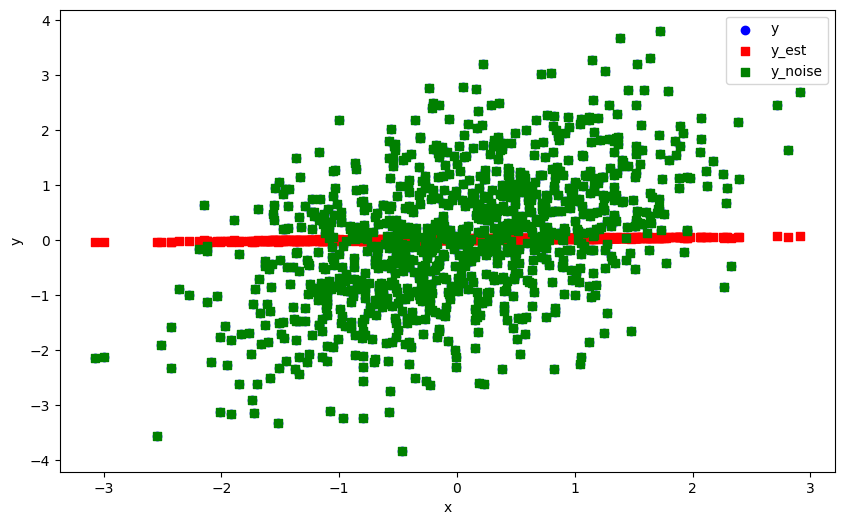

The programm is closed


In [6]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

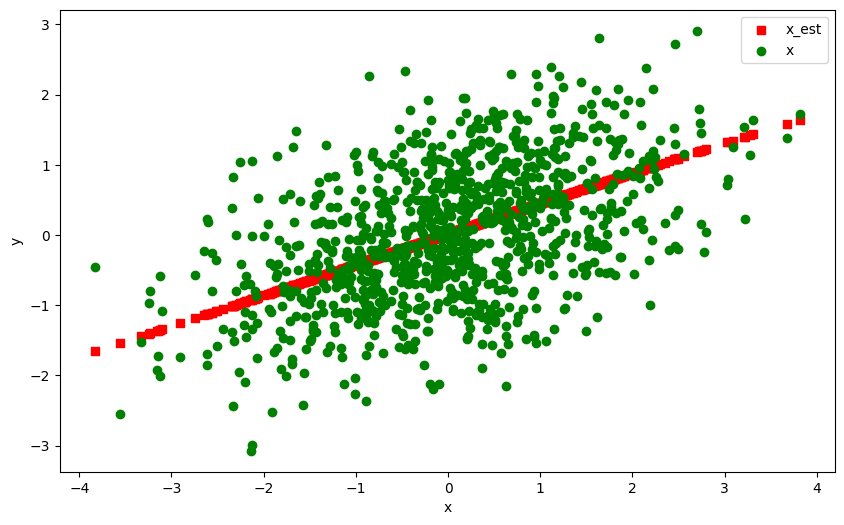

The programm is closed


In [7]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### with causal

In [8]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [9]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 118/29000 [00:00<03:48, 126.44it/s]

Sigma:  tensor([[9.6082e-01, 1.9179e-04],
        [1.9179e-04, 9.6079e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.7221, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4532, grad_fn=<AddBackward0>)
h_val:  tensor(0.0051, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[6.2246e-04, 6.2176e-04],
        [7.2715e+00, 6.8521e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.2735e-07, 6.2593e-07],
        [4.1331e+00, 3.2158e-04]])


  1%|          | 224/29000 [00:01<03:43, 128.57it/s]

Sigma:  tensor([[9.2331e-01, 5.9611e-04],
        [5.9611e-04, 9.2312e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.6522, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3829, grad_fn=<AddBackward0>)
h_val:  tensor(0.0069, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.5442e-03, 2.5429e-03],
        [7.1899e+00, 7.7366e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0976e-05, 1.0964e-05],
        [4.0701e+00, 3.8631e-04]])


  1%|          | 318/29000 [00:02<03:34, 133.68it/s]

Sigma:  tensor([[8.8737e-01, 4.2073e-04],
        [4.2073e-04, 8.8695e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.5739, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0100, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.7936e-03, 5.7884e-03],
        [7.1129e+00, 8.6733e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.9767e-05, 5.9660e-05],
        [4.0079e+00, 4.6181e-04]])


  1%|▏         | 415/29000 [00:03<03:41, 128.79it/s]

Sigma:  tensor([[8.5272e-01, 5.1331e-04],
        [5.1331e-04, 8.5221e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.4877, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2107, grad_fn=<AddBackward0>)
h_val:  tensor(0.0154, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0101, 0.0101],
        [7.0446, 0.0953]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9407e-04, 1.9308e-04],
        [3.9485e+00, 5.5223e-04]])


  2%|▏         | 513/29000 [00:04<03:37, 131.15it/s]

Sigma:  tensor([[8.1902e-01, 4.2438e-04],
        [4.2438e-04, 8.1884e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.3935, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1076, grad_fn=<AddBackward0>)
h_val:  tensor(0.0243, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0153, 0.0152],
        [6.9823, 0.1033]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.8116e-04, 4.7500e-04],
        [3.8912e+00, 6.7914e-04]])


  2%|▏         | 625/29000 [00:04<03:38, 129.99it/s]

Sigma:  tensor([[7.8593e-01, 3.7999e-04],
        [3.7999e-04, 7.8680e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.2909, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0083, grad_fn=<AddBackward0>)
h_val:  tensor(0.0377, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0212, 0.0208],
        [6.9186, 0.1114]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.7879e-04, 9.5333e-04],
        [3.8320e+00, 8.6964e-04]])


  2%|▏         | 722/29000 [00:05<03:44, 125.77it/s]

Sigma:  tensor([[7.5318e-01, 3.5469e-04],
        [3.5469e-04, 7.5603e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.1819, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1362, grad_fn=<AddBackward0>)
h_val:  tensor(0.0571, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0280, 0.0270],
        [6.8449, 0.1204]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7002e-03, 1.6191e-03],
        [3.7635e+00, 1.1422e-03]])


  3%|▎         | 819/29000 [00:06<03:35, 130.88it/s]

Sigma:  tensor([[7.2065e-01, 3.8038e-04],
        [3.8038e-04, 7.2649e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0713, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2713, grad_fn=<AddBackward0>)
h_val:  tensor(0.0829, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0357, 0.0334],
        [6.7527, 0.1312]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5825e-03, 2.3753e-03],
        [3.6781e+00, 1.5092e-03]])


  3%|▎         | 915/29000 [00:07<03:36, 129.93it/s]

Sigma:  tensor([[6.8843e-01, 4.4167e-04],
        [4.4167e-04, 6.9811e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4068, grad_fn=<AddBackward0>)
h_val:  tensor(0.1144, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0444, 0.0399],
        [6.6360, 0.1446]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.5550e-03, 3.0880e-03],
        [3.5724e+00, 1.9956e-03]])


  4%|▎         | 1022/29000 [00:07<03:44, 124.88it/s]

Sigma:  tensor([[6.5681e-01, 4.9025e-04],
        [4.9025e-04, 6.7087e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1331, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5355, grad_fn=<AddBackward0>)
h_val:  tensor(0.1482, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0541, 0.0459],
        [6.4969, 0.1605]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.5965e-03, 3.6389e-03],
        [3.4489e+00, 2.6199e-03]])


  4%|▍         | 1112/29000 [00:08<03:58, 117.00it/s]

Sigma:  tensor([[6.2615e-01, 6.0097e-04],
        [6.0097e-04, 6.4472e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2240, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6519, grad_fn=<AddBackward0>)
h_val:  tensor(0.1780, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0648, 0.0509],
        [6.3453, 0.1777]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0057, 0.0040],
        [3.3150, 0.0034]])


  4%|▍         | 1218/29000 [00:09<03:35, 128.99it/s]

Sigma:  tensor([[0.5968, 0.0007],
        [0.0007, 0.6196]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3121, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7549, grad_fn=<AddBackward0>)
h_val:  tensor(0.1980, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0763, 0.0540],
        [6.1926, 0.1952]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0070, 0.0040],
        [3.1805, 0.0043]])


  5%|▍         | 1314/29000 [00:10<03:25, 134.60it/s]

Sigma:  tensor([[0.5690, 0.0008],
        [0.0008, 0.5955]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4005, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8479, grad_fn=<AddBackward0>)
h_val:  tensor(0.2086, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.0886, 0.0554],
        [6.0502, 0.2115]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0084, 0.0039],
        [3.0535, 0.0054]])


  5%|▍         | 1426/29000 [00:11<03:29, 131.48it/s]

Sigma:  tensor([[0.5429, 0.0009],
        [0.0009, 0.5724]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4891, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9370, grad_fn=<AddBackward0>)
h_val:  tensor(0.2157, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1020, 0.0561],
        [5.9241, 0.2260]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0099, 0.0037],
        [2.9395, 0.0065]])


  5%|▌         | 1519/29000 [00:12<03:57, 115.73it/s]

Sigma:  tensor([[0.5183, 0.0010],
        [0.0010, 0.5502]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5760, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0272, grad_fn=<AddBackward0>)
h_val:  tensor(0.2240, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1169, 0.0568],
        [5.8137, 0.2388]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0118, 0.0034],
        [2.8404, 0.0077]])


  6%|▌         | 1614/29000 [00:12<03:26, 132.79it/s]

Sigma:  tensor([[0.4952, 0.0011],
        [0.0011, 0.5288]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6620, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1191, grad_fn=<AddBackward0>)
h_val:  tensor(0.2344, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1331, 0.0577],
        [5.7148, 0.2504]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0138, 0.0032],
        [2.7551, 0.0087]])


  6%|▌         | 1726/29000 [00:13<03:28, 130.62it/s]

Sigma:  tensor([[0.4733, 0.0011],
        [0.0011, 0.5084]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7469, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2104, grad_fn=<AddBackward0>)
h_val:  tensor(0.2447, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1503, 0.0583],
        [5.6256, 0.2609]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0161, 0.0029],
        [2.6825, 0.0095]])


  6%|▋         | 1823/29000 [00:14<03:25, 131.96it/s]

Sigma:  tensor([[0.4525, 0.0012],
        [0.0012, 0.4887]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8302, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2997, grad_fn=<AddBackward0>)
h_val:  tensor(0.2535, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1683, 0.0585],
        [5.5506, 0.2698]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0185, 0.0027],
        [2.6229, 0.0101]])


  7%|▋         | 1920/29000 [00:15<03:28, 129.72it/s]

Sigma:  tensor([[0.4328, 0.0012],
        [0.0012, 0.4698]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9110, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3878, grad_fn=<AddBackward0>)
h_val:  tensor(0.2618, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1862, 0.0585],
        [5.4963, 0.2765]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0954e-02, 2.3909e-03],
        [2.5798e+00, 1.0699e-02]])


  7%|▋         | 2015/29000 [00:15<03:32, 127.11it/s]

Sigma:  tensor([[0.4141, 0.0012],
        [0.0012, 0.4516]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9906, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4754, grad_fn=<AddBackward0>)
h_val:  tensor(0.2700, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2033, 0.0585],
        [5.4641, 0.2807]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3258e-02, 2.1492e-03],
        [2.5563e+00, 1.1127e-02]])


  7%|▋         | 2125/29000 [00:16<03:24, 131.18it/s]

Sigma:  tensor([[0.3963, 0.0011],
        [0.0011, 0.4341]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0691, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5615, grad_fn=<AddBackward0>)
h_val:  tensor(0.2774, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2184, 0.0584],
        [5.4480, 0.2831]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5245e-02, 1.9437e-03],
        [2.5507e+00, 1.1367e-02]])


  8%|▊         | 2222/29000 [00:17<03:24, 130.90it/s]

Sigma:  tensor([[0.3793, 0.0011],
        [0.0011, 0.4173]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1466, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6460, grad_fn=<AddBackward0>)
h_val:  tensor(0.2840, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2308, 0.0584],
        [5.4424, 0.2842]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6744e-02, 1.7851e-03],
        [2.5578e+00, 1.1504e-02]])


  8%|▊         | 2320/29000 [00:18<03:23, 130.86it/s]

Sigma:  tensor([[0.3632, 0.0010],
        [0.0010, 0.4012]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2234, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7293, grad_fn=<AddBackward0>)
h_val:  tensor(0.2901, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2399, 0.0585],
        [5.4412, 0.2849]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7677e-02, 1.6803e-03],
        [2.5717e+00, 1.1650e-02]])


  8%|▊         | 2416/29000 [00:18<03:26, 128.64it/s]

Sigma:  tensor([[0.3479, 0.0010],
        [0.0010, 0.3857]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2997, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8113, grad_fn=<AddBackward0>)
h_val:  tensor(0.2956, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2462, 0.0589],
        [5.4379, 0.2858]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8094e-02, 1.6185e-03],
        [2.5874e+00, 1.1850e-02]])


  9%|▊         | 2513/29000 [00:19<03:23, 130.36it/s]

Sigma:  tensor([[0.3333, 0.0010],
        [0.0010, 0.3708]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3756, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8926, grad_fn=<AddBackward0>)
h_val:  tensor(0.3011, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2505, 0.0594],
        [5.4299, 0.2872]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8154e-02, 1.5896e-03],
        [2.6026e+00, 1.2133e-02]])


  9%|▉         | 2622/29000 [00:20<03:23, 129.60it/s]

Sigma:  tensor([[0.3195, 0.0010],
        [0.0010, 0.3565]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4513, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9735, grad_fn=<AddBackward0>)
h_val:  tensor(0.3064, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2538, 0.0599],
        [5.4175, 0.2891]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8026e-02, 1.5788e-03],
        [2.6170e+00, 1.2510e-02]])


  9%|▉         | 2717/29000 [00:21<03:22, 130.07it/s]

Sigma:  tensor([[0.3062, 0.0010],
        [0.0010, 0.3427]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5267, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0540, grad_fn=<AddBackward0>)
h_val:  tensor(0.3118, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2566, 0.0605],
        [5.4022, 0.2913]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7832e-02, 1.5765e-03],
        [2.6316e+00, 1.2951e-02]])


 10%|▉         | 2815/29000 [00:21<03:20, 130.82it/s]

Sigma:  tensor([[0.2936, 0.0010],
        [0.0010, 0.3294]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6021, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1344, grad_fn=<AddBackward0>)
h_val:  tensor(0.3172, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2595, 0.0610],
        [5.3862, 0.2936]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7625e-02, 1.5760e-03],
        [2.6477e+00, 1.3423e-02]])


 10%|█         | 2927/29000 [00:22<03:20, 130.33it/s]

Sigma:  tensor([[0.2816, 0.0010],
        [0.0010, 0.3167]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6774, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2148, grad_fn=<AddBackward0>)
h_val:  tensor(0.3225, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2624, 0.0615],
        [5.3711, 0.2959]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7419e-02, 1.5747e-03],
        [2.6666e+00, 1.3907e-02]])


 10%|█         | 3023/29000 [00:23<03:20, 129.48it/s]

Sigma:  tensor([[0.2701, 0.0010],
        [0.0010, 0.3045]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7527, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2950, grad_fn=<AddBackward0>)
h_val:  tensor(0.3276, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2654, 0.0620],
        [5.3576, 0.2980]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7203e-02, 1.5717e-03],
        [2.6887e+00, 1.4388e-02]])


 11%|█         | 3120/29000 [00:24<03:18, 130.12it/s]

Sigma:  tensor([[0.2591, 0.0009],
        [0.0009, 0.2927]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8280, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3751, grad_fn=<AddBackward0>)
h_val:  tensor(0.3327, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2684, 0.0625],
        [5.3459, 0.2999]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6967e-02, 1.5666e-03],
        [2.7144e+00, 1.4865e-02]])


 11%|█         | 3218/29000 [00:25<03:12, 133.67it/s]

Sigma:  tensor([[0.2486, 0.0009],
        [0.0009, 0.2814]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9033, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4552, grad_fn=<AddBackward0>)
h_val:  tensor(0.3375, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2714, 0.0629],
        [5.3356, 0.3016]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6708e-02, 1.5589e-03],
        [2.7432e+00, 1.5342e-02]])


 11%|█▏        | 3316/29000 [00:25<03:17, 130.14it/s]

Sigma:  tensor([[0.2386, 0.0009],
        [0.0009, 0.2705]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9786, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5352, grad_fn=<AddBackward0>)
h_val:  tensor(0.3423, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2743, 0.0633],
        [5.3265, 0.3033]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6426e-02, 1.5482e-03],
        [2.7749e+00, 1.5822e-02]])


 12%|█▏        | 3414/29000 [00:26<03:14, 131.29it/s]

Sigma:  tensor([[0.2290, 0.0008],
        [0.0008, 0.2600]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0540, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6152, grad_fn=<AddBackward0>)
h_val:  tensor(0.3470, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2772, 0.0637],
        [5.3181, 0.3049]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6125e-02, 1.5342e-03],
        [2.8092e+00, 1.6310e-02]])


 12%|█▏        | 3526/29000 [00:27<03:10, 133.51it/s]

Sigma:  tensor([[0.2198, 0.0008],
        [0.0008, 0.2500]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1295, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6952, grad_fn=<AddBackward0>)
h_val:  tensor(0.3517, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2800, 0.0641],
        [5.3104, 0.3064]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5808e-02, 1.5169e-03],
        [2.8458e+00, 1.6805e-02]])


 12%|█▏        | 3624/29000 [00:28<03:12, 131.80it/s]

Sigma:  tensor([[0.2110, 0.0007],
        [0.0007, 0.2403]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2051, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7753, grad_fn=<AddBackward0>)
h_val:  tensor(0.3563, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2829, 0.0645],
        [5.3032, 0.3078]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5475e-02, 1.4967e-03],
        [2.8845e+00, 1.7309e-02]])


 13%|█▎        | 3722/29000 [00:28<03:12, 131.33it/s]

Sigma:  tensor([[0.2025, 0.0007],
        [0.0007, 0.2310]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2807, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8555, grad_fn=<AddBackward0>)
h_val:  tensor(0.3608, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2858, 0.0648],
        [5.2963, 0.3092]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5128e-02, 1.4738e-03],
        [2.9251e+00, 1.7823e-02]])


 13%|█▎        | 3820/29000 [00:29<03:10, 132.01it/s]

Sigma:  tensor([[0.1945, 0.0006],
        [0.0006, 0.2220]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3565, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9357, grad_fn=<AddBackward0>)
h_val:  tensor(0.3653, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2886, 0.0652],
        [5.2894, 0.3107]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4767e-02, 1.4488e-03],
        [2.9673e+00, 1.8350e-02]])


 14%|█▎        | 3918/29000 [00:30<03:10, 131.91it/s]

Sigma:  tensor([[0.1867, 0.0006],
        [0.0006, 0.2134]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4324, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0160, grad_fn=<AddBackward0>)
h_val:  tensor(0.3698, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2914, 0.0655],
        [5.2821, 0.3121]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4396e-02, 1.4218e-03],
        [3.0104e+00, 1.8894e-02]])


 14%|█▍        | 4016/29000 [00:31<03:07, 133.56it/s]

Sigma:  tensor([[0.1793, 0.0005],
        [0.0005, 0.2051]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5084, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0965, grad_fn=<AddBackward0>)
h_val:  tensor(0.3742, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2942, 0.0658],
        [5.2740, 0.3137]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4015e-02, 1.3933e-03],
        [3.0540e+00, 1.9457e-02]])


 14%|█▍        | 4125/29000 [00:31<03:11, 130.16it/s]

Sigma:  tensor([[0.1722, 0.0004],
        [0.0004, 0.1971]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5847, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1771, grad_fn=<AddBackward0>)
h_val:  tensor(0.3787, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2968, 0.0662],
        [5.2644, 0.3155]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3625e-02, 1.3639e-03],
        [3.0974e+00, 2.0036e-02]])


 15%|█▍        | 4223/29000 [00:32<03:09, 130.42it/s]

Sigma:  tensor([[0.1653, 0.0003],
        [0.0003, 0.1894]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6613, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2580, grad_fn=<AddBackward0>)
h_val:  tensor(0.3832, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2994, 0.0665],
        [5.2536, 0.3174]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3227e-02, 1.3340e-03],
        [3.1402e+00, 2.0623e-02]])


 15%|█▍        | 4317/29000 [00:33<03:13, 127.56it/s]

Sigma:  tensor([[0.1588, 0.0002],
        [0.0002, 0.1821]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7381, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3392, grad_fn=<AddBackward0>)
h_val:  tensor(0.3877, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3019, 0.0668],
        [5.2417, 0.3194]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2826e-02, 1.3044e-03],
        [3.1822e+00, 2.1208e-02]])


 15%|█▌        | 4427/29000 [00:34<03:03, 133.98it/s]

Sigma:  tensor([[1.5251e-01, 1.3748e-04],
        [1.3748e-04, 1.7495e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8153, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4206, grad_fn=<AddBackward0>)
h_val:  tensor(0.3921, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3044, 0.0671],
        [5.2290, 0.3216]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2421e-02, 1.2760e-03],
        [3.2236e+00, 2.1796e-02]])


 16%|█▌        | 4525/29000 [00:34<03:06, 131.38it/s]

Sigma:  tensor([[1.4648e-01, 2.3379e-05],
        [2.3379e-05, 1.6811e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8927, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5022, grad_fn=<AddBackward0>)
h_val:  tensor(0.3966, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3068, 0.0674],
        [5.2155, 0.3238]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2013e-02, 1.2492e-03],
        [3.2643e+00, 2.2388e-02]])


 16%|█▌        | 4623/29000 [00:35<03:07, 130.36it/s]

Sigma:  tensor([[ 1.4069e-01, -9.5403e-05],
        [-9.5403e-05,  1.6153e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9705, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5841, grad_fn=<AddBackward0>)
h_val:  tensor(0.4010, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3092, 0.0677],
        [5.2014, 0.3262]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1602e-02, 1.2242e-03],
        [3.3044e+00, 2.2993e-02]])


 16%|█▋        | 4721/29000 [00:36<03:04, 131.90it/s]

Sigma:  tensor([[ 0.1351, -0.0002],
        [-0.0002,  0.1552]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0484, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6661, grad_fn=<AddBackward0>)
h_val:  tensor(0.4054, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3115, 0.0680],
        [5.1868, 0.3285]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1190e-02, 1.2009e-03],
        [3.3439e+00, 2.3619e-02]])


 17%|█▋        | 4819/29000 [00:37<03:06, 129.46it/s]

Sigma:  tensor([[ 0.1298, -0.0003],
        [-0.0003,  0.1491]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1266, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7483, grad_fn=<AddBackward0>)
h_val:  tensor(0.4097, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3138, 0.0683],
        [5.1716, 0.3310]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0783e-02, 1.1786e-03],
        [3.3826e+00, 2.4260e-02]])


 17%|█▋        | 4924/29000 [00:38<03:17, 122.00it/s]

Sigma:  tensor([[ 0.1247, -0.0005],
        [-0.0005,  0.1432]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2050, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8307, grad_fn=<AddBackward0>)
h_val:  tensor(0.4140, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3161, 0.0686],
        [5.1560, 0.3334]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0385e-02, 1.1566e-03],
        [3.4204e+00, 2.4916e-02]])


 17%|█▋        | 5026/29000 [00:39<03:35, 111.34it/s]

Sigma:  tensor([[ 0.1198, -0.0006],
        [-0.0006,  0.1376]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2837, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9132, grad_fn=<AddBackward0>)
h_val:  tensor(0.4183, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3183, 0.0688],
        [5.1398, 0.3360]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0000e-02, 1.1347e-03],
        [3.4571e+00, 2.5587e-02]])


 18%|█▊        | 5124/29000 [00:40<03:05, 128.96it/s]

Sigma:  tensor([[ 0.1151, -0.0007],
        [-0.0007,  0.1321]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3625, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9959, grad_fn=<AddBackward0>)
h_val:  tensor(0.4225, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3205, 0.0691],
        [5.1231, 0.3385]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9628e-02, 1.1130e-03],
        [3.4923e+00, 2.6273e-02]])


 18%|█▊        | 5222/29000 [00:40<03:02, 130.08it/s]

Sigma:  tensor([[ 0.1106, -0.0009],
        [-0.0009,  0.1269]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4415, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0787, grad_fn=<AddBackward0>)
h_val:  tensor(0.4267, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3226, 0.0693],
        [5.1058, 0.3412]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9269e-02, 1.0918e-03],
        [3.5256e+00, 2.6970e-02]])


 18%|█▊        | 5320/29000 [00:41<02:59, 131.56it/s]

Sigma:  tensor([[ 0.1062, -0.0010],
        [-0.0010,  0.1219]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5206, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1616, grad_fn=<AddBackward0>)
h_val:  tensor(0.4309, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3248, 0.0696],
        [5.0878, 0.3438]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8924e-02, 1.0713e-03],
        [3.5569e+00, 2.7675e-02]])


 19%|█▊        | 5418/29000 [00:42<02:56, 133.97it/s]

Sigma:  tensor([[ 0.1021, -0.0011],
        [-0.0011,  0.1171]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5998, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2445, grad_fn=<AddBackward0>)
h_val:  tensor(0.4350, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3269, 0.0698],
        [5.0693, 0.3466]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8591e-02, 1.0515e-03],
        [3.5858e+00, 2.8387e-02]])


 19%|█▉        | 5516/29000 [00:43<02:56, 132.76it/s]

Sigma:  tensor([[ 0.0981, -0.0012],
        [-0.0012,  0.1124]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6792, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3275, grad_fn=<AddBackward0>)
h_val:  tensor(0.4391, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3290, 0.0700],
        [5.0501, 0.3494]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8274e-02, 1.0323e-03],
        [3.6121e+00, 2.9099e-02]])


 19%|█▉        | 5614/29000 [00:43<02:58, 130.98it/s]

Sigma:  tensor([[ 0.0942, -0.0014],
        [-0.0014,  0.1079]], grad_fn=<MmBackward0>)
obj:  tensor(-3.7585, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4104, grad_fn=<AddBackward0>)
h_val:  tensor(0.4431, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3311, 0.0702],
        [5.0304, 0.3522]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7972e-02, 1.0137e-03],
        [3.6356e+00, 2.9809e-02]])


 20%|█▉        | 5723/29000 [00:44<02:57, 131.13it/s]

Sigma:  tensor([[ 0.0905, -0.0015],
        [-0.0015,  0.1036]], grad_fn=<MmBackward0>)
obj:  tensor(-3.8379, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4933, grad_fn=<AddBackward0>)
h_val:  tensor(0.4471, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3332, 0.0704],
        [5.0104, 0.3550]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7685e-02, 9.9571e-04],
        [3.6561e+00, 3.0513e-02]])


 20%|██        | 5821/29000 [00:45<02:57, 130.55it/s]

Sigma:  tensor([[ 0.0870, -0.0016],
        [-0.0016,  0.0995]], grad_fn=<MmBackward0>)
obj:  tensor(-3.9173, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5761, grad_fn=<AddBackward0>)
h_val:  tensor(0.4511, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3352, 0.0705],
        [4.9901, 0.3579]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7412e-02, 9.7830e-04],
        [3.6734e+00, 3.1205e-02]])


 20%|██        | 5917/29000 [00:46<02:56, 131.12it/s]

Sigma:  tensor([[ 0.0836, -0.0018],
        [-0.0018,  0.0955]], grad_fn=<MmBackward0>)
obj:  tensor(-3.9966, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6588, grad_fn=<AddBackward0>)
h_val:  tensor(0.4550, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3373, 0.0707],
        [4.9697, 0.3607]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7156e-02, 9.6140e-04],
        [3.6876e+00, 3.1882e-02]])


 21%|██        | 6015/29000 [00:46<02:56, 130.49it/s]

Sigma:  tensor([[ 0.0803, -0.0019],
        [-0.0019,  0.0917]], grad_fn=<MmBackward0>)
obj:  tensor(-4.0758, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7413, grad_fn=<AddBackward0>)
h_val:  tensor(0.4588, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3395, 0.0708],
        [4.9495, 0.3635]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6918e-02, 9.4490e-04],
        [3.6984e+00, 3.2536e-02]])


 21%|██        | 6127/29000 [00:47<02:53, 131.82it/s]

Sigma:  tensor([[ 0.0772, -0.0020],
        [-0.0020,  0.0880]], grad_fn=<MmBackward0>)
obj:  tensor(-4.1548, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8236, grad_fn=<AddBackward0>)
h_val:  tensor(0.4626, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3416, 0.0709],
        [4.9298, 0.3662]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6699e-02, 9.2877e-04],
        [3.7060e+00, 3.3162e-02]])


 21%|██▏       | 6225/29000 [00:48<02:54, 130.59it/s]

Sigma:  tensor([[ 0.0742, -0.0022],
        [-0.0022,  0.0845]], grad_fn=<MmBackward0>)
obj:  tensor(-4.2336, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9056, grad_fn=<AddBackward0>)
h_val:  tensor(0.4662, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3439, 0.0710],
        [4.9109, 0.3687]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6499e-02, 9.1301e-04],
        [3.7105e+00, 3.3754e-02]])


 22%|██▏       | 6323/29000 [00:49<02:52, 131.39it/s]

Sigma:  tensor([[ 0.0713, -0.0023],
        [-0.0023,  0.0812]], grad_fn=<MmBackward0>)
obj:  tensor(-4.3122, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9873, grad_fn=<AddBackward0>)
h_val:  tensor(0.4698, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3462, 0.0711],
        [4.8932, 0.3711]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6320e-02, 8.9753e-04],
        [3.7120e+00, 3.4309e-02]])


 22%|██▏       | 6421/29000 [00:49<02:49, 133.09it/s]

Sigma:  tensor([[ 0.0685, -0.0025],
        [-0.0025,  0.0779]], grad_fn=<MmBackward0>)
obj:  tensor(-4.3906, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0687, grad_fn=<AddBackward0>)
h_val:  tensor(0.4732, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3486, 0.0712],
        [4.8772, 0.3732]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6162e-02, 8.8225e-04],
        [3.7109e+00, 3.4821e-02]])


 22%|██▏       | 6519/29000 [00:50<02:49, 132.90it/s]

Sigma:  tensor([[ 0.0659, -0.0026],
        [-0.0026,  0.0748]], grad_fn=<MmBackward0>)
obj:  tensor(-4.4687, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1498, grad_fn=<AddBackward0>)
h_val:  tensor(0.4765, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3512, 0.0712],
        [4.8636, 0.3750]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6030e-02, 8.6710e-04],
        [3.7083e+00, 3.5293e-02]])


 23%|██▎       | 6617/29000 [00:51<02:50, 131.51it/s]

Sigma:  tensor([[ 0.0633, -0.0027],
        [-0.0027,  0.0718]], grad_fn=<MmBackward0>)
obj:  tensor(-4.5465, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2304, grad_fn=<AddBackward0>)
h_val:  tensor(0.4795, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3539, 0.0711],
        [4.8534, 0.3763]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5927e-02, 8.5211e-04],
        [3.7055e+00, 3.5733e-02]])


 23%|██▎       | 6716/29000 [00:52<02:47, 133.31it/s]

Sigma:  tensor([[ 0.0609, -0.0029],
        [-0.0029,  0.0690]], grad_fn=<MmBackward0>)
obj:  tensor(-4.6240, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3108, grad_fn=<AddBackward0>)
h_val:  tensor(0.4824, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3568, 0.0711],
        [4.8472, 0.3772]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5859e-02, 8.3740e-04],
        [3.7042e+00, 3.6161e-02]])


 23%|██▎       | 6814/29000 [00:52<02:44, 134.66it/s]

Sigma:  tensor([[ 0.0585, -0.0030],
        [-0.0030,  0.0662]], grad_fn=<MmBackward0>)
obj:  tensor(-4.7013, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3908, grad_fn=<AddBackward0>)
h_val:  tensor(0.4851, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3600, 0.0710],
        [4.8447, 0.3775]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5824e-02, 8.2292e-04],
        [3.7050e+00, 3.6597e-02]])


 24%|██▍       | 6919/29000 [00:53<02:58, 123.92it/s]

Sigma:  tensor([[ 0.0563, -0.0032],
        [-0.0032,  0.0636]], grad_fn=<MmBackward0>)
obj:  tensor(-4.7784, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4705, grad_fn=<AddBackward0>)
h_val:  tensor(0.4876, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3632, 0.0708],
        [4.8443, 0.3776]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5818e-02, 8.0872e-04],
        [3.7064e+00, 3.7057e-02]])


 25%|██▍       | 7119/29000 [00:55<02:52, 127.09it/s]

Sigma:  tensor([[0.0528, 0.0006],
        [0.0006, 0.0593]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1327, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8642, grad_fn=<AddBackward0>)
h_val:  tensor(0.3332, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3365, 0.0456],
        [4.9918, 0.3561]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1078e-02, 4.0424e-04],
        [3.7204e+00, 3.8838e-02]])


 25%|██▍       | 7224/29000 [00:56<02:53, 125.87it/s]

Sigma:  tensor([[0.0521, 0.0041],
        [0.0041, 0.0578]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1506, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6279, grad_fn=<AddBackward0>)
h_val:  tensor(0.2910, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.3100, 0.0443],
        [5.2192, 0.3274]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.5997e-03, 3.8773e-04],
        [3.7905e+00, 4.0572e-02]])


 25%|██▌       | 7316/29000 [00:56<02:53, 124.84it/s]

Sigma:  tensor([[0.0519, 0.0026],
        [0.0026, 0.0557]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1667, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9463, grad_fn=<AddBackward0>)
h_val:  tensor(0.3061, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2891, 0.0541],
        [5.3976, 0.3075]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.4623e-03, 5.1046e-04],
        [3.8956e+00, 4.0756e-02]])


 26%|██▌       | 7421/29000 [00:57<02:52, 125.41it/s]

Sigma:  tensor([[ 0.0514, -0.0009],
        [-0.0009,  0.0537]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1786, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8232, grad_fn=<AddBackward0>)
h_val:  tensor(0.2814, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2693, 0.0523],
        [5.4938, 0.2981]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.3591e-03, 4.8963e-04],
        [4.0148e+00, 3.8940e-02]])


 26%|██▌       | 7514/29000 [00:58<02:47, 128.09it/s]

Sigma:  tensor([[ 0.0511, -0.0022],
        [-0.0022,  0.0519]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1865, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7691, grad_fn=<AddBackward0>)
h_val:  tensor(0.2678, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2565, 0.0516],
        [5.5750, 0.2895]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.7013e-03, 4.9050e-04],
        [4.1315e+00, 3.6718e-02]])


 26%|██▋       | 7620/29000 [00:59<02:46, 128.04it/s]

Sigma:  tensor([[ 0.0512, -0.0009],
        [-0.0009,  0.0499]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1940, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8646, grad_fn=<AddBackward0>)
h_val:  tensor(0.2695, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2509, 0.0535],
        [5.6647, 0.2780]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.5350e-03, 5.3419e-04],
        [4.2357e+00, 3.4691e-02]])


 27%|██▋       | 7725/29000 [01:00<02:50, 124.98it/s]

Sigma:  tensor([[0.0514, 0.0005],
        [0.0005, 0.0480]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2010, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8023, grad_fn=<AddBackward0>)
h_val:  tensor(0.2560, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2490, 0.0515],
        [5.7401, 0.2684]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.2178e-03, 5.2938e-04],
        [4.3354e+00, 3.2615e-02]])


 27%|██▋       | 7817/29000 [01:00<02:50, 124.15it/s]

Sigma:  tensor([[0.0520, 0.0012],
        [0.0012, 0.0462]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2077, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8457, grad_fn=<AddBackward0>)
h_val:  tensor(0.2534, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2510, 0.0512],
        [5.8161, 0.2593]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.1583e-03, 5.5359e-04],
        [4.4344e+00, 3.0773e-02]])


 27%|██▋       | 7922/29000 [01:01<02:44, 128.46it/s]

Sigma:  tensor([[0.0527, 0.0013],
        [0.0013, 0.0445]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2142, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8462, grad_fn=<AddBackward0>)
h_val:  tensor(0.2467, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2540, 0.0499],
        [5.9016, 0.2491]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.0595e-03, 5.7019e-04],
        [4.5272e+00, 2.9384e-02]])


 28%|██▊       | 8015/29000 [01:02<02:45, 126.69it/s]

Sigma:  tensor([[0.0537, 0.0013],
        [0.0013, 0.0428]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2204, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8466, grad_fn=<AddBackward0>)
h_val:  tensor(0.2401, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2572, 0.0486],
        [5.9966, 0.2382]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.9510e-03, 5.9250e-04],
        [4.6166e+00, 2.8413e-02]])


 28%|██▊       | 8120/29000 [01:03<02:45, 126.09it/s]

Sigma:  tensor([[0.0549, 0.0011],
        [0.0011, 0.0411]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2265, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8474, grad_fn=<AddBackward0>)
h_val:  tensor(0.2338, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2597, 0.0474],
        [6.0877, 0.2278]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.8083e-03, 6.2181e-04],
        [4.7053e+00, 2.7470e-02]])


 28%|██▊       | 8225/29000 [01:04<02:47, 123.81it/s]

Sigma:  tensor([[0.0563, 0.0010],
        [0.0010, 0.0395]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2325, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.2269, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2611, 0.0462],
        [6.1734, 0.2180]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.6104e-03, 6.5747e-04],
        [4.7936e+00, 2.6515e-02]])


 29%|██▊       | 8320/29000 [01:04<02:39, 129.96it/s]

Sigma:  tensor([[0.0580, 0.0010],
        [0.0010, 0.0380]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2383, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8337, grad_fn=<AddBackward0>)
h_val:  tensor(0.2200, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2615, 0.0450],
        [6.2548, 0.2086]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.3677e-03, 7.0213e-04],
        [4.8814e+00, 2.5575e-02]])


 29%|██▉       | 8413/29000 [01:05<02:40, 128.04it/s]

Sigma:  tensor([[0.0600, 0.0009],
        [0.0009, 0.0365]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2441, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8233, grad_fn=<AddBackward0>)
h_val:  tensor(0.2129, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2609, 0.0439],
        [6.3319, 0.1998]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.0895e-03, 7.5649e-04],
        [4.9691e+00, 2.4685e-02]])


 29%|██▉       | 8522/29000 [01:06<02:41, 126.98it/s]

Sigma:  tensor([[0.0621, 0.0008],
        [0.0008, 0.0351]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2499, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8102, grad_fn=<AddBackward0>)
h_val:  tensor(0.2055, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2597, 0.0427],
        [6.4062, 0.1914]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.7870e-03, 8.2166e-04],
        [5.0564e+00, 2.3886e-02]])


 30%|██▉       | 8626/29000 [01:07<02:43, 124.64it/s]

Sigma:  tensor([[0.0646, 0.0007],
        [0.0007, 0.0337]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2557, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7977, grad_fn=<AddBackward0>)
h_val:  tensor(0.1981, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2579, 0.0416],
        [6.4761, 0.1836]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.4729e-03, 8.9967e-04],
        [5.1435e+00, 2.3139e-02]])


 30%|███       | 8716/29000 [01:08<02:53, 117.06it/s]

Sigma:  tensor([[0.0672, 0.0006],
        [0.0006, 0.0324]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2616, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7842, grad_fn=<AddBackward0>)
h_val:  tensor(0.1907, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2556, 0.0404],
        [6.5420, 0.1762]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.1540e-03, 9.9125e-04],
        [5.2298e+00, 2.2447e-02]])


 30%|███       | 8814/29000 [01:08<02:58, 113.33it/s]

Sigma:  tensor([[0.0701, 0.0006],
        [0.0006, 0.0312]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2675, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7720, grad_fn=<AddBackward0>)
h_val:  tensor(0.1833, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2529, 0.0393],
        [6.6046, 0.1693]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.8450e-03, 1.0978e-03],
        [5.3155e+00, 2.1827e-02]])


 31%|███       | 8919/29000 [01:09<02:42, 123.85it/s]

Sigma:  tensor([[0.0732, 0.0005],
        [0.0005, 0.0299]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2735, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7599, grad_fn=<AddBackward0>)
h_val:  tensor(0.1759, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2498, 0.0382],
        [6.6642, 0.1627]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.5537e-03, 1.2187e-03],
        [5.4002e+00, 2.1284e-02]])


 31%|███       | 9026/29000 [01:10<02:35, 128.63it/s]

Sigma:  tensor([[0.0765, 0.0004],
        [0.0004, 0.0288]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2794, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7491, grad_fn=<AddBackward0>)
h_val:  tensor(0.1687, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2464, 0.0371],
        [6.7206, 0.1564]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.2902e-03, 1.3520e-03],
        [5.4838e+00, 2.0819e-02]])


 31%|███▏      | 9118/29000 [01:11<02:34, 128.92it/s]

Sigma:  tensor([[0.0800, 0.0004],
        [0.0004, 0.0277]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2853, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7395, grad_fn=<AddBackward0>)
h_val:  tensor(0.1617, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2427, 0.0360],
        [6.7741, 0.1505]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.0605e-03, 1.4934e-03],
        [5.5661e+00, 2.0442e-02]])


 32%|███▏      | 9223/29000 [01:12<02:38, 124.48it/s]

Sigma:  tensor([[0.0836, 0.0003],
        [0.0003, 0.0266]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2912, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7315, grad_fn=<AddBackward0>)
h_val:  tensor(0.1548, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2387, 0.0349],
        [6.8248, 0.1449]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.8619e-03, 1.6364e-03],
        [5.6470e+00, 2.0155e-02]])


 32%|███▏      | 9315/29000 [01:12<02:38, 124.30it/s]

Sigma:  tensor([[0.0874, 0.0002],
        [0.0002, 0.0255]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2970, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7252, grad_fn=<AddBackward0>)
h_val:  tensor(0.1483, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2346, 0.0339],
        [6.8723, 0.1397]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.6868e-03, 1.7736e-03],
        [5.7265e+00, 1.9962e-02]])


 32%|███▏      | 9423/29000 [01:13<02:33, 127.74it/s]

Sigma:  tensor([[0.0914, 0.0002],
        [0.0002, 0.0245]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3027, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7208, grad_fn=<AddBackward0>)
h_val:  tensor(0.1420, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2304, 0.0329],
        [6.9168, 0.1348]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.5290e-03, 1.8953e-03],
        [5.8048e+00, 1.9866e-02]])


 33%|███▎      | 9516/29000 [01:14<02:32, 127.74it/s]

Sigma:  tensor([[0.0955, 0.0002],
        [0.0002, 0.0236]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3084, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7185, grad_fn=<AddBackward0>)
h_val:  tensor(0.1360, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0018, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2261, 0.0319],
        [6.9580, 0.1303]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.3852e-03, 1.9938e-03],
        [5.8819e+00, 1.9868e-02]])


 33%|███▎      | 9620/29000 [01:15<02:32, 127.00it/s]

Sigma:  tensor([[0.0998, 0.0001],
        [0.0001, 0.0227]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3140, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7183, grad_fn=<AddBackward0>)
h_val:  tensor(0.1303, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2218, 0.0310],
        [6.9961, 0.1261]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.2527e-03, 2.0640e-03],
        [5.9581e+00, 1.9967e-02]])


 34%|███▎      | 9724/29000 [01:16<02:33, 125.57it/s]

Sigma:  tensor([[1.0413e-01, 8.2505e-05],
        [8.2505e-05, 2.1771e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3195, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7204, grad_fn=<AddBackward0>)
h_val:  tensor(0.1249, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2175, 0.0302],
        [7.0313, 0.1223]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.1296e-03, 2.1051e-03],
        [6.0336e+00, 2.0160e-02]])


 34%|███▍      | 9817/29000 [01:16<02:31, 126.86it/s]

Sigma:  tensor([[1.0863e-01, 5.3770e-05],
        [5.3770e-05, 2.0917e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3250, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7246, grad_fn=<AddBackward0>)
h_val:  tensor(0.1198, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2133, 0.0294],
        [7.0639, 0.1188]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.0156e-03, 2.1198e-03],
        [6.1089e+00, 2.0445e-02]])


 34%|███▍      | 9923/29000 [01:17<02:30, 127.15it/s]

Sigma:  tensor([[1.1324e-01, 2.9118e-05],
        [2.9118e-05, 2.0095e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3305, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7311, grad_fn=<AddBackward0>)
h_val:  tensor(0.1149, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2091, 0.0286],
        [7.0943, 0.1155]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9081e-03, 2.1134e-03],
        [6.1843e+00, 2.0817e-02]])


 35%|███▍      | 10016/29000 [01:18<02:29, 127.00it/s]

Sigma:  tensor([[1.1796e-01, 8.2840e-06],
        [8.2840e-06, 1.9304e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3359, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7396, grad_fn=<AddBackward0>)
h_val:  tensor(0.1102, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2050, 0.0279],
        [7.1228, 0.1125]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8055e-03, 2.0921e-03],
        [6.2602e+00, 2.1272e-02]])


 35%|███▍      | 10122/29000 [01:19<02:29, 125.89it/s]

Sigma:  tensor([[ 1.2278e-01, -8.8793e-06],
        [-8.8793e-06,  1.8542e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3413, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7501, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.2010, 0.0272],
        [7.1497, 0.1097]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7060e-03, 2.0617e-03],
        [6.3367e+00, 2.1806e-02]])


 35%|███▌      | 10215/29000 [01:20<02:29, 125.90it/s]

Sigma:  tensor([[ 1.2769e-01, -2.2587e-05],
        [-2.2587e-05,  1.7810e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3467, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7623, grad_fn=<AddBackward0>)
h_val:  tensor(0.1016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1971, 0.0265],
        [7.1754, 0.1070]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6091e-03, 2.0265e-03],
        [6.4139e+00, 2.2417e-02]])


 36%|███▌      | 10322/29000 [01:20<02:28, 126.17it/s]

Sigma:  tensor([[ 1.3268e-01, -3.3177e-05],
        [-3.3177e-05,  1.7105e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3520, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7762, grad_fn=<AddBackward0>)
h_val:  tensor(0.0976, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1932, 0.0258],
        [7.1998, 0.1044]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5143e-03, 1.9896e-03],
        [6.4919e+00, 2.3103e-02]])


 36%|███▌      | 10414/29000 [01:21<02:26, 127.02it/s]

Sigma:  tensor([[ 1.3775e-01, -4.0999e-05],
        [-4.0999e-05,  1.6426e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3573, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0938, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1894, 0.0252],
        [7.2233, 0.1019]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4211e-03, 1.9526e-03],
        [6.5703e+00, 2.3862e-02]])


 36%|███▋      | 10519/29000 [01:22<02:27, 125.61it/s]

Sigma:  tensor([[ 1.4289e-01, -4.6421e-05],
        [-4.6421e-05,  1.5774e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3625, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8084, grad_fn=<AddBackward0>)
h_val:  tensor(0.0902, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1857, 0.0246],
        [7.2456, 0.0996]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3296e-03, 1.9163e-03],
        [6.6489e+00, 2.4693e-02]])


 37%|███▋      | 10625/29000 [01:23<02:24, 127.49it/s]

Sigma:  tensor([[ 1.4809e-01, -4.9807e-05],
        [-4.9807e-05,  1.5146e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3677, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8265, grad_fn=<AddBackward0>)
h_val:  tensor(0.0868, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1820, 0.0240],
        [7.2670, 0.0973]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2397e-03, 1.8809e-03],
        [6.7275e+00, 2.5595e-02]])


 37%|███▋      | 10717/29000 [01:24<02:24, 126.13it/s]

Sigma:  tensor([[ 1.5335e-01, -5.1476e-05],
        [-5.1476e-05,  1.4542e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3728, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8458, grad_fn=<AddBackward0>)
h_val:  tensor(0.0836, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1785, 0.0234],
        [7.2875, 0.0952]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1514e-03, 1.8465e-03],
        [6.8057e+00, 2.6565e-02]])


 37%|███▋      | 10821/29000 [01:24<02:25, 124.78it/s]

Sigma:  tensor([[ 1.5864e-01, -5.1671e-05],
        [-5.1671e-05,  1.3962e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3779, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8662, grad_fn=<AddBackward0>)
h_val:  tensor(0.0806, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1750, 0.0229],
        [7.3070, 0.0931]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0649e-03, 1.8129e-03],
        [6.8834e+00, 2.7600e-02]])


 38%|███▊      | 10913/29000 [01:25<02:25, 124.10it/s]

Sigma:  tensor([[ 1.6396e-01, -5.0562e-05],
        [-5.0562e-05,  1.3405e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3829, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8876, grad_fn=<AddBackward0>)
h_val:  tensor(0.0777, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0016, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1716, 0.0224],
        [7.3255, 0.0911]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9802e-03, 1.7801e-03],
        [6.9605e+00, 2.8691e-02]])


 38%|███▊      | 11020/29000 [01:26<02:19, 128.54it/s]

Sigma:  tensor([[ 1.6929e-01, -4.8250e-05],
        [-4.8250e-05,  1.2869e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3878, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9099, grad_fn=<AddBackward0>)
h_val:  tensor(0.0750, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1683, 0.0219],
        [7.3433, 0.0892]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8974e-03, 1.7481e-03],
        [7.0369e+00, 2.9832e-02]])


 38%|███▊      | 11125/29000 [01:27<03:27, 86.12it/s] 

Sigma:  tensor([[ 1.7463e-01, -4.4820e-05],
        [-4.4820e-05,  1.2354e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3927, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9331, grad_fn=<AddBackward0>)
h_val:  tensor(0.0724, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1652, 0.0214],
        [7.3604, 0.0874]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8164e-03, 1.7167e-03],
        [7.1127e+00, 3.1011e-02]])


 39%|███▊      | 11217/29000 [01:28<02:25, 122.37it/s]

Sigma:  tensor([[ 1.7995e-01, -4.0373e-05],
        [-4.0373e-05,  1.1860e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3975, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9570, grad_fn=<AddBackward0>)
h_val:  tensor(0.0699, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1621, 0.0210],
        [7.3770, 0.0856]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7374e-03, 1.6861e-03],
        [7.1879e+00, 3.2220e-02]])


 39%|███▉      | 11321/29000 [01:29<02:21, 124.55it/s]

Sigma:  tensor([[ 1.8526e-01, -3.5043e-05],
        [-3.5043e-05,  1.1386e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4022, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9818, grad_fn=<AddBackward0>)
h_val:  tensor(0.0676, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1592, 0.0205],
        [7.3932, 0.0838]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6603e-03, 1.6562e-03],
        [7.2623e+00, 3.3450e-02]])


 39%|███▉      | 11426/29000 [01:30<02:20, 125.42it/s]

Sigma:  tensor([[ 1.9052e-01, -2.8990e-05],
        [-2.8990e-05,  1.0930e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4069, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0071, grad_fn=<AddBackward0>)
h_val:  tensor(0.0655, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1564, 0.0201],
        [7.4091, 0.0820]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5853e-03, 1.6271e-03],
        [7.3359e+00, 3.4697e-02]])


 40%|███▉      | 11519/29000 [01:30<02:17, 126.93it/s]

Sigma:  tensor([[ 1.9572e-01, -2.2380e-05],
        [-2.2380e-05,  1.0493e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4116, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0332, grad_fn=<AddBackward0>)
h_val:  tensor(0.0634, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1537, 0.0197],
        [7.4246, 0.0802]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5123e-03, 1.5987e-03],
        [7.4085e+00, 3.5954e-02]])


 40%|████      | 11624/29000 [01:31<02:15, 127.98it/s]

Sigma:  tensor([[ 2.0086e-01, -1.5356e-05],
        [-1.5356e-05,  1.0074e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4162, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0598, grad_fn=<AddBackward0>)
h_val:  tensor(0.0615, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0015, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1511, 0.0193],
        [7.4396, 0.0785]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4414e-03, 1.5712e-03],
        [7.4801e+00, 3.7221e-02]])


 40%|████      | 11717/29000 [01:32<02:16, 126.98it/s]

Sigma:  tensor([[ 2.0590e-01, -7.9821e-06],
        [-7.9821e-06,  9.6715e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4207, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0872, grad_fn=<AddBackward0>)
h_val:  tensor(0.0596, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1486, 0.0190],
        [7.4539, 0.0768]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3814e-03, 1.5446e-03],
        [7.5504e+00, 3.8490e-02]])


 41%|████      | 11822/29000 [01:33<02:18, 124.01it/s]

Sigma:  tensor([[ 2.1084e-01, -2.3724e-07],
        [-2.3724e-07,  9.2854e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4252, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1152, grad_fn=<AddBackward0>)
h_val:  tensor(0.0579, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1463, 0.0186],
        [7.4674, 0.0752]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3297e-03, 1.5190e-03],
        [7.6195e+00, 3.9755e-02]])


 41%|████      | 11914/29000 [01:34<02:17, 123.87it/s]

Sigma:  tensor([[2.1565e-01, 7.8821e-06],
        [7.8821e-06, 8.9150e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4296, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1440, grad_fn=<AddBackward0>)
h_val:  tensor(0.0564, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1440, 0.0183],
        [7.4800, 0.0737]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2840e-03, 1.4943e-03],
        [7.6872e+00, 4.1008e-02]])


 41%|████▏     | 12020/29000 [01:34<02:15, 125.36it/s]

Sigma:  tensor([[2.2032e-01, 1.6224e-05],
        [1.6224e-05, 8.5595e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4340, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1734, grad_fn=<AddBackward0>)
h_val:  tensor(0.0549, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1419, 0.0180],
        [7.4921, 0.0723]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2432e-03, 1.4706e-03],
        [7.7534e+00, 4.2230e-02]])


 42%|████▏     | 12115/29000 [01:35<02:10, 128.98it/s]

Sigma:  tensor([[2.2483e-01, 2.4455e-05],
        [2.4455e-05, 8.2185e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4383, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2034, grad_fn=<AddBackward0>)
h_val:  tensor(0.0536, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1400, 0.0177],
        [7.5039, 0.0710]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2061e-03, 1.4479e-03],
        [7.8174e+00, 4.3401e-02]])


 42%|████▏     | 12220/29000 [01:36<02:12, 126.67it/s]

Sigma:  tensor([[2.2916e-01, 3.2169e-05],
        [3.2169e-05, 7.8914e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4425, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2340, grad_fn=<AddBackward0>)
h_val:  tensor(0.0524, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1381, 0.0175],
        [7.5156, 0.0697]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1723e-03, 1.4261e-03],
        [7.8787e+00, 4.4499e-02]])


 43%|████▎     | 12327/29000 [01:37<02:09, 128.42it/s]

Sigma:  tensor([[2.3329e-01, 3.9035e-05],
        [3.9035e-05, 7.5775e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4468, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2651, grad_fn=<AddBackward0>)
h_val:  tensor(0.0513, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1364, 0.0172],
        [7.5268, 0.0684]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1418e-03, 1.4052e-03],
        [7.9363e+00, 4.5509e-02]])


 43%|████▎     | 12418/29000 [01:38<02:19, 118.49it/s]

Sigma:  tensor([[2.3722e-01, 4.4882e-05],
        [4.4882e-05, 7.2763e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4509, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2968, grad_fn=<AddBackward0>)
h_val:  tensor(0.0502, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1348, 0.0170],
        [7.5373, 0.0672]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1136e-03, 1.3852e-03],
        [7.9896e+00, 4.6421e-02]])


 43%|████▎     | 12517/29000 [01:38<02:27, 111.86it/s]

Sigma:  tensor([[2.4093e-01, 4.9698e-05],
        [4.9698e-05, 6.9873e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4551, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3290, grad_fn=<AddBackward0>)
h_val:  tensor(0.0493, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1333, 0.0168],
        [7.5469, 0.0661]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0875e-03, 1.3663e-03],
        [8.0381e+00, 4.7235e-02]])


 44%|████▎     | 12623/29000 [01:39<02:14, 122.20it/s]

Sigma:  tensor([[2.4440e-01, 5.3579e-05],
        [5.3579e-05, 6.7101e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4592, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3618, grad_fn=<AddBackward0>)
h_val:  tensor(0.0485, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1320, 0.0166],
        [7.5555, 0.0652]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0635e-03, 1.3484e-03],
        [8.0819e+00, 4.7957e-02]])


 44%|████▍     | 12716/29000 [01:40<02:09, 126.08it/s]

Sigma:  tensor([[2.4762e-01, 5.6686e-05],
        [5.6686e-05, 6.4440e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4633, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3953, grad_fn=<AddBackward0>)
h_val:  tensor(0.0477, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1307, 0.0164],
        [7.5631, 0.0644]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0418e-03, 1.3316e-03],
        [8.1212e+00, 4.8599e-02]])


 44%|████▍     | 12822/29000 [01:41<02:06, 128.09it/s]

Sigma:  tensor([[2.5059e-01, 5.9201e-05],
        [5.9201e-05, 6.1888e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4673, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4293, grad_fn=<AddBackward0>)
h_val:  tensor(0.0471, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1296, 0.0163],
        [7.5699, 0.0636]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0215e-03, 1.3158e-03],
        [8.1565e+00, 4.9173e-02]])


 45%|████▍     | 12914/29000 [01:42<02:06, 126.79it/s]

Sigma:  tensor([[2.5330e-01, 6.1308e-05],
        [6.1308e-05, 5.9438e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4714, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4639, grad_fn=<AddBackward0>)
h_val:  tensor(0.0465, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1286, 0.0161],
        [7.5760, 0.0629]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0029e-03, 1.3012e-03],
        [8.1880e+00, 4.9690e-02]])


 45%|████▍     | 13019/29000 [01:42<02:07, 125.19it/s]

Sigma:  tensor([[2.5575e-01, 6.3577e-05],
        [6.3577e-05, 5.7088e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4754, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4991, grad_fn=<AddBackward0>)
h_val:  tensor(0.0459, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1277, 0.0160],
        [7.5816, 0.0623]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.8540e-04, 1.2875e-03],
        [8.2160e+00, 5.0146e-02]])


 45%|████▌     | 13125/29000 [01:43<02:04, 127.74it/s]

Sigma:  tensor([[2.5794e-01, 6.5174e-05],
        [6.5174e-05, 5.4832e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4794, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5349, grad_fn=<AddBackward0>)
h_val:  tensor(0.0455, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1269, 0.0159],
        [7.5867, 0.0618]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.6873e-04, 1.2747e-03],
        [8.2404e+00, 5.0559e-02]])


 46%|████▌     | 13217/29000 [01:44<02:05, 125.49it/s]

Sigma:  tensor([[2.5987e-01, 6.6366e-05],
        [6.6366e-05, 5.2667e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4835, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5711, grad_fn=<AddBackward0>)
h_val:  tensor(0.0451, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1262, 0.0158],
        [7.5910, 0.0613]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.5250e-04, 1.2627e-03],
        [8.2612e+00, 5.0947e-02]])


 46%|████▌     | 13322/29000 [01:45<02:04, 125.89it/s]

Sigma:  tensor([[2.6156e-01, 6.8017e-05],
        [6.8017e-05, 5.0588e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4875, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6079, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1255, 0.0157],
        [7.5947, 0.0608]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.3666e-04, 1.2516e-03],
        [8.2786e+00, 5.1302e-02]])


 46%|████▋     | 13426/29000 [01:46<02:03, 126.26it/s]

Sigma:  tensor([[2.6301e-01, 6.9044e-05],
        [6.9044e-05, 4.8593e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4915, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6452, grad_fn=<AddBackward0>)
h_val:  tensor(0.0444, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1250, 0.0156],
        [7.5978, 0.0605]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.2119e-04, 1.2413e-03],
        [8.2923e+00, 5.1614e-02]])


 47%|████▋     | 13518/29000 [01:46<02:01, 127.85it/s]

Sigma:  tensor([[2.6424e-01, 6.9611e-05],
        [6.9611e-05, 4.6678e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4956, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6830, grad_fn=<AddBackward0>)
h_val:  tensor(0.0441, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1246, 0.0156],
        [7.6004, 0.0601]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.0562e-04, 1.2317e-03],
        [8.3019e+00, 5.1878e-02]])


 47%|████▋     | 13624/29000 [01:47<01:59, 128.48it/s]

Sigma:  tensor([[2.6527e-01, 6.9763e-05],
        [6.9763e-05, 4.4839e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4996, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7212, grad_fn=<AddBackward0>)
h_val:  tensor(0.0439, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1242, 0.0155],
        [7.6022, 0.0599]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.8933e-04, 1.2228e-03],
        [8.3074e+00, 5.2100e-02]])


 47%|████▋     | 13716/29000 [01:48<02:00, 126.92it/s]

Sigma:  tensor([[2.6611e-01, 6.9457e-05],
        [6.9457e-05, 4.3073e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5037, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7598, grad_fn=<AddBackward0>)
h_val:  tensor(0.0437, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1239, 0.0155],
        [7.6032, 0.0597]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.7209e-04, 1.2146e-03],
        [8.3090e+00, 5.2287e-02]])


 48%|████▊     | 13822/29000 [01:49<02:06, 120.46it/s]

Sigma:  tensor([[2.6678e-01, 6.8722e-05],
        [6.8722e-05, 4.1377e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5077, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7987, grad_fn=<AddBackward0>)
h_val:  tensor(0.0436, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1236, 0.0155],
        [7.6035, 0.0596]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.5384e-04, 1.2069e-03],
        [8.3073e+00, 5.2449e-02]])


 48%|████▊     | 13915/29000 [01:50<01:58, 127.52it/s]

Sigma:  tensor([[2.6730e-01, 6.7631e-05],
        [6.7631e-05, 3.9749e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5118, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8380, grad_fn=<AddBackward0>)
h_val:  tensor(0.0435, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1234, 0.0154],
        [7.6032, 0.0596]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.3436e-04, 1.1998e-03],
        [8.3027e+00, 5.2596e-02]])


 49%|████▊     | 14125/29000 [01:51<01:57, 126.85it/s]

Sigma:  tensor([[ 0.2692, -0.0006],
        [-0.0006,  0.0038]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6510, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0011, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[0.1164, 0.0078],
        [7.6757, 0.0504]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0440e-03, 9.7486e-04],
        [8.2930e+00, 5.4103e-02]])


 49%|████▉     | 14216/29000 [01:52<01:56, 127.35it/s]

Sigma:  tensor([[ 0.2803, -0.0003],
        [-0.0003,  0.0038]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0313, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4211, grad_fn=<AddBackward0>)
h_val:  tensor(0.0201, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0059e-01, -1.0564e-03],
        [ 7.7125e+00,  4.5726e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1882e-03, 6.9760e-04],
        [8.3448e+00, 5.3689e-02]])


 49%|████▉     | 14321/29000 [01:53<01:54, 128.23it/s]

Sigma:  tensor([[ 2.9340e-01, -1.8982e-04],
        [-1.8982e-04,  3.7346e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3806, grad_fn=<AddBackward0>)
h_val:  tensor(0.0159, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.2165e-02, -1.0029e-03],
        [ 7.7772e+00,  3.7704e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.8671e-04, 6.4843e-04],
        [8.4016e+00, 5.3709e-02]])


 50%|████▉     | 14425/29000 [01:54<01:55, 125.88it/s]

Sigma:  tensor([[ 3.0686e-01, -1.1823e-04],
        [-1.1823e-04,  3.7050e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0382, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4103, grad_fn=<AddBackward0>)
h_val:  tensor(0.0131, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[6.5152e-02, 2.3655e-03],
        [7.8381e+00, 2.9923e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.1142e-04, 6.9378e-04],
        [8.4418e+00, 5.3912e-02]])


 50%|█████     | 14516/29000 [01:54<01:56, 124.55it/s]

Sigma:  tensor([[ 3.1964e-01, -4.2555e-05],
        [-4.2555e-05,  3.6723e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0398, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3683, grad_fn=<AddBackward0>)
h_val:  tensor(0.0110, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0005, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.1236e-02, 2.6541e-03],
        [7.8768e+00, 2.4355e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.1349e-04, 6.5728e-04],
        [8.4527e+00, 5.4064e-02]])


 50%|█████     | 14620/29000 [01:55<01:53, 126.94it/s]

Sigma:  tensor([[ 3.3225e-01, -1.0777e-05],
        [-1.0777e-05,  3.6370e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0410, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2974, grad_fn=<AddBackward0>)
h_val:  tensor(0.0092, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.0105e-02, 1.1411e-03],
        [7.8984e+00, 2.1318e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.6041e-04, 5.7519e-04],
        [8.4400e+00, 5.4295e-02]])


 51%|█████     | 14725/29000 [01:56<01:54, 124.25it/s]

Sigma:  tensor([[ 3.4535e-01, -4.5520e-05],
        [-4.5520e-05,  3.5994e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0417, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0084, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.1023e-02, 1.0736e-03],
        [7.9001e+00, 2.0799e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1938e-04, 5.4041e-04],
        [8.4163e+00, 5.4223e-02]])


 51%|█████     | 14817/29000 [01:57<01:52, 126.21it/s]

Sigma:  tensor([[ 3.5846e-01, -2.8691e-05],
        [-2.8691e-05,  3.5591e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0422, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2995, grad_fn=<AddBackward0>)
h_val:  tensor(0.0080, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0003, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.3958e-02, 1.6059e-03],
        [7.8927e+00, 2.1603e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2570e-04, 5.2801e-04],
        [8.3903e+00, 5.3952e-02]])


 51%|█████▏    | 14923/29000 [01:58<01:50, 127.00it/s]

Sigma:  tensor([[ 3.7108e-01, -4.3347e-05],
        [-4.3347e-05,  3.5161e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0425, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3090, grad_fn=<AddBackward0>)
h_val:  tensor(0.0078, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0002, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.8860e-02, 1.3795e-03],
        [7.8854e+00, 2.2512e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.8720e-05, 4.9846e-04],
        [8.3649e+00, 5.3613e-02]])


 52%|█████▏    | 15014/29000 [01:58<01:50, 126.37it/s]

Sigma:  tensor([[ 3.8322e-01, -2.9948e-05],
        [-2.9948e-05,  3.4701e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0428, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0076, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0002, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.5282e-02, 1.1894e-03],
        [7.8814e+00, 2.2957e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0342e-04, 4.7388e-04],
        [8.3415e+00, 5.3249e-02]])


 52%|█████▏    | 15121/29000 [01:59<01:47, 129.70it/s]

Sigma:  tensor([[ 3.9477e-01, -3.4622e-05],
        [-3.4622e-05,  3.4211e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0431, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3370, grad_fn=<AddBackward0>)
h_val:  tensor(0.0075, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2864e-02, 1.2989e-03],
        [7.8821e+00, 2.2758e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4135e-04, 4.6076e-04],
        [8.3178e+00, 5.2931e-02]])


 52%|█████▏    | 15215/29000 [02:00<01:47, 128.68it/s]

Sigma:  tensor([[ 4.0547e-01, -3.6098e-05],
        [-3.6098e-05,  3.3696e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0434, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3504, grad_fn=<AddBackward0>)
h_val:  tensor(0.0073, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1375e-02, 1.2354e-03],
        [7.8839e+00, 2.2387e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6446e-04, 4.4484e-04],
        [8.2919e+00, 5.2626e-02]])


 53%|█████▎    | 15324/29000 [02:01<01:48, 125.97it/s]

Sigma:  tensor([[ 4.1524e-01, -3.4593e-05],
        [-3.4593e-05,  3.3156e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0437, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3663, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.0511e-02, 1.1734e-03],
        [7.8844e+00, 2.2165e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7723e-04, 4.3041e-04],
        [8.2629e+00, 5.2300e-02]])


 53%|█████▎    | 15419/29000 [02:01<01:44, 129.81it/s]

Sigma:  tensor([[ 4.2402e-01, -3.3611e-05],
        [-3.3611e-05,  3.2594e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0440, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0071, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.0033e-02, 1.1873e-03],
        [7.8836e+00, 2.2106e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8420e-04, 4.1896e-04],
        [8.2310e+00, 5.1954e-02]])


 54%|█████▎    | 15524/29000 [02:02<01:47, 125.75it/s]

Sigma:  tensor([[ 4.3174e-01, -3.3546e-05],
        [-3.3546e-05,  3.2010e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0442, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4054, grad_fn=<AddBackward0>)
h_val:  tensor(0.0070, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.7882e-03, 1.1507e-03],
        [7.8824e+00, 2.2075e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8652e-04, 4.0660e-04],
        [8.1967e+00, 5.1605e-02]])


 54%|█████▍    | 15617/29000 [02:03<01:44, 128.04it/s]

Sigma:  tensor([[ 4.3840e-01, -3.3554e-05],
        [-3.3554e-05,  3.1407e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0445, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4256, grad_fn=<AddBackward0>)
h_val:  tensor(0.0069, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.6489e-03, 1.1381e-03],
        [7.8816e+00, 2.1981e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8723e-04, 3.9515e-04],
        [8.1605e+00, 5.1267e-02]])


 54%|█████▍    | 15713/29000 [02:04<01:43, 128.54it/s]

Sigma:  tensor([[ 4.4403e-01, -3.3819e-05],
        [-3.3819e-05,  3.0786e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0449, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4463, grad_fn=<AddBackward0>)
h_val:  tensor(0.0068, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5509e-03, 1.1301e-03],
        [7.8809e+00, 2.1847e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8722e-04, 3.8395e-04],
        [8.1228e+00, 5.0943e-02]])


 55%|█████▍    | 15820/29000 [02:05<01:42, 128.53it/s]

Sigma:  tensor([[ 4.4871e-01, -3.4491e-05],
        [-3.4491e-05,  3.0149e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0452, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4678, grad_fn=<AddBackward0>)
h_val:  tensor(0.0067, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4652e-03, 1.1165e-03],
        [7.8800e+00, 2.1725e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8687e-04, 3.7269e-04],
        [8.0839e+00, 5.0632e-02]])


 55%|█████▍    | 15913/29000 [02:05<01:43, 126.09it/s]

Sigma:  tensor([[ 4.5250e-01, -3.5138e-05],
        [-3.5138e-05,  2.9497e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0455, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4902, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3823e-03, 1.1136e-03],
        [7.8790e+00, 2.1612e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8652e-04, 3.6183e-04],
        [8.0441e+00, 5.0342e-02]])


 55%|█████▌    | 16018/29000 [02:06<01:43, 125.70it/s]

Sigma:  tensor([[ 4.5552e-01, -3.5980e-05],
        [-3.5980e-05,  2.8833e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0458, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5131, grad_fn=<AddBackward0>)
h_val:  tensor(0.0065, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3082e-03, 1.1073e-03],
        [7.8779e+00, 2.1487e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8588e-04, 3.5104e-04],
        [8.0039e+00, 5.0084e-02]])


 56%|█████▌    | 16123/29000 [02:07<01:43, 124.89it/s]

Sigma:  tensor([[ 4.5786e-01, -3.6843e-05],
        [-3.6843e-05,  2.8158e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0462, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5369, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2481e-03, 1.1060e-03],
        [7.8768e+00, 2.1348e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8497e-04, 3.4056e-04],
        [7.9637e+00, 4.9862e-02]])


 56%|█████▌    | 16214/29000 [02:08<01:44, 121.80it/s]

Sigma:  tensor([[ 4.5964e-01, -3.7810e-05],
        [-3.7810e-05,  2.7475e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0466, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5614, grad_fn=<AddBackward0>)
h_val:  tensor(0.0063, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2069e-03, 1.1045e-03],
        [7.8758e+00, 2.1200e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8365e-04, 3.3030e-04],
        [7.9240e+00, 4.9682e-02]])


 56%|█████▋    | 16314/29000 [02:09<01:46, 119.67it/s]

Sigma:  tensor([[ 4.6094e-01, -3.8774e-05],
        [-3.8774e-05,  2.6785e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0469, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5866, grad_fn=<AddBackward0>)
h_val:  tensor(0.0062, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1842e-03, 1.1049e-03],
        [7.8747e+00, 2.1040e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8196e-04, 3.2032e-04],
        [7.8851e+00, 4.9551e-02]])


 57%|█████▋    | 16420/29000 [02:09<01:37, 128.42it/s]

Sigma:  tensor([[ 4.6186e-01, -3.9740e-05],
        [-3.9740e-05,  2.6091e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0473, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6125, grad_fn=<AddBackward0>)
h_val:  tensor(0.0061, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1772e-03, 1.1058e-03],
        [7.8736e+00, 2.0867e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7995e-04, 3.1060e-04],
        [7.8473e+00, 4.9475e-02]])


 57%|█████▋    | 16525/29000 [02:10<01:41, 123.41it/s]

Sigma:  tensor([[ 4.6249e-01, -4.0696e-05],
        [-4.0696e-05,  2.5394e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0476, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6391, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1815e-03, 1.1077e-03],
        [7.8726e+00, 2.0683e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7770e-04, 3.0115e-04],
        [7.8108e+00, 4.9458e-02]])


 57%|█████▋    | 16617/29000 [02:11<02:10, 94.94it/s] 

Sigma:  tensor([[ 4.6289e-01, -4.1617e-05],
        [-4.1617e-05,  2.4697e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0480, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6665, grad_fn=<AddBackward0>)
h_val:  tensor(0.0059, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1928e-03, 1.1098e-03],
        [7.8716e+00, 2.0487e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7527e-04, 2.9195e-04],
        [7.7761e+00, 4.9506e-02]])


 58%|█████▊    | 16723/29000 [02:12<01:39, 122.99it/s]

Sigma:  tensor([[ 4.6314e-01, -4.2476e-05],
        [-4.2476e-05,  2.4000e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0484, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6946, grad_fn=<AddBackward0>)
h_val:  tensor(0.0058, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2081e-03, 1.1123e-03],
        [7.8707e+00, 2.0280e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7275e-04, 2.8301e-04],
        [7.7435e+00, 4.9623e-02]])


 58%|█████▊    | 16815/29000 [02:13<01:37, 124.88it/s]

Sigma:  tensor([[ 4.6327e-01, -4.3235e-05],
        [-4.3235e-05,  2.3307e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0488, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7236, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2253e-03, 1.1149e-03],
        [7.8699e+00, 2.0060e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7015e-04, 2.7433e-04],
        [7.7133e+00, 4.9813e-02]])


 58%|█████▊    | 16920/29000 [02:14<01:35, 126.70it/s]

Sigma:  tensor([[ 4.6334e-01, -4.3854e-05],
        [-4.3854e-05,  2.2617e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0491, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7535, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2435e-03, 1.1176e-03],
        [7.8691e+00, 1.9827e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6750e-04, 2.6590e-04],
        [7.6858e+00, 5.0079e-02]])


 59%|█████▊    | 17024/29000 [02:14<01:34, 127.29it/s]

Sigma:  tensor([[ 4.6338e-01, -4.4286e-05],
        [-4.4286e-05,  2.1933e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0495, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7844, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2619e-03, 1.1202e-03],
        [7.8686e+00, 1.9580e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6482e-04, 2.5773e-04],
        [7.6612e+00, 5.0423e-02]])


 59%|█████▉    | 17115/29000 [02:15<01:34, 125.66it/s]

Sigma:  tensor([[ 4.6339e-01, -4.4475e-05],
        [-4.4475e-05,  2.1256e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0499, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8165, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2800e-03, 1.1228e-03],
        [7.8681e+00, 1.9317e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6211e-04, 2.4981e-04],
        [7.6394e+00, 5.0841e-02]])


 59%|█████▉    | 17221/29000 [02:16<01:32, 127.83it/s]

Sigma:  tensor([[ 4.6339e-01, -4.4369e-05],
        [-4.4369e-05,  2.0587e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0503, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8499, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2975e-03, 1.1252e-03],
        [7.8679e+00, 1.9036e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5940e-04, 2.4215e-04],
        [7.6201e+00, 5.1327e-02]])


 60%|█████▉    | 17326/29000 [02:17<01:34, 124.00it/s]

Sigma:  tensor([[ 4.6340e-01, -4.3922e-05],
        [-4.3922e-05,  1.9926e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8846, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3140e-03, 1.1275e-03],
        [7.8679e+00, 1.8740e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5667e-04, 2.3474e-04],
        [7.6027e+00, 5.1869e-02]])


 60%|██████    | 17417/29000 [02:18<01:33, 123.49it/s]

Sigma:  tensor([[ 4.6341e-01, -4.3112e-05],
        [-4.3112e-05,  1.9275e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0511, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.9209, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3295e-03, 1.1296e-03],
        [7.8681e+00, 1.8430e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5394e-04, 2.2758e-04],
        [7.5865e+00, 5.2447e-02]])


 60%|██████    | 17523/29000 [02:18<01:29, 128.27it/s]

Sigma:  tensor([[ 4.6342e-01, -4.1951e-05],
        [-4.1951e-05,  1.8634e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0515, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.9585, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3439e-03, 1.1315e-03],
        [7.8684e+00, 1.8109e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5122e-04, 2.2068e-04],
        [7.5702e+00, 5.3036e-02]])


 61%|██████    | 17614/29000 [02:19<01:31, 124.22it/s]

Sigma:  tensor([[ 4.6344e-01, -4.0500e-05],
        [-4.0500e-05,  1.8003e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0519, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3574e-03, 1.1334e-03],
        [7.8689e+00, 1.7784e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4850e-04, 2.1402e-04],
        [7.5523e+00, 5.3602e-02]])


 61%|██████    | 17719/29000 [02:20<01:31, 123.52it/s]

Sigma:  tensor([[ 4.6346e-01, -3.8872e-05],
        [-3.8872e-05,  1.7383e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0523, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3701e-03, 1.1351e-03],
        [7.8694e+00, 1.7458e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4578e-04, 2.0761e-04],
        [7.5316e+00, 5.4112e-02]])


 61%|██████▏   | 17814/29000 [02:21<01:28, 126.70it/s]

Sigma:  tensor([[ 4.6348e-01, -3.7218e-05],
        [-3.7218e-05,  1.6776e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0527, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3820e-03, 1.1367e-03],
        [7.8700e+00, 1.7134e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4306e-04, 2.0145e-04],
        [7.5073e+00, 5.4539e-02]])


 62%|██████▏   | 17906/29000 [02:22<02:08, 86.20it/s] 

Sigma:  tensor([[ 4.6350e-01, -3.5693e-05],
        [-3.5693e-05,  1.6180e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0532, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.1191, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3932e-03, 1.1382e-03],
        [7.8705e+00, 1.6814e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4034e-04, 1.9553e-04],
        [7.4788e+00, 5.4874e-02]])


 62%|██████▏   | 18011/29000 [02:23<02:26, 75.11it/s]

Sigma:  tensor([[ 4.6352e-01, -3.4383e-05],
        [-3.4383e-05,  1.5598e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0536, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.1598, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4037e-03, 1.1397e-03],
        [7.8710e+00, 1.6499e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3763e-04, 1.8985e-04],
        [7.4473e+00, 5.5123e-02]])


 62%|██████▏   | 18123/29000 [02:24<01:30, 120.64it/s]

Sigma:  tensor([[ 4.6353e-01, -3.3271e-05],
        [-3.3271e-05,  1.5031e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0540, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.2001, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4136e-03, 1.1411e-03],
        [7.8715e+00, 1.6190e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3492e-04, 1.8441e-04],
        [7.4146e+00, 5.5317e-02]])


 63%|██████▎   | 18215/29000 [02:25<01:24, 128.17it/s]

Sigma:  tensor([[ 4.6355e-01, -3.2245e-05],
        [-3.2245e-05,  1.4478e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0544, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.2402, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4229e-03, 1.1424e-03],
        [7.8720e+00, 1.5885e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3222e-04, 1.7921e-04],
        [7.3830e+00, 5.5495e-02]])


 63%|██████▎   | 18322/29000 [02:26<01:24, 126.88it/s]

Sigma:  tensor([[ 4.6357e-01, -3.1183e-05],
        [-3.1183e-05,  1.3941e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0548, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.2802, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4316e-03, 1.1436e-03],
        [7.8726e+00, 1.5582e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2952e-04, 1.7424e-04],
        [7.3548e+00, 5.5686e-02]])


 63%|██████▎   | 18414/29000 [02:26<01:24, 124.76it/s]

Sigma:  tensor([[ 4.6358e-01, -3.0039e-05],
        [-3.0039e-05,  1.3421e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0552, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3203, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4398e-03, 1.1447e-03],
        [7.8733e+00, 1.5285e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2683e-04, 1.6949e-04],
        [7.3309e+00, 5.5903e-02]])


 64%|██████▍   | 18519/29000 [02:27<01:35, 109.35it/s]

Sigma:  tensor([[ 4.6360e-01, -2.8866e-05],
        [-2.8866e-05,  1.2916e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0556, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3606, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4474e-03, 1.1457e-03],
        [7.8740e+00, 1.5004e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2414e-04, 1.6497e-04],
        [7.3112e+00, 5.6135e-02]])


 64%|██████▍   | 18624/29000 [02:28<01:22, 125.81it/s]

Sigma:  tensor([[ 4.6361e-01, -2.7776e-05],
        [-2.7776e-05,  1.2428e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0560, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.4009, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4545e-03, 1.1465e-03],
        [7.8747e+00, 1.4752e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2145e-04, 1.6068e-04],
        [7.2943e+00, 5.6362e-02]])


 65%|██████▍   | 18716/29000 [02:29<01:20, 127.72it/s]

Sigma:  tensor([[ 4.6363e-01, -2.6868e-05],
        [-2.6868e-05,  1.1956e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0565, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.4413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4611e-03, 1.1474e-03],
        [7.8752e+00, 1.4536e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1876e-04, 1.5660e-04],
        [7.2791e+00, 5.6563e-02]])


 65%|██████▍   | 18821/29000 [02:30<01:21, 124.35it/s]

Sigma:  tensor([[ 4.6364e-01, -2.6180e-05],
        [-2.6180e-05,  1.1499e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0569, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.4817, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4673e-03, 1.1482e-03],
        [7.8757e+00, 1.4359e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1608e-04, 1.5273e-04],
        [7.2649e+00, 5.6724e-02]])


 65%|██████▌   | 18925/29000 [02:30<01:20, 124.73it/s]

Sigma:  tensor([[ 4.6366e-01, -2.5701e-05],
        [-2.5701e-05,  1.1058e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0573, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5222, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4731e-03, 1.1489e-03],
        [7.8761e+00, 1.4220e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1339e-04, 1.4908e-04],
        [7.2516e+00, 5.6845e-02]])


 66%|██████▌   | 19018/29000 [02:31<01:20, 123.32it/s]

Sigma:  tensor([[ 4.6367e-01, -2.5400e-05],
        [-2.5400e-05,  1.0633e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0576, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5627, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4784e-03, 1.1496e-03],
        [7.8763e+00, 1.4114e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1070e-04, 1.4563e-04],
        [7.2390e+00, 5.6928e-02]])


 66%|██████▌   | 19122/29000 [02:32<01:19, 124.25it/s]

Sigma:  tensor([[ 4.6368e-01, -2.5246e-05],
        [-2.5246e-05,  1.0223e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0580, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6033, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4834e-03, 1.1502e-03],
        [7.8764e+00, 1.4037e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0800e-04, 1.4238e-04],
        [7.2270e+00, 5.6980e-02]])


 66%|██████▋   | 19214/29000 [02:33<01:19, 122.72it/s]

Sigma:  tensor([[ 4.6369e-01, -2.5202e-05],
        [-2.5202e-05,  9.8277e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0584, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6439, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4880e-03, 1.1509e-03],
        [7.8765e+00, 1.3980e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0529e-04, 1.3933e-04],
        [7.2154e+00, 5.7009e-02]])


 67%|██████▋   | 19318/29000 [02:34<01:18, 122.66it/s]

Sigma:  tensor([[ 4.6370e-01, -2.5328e-05],
        [-2.5328e-05,  9.4467e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0588, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6843, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4922e-03, 1.1515e-03],
        [7.8764e+00, 1.3944e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0257e-04, 1.3648e-04],
        [7.2049e+00, 5.7034e-02]])


 67%|██████▋   | 19423/29000 [02:34<01:16, 125.98it/s]

Sigma:  tensor([[ 4.6371e-01, -2.5375e-05],
        [-2.5375e-05,  9.0798e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0592, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7249, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4962e-03, 1.1520e-03],
        [7.8763e+00, 1.3928e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.9835e-05, 1.3382e-04],
        [7.1950e+00, 5.7051e-02]])


 67%|██████▋   | 19515/29000 [02:35<01:15, 126.19it/s]

Sigma:  tensor([[ 4.6372e-01, -2.5397e-05],
        [-2.5397e-05,  8.7265e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0596, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7655, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.4998e-03, 1.1525e-03],
        [7.8763e+00, 1.3887e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.7080e-05, 1.3134e-04],
        [7.1850e+00, 5.7055e-02]])


 68%|██████▊   | 19619/29000 [02:36<01:17, 120.35it/s]

Sigma:  tensor([[ 4.6372e-01, -2.5599e-05],
        [-2.5599e-05,  8.3865e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0601, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8060, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5030e-03, 1.1530e-03],
        [7.8761e+00, 1.3867e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.4306e-05, 1.2903e-04],
        [7.1741e+00, 5.7040e-02]])


 68%|██████▊   | 19724/29000 [02:37<01:13, 126.33it/s]

Sigma:  tensor([[ 4.6373e-01, -2.5694e-05],
        [-2.5694e-05,  8.0592e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0605, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8465, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5060e-03, 1.1535e-03],
        [7.8760e+00, 1.3844e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.1504e-05, 1.2690e-04],
        [7.1630e+00, 5.7004e-02]])


 68%|██████▊   | 19815/29000 [02:38<01:17, 119.11it/s]

Sigma:  tensor([[ 4.6374e-01, -2.5771e-05],
        [-2.5771e-05,  7.7444e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0609, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5087e-03, 1.1539e-03],
        [7.8759e+00, 1.3829e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.8670e-05, 1.2493e-04],
        [7.1517e+00, 5.6943e-02]])


 69%|██████▊   | 19923/29000 [02:39<01:19, 113.73it/s]

Sigma:  tensor([[ 4.6374e-01, -2.5912e-05],
        [-2.5912e-05,  7.4416e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0613, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9277, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5111e-03, 1.1543e-03],
        [7.8758e+00, 1.3816e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.5801e-05, 1.2313e-04],
        [7.1399e+00, 5.6861e-02]])


 69%|██████▉   | 20015/29000 [02:39<01:12, 123.48it/s]

Sigma:  tensor([[ 4.6375e-01, -2.5992e-05],
        [-2.5992e-05,  7.1504e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0617, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9682, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5133e-03, 1.1546e-03],
        [7.8755e+00, 1.3812e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.2891e-05, 1.2147e-04],
        [7.1278e+00, 5.6754e-02]])


 69%|██████▉   | 20119/29000 [02:40<01:12, 122.97it/s]

Sigma:  tensor([[ 4.6375e-01, -2.6182e-05],
        [-2.6182e-05,  6.8704e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0621, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0088, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5152e-03, 1.1550e-03],
        [7.8753e+00, 1.3815e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.9935e-05, 1.1995e-04],
        [7.1155e+00, 5.6644e-02]])


 70%|██████▉   | 20224/29000 [02:41<01:09, 126.22it/s]

Sigma:  tensor([[ 4.6376e-01, -2.6298e-05],
        [-2.6298e-05,  6.6011e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0625, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0494, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5170e-03, 1.1553e-03],
        [7.8752e+00, 1.3799e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.6928e-05, 1.1857e-04],
        [7.1027e+00, 5.6518e-02]])


 70%|███████   | 20316/29000 [02:42<01:10, 123.05it/s]

Sigma:  tensor([[ 4.6376e-01, -2.6852e-05],
        [-2.6852e-05,  6.3423e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0629, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0900, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5185e-03, 1.1556e-03],
        [7.8750e+00, 1.3783e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.3865e-05, 1.1732e-04],
        [7.0892e+00, 5.6377e-02]])


 70%|███████   | 20421/29000 [02:43<01:08, 125.48it/s]

Sigma:  tensor([[ 4.6376e-01, -2.6349e-05],
        [-2.6349e-05,  6.0935e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0633, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1307, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5198e-03, 1.1558e-03],
        [7.8749e+00, 1.3766e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.0741e-05, 1.1618e-04],
        [7.0772e+00, 5.6242e-02]])


 71%|███████   | 20525/29000 [02:43<01:08, 124.11it/s]

Sigma:  tensor([[ 4.6376e-01, -2.6853e-05],
        [-2.6853e-05,  5.8543e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0637, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1712, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5209e-03, 1.1561e-03],
        [7.8746e+00, 1.3754e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.7549e-05, 1.1515e-04],
        [7.0646e+00, 5.6102e-02]])


 71%|███████   | 20616/29000 [02:44<01:06, 125.52it/s]

Sigma:  tensor([[ 4.6377e-01, -2.6448e-05],
        [-2.6448e-05,  5.6245e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0641, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2119, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5219e-03, 1.1563e-03],
        [7.8744e+00, 1.3742e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.4284e-05, 1.1421e-04],
        [7.0529e+00, 5.5959e-02]])


 71%|███████▏  | 20720/29000 [02:45<01:06, 124.37it/s]

Sigma:  tensor([[ 4.6377e-01, -2.6141e-05],
        [-2.6141e-05,  5.4036e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0645, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2525, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5227e-03, 1.1565e-03],
        [7.8742e+00, 1.3725e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.0940e-05, 1.1337e-04],
        [7.0417e+00, 5.5813e-02]])


 72%|███████▏  | 20815/29000 [02:46<01:03, 128.56it/s]

Sigma:  tensor([[ 4.6377e-01, -2.7255e-05],
        [-2.7255e-05,  5.1913e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0649, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2931, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5234e-03, 1.1568e-03],
        [7.8740e+00, 1.3701e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.7511e-05, 1.1261e-04],
        [7.0305e+00, 5.5674e-02]])


 72%|███████▏  | 20922/29000 [02:47<01:03, 127.80it/s]

Sigma:  tensor([[ 4.6377e-01, -2.5898e-05],
        [-2.5898e-05,  4.9873e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0653, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3337, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.5240e-03, 1.1569e-03],
        [7.8739e+00, 1.3682e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.3992e-05, 1.1191e-04],
        [7.0204e+00, 5.5550e-02]])


 73%|███████▎  | 21113/29000 [02:48<01:13, 107.51it/s]

Sigma:  tensor([[ 4.5761e-01, -2.4679e-05],
        [-2.4679e-05,  4.7599e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3876, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1285e-02, 1.7489e-03],
        [7.8617e+00, 1.5438e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9602e-05, 1.2618e-04],
        [7.0361e+00, 5.5217e-02]])


 73%|███████▎  | 21216/29000 [02:49<01:03, 121.86it/s]

Sigma:  tensor([[4.5640e-01, 1.1184e-04],
        [1.1184e-04, 4.7507e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3440, grad_fn=<AddBackward0>)
h_val:  tensor(0.0051, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.9118e-03, -5.8533e-04],
        [ 7.8860e+00,  1.1996e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6167e-05, 7.6313e-05],
        [7.0262e+00, 5.5571e-02]])


 74%|███████▎  | 21317/29000 [02:50<01:35, 80.27it/s] 

Sigma:  tensor([[4.6369e-01, 1.2303e-04],
        [1.2303e-04, 4.7447e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0049, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.5971e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.2374e-03, -4.1210e-04],
        [ 7.9075e+00,  8.7328e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.8161e-05, 7.5577e-05],
        [6.9920e+00, 5.5792e-02]])


 74%|███████▍  | 21424/29000 [02:51<00:59, 127.12it/s]

Sigma:  tensor([[4.7248e-01, 6.6924e-05],
        [6.6924e-05, 4.7396e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2622, grad_fn=<AddBackward0>)
h_val:  tensor(0.0048, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(4.8972e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.4429e-03, 5.1349e-04],
        [7.9082e+00, 8.0882e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2280e-04, 9.0595e-05],
        [6.9499e+00, 5.5538e-02]])


 74%|███████▍  | 21518/29000 [02:52<00:58, 127.67it/s]

Sigma:  tensor([[ 4.7716e-01, -3.8404e-05],
        [-3.8404e-05,  4.7349e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2585, grad_fn=<AddBackward0>)
h_val:  tensor(0.0047, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.5217e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.4113e-03, 1.4808e-04],
        [7.9044e+00, 8.4258e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5109e-04, 7.9844e-05],
        [6.9092e+00, 5.5104e-02]])


 75%|███████▍  | 21623/29000 [02:53<00:58, 126.49it/s]

Sigma:  tensor([[4.7989e-01, 3.1852e-05],
        [3.1852e-05, 4.7301e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2538, grad_fn=<AddBackward0>)
h_val:  tensor(0.0046, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.1549e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1099e-03, -6.4322e-05],
        [ 7.8966e+00,  9.2779e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6957e-04, 7.3238e-05],
        [6.8702e+00, 5.4526e-02]])


 75%|███████▍  | 21714/29000 [02:54<00:59, 123.28it/s]

Sigma:  tensor([[4.8159e-01, 9.7675e-06],
        [9.7675e-06, 4.7249e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2414, grad_fn=<AddBackward0>)
h_val:  tensor(0.0045, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.3386e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.4654e-04, 1.9702e-04],
        [7.8956e+00, 9.1416e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8304e-04, 7.7269e-05],
        [6.8270e+00, 5.3985e-02]])


 75%|███████▌  | 21820/29000 [02:54<00:56, 126.59it/s]

Sigma:  tensor([[4.8135e-01, 1.7285e-05],
        [1.7285e-05, 4.7193e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2099, grad_fn=<AddBackward0>)
h_val:  tensor(0.0044, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(4.4870e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.6645e-04, 8.9617e-05],
        [7.8965e+00, 8.7643e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8296e-04, 7.4316e-05],
        [6.7827e+00, 5.3437e-02]])


 76%|███████▌  | 21914/29000 [02:55<00:55, 128.39it/s]

Sigma:  tensor([[4.8087e-01, 9.5144e-06],
        [9.5144e-06, 4.7134e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1787, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.0130e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.3114e-04, 8.0304e-05],
        [7.8975e+00, 8.3793e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7998e-04, 7.3667e-05],
        [6.7378e+00, 5.2851e-02]])


 76%|███████▌  | 22021/29000 [02:56<00:54, 128.02it/s]

Sigma:  tensor([[4.8054e-01, 1.5249e-05],
        [1.5249e-05, 4.7073e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1498, grad_fn=<AddBackward0>)
h_val:  tensor(0.0042, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(8.4804e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[7.3467e-04, 1.2731e-04],
        [7.8967e+00, 8.2628e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7703e-04, 7.4210e-05],
        [6.6927e+00, 5.2206e-02]])


 76%|███████▋  | 22116/29000 [02:57<00:52, 131.90it/s]

Sigma:  tensor([[4.8023e-01, 1.0065e-05],
        [1.0065e-05, 4.7009e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1167, grad_fn=<AddBackward0>)
h_val:  tensor(0.0042, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.5455e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.8314e-04, 8.7420e-05],
        [7.8954e+00, 8.2249e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7400e-04, 7.2833e-05],
        [6.6480e+00, 5.1524e-02]])


 77%|███████▋  | 22221/29000 [02:58<00:53, 127.36it/s]

Sigma:  tensor([[4.8021e-01, 7.2993e-06],
        [7.2993e-06, 4.6943e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0811, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0207e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2473e-04, 1.1280e-04],
        [7.8951e+00, 8.0722e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7340e-04, 7.2619e-05],
        [6.6040e+00, 5.0832e-02]])


 77%|███████▋  | 22325/29000 [02:58<00:53, 123.68it/s]

Sigma:  tensor([[4.8021e-01, 6.8189e-06],
        [6.8189e-06, 4.6876e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.9391e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1063e-04, 9.9768e-05],
        [7.8950e+00, 7.9202e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7325e-04, 7.1487e-05],
        [6.5610e+00, 5.0120e-02]])


 77%|███████▋  | 22417/29000 [02:59<00:52, 126.36it/s]

Sigma:  tensor([[4.8029e-01, 5.8703e-06],
        [5.8703e-06, 4.6808e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0067, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6718e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7693e-04, 1.0622e-04],
        [7.8946e+00, 7.8352e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7364e-04, 7.0690e-05],
        [6.5193e+00, 4.9386e-02]])


 78%|███████▊  | 22523/29000 [03:00<00:51, 126.25it/s]

Sigma:  tensor([[4.8033e-01, 4.7058e-06],
        [4.7058e-06, 4.6739e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9708, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.4562e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.5797e-04, 1.0328e-04],
        [7.8941e+00, 7.7796e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7366e-04, 6.9676e-05],
        [6.4788e+00, 4.8639e-02]])


 78%|███████▊  | 22614/29000 [03:01<00:51, 125.18it/s]

Sigma:  tensor([[4.8035e-01, 3.1804e-06],
        [3.1804e-06, 4.6671e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9364, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.4606e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.5648e-04, 1.0516e-04],
        [7.8938e+00, 7.7295e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7345e-04, 6.8743e-05],
        [6.4397e+00, 4.7885e-02]])


 78%|███████▊  | 22719/29000 [03:01<00:50, 124.76it/s]

Sigma:  tensor([[4.8034e-01, 1.8451e-06],
        [1.8451e-06, 4.6603e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0037, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.5330e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.6471e-04, 1.0426e-04],
        [7.8934e+00, 7.7104e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7303e-04, 6.7722e-05],
        [6.4021e+00, 4.7123e-02]])


 79%|███████▊  | 22825/29000 [03:02<00:48, 127.14it/s]

Sigma:  tensor([[4.8033e-01, 5.9781e-07],
        [5.9781e-07, 4.6535e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8749, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6140e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7182e-04, 1.0533e-04],
        [7.8930e+00, 7.7236e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7264e-04, 6.6702e-05],
        [6.3658e+00, 4.6356e-02]])


 79%|███████▉  | 22916/29000 [03:03<00:49, 122.93it/s]

Sigma:  tensor([[ 4.8033e-01, -5.9088e-07],
        [-5.9088e-07,  4.6468e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8481, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6383e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7471e-04, 1.0488e-04],
        [7.8925e+00, 7.7552e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7229e-04, 6.5606e-05],
        [6.3309e+00, 4.5587e-02]])


 79%|███████▉  | 23022/29000 [03:04<00:47, 125.71it/s]

Sigma:  tensor([[ 4.8034e-01, -1.8703e-06],
        [-1.8703e-06,  4.6402e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8239, grad_fn=<AddBackward0>)
h_val:  tensor(0.0035, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6457e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7471e-04, 1.0559e-04],
        [7.8920e+00, 7.8054e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7199e-04, 6.4492e-05],
        [6.2973e+00, 4.4817e-02]])


 80%|███████▉  | 23115/29000 [03:05<00:45, 128.99it/s]

Sigma:  tensor([[ 4.8035e-01, -3.1414e-06],
        [-3.1414e-06,  4.6335e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0035, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6490e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7510e-04, 1.0549e-04],
        [7.8916e+00, 7.8726e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7166e-04, 6.3326e-05],
        [6.2647e+00, 4.4051e-02]])


 80%|████████  | 23221/29000 [03:05<00:46, 124.34it/s]

Sigma:  tensor([[ 4.8035e-01, -4.3210e-06],
        [-4.3210e-06,  4.6269e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7823, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6691e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7672e-04, 1.0587e-04],
        [7.8911e+00, 7.9488e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7131e-04, 6.2138e-05],
        [6.2330e+00, 4.3290e-02]])


 80%|████████  | 23313/29000 [03:06<00:44, 126.90it/s]

Sigma:  tensor([[ 4.8035e-01, -5.5196e-06],
        [-5.5196e-06,  4.6203e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7640, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.6943e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.7902e-04, 1.0608e-04],
        [7.8906e+00, 8.0305e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7093e-04, 6.0914e-05],
        [6.2021e+00, 4.2537e-02]])


 81%|████████  | 23417/29000 [03:07<00:45, 123.54it/s]

Sigma:  tensor([[ 4.8036e-01, -6.6566e-06],
        [-6.6566e-06,  4.6138e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7469, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.7175e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.8113e-04, 1.0628e-04],
        [7.8902e+00, 8.1143e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7054e-04, 5.9659e-05],
        [6.1717e+00, 4.1793e-02]])


 81%|████████  | 23520/29000 [03:08<00:46, 117.92it/s]

Sigma:  tensor([[ 4.8036e-01, -7.7726e-06],
        [-7.7726e-06,  4.6073e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7308, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.7382e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.8290e-04, 1.0656e-04],
        [7.8897e+00, 8.1966e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7014e-04, 5.8376e-05],
        [6.1417e+00, 4.1063e-02]])


 81%|████████▏ | 23624/29000 [03:09<00:44, 121.78it/s]

Sigma:  tensor([[ 4.8036e-01, -8.8473e-06],
        [-8.8473e-06,  4.6007e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7156, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.7585e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.8468e-04, 1.0679e-04],
        [7.8893e+00, 8.2762e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6974e-04, 5.7066e-05],
        [6.1120e+00, 4.0347e-02]])


 82%|████████▏ | 23716/29000 [03:10<00:42, 123.97it/s]

Sigma:  tensor([[ 4.8037e-01, -9.8709e-06],
        [-9.8709e-06,  4.5943e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7013, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.7805e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.8662e-04, 1.0704e-04],
        [7.8888e+00, 8.3518e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6932e-04, 5.5733e-05],
        [6.0825e+00, 3.9646e-02]])


 82%|████████▏ | 23821/29000 [03:10<00:40, 127.05it/s]

Sigma:  tensor([[ 4.8037e-01, -1.0840e-05],
        [-1.0840e-05,  4.5878e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6882, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.8035e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.8864e-04, 1.0730e-04],
        [7.8884e+00, 8.4230e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6889e-04, 5.4378e-05],
        [6.0531e+00, 3.8957e-02]])


 82%|████████▏ | 23913/29000 [03:11<00:40, 125.41it/s]

Sigma:  tensor([[ 4.8037e-01, -1.1749e-05],
        [-1.1749e-05,  4.5813e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6763, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.8262e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.9064e-04, 1.0756e-04],
        [7.8880e+00, 8.4892e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6845e-04, 5.3005e-05],
        [6.0237e+00, 3.8285e-02]])


 83%|████████▎ | 24020/29000 [03:12<00:38, 129.70it/s]

Sigma:  tensor([[ 4.8038e-01, -1.2591e-05],
        [-1.2591e-05,  4.5749e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6658, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.8489e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.9262e-04, 1.0781e-04],
        [7.8876e+00, 8.5500e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6800e-04, 5.1616e-05],
        [5.9944e+00, 3.7627e-02]])


 83%|████████▎ | 24114/29000 [03:13<00:39, 124.76it/s]

Sigma:  tensor([[ 4.8038e-01, -1.3365e-05],
        [-1.3365e-05,  4.5685e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6568, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.8718e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.9464e-04, 1.0808e-04],
        [7.8871e+00, 8.6048e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6754e-04, 5.0215e-05],
        [5.9650e+00, 3.6979e-02]])


 84%|████████▎ | 24222/29000 [03:14<00:37, 128.96it/s]

Sigma:  tensor([[ 4.8039e-01, -1.4069e-05],
        [-1.4069e-05,  4.5620e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6492, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.8951e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.9667e-04, 1.0834e-04],
        [7.8867e+00, 8.6528e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6707e-04, 4.8804e-05],
        [5.9353e+00, 3.6341e-02]])


 84%|████████▍ | 24315/29000 [03:14<00:37, 124.15it/s]

Sigma:  tensor([[ 4.8039e-01, -1.4704e-05],
        [-1.4704e-05,  4.5555e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6430, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.9183e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[8.9870e-04, 1.0861e-04],
        [7.8863e+00, 8.6934e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6659e-04, 4.7389e-05],
        [5.9052e+00, 3.5709e-02]])


 84%|████████▍ | 24422/29000 [03:15<00:35, 128.88it/s]

Sigma:  tensor([[ 4.8039e-01, -1.5275e-05],
        [-1.5275e-05,  4.5490e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6380, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.9414e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.0073e-04, 1.0887e-04],
        [7.8859e+00, 8.7261e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6610e-04, 4.5971e-05],
        [5.8745e+00, 3.5079e-02]])


 85%|████████▍ | 24514/29000 [03:16<00:35, 127.94it/s]

Sigma:  tensor([[ 4.8040e-01, -1.5786e-05],
        [-1.5786e-05,  4.5423e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6342, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.9645e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.0275e-04, 1.0914e-04],
        [7.8856e+00, 8.7504e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6561e-04, 4.4555e-05],
        [5.8429e+00, 3.4449e-02]])


 85%|████████▍ | 24619/29000 [03:17<00:34, 126.03it/s]

Sigma:  tensor([[ 4.8040e-01, -1.6245e-05],
        [-1.6245e-05,  4.5355e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6314, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.9875e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.0476e-04, 1.0940e-04],
        [7.8852e+00, 8.7661e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6511e-04, 4.3146e-05],
        [5.8103e+00, 3.3813e-02]])


 85%|████████▌ | 24723/29000 [03:18<00:33, 125.98it/s]

Sigma:  tensor([[ 4.8041e-01, -1.6658e-05],
        [-1.6658e-05,  4.5285e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6295, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0010e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.0674e-04, 1.0966e-04],
        [7.8848e+00, 8.7729e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6460e-04, 4.1747e-05],
        [5.7764e+00, 3.3167e-02]])


 86%|████████▌ | 24815/29000 [03:18<00:34, 122.32it/s]

Sigma:  tensor([[ 4.8041e-01, -1.7034e-05],
        [-1.7034e-05,  4.5213e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6281, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0033e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.0870e-04, 1.0992e-04],
        [7.8844e+00, 8.7707e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6409e-04, 4.0362e-05],
        [5.7410e+00, 3.2510e-02]])


 86%|████████▌ | 24920/29000 [03:19<00:32, 127.10it/s]

Sigma:  tensor([[ 4.8042e-01, -1.7383e-05],
        [-1.7383e-05,  4.5138e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6273, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0055e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1063e-04, 1.1018e-04],
        [7.8841e+00, 8.7594e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6357e-04, 3.8996e-05],
        [5.7040e+00, 3.1833e-02]])


 86%|████████▋ | 25025/29000 [03:20<00:32, 124.13it/s]

Sigma:  tensor([[ 4.8042e-01, -1.7714e-05],
        [-1.7714e-05,  4.5061e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6267, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0077e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1253e-04, 1.1043e-04],
        [7.8837e+00, 8.7392e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6304e-04, 3.7653e-05],
        [5.6650e+00, 3.1135e-02]])


 87%|████████▋ | 25116/29000 [03:21<00:31, 122.91it/s]

Sigma:  tensor([[ 4.8042e-01, -1.8036e-05],
        [-1.8036e-05,  4.4982e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6262, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0098e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1438e-04, 1.1068e-04],
        [7.8833e+00, 8.7102e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6252e-04, 3.6338e-05],
        [5.6242e+00, 3.0414e-02]])


 87%|████████▋ | 25222/29000 [03:22<00:29, 126.42it/s]

Sigma:  tensor([[ 4.8043e-01, -1.8357e-05],
        [-1.8357e-05,  4.4899e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6257, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0119e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1618e-04, 1.1093e-04],
        [7.8829e+00, 8.6726e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6198e-04, 3.5054e-05],
        [5.5813e+00, 2.9669e-02]])


 87%|████████▋ | 25315/29000 [03:22<00:29, 125.50it/s]

Sigma:  tensor([[ 4.8043e-01, -1.8683e-05],
        [-1.8683e-05,  4.4814e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6252, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0139e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1793e-04, 1.1116e-04],
        [7.8825e+00, 8.6267e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6145e-04, 3.3806e-05],
        [5.5366e+00, 2.8900e-02]])


 88%|████████▊ | 25420/29000 [03:23<00:27, 128.62it/s]

Sigma:  tensor([[ 4.8043e-01, -1.9018e-05],
        [-1.9018e-05,  4.4725e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6246, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0158e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.1961e-04, 1.1140e-04],
        [7.8821e+00, 8.5729e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6091e-04, 3.2599e-05],
        [5.4900e+00, 2.8110e-02]])


 88%|████████▊ | 25526/29000 [03:24<00:27, 125.16it/s]

Sigma:  tensor([[ 4.8044e-01, -1.9361e-05],
        [-1.9361e-05,  4.4633e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6240, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0177e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2123e-04, 1.1162e-04],
        [7.8817e+00, 8.5114e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6036e-04, 3.1435e-05],
        [5.4419e+00, 2.7304e-02]])


 88%|████████▊ | 25618/29000 [03:25<00:26, 125.49it/s]

Sigma:  tensor([[ 4.8044e-01, -1.9708e-05],
        [-1.9708e-05,  4.4539e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6235, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0195e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2279e-04, 1.1184e-04],
        [7.8812e+00, 8.4427e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5982e-04, 3.0319e-05],
        [5.3927e+00, 2.6484e-02]])


 89%|████████▊ | 25723/29000 [03:25<00:26, 123.65it/s]

Sigma:  tensor([[ 4.8044e-01, -2.0052e-05],
        [-2.0052e-05,  4.4441e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6234, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0213e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2426e-04, 1.1205e-04],
        [7.8808e+00, 8.3671e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5927e-04, 2.9253e-05],
        [5.3425e+00, 2.5658e-02]])


 89%|████████▉ | 25816/29000 [03:26<00:24, 129.25it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0380e-05],
        [-2.0380e-05,  4.4340e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6238, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0229e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2566e-04, 1.1225e-04],
        [7.8803e+00, 8.2853e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5871e-04, 2.8242e-05],
        [5.2919e+00, 2.4831e-02]])


 89%|████████▉ | 25921/29000 [03:27<00:24, 127.82it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0680e-05],
        [-2.0680e-05,  4.4235e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6251, grad_fn=<AddBackward0>)
h_val:  tensor(0.0024, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0245e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2698e-04, 1.1244e-04],
        [7.8799e+00, 8.1982e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5816e-04, 2.7286e-05],
        [5.2412e+00, 2.4008e-02]])


 90%|████████▉ | 26025/29000 [03:28<00:24, 122.88it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0940e-05],
        [-2.0940e-05,  4.4126e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6276, grad_fn=<AddBackward0>)
h_val:  tensor(0.0024, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0259e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2821e-04, 1.1262e-04],
        [7.8795e+00, 8.1068e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5760e-04, 2.6389e-05],
        [5.1906e+00, 2.3193e-02]])


 90%|█████████ | 26116/29000 [03:29<00:23, 122.60it/s]

Sigma:  tensor([[ 4.8045e-01, -2.1149e-05],
        [-2.1149e-05,  4.4012e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6314, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0273e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.2935e-04, 1.1279e-04],
        [7.8790e+00, 8.0126e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5703e-04, 2.5552e-05],
        [5.1405e+00, 2.2387e-02]])


 90%|█████████ | 26222/29000 [03:29<00:22, 123.78it/s]

Sigma:  tensor([[ 4.8046e-01, -2.1304e-05],
        [-2.1304e-05,  4.3891e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6367, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0285e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3041e-04, 1.1295e-04],
        [7.8786e+00, 7.9172e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5646e-04, 2.4775e-05],
        [5.0910e+00, 2.1588e-02]])


 91%|█████████ | 26314/29000 [03:30<00:21, 124.98it/s]

Sigma:  tensor([[ 4.8046e-01, -2.1402e-05],
        [-2.1402e-05,  4.3764e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6436, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0297e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3138e-04, 1.1309e-04],
        [7.8783e+00, 7.8222e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5588e-04, 2.4060e-05],
        [5.0421e+00, 2.0792e-02]])


 91%|█████████ | 26418/29000 [03:31<00:21, 118.45it/s]

Sigma:  tensor([[ 4.8046e-01, -2.1448e-05],
        [-2.1448e-05,  4.3627e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6520, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0307e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3226e-04, 1.1322e-04],
        [7.8779e+00, 7.7288e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5529e-04, 2.3405e-05],
        [4.9940e+00, 1.9997e-02]])


 91%|█████████▏| 26516/29000 [03:32<00:20, 119.56it/s]

Sigma:  tensor([[ 4.8046e-01, -2.1448e-05],
        [-2.1448e-05,  4.3480e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6619, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0317e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3305e-04, 1.1334e-04],
        [7.8776e+00, 7.6381e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5470e-04, 2.2810e-05],
        [4.9466e+00, 1.9201e-02]])


 92%|█████████▏| 26620/29000 [03:33<00:19, 124.79it/s]

Sigma:  tensor([[ 4.8046e-01, -2.1411e-05],
        [-2.1411e-05,  4.3321e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6731, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0326e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3376e-04, 1.1345e-04],
        [7.8773e+00, 7.5506e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5410e-04, 2.2273e-05],
        [4.9000e+00, 1.8403e-02]])


 92%|█████████▏| 26725/29000 [03:34<00:18, 125.53it/s]

Sigma:  tensor([[ 4.8047e-01, -2.1345e-05],
        [-2.1345e-05,  4.3148e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6854, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0333e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3439e-04, 1.1354e-04],
        [7.8770e+00, 7.4663e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5348e-04, 2.1792e-05],
        [4.8543e+00, 1.7601e-02]])


 92%|█████████▏| 26816/29000 [03:34<00:17, 125.13it/s]

Sigma:  tensor([[ 4.8047e-01, -2.1259e-05],
        [-2.1259e-05,  4.2958e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6987, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0340e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3494e-04, 1.1363e-04],
        [7.8768e+00, 7.3852e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5286e-04, 2.1365e-05],
        [4.8094e+00, 1.6793e-02]])


 93%|█████████▎| 26921/29000 [03:35<00:16, 127.95it/s]

Sigma:  tensor([[ 4.8047e-01, -2.1159e-05],
        [-2.1159e-05,  4.2751e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7129, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0346e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3542e-04, 1.1370e-04],
        [7.8765e+00, 7.3071e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5222e-04, 2.0989e-05],
        [4.7655e+00, 1.5979e-02]])


 93%|█████████▎| 27025/29000 [03:36<00:15, 124.19it/s]

Sigma:  tensor([[ 4.8047e-01, -2.1052e-05],
        [-2.1052e-05,  4.2525e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7279, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0352e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3583e-04, 1.1376e-04],
        [7.8763e+00, 7.2320e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5156e-04, 2.0659e-05],
        [4.7225e+00, 1.5158e-02]])


 94%|█████████▎| 27117/29000 [03:37<00:15, 124.00it/s]

Sigma:  tensor([[ 4.8047e-01, -2.0941e-05],
        [-2.0941e-05,  4.2278e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7437, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0356e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3617e-04, 1.1381e-04],
        [7.8761e+00, 7.1597e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5089e-04, 2.0373e-05],
        [4.6803e+00, 1.4331e-02]])


 94%|█████████▍| 27222/29000 [03:38<00:14, 121.42it/s]

Sigma:  tensor([[ 4.8047e-01, -2.0828e-05],
        [-2.0828e-05,  4.2009e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0360e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3646e-04, 1.1386e-04],
        [7.8760e+00, 7.0901e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5020e-04, 2.0125e-05],
        [4.6387e+00, 1.3497e-02]])


 94%|█████████▍| 27321/29000 [03:38<00:14, 116.21it/s]

Sigma:  tensor([[ 4.8047e-01, -2.0715e-05],
        [-2.0715e-05,  4.1716e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7777, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0364e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3670e-04, 1.1389e-04],
        [7.8758e+00, 7.0232e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4948e-04, 1.9912e-05],
        [4.5984e+00, 1.2654e-02]])


 95%|█████████▍| 27425/29000 [03:39<00:12, 125.42it/s]

Sigma:  tensor([[ 4.8047e-01, -2.0604e-05],
        [-2.0604e-05,  4.1397e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7960, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0367e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3689e-04, 1.1392e-04],
        [7.8757e+00, 6.9587e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4875e-04, 1.9729e-05],
        [4.5596e+00, 1.1802e-02]])


 95%|█████████▍| 27516/29000 [03:40<00:11, 123.88it/s]

Sigma:  tensor([[ 4.8048e-01, -2.0495e-05],
        [-2.0495e-05,  4.1051e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8152, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0369e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3704e-04, 1.1395e-04],
        [7.8756e+00, 6.8965e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4798e-04, 1.9572e-05],
        [4.5214e+00, 1.0941e-02]])


 95%|█████████▌| 27622/29000 [03:41<00:10, 126.08it/s]

Sigma:  tensor([[ 4.8048e-01, -2.0388e-05],
        [-2.0388e-05,  4.0676e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8354, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0371e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3715e-04, 1.1397e-04],
        [7.8755e+00, 6.8366e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4719e-04, 1.9437e-05],
        [4.4843e+00, 1.0143e-02]])


 96%|█████████▌| 27713/29000 [03:42<00:10, 123.00it/s]

Sigma:  tensor([[ 4.8048e-01, -2.0285e-05],
        [-2.0285e-05,  4.0272e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8567, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.1458e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3724e-04, 1.1398e-04],
        [7.8754e+00, 6.7779e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4638e-04, 1.9320e-05],
        [4.4481e+00, 9.8399e-03]])


 96%|█████████▌| 27818/29000 [03:42<00:09, 126.20it/s]

Sigma:  tensor([[ 4.8048e-01, -2.0183e-05],
        [-2.0183e-05,  3.9835e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8791, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.2015e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3731e-04, 1.1399e-04],
        [7.8753e+00, 6.7214e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4553e-04, 1.9217e-05],
        [4.4127e+00, 9.7559e-03]])


 96%|█████████▋| 27923/29000 [03:43<00:08, 125.11it/s]

Sigma:  tensor([[ 4.8048e-01, -2.0082e-05],
        [-2.0082e-05,  3.9366e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0049, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.1569e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3735e-04, 1.1400e-04],
        [7.8751e+00, 6.6671e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4465e-04, 1.9125e-05],
        [4.3777e+00, 9.8210e-03]])


 97%|█████████▋| 28017/29000 [03:44<00:07, 126.78it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9982e-05],
        [-1.9982e-05,  3.8863e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0049, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9275, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0453e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3738e-04, 1.1401e-04],
        [7.8750e+00, 6.6144e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4373e-04, 1.9041e-05],
        [4.3433e+00, 9.9884e-03]])


 97%|█████████▋| 28121/29000 [03:45<00:07, 123.96it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9882e-05],
        [-1.9882e-05,  3.8324e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0050, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9536, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0378e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3740e-04, 1.1401e-04],
        [7.8749e+00, 6.5621e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4278e-04, 1.8962e-05],
        [4.3093e+00, 1.0233e-02]])


 97%|█████████▋| 28214/29000 [03:46<00:06, 125.61it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9780e-05],
        [-1.9780e-05,  3.7750e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0050, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9812, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0379e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3741e-04, 1.1402e-04],
        [7.8748e+00, 6.5104e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4180e-04, 1.8886e-05],
        [4.2754e+00, 1.0552e-02]])


 98%|█████████▊| 28320/29000 [03:46<00:05, 127.30it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9674e-05],
        [-1.9674e-05,  3.7139e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0051, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0102, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0380e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3741e-04, 1.1402e-04],
        [7.8747e+00, 6.4592e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4077e-04, 1.8812e-05],
        [4.2417e+00, 1.0933e-02]])


 98%|█████████▊| 28424/29000 [03:47<00:04, 124.97it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9564e-05],
        [-1.9564e-05,  3.6490e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0051, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0407, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0381e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3741e-04, 1.1402e-04],
        [7.8745e+00, 6.4082e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3970e-04, 1.8738e-05],
        [4.2082e+00, 1.1374e-02]])


 98%|█████████▊| 28516/29000 [03:48<00:03, 125.20it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9449e-05],
        [-1.9449e-05,  3.5805e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0052, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0728, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0382e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3741e-04, 1.1403e-04],
        [7.8744e+00, 6.3572e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3860e-04, 1.8662e-05],
        [4.1746e+00, 1.1865e-02]])


 99%|█████████▊| 28621/29000 [03:49<00:03, 124.87it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9328e-05],
        [-1.9328e-05,  3.5084e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0052, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1065, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0383e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3740e-04, 1.1403e-04],
        [7.8742e+00, 6.3060e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3745e-04, 1.8585e-05],
        [4.1406e+00, 1.2395e-02]])


 99%|█████████▉| 28726/29000 [03:50<00:02, 128.13it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9202e-05],
        [-1.9202e-05,  3.4327e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0053, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1417, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0384e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3739e-04, 1.1404e-04],
        [7.8740e+00, 6.2545e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3625e-04, 1.8506e-05],
        [4.1054e+00, 1.2965e-02]])


 99%|█████████▉| 28818/29000 [03:50<00:01, 127.89it/s]

Sigma:  tensor([[ 4.8048e-01, -1.9072e-05],
        [-1.9072e-05,  3.3537e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0053, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1783, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0386e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3739e-04, 1.1404e-04],
        [7.8738e+00, 6.2030e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3501e-04, 1.8424e-05],
        [4.0694e+00, 1.3576e-02]])


100%|█████████▉| 28924/29000 [03:51<00:00, 128.69it/s]

Sigma:  tensor([[ 4.8048e-01, -1.8939e-05],
        [-1.8939e-05,  3.2717e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0054, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0387e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.3738e-04, 1.1405e-04],
        [7.8736e+00, 6.1516e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3373e-04, 1.8338e-05],
        [4.0323e+00, 1.4235e-02]])


100%|██████████| 29000/29000 [03:52<00:00, 124.85it/s]


In [13]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[9.4431e-04, 8.2956e+00],
        [1.1904e-04, 3.9140e-02]], grad_fn=<SqrtBackward0>)


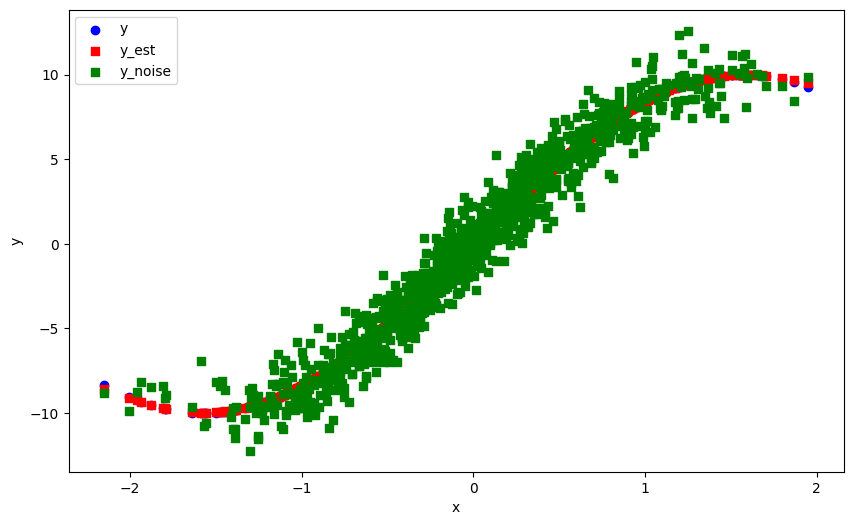

The programm is closed


In [14]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

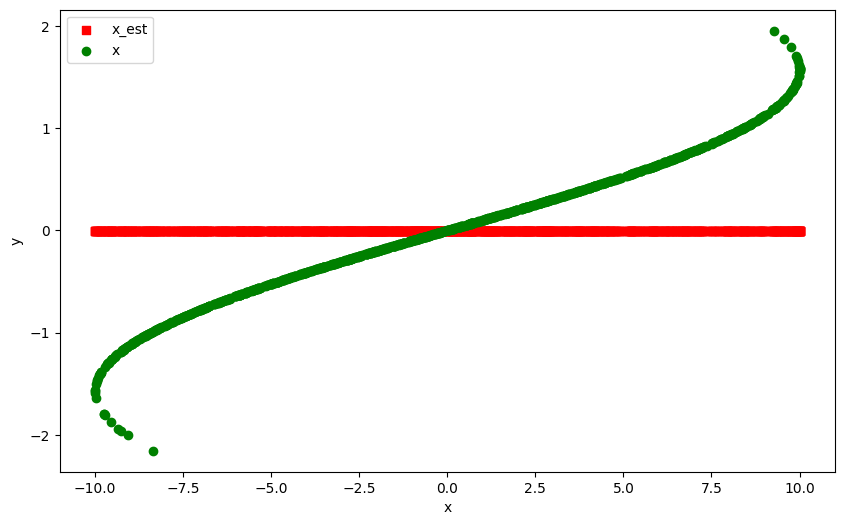

The programm is closed


In [15]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")